In [1]:
## all imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
 
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from keras.layers import Dropout
from mlxtend.classifier import EnsembleVoteClassifier,StackingCVClassifier

import pickle

from kaggle.api.kaggle_api_extended import KaggleApi

Using TensorFlow backend.


In [2]:

API = KaggleApi({"username":"oroxenberg","key":"538527cfd22bdb19ae607236e4b44cc8"})
API.authenticate()


def downloadAndOpen():
    import pathlib
    import zipfile
    API.competition_download_files('bgutreatmentoutcome')
    with zipfile.ZipFile(pathlib.Path().absolute()/"bgutreatmentoutcome.zip", 'r') as zip_ref:
        zip_ref.extractall(pathlib.Path().absolute())
    



    
def checkScore(clf,ID, test_processed):
    prob = clf.predict_proba(test_processed)
    df2 = pd.DataFrame({"id" : [x for x in range(1, len(prob)+1)],"ProbToYes" : list(prob[:,1])})
    df2.to_csv(f'submission{ID}.csv', index = None)
    df2.to_csv('submission.csv', index = None)
    API.competition_submit('submission.csv','API Submission','bgutreatmentoutcome')
    
    
def testModel(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(model.score(X_test,y_test))

    

def preprocess(train,test):
    #concate data
    train['dataType'] = 'train'
    test['dataType'] = 'test'
    test["CLASS"] = ""
    labelColumns = ["CLASS","dataType"]
    data = pd.concat([train, test])
    
    #handle missing value
    n = data.notnull()
    precentNotNull = 0.01
    data = data.loc[:, n.mean() > precentNotNull]
    
    catCol = []
    numCol = []
    binCol = []
    for col in data.columns[:-2]:
        if int(col[1:]) <= 83:
            catCol.append(col)
        else:
            if np.isin(data[col].dropna().unique(), [0, 1]).all():
                binCol.append(col)
            else:
                numCol.append(col)
    
    #most freq missing values
    imp_frq = SimpleImputer(strategy='most_frequent')
    imp_frq.fit(data[catCol+binCol+labelColumns])
    data_frq = pd.DataFrame( imp_frq.transform(data[catCol+binCol+labelColumns]), columns =catCol+binCol+labelColumns)
    
    mean_frq = SimpleImputer(strategy='mean')
    mean_frq.fit(data[numCol])
    data_mean = pd.DataFrame( mean_frq.transform(data[numCol]), columns =numCol)
    
    data = pd.concat([data_mean,data_frq],axis = 1)
    
    #sort class column to the end
    features = list(data.columns)
    features = [ elem for elem in features if elem not in labelColumns] 
    
    df_ohe_features = pd.get_dummies(data[features],prefix = catCol ,columns = catCol )

    #all dataframe to numric
    df_ohe_features = df_ohe_features.apply(pd.to_numeric)
    
    #normalize
    SC = StandardScaler()
    col = list(df_ohe_features.columns.values)
    df_ohe_features_val = SC.fit_transform(df_ohe_features.values)
    df_ohe_features = pd.DataFrame(df_ohe_features_val,columns = df_ohe_features.columns)
    df_ohe = pd.concat([df_ohe_features,data[labelColumns]],axis = 1)
    
    #split to test and train again
    train_processed = df_ohe[df_ohe['dataType']=='train']
    test_processed = df_ohe[df_ohe['dataType']=='test']
    
    #clean additonal columns
    test_processed = test_processed.drop(labelColumns,axis = 1)
    train_processed = train_processed.drop(["dataType"],axis = 1)
    
    #sort columns 
    train_processed,test_processed =  train_processed.align(test_processed, join = 'left', axis = 1)
    test_processed.drop('CLASS', inplace = True, axis = 1)
    return train_processed,test_processed


def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

def saveModel(model,num):
     filename = f'finalized_model{num}.sav'
     pickle.dump(model, open(filename, 'wb'))

############### --------- main ---------###########################
missing_values = ["n/a", "Nane", "nan","Null"]

train = pd.read_csv('./data/train.CSV', na_values = missing_values)
test = pd.read_csv('./data/test.CSV', na_values = missing_values)

train,test = preprocess(train,test)
train['CLASS'] = train['CLASS'] =='Yes'

# #handle inbulnce
# classCounter = train["CLASS"].value_counts()
# numberToAdd = abs(classCounter["Yes"] - classCounter["No"])
# train = train.append(train[train["CLASS"] == classCounter.index[classCounter.argmin()]].sample(n=numberToAdd, random_state=1),ignore_index = True)

X = train.iloc[:, :-1]
y = train.iloc[:, -1]

num_feats =  150

### Feature selection
## Pearson correlation
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

## chi-square

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

## recursive feature elimination
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

## Lasso 
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

## tree based - select from model
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

##light gbm - select from model
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

## final step
feature_selection_df = pd.DataFrame({'Feature':X.columns, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

selected_features = feature_selection_df[feature_selection_df['Total']>=3]

selected_features = list(selected_features['Feature'])

test = test[selected_features]
X = X[selected_features]
Y = y









C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,2,4,5,7,8,9,10,11,13,14,15,17,18,19,20,23,24,26,27,28,33,34,35,36,37,38,39,40,44,45,46,47,48,49,64,70,71,78,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


150 selected features
150 selected features
Fitting estimator with 391 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 381 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 371 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 361 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 351 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 341 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 331 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 321 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 311 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 301 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 291 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 281 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 271 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 261 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 251 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 241 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 231 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 221 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 211 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 201 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

Fitting estimator with 191 features.
Fitting estimator with 181 features.

C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod


Fitting estimator with 171 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 161 features.
Fitting estimator with 151 features.


C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

150 selected features
150 selected features
74 selected features
59 selected features


In [3]:
def build_model(nodes1=10,nodes2=10,nodes3=10, lr=0.001,lyers1=1,lyers2=1,lyers3=1,activation = 'relu', input_shape=X.shape[1]):
    model = Sequential()
    model.add(Dense(nodes1,activation=activation, kernel_initializer='uniform', input_shape=(input_shape,)))
    for l in range(lyers1):
        model.add(Dense(nodes1,activation=activation))
    for l in range(lyers2):
        model.add(Dense(nodes2,activation=activation))
    for l in range(lyers3):
        model.add(Dense(nodes3,activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return(model)

In [5]:
#--------- model ---------





#----random search-----

#- Boosted tree -
# gbc = GradientBoostingClassifier(verbose = 1)
# distributions = {'n_estimators':[50, 100, 200], 'max_depth': list(np.arange(3, 10)), 'min_samples_split':list(np.arange(2, 10))}
# clf = RandomizedSearchCV(gbc, distributions,n_iter = 10, random_state=42,verbose = 10, cv=3)
# fit = clf.fit(train_processed.iloc[:, :-1], train_processed.iloc[:,-1])
# sorted(fit.cv_results_.keys())
# fit.cv_results_
# fit.best_params_

# -Adaboost-
# ada = AdaBoostClassifier()
# distributions = {'n_estimators':[500, 700, 1000], 'learning_rate': list(np.arange(0.05, 0.5, 0.05))}
# clf = RandomizedSearchCV(ada, distributions,n_iter = 5, random_state=42,verbose = 10, cv=3)
# fit = clf.fit(train_processed.iloc[:, :-1], train_processed.iloc[:,-1])
# sorted(fit.cv_results_.keys())
# fit.cv_results_
# fit.best_params_

# -XGboost-
# xg = xgb.XGBClassifier(verbosity = 1)
# distributions = {'n_estimators':[40, 100, 200], 'booster': ['gbtree', 'dart'], 'eta': list(np.arange(0.1, 1, 0.1)),
#                  'gamma' : [0, 0.1], 'max_depth' : [6, 10, 15]}
# clf = RandomizedSearchCV(xg, distributions,n_iter = 10, random_state=42, verbose = 10, cv=5)
# fit = clf.fit(train_processed.iloc[:, :-1], train_processed.iloc[:,-1])
# sorted(fit.cv_results_.keys())
# fit.cv_results_
# fit.best_params_

# # -Logistic Regression-
# logr = LogisticRegression(verbose = 1)
# distributions = {'penalty':['l1', 'l2'], 'C': list(np.arange(0.1, 1, 0.1))}
# clf = RandomizedSearchCV(logr, distributions,n_iter = 10, random_state=42, verbose = 10, cv=5)
# fit = clf.fit(train_processed.iloc[:, :-1], train_processed.iloc[:,-1])
# sorted(fit.cv_results_.keys())
# fit.cv_results_
# fit.best_params_

# -Random Forest-
# rf = RandomForestClassifier(verbose = 1)
# distributions = {'n_estimators':[40, 100, 200], 'criterion': ['gini', 'enthropy'], 'min_samples_split':list(np.arange(2, 10))}
# clf = RandomizedSearchCV(rf, distributions,n_iter = 10, random_state=42, verbose = 10, cv=5)
# fit = clf.fit(train_processed.iloc[:, :-1], train_processed.iloc[:,-1])
# sorted(fit.cv_results_.keys())
# fit.cv_results_
# fit.best_params_

#-NN-
# nodes1 = [500,700,1000]
# nodes2 = [300,400,500]
# nodes3 = [100,200,300]# number of nodes in the hidden layer
# lrs = [0.001, 0.002, 0.003] # learning rate, default = 0.001
# Lyers1 = [1,2,3]
# Lyers2 = [1,2,3]
# Lyers3 = [1,2]

# epochs = 10
# batch_size = 32

# model = KerasClassifier(build_fn=build_model, epochs=epochs,
#                         batch_size=batch_size, verbose=1)
# param_distributions = dict(nodes1=nodes1,nodes2=nodes2,nodes3=nodes3,
#                            lr=lrs, lyers1 = Lyers1, lyers2 = Lyers2, lyers3 = Lyers3)

# grid = RandomizedSearchCV(estimator=model,n_iter = 30, param_distributions =param_distributions, cv=5,
#                     n_jobs=1, verbose=1)

# clf = grid.fit(X, Y)

# -SVM-

# svm = SVC(gamma='auto', probability = True)
# distributions = {'C':[0.1, 0.5, 1], 'kernel': ['linear', 'rbf']}
# clf = RandomizedSearchCV(svm, distributions,n_iter = 5, random_state=42, verbose = 10, cv=5)
# clf.fit(X,Y)

# -KNN-
# neigh  = KNeighborsClassifier()
# distributions = {'n_neighbors':np.arange(1,10,1)}
# clf = BayesSearchCV(neigh , distributions,n_iter = 5, random_state=42, verbose = 10, cv=5)
# clf.fit(X,Y)


#  # -voting classifier-
nodes1 = [500,700,800]
nodes2 = [300,400,500]
nodes3 = [100,200,300]# number of nodes in the hidden layer
lrs = [0.0005,0.001, 0.002] # learning rate, default = 0.001
Lyers1 = [2,3,4]
Lyers2 = [2,3,4]
Lyers3 = [1,2,3]
# activationfuncs = ['relu']

epochs = 10
batch_size = 32

clf1 = LogisticRegression()
clf2 = xgb.XGBClassifier()
clf3 = AdaBoostClassifier()
clf4 = GradientBoostingClassifier()
clf5 = RandomForestClassifier()
clf6 = KerasClassifier(build_fn=build_model, epochs = epochs, batch_size = batch_size)
clf6._estimator_type = "classifier"
# clf7 =  GaussianNB()

nodes1_lr = [10,20,30]
nodes2_lr = [10,20,30]
lrs_lr = [0.001, 0.002, 0.003] # learning rate, default = 0.001
Lyers1_lr = [1,2,3]
Lyers2_lr = [1,2,3]
Lyers3_lr = 0
# activationfuncs_lr = 'relu']
epochs_lr = 8
batch_size_lr = 16

lr = LogisticRegression()
lr._estimator_type = "classifier"


estimators = [('logisticregression', clf1),('xgbclassifier', clf2),('adaboostclassifier', clf3),('gradientboostingclassifier', clf4),('randomforestclassifier', clf5),('kerasclassifier', clf6),('GaussianNB', clf7)]


svc = StackingCVClassifier(classifiers=[clf1,clf2,clf3,clf4,clf5,clf6],meta_classifier=lr,random_state=42,use_probas=True, verbose = 1)


distributions = { 'logisticregression__C': list(np.arange(0.1,1,0.1)), 'xgbclassifier__n_estimators': [40,100, 200], 
                  'xgbclassifier__booster': ['gbtree', 'dart'], 'xgbclassifier__eta': list(np.arange(0.05, 0.15, 0.01)),'xgbclassifier__gamma' : [0, 0.1], 
                  'xgbclassifier__max_depth' : [3,5,6,7,8,9, 10], 'adaboostclassifier__n_estimators':[30,40, 50], 'adaboostclassifier__learning_rate': list(np.arange(0.3, 0.5, 0.05)), 
                 'gradientboostingclassifier__n_estimators':[50, 100, 200], 'gradientboostingclassifier__max_depth': list(np.arange(3, 10)), 'gradientboostingclassifier__min_samples_split':list(np.arange(5, 12)), 
                 'randomforestclassifier__n_estimators':[40, 100, 200],'randomforestclassifier__min_samples_split':list(np.arange(5, 14)), 
                 'kerasclassifier__nodes1': nodes1,'kerasclassifier__nodes2': nodes2,'kerasclassifier__nodes3': nodes3, 'kerasclassifier__lr':lrs , 'kerasclassifier__lyers1' : Lyers1,
                 'kerasclassifier__lyers2' : Lyers2,'kerasclassifier__lyers3' : Lyers3 , "meta_classifier__C" :  list(np.arange(0.1,1,0.1))
                }
                 
 # 'meta_classifier__nodes1' : nodes1_lr,'meta_classifier__nodes2' : nodes2_lr,'meta_classifier__lyers1' : Lyers1_lr,'meta_classifier__lyers2' : Lyers2_lr,
 #                  'meta_classifier__lr' : lrs_lr
# 'kerasclassifier__activation' : activationfuncs,'meta_classifier__activation' : activationfuncs_lr,'meta_classifier__lyers2' : Lyers2_lr,
clf = BayesSearchCV(svc, distributions,n_iter = 50, random_state=42, verbose = 10, cv=10)
fit = clf.fit(X, Y)
sorted(fit.cv_results_.keys())
fit.cv_results_
fit.best_params_


# -autoML- 

#clf = autosklearn.classification.AutoSklearnClassifier()
#clf.fit(X, Y)

X.to_csv("train_x.csv",index = False)
Y.to_csv("train_y.csv",index = False)

test.to_csv("test.csv",index = False)

saveModel(clf,3)

#---------test the model---------


testModel(clf, X, Y)


#---------submit---------



checkScore(clf,40, test)

bestVals  = dict(clf.best_params_)

hyperParam = pd.DataFrame(bestVals, index=[1,])

hyperParam.to_csv("log.csv",mode='a',header=True)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.2, adaboostclassifier__n_estimators=60, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=200, kerasclassifier__lr=0.002, kerasclassifier__lyers1=2, kerasclassifier__lyers2=3, kerasclassifier__lyers3=1, kerasclassifier__nodes1=700, kerasclassifier__nodes2=400, kerasclassifier__nodes3=100, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200, xgbclassifier__booster=dart, xgbclassifier__eta=0.7000000000000001, xgbclassifier__gamma=0.0040994995694252035, xgbclassifier__max_depth=15, xgbclassifier__n_estimators=100 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 2s 465us/step - loss: 0.6353 - accuracy: 0.6554
Epoch 2/10
4779/4779 [==============================] - 2s 424us/step - loss: 0.5729 - accuracy: 0.7091
Epoch 3/10
4779/4779 [==============================] - 2s 439us/step - loss: 0.5468 - accuracy: 0.7317
Epoch 4/10
4779/4779 [==============================] - 2s 449us/step - loss: 0.5274 - accuracy: 0.7349
Epoch 5/10
4779/4779 [==============================] - 2s 475us/step - loss: 0.5065 - accuracy: 0.7533
Epoch 6/10
4779/4779 [==============================] - 2s 454us/step - loss: 0.4804 - accuracy: 0.7594
Epoch 7/10
4779/4779 [==============================] - 2s 451us/step - loss: 0.4716 - accuracy: 0.7638
Epoch 8/10
4779/4779 [==============================] - 2s 451us/step - loss: 0.4500 - accuracy: 0.7686
Epoch 9/10
4779/4779 [==============================] - 2s 455us/step - loss: 0.4356 - accuracy: 0.78091s - loss: 0.427 - ETA

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 4s 448us/step - loss: 0.6137 - accuracy: 0.6766
Epoch 2/10
9559/9559 [==============================] - 4s 446us/step - loss: 0.5714 - accuracy: 0.7097
Epoch 3/10
9559/9559 [==============================] - 4s 450us/step - loss: 0.5529 - accuracy: 0.7263
Epoch 4/10
9559/9559 [==============================] - 4s 456us/step - loss: 0.5248 - accuracy: 0.7403
Epoch 5/10
9559/9559 [==============================] - 4s 465us/step - loss: 0.5050 - accuracy: 0.7498
Epoch 6/10
9559/9559 [==============================] - 4s 459us/step - loss: 0.4934 - accuracy: 0.7538
Epoch 7/10
9559/9559 [==============================] - 5s 473us/step - loss: 0.4809 - accuracy: 0.76230s - loss: 0.4796 - ac
Epoch 8/10
9559/9559 [==============================] - 5s 481us/step - loss: 0.4685 - accuracy: 0.7709
Epoch 9/10
9559/9559 [==============================] - 5s 475us/step - loss: 0.4525 - accuracy: 0.7720
Epoc

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 2s 464us/step - loss: 0.6262 - accuracy: 0.6583
Epoch 2/10
4779/4779 [==============================] - 2s 428us/step - loss: 0.5814 - accuracy: 0.7114
Epoch 3/10
4779/4779 [==============================] - 2s 448us/step - loss: 0.5558 - accuracy: 0.7244
Epoch 4/10
4779/4779 [==============================] - 2s 471us/step - loss: 0.5404 - accuracy: 0.7273
Epoch 5/10
4779/4779 [==============================] - 2s 455us/step - loss: 0.5144 - accuracy: 0.7512
Epoch 6/10
4779/4779 [==============================] - 2s 456us/step - loss: 0.4882 - accuracy: 0.7625
Epoch 7/10
4779/4779 [==============================] - 2s 457us/step - loss: 0.4738 - accuracy: 0.7640
Epoch 8/10
4779/4779 [==============================] - 2s 461us/step - loss: 0.4575 - accuracy: 0.7788
Epoch 9/10
4779/4779 [==============================] - 2s 457us/step - loss: 0.4330 - accuracy: 0.77900s - l
Epoch 10/10
477

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 5s 492us/step - loss: 0.6156 - accuracy: 0.6763
Epoch 2/10
9559/9559 [==============================] - 5s 538us/step - loss: 0.5613 - accuracy: 0.7169
Epoch 3/10
9559/9559 [==============================] - 5s 526us/step - loss: 0.5393 - accuracy: 0.7310
Epoch 4/10
9559/9559 [==============================] - 5s 516us/step - loss: 0.5256 - accuracy: 0.7389
Epoch 5/10
9559/9559 [==============================] - 5s 504us/step - loss: 0.5020 - accuracy: 0.74650s - loss: 0.5016 - accu
Epoch 6/10
9559/9559 [==============================] - 5s 499us/step - loss: 0.4899 - accuracy: 0.7612
Epoch 7/10
9559/9559 [==============================] - 5s 494us/step - loss: 0.4757 - accuracy: 0.7648
Epoch 8/10
9559/9559 [==============================] - 5s 482us/step - loss: 0.4622 - accuracy: 0.7703
Epoch 9/10
9559/9559 [==============================] - 5s 475us/step - loss: 0.4391 - accuracy: 0.7758
Ep

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 474us/step - loss: 0.6347 - accuracy: 0.6567
Epoch 2/10
4780/4780 [==============================] - 2s 454us/step - loss: 0.5654 - accuracy: 0.7197
Epoch 3/10
4780/4780 [==============================] - 2s 459us/step - loss: 0.5402 - accuracy: 0.74251s - loss: 0.5276 - accuracy -
Epoch 4/10
4780/4780 [==============================] - 2s 462us/step - loss: 0.5194 - accuracy: 0.7439
Epoch 5/10
4780/4780 [==============================] - 2s 469us/step - loss: 0.4946 - accuracy: 0.76190s - loss: 0.495
Epoch 6/10
4780/4780 [==============================] - 2s 469us/step - loss: 0.4825 - accuracy: 0.76840s - loss: 0.4807 -  - ETA: 0s - loss: 0.4833 - accuracy: 
Epoch 7/10
4780/4780 [==============================] - 2s 469us/step - loss: 0.4680 - accuracy: 0.77490s - loss:
Epoch 8/10
4780/4780 [==============================] - 2s 486us/step - loss: 0.4487 - accuracy: 0.7753
Epoch 9/10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 539us/step - loss: 0.6125 - accuracy: 0.6850
Epoch 2/10
9560/9560 [==============================] - 5s 541us/step - loss: 0.5650 - accuracy: 0.7130
Epoch 3/10
9560/9560 [==============================] - 5s 521us/step - loss: 0.5483 - accuracy: 0.7312
Epoch 4/10
9560/9560 [==============================] - 5s 509us/step - loss: 0.5275 - accuracy: 0.7424
Epoch 5/10
9560/9560 [==============================] - 5s 510us/step - loss: 0.5354 - accuracy: 0.7362
Epoch 6/10
9560/9560 [==============================] - 5s 493us/step - loss: 0.5136 - accuracy: 0.7471
Epoch 7/10
9560/9560 [==============================] - 5s 486us/step - loss: 0.4874 - accuracy: 0.7566
Epoch 8/10
9560/9560 [==============================] - 5s 484us/step - loss: 0.4681 - accuracy: 0.7691
Epoch 9/10
9560/9560 [==============================] - 5s 481us/step - loss: 0.4615 - accuracy: 0.77530s - loss: 0.4631 - accura


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 460us/step - loss: 0.6287 - accuracy: 0.6504
Epoch 2/10
4780/4780 [==============================] - 2s 433us/step - loss: 0.5702 - accuracy: 0.7126
Epoch 3/10
4780/4780 [==============================] - 2s 445us/step - loss: 0.5373 - accuracy: 0.7358
Epoch 4/10
4780/4780 [==============================] - 2s 458us/step - loss: 0.5148 - accuracy: 0.7450
Epoch 5/10
4780/4780 [==============================] - 2s 467us/step - loss: 0.4884 - accuracy: 0.7552
Epoch 6/10
4780/4780 [==============================] - 2s 466us/step - loss: 0.4668 - accuracy: 0.76860s - loss: 0.4644 - accuracy
Epoch 7/10
4780/4780 [==============================] - 2s 460us/step - loss: 0.4454 - accuracy: 0.7770
Epoch 8/10
4780/4780 [==============================] - 2s 457us/step - loss: 0.4277 - accuracy: 0.7883
Epoch 9/10
4780/4780 [==============================] - 2s 465us/step - loss: 0.4080 - accuracy: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 583us/step - loss: 0.6150 - accuracy: 0.6817
Epoch 2/10
9560/9560 [==============================] - 5s 568us/step - loss: 0.5579 - accuracy: 0.7173
Epoch 3/10
9560/9560 [==============================] - 5s 542us/step - loss: 0.5366 - accuracy: 0.7337
Epoch 4/10
9560/9560 [==============================] - 5s 532us/step - loss: 0.5100 - accuracy: 0.7451
Epoch 5/10
9560/9560 [==============================] - 5s 514us/step - loss: 0.4983 - accuracy: 0.7518
Epoch 6/10
9560/9560 [==============================] - 5s 505us/step - loss: 0.4853 - accuracy: 0.7596
Epoch 7/10
9560/9560 [==============================] - 5s 507us/step - loss: 0.4687 - accuracy: 0.7679
Epoch 8/10
9560/9560 [==============================] - 5s 492us/step - loss: 0.4495 - accuracy: 0.7701
Epoch 9/10
9560/9560 [==============================] - 5s 486us/step - loss: 0.4449 - accuracy: 0.7729
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 469us/step - loss: 0.6527 - accuracy: 0.6433
Epoch 2/10
4780/4780 [==============================] - 2s 452us/step - loss: 0.5747 - accuracy: 0.7107
Epoch 3/10
4780/4780 [==============================] - 2s 457us/step - loss: 0.5470 - accuracy: 0.7289
Epoch 4/10
4780/4780 [==============================] - 2s 462us/step - loss: 0.5207 - accuracy: 0.7418
Epoch 5/10
4780/4780 [==============================] - 2s 457us/step - loss: 0.5070 - accuracy: 0.7492
Epoch 6/10
4780/4780 [==============================] - 2s 469us/step - loss: 0.4838 - accuracy: 0.7680
Epoch 7/10
4780/4780 [==============================] - 2s 462us/step - loss: 0.4556 - accuracy: 0.7745
Epoch 8/10
4780/4780 [==============================] - 2s 464us/step - loss: 0.4419 - accuracy: 0.78600s - loss: 0.4390 - accuracy: 0.
Epoch 9/10
4780/4780 [==============================] - 2s 484us/step - loss: 0.4221 - accura

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 559us/step - loss: 0.6215 - accuracy: 0.6676
Epoch 2/10
9560/9560 [==============================] - 5s 552us/step - loss: 0.5687 - accuracy: 0.7100
Epoch 3/10
9560/9560 [==============================] - 5s 532us/step - loss: 0.5458 - accuracy: 0.7238
Epoch 4/10
9560/9560 [==============================] - 5s 520us/step - loss: 0.5206 - accuracy: 0.7430
Epoch 5/10
9560/9560 [==============================] - 5s 522us/step - loss: 0.5014 - accuracy: 0.7517
Epoch 6/10
9560/9560 [==============================] - 5s 520us/step - loss: 0.4951 - accuracy: 0.7548
Epoch 7/10
9560/9560 [==============================] - 5s 510us/step - loss: 0.4911 - accuracy: 0.7594
Epoch 8/10
9560/9560 [==============================] - 5s 505us/step - loss: 0.4707 - accuracy: 0.7669
Epoch 9/10
9560/9560 [==============================] - 5s 503us/step - loss: 0.4485 - accuracy: 0.7771
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 465us/step - loss: 0.6410 - accuracy: 0.6439
Epoch 2/10
4780/4780 [==============================] - 2s 432us/step - loss: 0.5682 - accuracy: 0.7086
Epoch 3/10
4780/4780 [==============================] - 2s 447us/step - loss: 0.5427 - accuracy: 0.7282
Epoch 4/10
4780/4780 [==============================] - 2s 454us/step - loss: 0.5207 - accuracy: 0.7473
Epoch 5/10
4780/4780 [==============================] - 2s 470us/step - loss: 0.4890 - accuracy: 0.7552
Epoch 6/10
4780/4780 [==============================] - 2s 459us/step - loss: 0.4756 - accuracy: 0.7678
Epoch 7/10
4780/4780 [==============================] - 2s 459us/step - loss: 0.4492 - accuracy: 0.7835
Epoch 8/10
4780/4780 [==============================] - 2s 461us/step - loss: 0.4345 - accuracy: 0.7849
Epoch 9/10
4780/4780 [==============================] - 2s 459us/step - loss: 0.4230 - accuracy: 0.7939
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 535us/step - loss: 0.6247 - accuracy: 0.6653
Epoch 2/10
9560/9560 [==============================] - 5s 525us/step - loss: 0.5688 - accuracy: 0.7147
Epoch 3/10
9560/9560 [==============================] - 5s 524us/step - loss: 0.5447 - accuracy: 0.7233
Epoch 4/10
9560/9560 [==============================] - 5s 513us/step - loss: 0.5240 - accuracy: 0.7374
Epoch 5/10
9560/9560 [==============================] - 5s 501us/step - loss: 0.5052 - accuracy: 0.7462
Epoch 6/10
9560/9560 [==============================] - 5s 495us/step - loss: 0.4902 - accuracy: 0.7579
Epoch 7/10
9560/9560 [==============================] - 5s 496us/step - loss: 0.4800 - accuracy: 0.76220s - loss: 0.4794 - accuracy
Epoch 8/10
9560/9560 [==============================] - 5s 482us/step - loss: 0.4604 - accuracy: 0.7730
Epoch 9/10
9560/9560 [==============================] - 5s 478us/step - loss: 0.4481 - accuracy: 0.776

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 483us/step - loss: 0.6177 - accuracy: 0.6736
Epoch 2/10
4780/4780 [==============================] - 2s 442us/step - loss: 0.5679 - accuracy: 0.7119
Epoch 3/10
4780/4780 [==============================] - 2s 465us/step - loss: 0.5639 - accuracy: 0.7169
Epoch 4/10
4780/4780 [==============================] - 2s 470us/step - loss: 0.5224 - accuracy: 0.7393
Epoch 5/10
4780/4780 [==============================] - 2s 466us/step - loss: 0.5060 - accuracy: 0.74960s - loss: 0.5038 - accura
Epoch 6/10
4780/4780 [==============================] - 2s 468us/step - loss: 0.4795 - accuracy: 0.7655
Epoch 7/10
4780/4780 [==============================] - 2s 469us/step - loss: 0.4660 - accuracy: 0.7665
Epoch 8/10
4780/4780 [==============================] - 2s 481us/step - loss: 0.4519 - accuracy: 0.7768
Epoch 9/10
4780/4780 [==============================] - 2s 481us/step - loss: 0.4260 - accuracy: 0.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 568us/step - loss: 0.6139 - accuracy: 0.6788
Epoch 2/10
9560/9560 [==============================] - 5s 512us/step - loss: 0.5645 - accuracy: 0.7159
Epoch 3/10
9560/9560 [==============================] - 5s 526us/step - loss: 0.5415 - accuracy: 0.7296
Epoch 4/10
9560/9560 [==============================] - 5s 496us/step - loss: 0.5257 - accuracy: 0.7386
Epoch 5/10
9560/9560 [==============================] - 5s 493us/step - loss: 0.5186 - accuracy: 0.7442
Epoch 6/10
9560/9560 [==============================] - 5s 486us/step - loss: 0.4981 - accuracy: 0.7545
Epoch 7/10
9560/9560 [==============================] - 5s 484us/step - loss: 0.4794 - accuracy: 0.7563
Epoch 8/10
9560/9560 [==============================] - 5s 472us/step - loss: 0.4672 - accuracy: 0.7639
Epoch 9/10
9560/9560 [==============================] - 4s 468us/step - loss: 0.4506 - accuracy: 0.77323s - - - ETA: 0s - los
Epoc

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 17.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 479us/step - loss: 0.6324 - accuracy: 0.6603
Epoch 2/10
4780/4780 [==============================] - 2s 440us/step - loss: 0.5829 - accuracy: 0.7027
Epoch 3/10
4780/4780 [==============================] - 2s 509us/step - loss: 0.5516 - accuracy: 0.7253
Epoch 4/10
4780/4780 [==============================] - 3s 556us/step - loss: 0.5305 - accuracy: 0.7433
Epoch 5/10
4780/4780 [==============================] - 3s 552us/step - loss: 0.5022 - accuracy: 0.7513
Epoch 6/10
4780/4780 [==============================] - 3s 534us/step - loss: 0.4656 - accuracy: 0.7680
Epoch 7/10
4780/4780 [==============================] - 3s 538us/step - loss: 0.4540 - accuracy: 0.7766
Epoch 8/10
4780/4780 [==============================] - 3s 539us/step - loss: 0.4502 - accuracy: 0.7812
Epoch 9/10
4780/4780 [==============================] - 3s 523us/step - loss: 0.4296 - accuracy: 0.7906
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 4s 457us/step - loss: 0.6089 - accuracy: 0.6827
Epoch 2/10
9560/9560 [==============================] - 4s 466us/step - loss: 0.5648 - accuracy: 0.7187
Epoch 3/10
9560/9560 [==============================] - 4s 467us/step - loss: 0.5374 - accuracy: 0.7345
Epoch 4/10
9560/9560 [==============================] - 4s 468us/step - loss: 0.5149 - accuracy: 0.7503
Epoch 5/10
9560/9560 [==============================] - 5s 478us/step - loss: 0.4996 - accuracy: 0.7564
Epoch 6/10
9560/9560 [==============================] - 5s 474us/step - loss: 0.4849 - accuracy: 0.75881s - - ETA: 0s - loss: 0.4843 - accuracy: 
Epoch 7/10
9560/9560 [==============================] - 5s 473us/step - loss: 0.4690 - accuracy: 0.7685
Epoch 8/10
9560/9560 [==============================] - 5s 476us/step - loss: 0.4554 - accuracy: 0.77790s - loss: 0.453
Epoch 9/10
9560/9560 [==============================] - 5s 485us/step - 

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 580us/step - loss: 0.6342 - accuracy: 0.6540
Epoch 2/10
4780/4780 [==============================] - 3s 544us/step - loss: 0.5818 - accuracy: 0.7031
Epoch 3/10
4780/4780 [==============================] - 3s 553us/step - loss: 0.5525 - accuracy: 0.7220
Epoch 4/10
4780/4780 [==============================] - 3s 564us/step - loss: 0.5186 - accuracy: 0.7471
Epoch 5/10
4780/4780 [==============================] - 3s 540us/step - loss: 0.5083 - accuracy: 0.7412
Epoch 6/10
4780/4780 [==============================] - 3s 537us/step - loss: 0.4875 - accuracy: 0.7642
Epoch 7/10
4780/4780 [==============================] - 3s 530us/step - loss: 0.4704 - accuracy: 0.7628
Epoch 8/10
4780/4780 [==============================] - 3s 524us/step - loss: 0.4499 - accuracy: 0.7814
Epoch 9/10
4780/4780 [==============================] - 2s 518us/step - loss: 0.4256 - accuracy: 0.7935
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 479us/step - loss: 0.6087 - accuracy: 0.6841
Epoch 2/10
9560/9560 [==============================] - 5s 502us/step - loss: 0.5599 - accuracy: 0.7222
Epoch 3/10
9560/9560 [==============================] - 5s 515us/step - loss: 0.5344 - accuracy: 0.7391
Epoch 4/10
9560/9560 [==============================] - 5s 510us/step - loss: 0.5146 - accuracy: 0.7492
Epoch 5/10
9560/9560 [==============================] - 5s 511us/step - loss: 0.4967 - accuracy: 0.7590
Epoch 6/10
9560/9560 [==============================] - 5s 506us/step - loss: 0.4873 - accuracy: 0.7626
Epoch 7/10
9560/9560 [==============================] - 5s 504us/step - loss: 0.4775 - accuracy: 0.7676
Epoch 8/10
9560/9560 [==============================] - 6s 610us/step - loss: 0.4580 - accuracy: 0.7755
Epoch 9/10
9560/9560 [==============================] - 6s 636us/step - loss: 0.4467 - accuracy: 0.7822
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 22.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 550us/step - loss: 0.6307 - accuracy: 0.65670s - l
Epoch 2/10
4780/4780 [==============================] - 2s 520us/step - loss: 0.5822 - accuracy: 0.7006
Epoch 3/10
4780/4780 [==============================] - 2s 523us/step - loss: 0.5572 - accuracy: 0.7285
Epoch 4/10
4780/4780 [==============================] - 3s 532us/step - loss: 0.5431 - accuracy: 0.7320
Epoch 5/10
4780/4780 [==============================] - 3s 527us/step - loss: 0.5197 - accuracy: 0.7423
Epoch 6/10
4780/4780 [==============================] - 2s 512us/step - loss: 0.4894 - accuracy: 0.7590
Epoch 7/10
4780/4780 [==============================] - 2s 511us/step - loss: 0.4779 - accuracy: 0.7611
Epoch 8/10
4780/4780 [==============================] - 2s 505us/step - loss: 0.4709 - accuracy: 0.7736
Epoch 9/10
4780/4780 [==============================] - 2s 502us/step - loss: 0.4470 - accuracy: 0.7810
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 4s 462us/step - loss: 0.6200 - accuracy: 0.6735
Epoch 2/10
9560/9560 [==============================] - 5s 490us/step - loss: 0.5649 - accuracy: 0.7126
Epoch 3/10
9560/9560 [==============================] - 5s 513us/step - loss: 0.5466 - accuracy: 0.7271
Epoch 4/10
9560/9560 [==============================] - 5s 503us/step - loss: 0.5278 - accuracy: 0.7335
Epoch 5/10
9560/9560 [==============================] - 5s 489us/step - loss: 0.5106 - accuracy: 0.7479
Epoch 6/10
9560/9560 [==============================] - 5s 485us/step - loss: 0.4970 - accuracy: 0.75470s - loss: 0.4982 - accuracy
Epoch 7/10
9560/9560 [==============================] - 5s 528us/step - loss: 0.4791 - accuracy: 0.7603
Epoch 8/10
9560/9560 [==============================] - 6s 589us/step - loss: 0.4677 - accuracy: 0.7649
Epoch 9/10
9560/9560 [==============================] - 6s 581us/step - loss: 0.4542 - accuracy: 0.774

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 25.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 619us/step - loss: 0.6158 - accuracy: 0.6654
Epoch 2/10
4779/4779 [==============================] - 3s 584us/step - loss: 0.5723 - accuracy: 0.70710s - loss: 0.5701 - accu
Epoch 3/10
4779/4779 [==============================] - 3s 584us/step - loss: 0.5313 - accuracy: 0.7332
Epoch 4/10
4779/4779 [==============================] - 3s 592us/step - loss: 0.5096 - accuracy: 0.7504
Epoch 5/10
4779/4779 [==============================] - 3s 604us/step - loss: 0.4816 - accuracy: 0.7587
Epoch 6/10
4779/4779 [==============================] - 3s 583us/step - loss: 0.4581 - accuracy: 0.7723
Epoch 7/10
4779/4779 [==============================] - 3s 572us/step - loss: 0.4337 - accuracy: 0.7807
Epoch 8/10
4779/4779 [==============================] - 3s 566us/step - loss: 0.4153 - accuracy: 0.7974
Epoch 9/10
4779/4779 [==============================] - 3s 561us/step - loss: 0.4021 - accuracy: 0.80

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 5s 522us/step - loss: 0.6080 - accuracy: 0.6815
Epoch 2/10
9559/9559 [==============================] - 6s 595us/step - loss: 0.5570 - accuracy: 0.7220
Epoch 3/10
9559/9559 [==============================] - 6s 576us/step - loss: 0.5306 - accuracy: 0.7342
Epoch 4/10
9559/9559 [==============================] - 6s 643us/step - loss: 0.5076 - accuracy: 0.7460
Epoch 5/10
9559/9559 [==============================] - 6s 652us/step - loss: 0.4875 - accuracy: 0.7624
Epoch 6/10
9559/9559 [==============================] - 6s 621us/step - loss: 0.4704 - accuracy: 0.7688
Epoch 7/10
9559/9559 [==============================] - 6s 597us/step - loss: 0.4532 - accuracy: 0.7727
Epoch 8/10
9559/9559 [==============================] - 6s 592us/step - loss: 0.4361 - accuracy: 0.7790
Epoch 9/10
9559/9559 [==============================] - 5s 570us/step - loss: 0.4175 - accuracy: 0.7912
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 540us/step - loss: 0.6226 - accuracy: 0.6621
Epoch 2/10
4779/4779 [==============================] - 2s 501us/step - loss: 0.5646 - accuracy: 0.7204
Epoch 3/10
4779/4779 [==============================] - 2s 512us/step - loss: 0.5322 - accuracy: 0.7374
Epoch 4/10
4779/4779 [==============================] - 2s 519us/step - loss: 0.5016 - accuracy: 0.7562
Epoch 5/10
4779/4779 [==============================] - 3s 528us/step - loss: 0.4895 - accuracy: 0.7606
Epoch 6/10
4779/4779 [==============================] - 3s 531us/step - loss: 0.4646 - accuracy: 0.77840s - loss: 0.4658 - ac
Epoch 7/10
4779/4779 [==============================] - 3s 530us/step - loss: 0.4459 - accuracy: 0.7834
Epoch 8/10
4779/4779 [==============================] - 3s 534us/step - loss: 0.4141 - accuracy: 0.7983
Epoch 9/10
4779/4779 [==============================] - 3s 528us/step - loss: 0.4053 - accuracy: 0.8048

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 6s 659us/step - loss: 0.6010 - accuracy: 0.6812
Epoch 2/10
9559/9559 [==============================] - 6s 646us/step - loss: 0.5531 - accuracy: 0.7236
Epoch 3/10
9559/9559 [==============================] - 6s 622us/step - loss: 0.5278 - accuracy: 0.7403
Epoch 4/10
9559/9559 [==============================] - 6s 597us/step - loss: 0.5040 - accuracy: 0.7504
Epoch 5/10
9559/9559 [==============================] - 6s 591us/step - loss: 0.4873 - accuracy: 0.7583
Epoch 6/10
9559/9559 [==============================] - 5s 575us/step - loss: 0.4658 - accuracy: 0.7692
Epoch 7/10
9559/9559 [==============================] - 5s 563us/step - loss: 0.4507 - accuracy: 0.7800
Epoch 8/10
9559/9559 [==============================] - 5s 566us/step - loss: 0.4330 - accuracy: 0.7856
Epoch 9/10
9559/9559 [==============================] - 5s 551us/step - loss: 0.4171 - accuracy: 0.7896
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 534us/step - loss: 0.6146 - accuracy: 0.6774
Epoch 2/10
4780/4780 [==============================] - 2s 512us/step - loss: 0.5587 - accuracy: 0.7326
Epoch 3/10
4780/4780 [==============================] - 3s 533us/step - loss: 0.5203 - accuracy: 0.7502
Epoch 4/10
4780/4780 [==============================] - 3s 526us/step - loss: 0.4952 - accuracy: 0.7594
Epoch 5/10
4780/4780 [==============================] - 3s 527us/step - loss: 0.4748 - accuracy: 0.7709
Epoch 6/10
4780/4780 [==============================] - 3s 538us/step - loss: 0.4498 - accuracy: 0.7755
Epoch 7/10
4780/4780 [==============================] - 3s 540us/step - loss: 0.4249 - accuracy: 0.7921
Epoch 8/10
4780/4780 [==============================] - 3s 534us/step - loss: 0.4060 - accuracy: 0.7996
Epoch 9/10
4780/4780 [==============================] - 3s 551us/step - loss: 0.3769 - accuracy: 0.8167
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 626us/step - loss: 0.6078 - accuracy: 0.6817
Epoch 2/10
9560/9560 [==============================] - 6s 605us/step - loss: 0.5531 - accuracy: 0.7263
Epoch 3/10
9560/9560 [==============================] - 6s 604us/step - loss: 0.5290 - accuracy: 0.73970s - loss: 0.5300 - accuracy: 0.
Epoch 4/10
9560/9560 [==============================] - 6s 582us/step - loss: 0.5158 - accuracy: 0.7436
Epoch 5/10
9560/9560 [==============================] - 5s 567us/step - loss: 0.4921 - accuracy: 0.7630
Epoch 6/10
9560/9560 [==============================] - 6s 582us/step - loss: 0.4748 - accuracy: 0.7643
Epoch 7/10
9560/9560 [==============================] - 6s 583us/step - loss: 0.4590 - accuracy: 0.7724
Epoch 8/10
9560/9560 [==============================] - 5s 562us/step - loss: 0.4463 - accuracy: 0.7816
Epoch 9/10
9560/9560 [==============================] - 5s 561us/step - loss: 0.4249 - accuracy: 0

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 543us/step - loss: 0.6174 - accuracy: 0.6661
Epoch 2/10
4780/4780 [==============================] - 3s 527us/step - loss: 0.5485 - accuracy: 0.7299
Epoch 3/10
4780/4780 [==============================] - 3s 527us/step - loss: 0.5181 - accuracy: 0.7483
Epoch 4/10
4780/4780 [==============================] - 3s 540us/step - loss: 0.4856 - accuracy: 0.7613
Epoch 5/10
4780/4780 [==============================] - 3s 528us/step - loss: 0.4618 - accuracy: 0.7755
Epoch 6/10
4780/4780 [==============================] - 3s 529us/step - loss: 0.4383 - accuracy: 0.7925
Epoch 7/10
4780/4780 [==============================] - 3s 526us/step - loss: 0.4082 - accuracy: 0.8008
Epoch 8/10
4780/4780 [==============================] - 3s 527us/step - loss: 0.3887 - accuracy: 0.8103
Epoch 9/10
4780/4780 [==============================] - 3s 530us/step - loss: 0.3759 - accuracy: 0.8167
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 608us/step - loss: 0.6012 - accuracy: 0.6877
Epoch 2/10
9560/9560 [==============================] - 6s 581us/step - loss: 0.5495 - accuracy: 0.7228
Epoch 3/10
9560/9560 [==============================] - 5s 573us/step - loss: 0.5210 - accuracy: 0.7390
Epoch 4/10
9560/9560 [==============================] - 5s 573us/step - loss: 0.5006 - accuracy: 0.7527
Epoch 5/10
9560/9560 [==============================] - 5s 555us/step - loss: 0.4796 - accuracy: 0.7574
Epoch 6/10
9560/9560 [==============================] - 5s 548us/step - loss: 0.4604 - accuracy: 0.7741
Epoch 7/10
9560/9560 [==============================] - 5s 551us/step - loss: 0.4416 - accuracy: 0.7813
Epoch 8/10
9560/9560 [==============================] - 5s 535us/step - loss: 0.4252 - accuracy: 0.7900
Epoch 9/10
9560/9560 [==============================] - 5s 530us/step - loss: 0.4116 - accuracy: 0.7971
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 535us/step - loss: 0.6236 - accuracy: 0.6596
Epoch 2/10
4780/4780 [==============================] - 3s 527us/step - loss: 0.5689 - accuracy: 0.7186
Epoch 3/10
4780/4780 [==============================] - 3s 664us/step - loss: 0.5336 - accuracy: 0.7322
Epoch 4/10
4780/4780 [==============================] - 3s 668us/step - loss: 0.4991 - accuracy: 0.7623
Epoch 5/10
4780/4780 [==============================] - 3s 667us/step - loss: 0.4681 - accuracy: 0.7743
Epoch 6/10
4780/4780 [==============================] - 3s 668us/step - loss: 0.4459 - accuracy: 0.7956
Epoch 7/10
4780/4780 [==============================] - 3s 655us/step - loss: 0.4215 - accuracy: 0.8017
Epoch 8/10
4780/4780 [==============================] - 3s 654us/step - loss: 0.3933 - accuracy: 0.8109
Epoch 9/10
4780/4780 [==============================] - 3s 654us/step - loss: 0.3772 - accuracy: 0.8167
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 519us/step - loss: 0.6116 - accuracy: 0.6764
Epoch 2/10
9560/9560 [==============================] - 5s 523us/step - loss: 0.5619 - accuracy: 0.7195
Epoch 3/10
9560/9560 [==============================] - 5s 529us/step - loss: 0.5309 - accuracy: 0.7337
Epoch 4/10
9560/9560 [==============================] - 5s 528us/step - loss: 0.5056 - accuracy: 0.7461
Epoch 5/10
9560/9560 [==============================] - 5s 538us/step - loss: 0.4855 - accuracy: 0.7552
Epoch 6/10
9560/9560 [==============================] - 5s 555us/step - loss: 0.4695 - accuracy: 0.7642
Epoch 7/10
9560/9560 [==============================] - 5s 573us/step - loss: 0.4443 - accuracy: 0.7776
Epoch 8/10
9560/9560 [==============================] - 6s 673us/step - loss: 0.4308 - accuracy: 0.7877
Epoch 9/10
9560/9560 [==============================] - 6s 668us/step - loss: 0.4096 - accuracy: 0.79481s - loss: 0.4066 - ac
Epoc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 651us/step - loss: 0.6162 - accuracy: 0.6678
Epoch 2/10
4780/4780 [==============================] - 3s 618us/step - loss: 0.5585 - accuracy: 0.7169
Epoch 3/10
4780/4780 [==============================] - 3s 612us/step - loss: 0.5238 - accuracy: 0.7456
Epoch 4/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.5062 - accuracy: 0.7573
Epoch 5/10
4780/4780 [==============================] - 3s 598us/step - loss: 0.4682 - accuracy: 0.7724
Epoch 6/10
4780/4780 [==============================] - 3s 613us/step - loss: 0.4474 - accuracy: 0.7797
Epoch 7/10
4780/4780 [==============================] - 3s 583us/step - loss: 0.4245 - accuracy: 0.7897
Epoch 8/10
4780/4780 [==============================] - 3s 578us/step - loss: 0.3997 - accuracy: 0.7996
Epoch 9/10
4780/4780 [==============================] - 3s 574us/step - loss: 0.3856 - accuracy: 0.8096
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 519us/step - loss: 0.6106 - accuracy: 0.67090s -
Epoch 2/10
9560/9560 [==============================] - 5s 522us/step - loss: 0.5502 - accuracy: 0.7202
Epoch 3/10
9560/9560 [==============================] - 5s 531us/step - loss: 0.5211 - accuracy: 0.7416
Epoch 4/10
9560/9560 [==============================] - 5s 530us/step - loss: 0.5002 - accuracy: 0.75660s - loss: 0.5016 - ac
Epoch 5/10
9560/9560 [==============================] - 6s 608us/step - loss: 0.4814 - accuracy: 0.7590
Epoch 6/10
9560/9560 [==============================] - 6s 674us/step - loss: 0.4684 - accuracy: 0.76880s - loss: 0
Epoch 7/10
9560/9560 [==============================] - 6s 669us/step - loss: 0.4429 - accuracy: 0.7780
Epoch 8/10
9560/9560 [==============================] - 7s 698us/step - loss: 0.4324 - accuracy: 0.7888
Epoch 9/10
9560/9560 [==============================] - 6s 656us/step - loss: 0.4141 - accur

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 607us/step - loss: 0.6233 - accuracy: 0.6561
Epoch 2/10
4780/4780 [==============================] - 3s 579us/step - loss: 0.5558 - accuracy: 0.7155
Epoch 3/10
4780/4780 [==============================] - 3s 579us/step - loss: 0.5265 - accuracy: 0.7397
Epoch 4/10
4780/4780 [==============================] - 3s 577us/step - loss: 0.4967 - accuracy: 0.7563
Epoch 5/10
4780/4780 [==============================] - 3s 570us/step - loss: 0.4708 - accuracy: 0.7686
Epoch 6/10
4780/4780 [==============================] - 3s 568us/step - loss: 0.4471 - accuracy: 0.7831
Epoch 7/10
4780/4780 [==============================] - 3s 576us/step - loss: 0.4273 - accuracy: 0.7925
Epoch 8/10
4780/4780 [==============================] - 3s 557us/step - loss: 0.4005 - accuracy: 0.8031
Epoch 9/10
4780/4780 [==============================] - 3s 555us/step - loss: 0.3996 - accuracy: 0.8105
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 632us/step - loss: 0.6050 - accuracy: 0.67910s - loss: 0.6085 - 
Epoch 2/10
9560/9560 [==============================] - 6s 663us/step - loss: 0.5535 - accuracy: 0.7219
Epoch 3/10
9560/9560 [==============================] - 6s 658us/step - loss: 0.5232 - accuracy: 0.7429
Epoch 4/10
9560/9560 [==============================] - 6s 622us/step - loss: 0.5015 - accuracy: 0.75040s - loss: 0.5 - ETA: 0s - loss: 0.5016 - accuracy: 0.75
Epoch 5/10
9560/9560 [==============================] - 6s 608us/step - loss: 0.4779 - accuracy: 0.76651s - loss: - ETA: 0s - loss: 0.4805 - ac
Epoch 6/10
9560/9560 [==============================] - 6s 588us/step - loss: 0.4620 - accuracy: 0.7734
Epoch 7/10
9560/9560 [==============================] - 5s 574us/step - loss: 0.4455 - accuracy: 0.7821
Epoch 8/10
9560/9560 [==============================] - 5s 573us/step - loss: 0.4296 - accuracy: 0.7879
Epoch 9/10
956

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 16.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 549us/step - loss: 0.6218 - accuracy: 0.6657
Epoch 2/10
4780/4780 [==============================] - 3s 525us/step - loss: 0.5623 - accuracy: 0.7157
Epoch 3/10
4780/4780 [==============================] - 3s 559us/step - loss: 0.5356 - accuracy: 0.7341
Epoch 4/10
4780/4780 [==============================] - 3s 547us/step - loss: 0.5026 - accuracy: 0.7544
Epoch 5/10
4780/4780 [==============================] - 3s 540us/step - loss: 0.4827 - accuracy: 0.7636
Epoch 6/10
4780/4780 [==============================] - 3s 531us/step - loss: 0.4554 - accuracy: 0.7751
Epoch 7/10
4780/4780 [==============================] - 3s 536us/step - loss: 0.4363 - accuracy: 0.7856
Epoch 8/10
4780/4780 [==============================] - 3s 534us/step - loss: 0.4087 - accuracy: 0.7954
Epoch 9/10
4780/4780 [==============================] - 3s 551us/step - loss: 0.3875 - accuracy: 0.8109
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 611us/step - loss: 0.5981 - accuracy: 0.68620s
Epoch 2/10
9560/9560 [==============================] - 6s 590us/step - loss: 0.5477 - accuracy: 0.7283
Epoch 3/10
9560/9560 [==============================] - 6s 592us/step - loss: 0.5143 - accuracy: 0.7463
Epoch 4/10
9560/9560 [==============================] - 5s 572us/step - loss: 0.4947 - accuracy: 0.7558
Epoch 5/10
9560/9560 [==============================] - 5s 563us/step - loss: 0.4755 - accuracy: 0.7616
Epoch 6/10
9560/9560 [==============================] - 5s 563us/step - loss: 0.4595 - accuracy: 0.7713
Epoch 7/10
9560/9560 [==============================] - 5s 548us/step - loss: 0.4436 - accuracy: 0.7787
Epoch 8/10
9560/9560 [==============================] - 5s 541us/step - loss: 0.4265 - accuracy: 0.7850
Epoch 9/10
9560/9560 [==============================] - 5s 546us/step - loss: 0.4156 - accuracy: 0.7891
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 18.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 533us/step - loss: 0.6239 - accuracy: 0.6640
Epoch 2/10
4780/4780 [==============================] - 2s 505us/step - loss: 0.5664 - accuracy: 0.7176
Epoch 3/10
4780/4780 [==============================] - 2s 520us/step - loss: 0.5409 - accuracy: 0.7276
Epoch 4/10
4780/4780 [==============================] - 3s 537us/step - loss: 0.5125 - accuracy: 0.7469
Epoch 5/10
4780/4780 [==============================] - 3s 527us/step - loss: 0.4893 - accuracy: 0.76740s - loss: 0.4894 - accuracy: 0.76
Epoch 6/10
4780/4780 [==============================] - 3s 553us/step - loss: 0.4667 - accuracy: 0.7680
Epoch 7/10
4780/4780 [==============================] - 3s 576us/step - loss: 0.4404 - accuracy: 0.7897
Epoch 8/10
4780/4780 [==============================] - 3s 644us/step - loss: 0.4237 - accuracy: 0.7931
Epoch 9/10
4780/4780 [==============================] - 3s 651us/step - loss: 0.3999 - accu

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 559us/step - loss: 0.6004 - accuracy: 0.6869
Epoch 2/10
9560/9560 [==============================] - 5s 559us/step - loss: 0.5520 - accuracy: 0.7220
Epoch 3/10
9560/9560 [==============================] - 5s 556us/step - loss: 0.5255 - accuracy: 0.7386
Epoch 4/10
9560/9560 [==============================] - 5s 551us/step - loss: 0.5089 - accuracy: 0.7492
Epoch 5/10
9560/9560 [==============================] - 5s 538us/step - loss: 0.4869 - accuracy: 0.7589
Epoch 6/10
9560/9560 [==============================] - 5s 534us/step - loss: 0.4668 - accuracy: 0.7706
Epoch 7/10
9560/9560 [==============================] - 5s 534us/step - loss: 0.4542 - accuracy: 0.7766
Epoch 8/10
9560/9560 [==============================] - 5s 526us/step - loss: 0.4362 - accuracy: 0.7848
Epoch 9/10
9560/9560 [==============================] - 5s 560us/step - loss: 0.4195 - accuracy: 0.7958
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 21.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 672us/step - loss: 0.6208 - accuracy: 0.6669
Epoch 2/10
4780/4780 [==============================] - 3s 649us/step - loss: 0.5649 - accuracy: 0.7105
Epoch 3/10
4780/4780 [==============================] - 3s 657us/step - loss: 0.5301 - accuracy: 0.7339
Epoch 4/10
4780/4780 [==============================] - 3s 657us/step - loss: 0.5041 - accuracy: 0.7561
Epoch 5/10
4780/4780 [==============================] - 3s 638us/step - loss: 0.4821 - accuracy: 0.7586
Epoch 6/10
4780/4780 [==============================] - 3s 619us/step - loss: 0.4630 - accuracy: 0.7770
Epoch 7/10
4780/4780 [==============================] - 3s 610us/step - loss: 0.4355 - accuracy: 0.78540s - loss: 0.4369 
Epoch 8/10
4780/4780 [==============================] - 3s 602us/step - loss: 0.4175 - accuracy: 0.7958
Epoch 9/10
4780/4780 [==============================] - 3s 591us/step - loss: 0.3903 - accuracy: 0.8111
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 5s 525us/step - loss: 0.6022 - accuracy: 0.6873
Epoch 2/10
9560/9560 [==============================] - 5s 528us/step - loss: 0.5507 - accuracy: 0.7259
Epoch 3/10
9560/9560 [==============================] - 5s 531us/step - loss: 0.5207 - accuracy: 0.7435
Epoch 4/10
9560/9560 [==============================] - 5s 536us/step - loss: 0.5015 - accuracy: 0.7559
Epoch 5/10
9560/9560 [==============================] - 5s 541us/step - loss: 0.4788 - accuracy: 0.7646
Epoch 6/10
9560/9560 [==============================] - 5s 537us/step - loss: 0.4633 - accuracy: 0.7755
Epoch 7/10
9560/9560 [==============================] - 6s 599us/step - loss: 0.4471 - accuracy: 0.7831
Epoch 8/10
9560/9560 [==============================] - 7s 703us/step - loss: 0.4285 - accuracy: 0.7845
Epoch 9/10
9560/9560 [==============================] - 7s 689us/step - loss: 0.4093 - accuracy: 0.7963
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 23.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 825us/step - loss: 0.6399 - accuracy: 0.6562
Epoch 2/10
4779/4779 [==============================] - 4s 780us/step - loss: 0.5894 - accuracy: 0.7020
Epoch 3/10
4779/4779 [==============================] - 4s 747us/step - loss: 0.5607 - accuracy: 0.7244
Epoch 4/10
4779/4779 [==============================] - 4s 743us/step - loss: 0.5420 - accuracy: 0.7330
Epoch 5/10
4779/4779 [==============================] - 3s 726us/step - loss: 0.5179 - accuracy: 0.7435
Epoch 6/10
4779/4779 [==============================] - 4s 734us/step - loss: 0.4967 - accuracy: 0.7558
Epoch 7/10
4779/4779 [==============================] - 3s 712us/step - loss: 0.5039 - accuracy: 0.7608
Epoch 8/10
4779/4779 [==============================] - 3s 705us/step - loss: 0.4842 - accuracy: 0.7621
Epoch 9/10
4779/4779 [==============================] - 3s 693us/step - loss: 0.4846 - accuracy: 0.7736
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 7s 757us/step - loss: 0.6214 - accuracy: 0.6652
Epoch 2/10
9559/9559 [==============================] - 8s 841us/step - loss: 0.5852 - accuracy: 0.7090
Epoch 3/10
9559/9559 [==============================] - 8s 835us/step - loss: 0.5525 - accuracy: 0.7256
Epoch 4/10
9559/9559 [==============================] - 8s 828us/step - loss: 0.5324 - accuracy: 0.7351
Epoch 5/10
9559/9559 [==============================] - 7s 781us/step - loss: 0.5104 - accuracy: 0.7473
Epoch 6/10
9559/9559 [==============================] - 7s 781us/step - loss: 0.4989 - accuracy: 0.7590
Epoch 7/10
9559/9559 [==============================] - 8s 812us/step - loss: 0.4863 - accuracy: 0.7610
Epoch 8/10
9559/9559 [==============================] - 7s 784us/step - loss: 0.4878 - accuracy: 0.7594
Epoch 9/10
9559/9559 [==============================] - 7s 738us/step - loss: 0.4657 - accuracy: 0.7714
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 675us/step - loss: 0.6470 - accuracy: 0.6418
Epoch 2/10
4779/4779 [==============================] - 3s 694us/step - loss: 0.6061 - accuracy: 0.6888
Epoch 3/10
4779/4779 [==============================] - 3s 674us/step - loss: 0.5692 - accuracy: 0.7152
Epoch 4/10
4779/4779 [==============================] - 3s 670us/step - loss: 0.5509 - accuracy: 0.7284
Epoch 5/10
4779/4779 [==============================] - 3s 670us/step - loss: 0.5365 - accuracy: 0.7359
Epoch 6/10
4779/4779 [==============================] - 3s 668us/step - loss: 0.5096 - accuracy: 0.7518
Epoch 7/10
4779/4779 [==============================] - 3s 699us/step - loss: 0.4927 - accuracy: 0.7615
Epoch 8/10
4779/4779 [==============================] - 3s 699us/step - loss: 0.4790 - accuracy: 0.7690
Epoch 9/10
4779/4779 [==============================] - 3s 693us/step - loss: 0.4547 - accuracy: 0.7809
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 7s 784us/step - loss: 0.6227 - accuracy: 0.6726
Epoch 2/10
9559/9559 [==============================] - 7s 731us/step - loss: 0.5724 - accuracy: 0.7144
Epoch 3/10
9559/9559 [==============================] - 7s 722us/step - loss: 0.5497 - accuracy: 0.7280
Epoch 4/10
9559/9559 [==============================] - 7s 707us/step - loss: 0.5243 - accuracy: 0.7429
Epoch 5/10
9559/9559 [==============================] - 7s 688us/step - loss: 0.5126 - accuracy: 0.7489
Epoch 6/10
9559/9559 [==============================] - 7s 696us/step - loss: 0.5007 - accuracy: 0.7554
Epoch 7/10
9559/9559 [==============================] - 6s 678us/step - loss: 0.4847 - accuracy: 0.7597
Epoch 8/10
9559/9559 [==============================] - 6s 677us/step - loss: 0.4686 - accuracy: 0.7700
Epoch 9/10
9559/9559 [==============================] - 7s 762us/step - loss: 0.4705 - accuracy: 0.7701
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 812us/step - loss: 0.6320 - accuracy: 0.6607
Epoch 2/10
4780/4780 [==============================] - 4s 802us/step - loss: 0.5723 - accuracy: 0.7209
Epoch 3/10
4780/4780 [==============================] - 4s 802us/step - loss: 0.5478 - accuracy: 0.7345
Epoch 4/10
4780/4780 [==============================] - 4s 768us/step - loss: 0.5228 - accuracy: 0.7473
Epoch 5/10
4780/4780 [==============================] - 4s 756us/step - loss: 0.5136 - accuracy: 0.7475
Epoch 6/10
4780/4780 [==============================] - 4s 759us/step - loss: 0.4870 - accuracy: 0.7642
Epoch 7/10
4780/4780 [==============================] - 4s 738us/step - loss: 0.4737 - accuracy: 0.7787
Epoch 8/10
4780/4780 [==============================] - 3s 724us/step - loss: 0.4504 - accuracy: 0.7849
Epoch 9/10
4780/4780 [==============================] - 3s 713us/step - loss: 0.4400 - accuracy: 0.7883
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 735us/step - loss: 0.6164 - accuracy: 0.6826
Epoch 2/10
9560/9560 [==============================] - 8s 819us/step - loss: 0.5634 - accuracy: 0.7196
Epoch 3/10
9560/9560 [==============================] - 8s 816us/step - loss: 0.5410 - accuracy: 0.7370
Epoch 4/10
9560/9560 [==============================] - 8s 820us/step - loss: 0.5344 - accuracy: 0.74630s - loss: 0.5345 - accuracy: 0.
Epoch 5/10
9560/9560 [==============================] - 8s 790us/step - loss: 0.5143 - accuracy: 0.7528
Epoch 6/10
9560/9560 [==============================] - 7s 763us/step - loss: 0.5076 - accuracy: 0.7629
Epoch 7/10
9560/9560 [==============================] - 7s 728us/step - loss: 0.4793 - accuracy: 0.7669
Epoch 8/10
9560/9560 [==============================] - 7s 722us/step - loss: 0.4757 - accuracy: 0.7706
Epoch 9/10
9560/9560 [==============================] - 7s 698us/step - loss: 0.4550 - accuracy: 0

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 679us/step - loss: 0.6429 - accuracy: 0.6596
Epoch 2/10
4780/4780 [==============================] - 3s 643us/step - loss: 0.5838 - accuracy: 0.7052
Epoch 3/10
4780/4780 [==============================] - 3s 663us/step - loss: 0.5502 - accuracy: 0.7303
Epoch 4/10
4780/4780 [==============================] - 3s 655us/step - loss: 0.5272 - accuracy: 0.7322
Epoch 5/10
4780/4780 [==============================] - 3s 662us/step - loss: 0.5106 - accuracy: 0.7381
Epoch 6/10
4780/4780 [==============================] - 3s 657us/step - loss: 0.4888 - accuracy: 0.7527
Epoch 7/10
4780/4780 [==============================] - 3s 660us/step - loss: 0.4618 - accuracy: 0.7711
Epoch 8/10
4780/4780 [==============================] - 3s 692us/step - loss: 0.4451 - accuracy: 0.7847
Epoch 9/10
4780/4780 [==============================] - 4s 760us/step - loss: 0.4399 - accuracy: 0.7856
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 747us/step - loss: 0.6336 - accuracy: 0.6569
Epoch 2/10
9560/9560 [==============================] - 7s 725us/step - loss: 0.5688 - accuracy: 0.7181
Epoch 3/10
9560/9560 [==============================] - 7s 748us/step - loss: 0.5412 - accuracy: 0.7326
Epoch 4/10
9560/9560 [==============================] - 7s 735us/step - loss: 0.5288 - accuracy: 0.7416
Epoch 5/10
9560/9560 [==============================] - 7s 684us/step - loss: 0.5193 - accuracy: 0.7478
Epoch 6/10
9560/9560 [==============================] - 7s 682us/step - loss: 0.4903 - accuracy: 0.7579
Epoch 7/10
9560/9560 [==============================] - 6s 673us/step - loss: 0.4789 - accuracy: 0.7607
Epoch 8/10
9560/9560 [==============================] - 7s 757us/step - loss: 0.4608 - accuracy: 0.7719
Epoch 9/10
9560/9560 [==============================] - 9s 904us/step - loss: 0.4424 - accuracy: 0.7783
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 823us/step - loss: 0.6403 - accuracy: 0.6441
Epoch 2/10
4780/4780 [==============================] - 4s 787us/step - loss: 0.5813 - accuracy: 0.6983
Epoch 3/10
4780/4780 [==============================] - 4s 749us/step - loss: 0.5632 - accuracy: 0.7178
Epoch 4/10
4780/4780 [==============================] - 4s 739us/step - loss: 0.5345 - accuracy: 0.7354
Epoch 5/10
4780/4780 [==============================] - 3s 728us/step - loss: 0.5128 - accuracy: 0.7458
Epoch 6/10
4780/4780 [==============================] - 4s 737us/step - loss: 0.5000 - accuracy: 0.7623
Epoch 7/10
4780/4780 [==============================] - 3s 720us/step - loss: 0.4698 - accuracy: 0.7661
Epoch 8/10
4780/4780 [==============================] - 3s 703us/step - loss: 0.4577 - accuracy: 0.7797
Epoch 9/10
4780/4780 [==============================] - 3s 700us/step - loss: 0.4286 - accuracy: 0.7925
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 863us/step - loss: 0.6278 - accuracy: 0.6581
Epoch 2/10
9560/9560 [==============================] - 8s 858us/step - loss: 0.5783 - accuracy: 0.7077
Epoch 3/10
9560/9560 [==============================] - 8s 862us/step - loss: 0.5528 - accuracy: 0.7230
Epoch 4/10
9560/9560 [==============================] - 8s 819us/step - loss: 0.5354 - accuracy: 0.7324
Epoch 5/10
9560/9560 [==============================] - 7s 779us/step - loss: 0.5081 - accuracy: 0.7459
Epoch 6/10
9560/9560 [==============================] - 7s 752us/step - loss: 0.4953 - accuracy: 0.7578
Epoch 7/10
9560/9560 [==============================] - 7s 725us/step - loss: 0.4785 - accuracy: 0.7636
Epoch 8/10
9560/9560 [==============================] - 7s 718us/step - loss: 0.4638 - accuracy: 0.7697
Epoch 9/10
9560/9560 [==============================] - 7s 714us/step - loss: 0.4574 - accuracy: 0.7656
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 686us/step - loss: 0.6294 - accuracy: 0.6636
Epoch 2/10
4780/4780 [==============================] - 3s 671us/step - loss: 0.5825 - accuracy: 0.7079
Epoch 3/10
4780/4780 [==============================] - 3s 661us/step - loss: 0.5515 - accuracy: 0.7278
Epoch 4/10
4780/4780 [==============================] - 3s 662us/step - loss: 0.5224 - accuracy: 0.7429
Epoch 5/10
4780/4780 [==============================] - 3s 685us/step - loss: 0.5114 - accuracy: 0.7559
Epoch 6/10
4780/4780 [==============================] - 4s 802us/step - loss: 0.4926 - accuracy: 0.7552
Epoch 7/10
4780/4780 [==============================] - 4s 862us/step - loss: 0.4658 - accuracy: 0.7705
Epoch 8/10
4780/4780 [==============================] - 4s 880us/step - loss: 0.4513 - accuracy: 0.7801
Epoch 9/10
4780/4780 [==============================] - 4s 845us/step - loss: 0.4273 - accuracy: 0.7998
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 724us/step - loss: 0.6200 - accuracy: 0.6612
Epoch 2/10
9560/9560 [==============================] - 7s 701us/step - loss: 0.5728 - accuracy: 0.7076
Epoch 3/10
9560/9560 [==============================] - 7s 697us/step - loss: 0.5533 - accuracy: 0.7186
Epoch 4/10
9560/9560 [==============================] - 7s 683us/step - loss: 0.5322 - accuracy: 0.7349
Epoch 5/10
9560/9560 [==============================] - 7s 682us/step - loss: 0.5217 - accuracy: 0.7406
Epoch 6/10
9560/9560 [==============================] - 7s 712us/step - loss: 0.4974 - accuracy: 0.7514
Epoch 7/10
9560/9560 [==============================] - 7s 753us/step - loss: 0.4869 - accuracy: 0.7607
Epoch 8/10
9560/9560 [==============================] - 8s 837us/step - loss: 0.4671 - accuracy: 0.7697
Epoch 9/10
9560/9560 [==============================] - 8s 840us/step - loss: 0.4573 - accuracy: 0.7710
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 807us/step - loss: 0.6340 - accuracy: 0.6579
Epoch 2/10
4780/4780 [==============================] - 4s 741us/step - loss: 0.5858 - accuracy: 0.7017
Epoch 3/10
4780/4780 [==============================] - 3s 727us/step - loss: 0.5553 - accuracy: 0.7172
Epoch 4/10
4780/4780 [==============================] - 3s 724us/step - loss: 0.5306 - accuracy: 0.7416
Epoch 5/10
4780/4780 [==============================] - 3s 711us/step - loss: 0.5149 - accuracy: 0.7437
Epoch 6/10
4780/4780 [==============================] - 3s 721us/step - loss: 0.4911 - accuracy: 0.7586
Epoch 7/10
4780/4780 [==============================] - 3s 700us/step - loss: 0.4782 - accuracy: 0.7644
Epoch 8/10
4780/4780 [==============================] - 3s 694us/step - loss: 0.4510 - accuracy: 0.7713
Epoch 9/10
4780/4780 [==============================] - 3s 691us/step - loss: 0.4454 - accuracy: 0.7774
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 877us/step - loss: 0.6168 - accuracy: 0.6727
Epoch 2/10
9560/9560 [==============================] - 8s 820us/step - loss: 0.5760 - accuracy: 0.7054
Epoch 3/10
9560/9560 [==============================] - 8s 790us/step - loss: 0.5495 - accuracy: 0.7270
Epoch 4/10
9560/9560 [==============================] - 7s 749us/step - loss: 0.5327 - accuracy: 0.7364
Epoch 5/10
9560/9560 [==============================] - 7s 740us/step - loss: 0.5135 - accuracy: 0.7455
Epoch 6/10
9560/9560 [==============================] - 7s 715us/step - loss: 0.4966 - accuracy: 0.7533
Epoch 7/10
9560/9560 [==============================] - 7s 709us/step - loss: 0.4773 - accuracy: 0.7629
Epoch 8/10
9560/9560 [==============================] - 7s 698us/step - loss: 0.4653 - accuracy: 0.7646
Epoch 9/10
9560/9560 [==============================] - 7s 685us/step - loss: 0.4495 - accuracy: 0.7718
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 18.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 727us/step - loss: 0.6368 - accuracy: 0.6592
Epoch 2/10
4780/4780 [==============================] - 4s 821us/step - loss: 0.5824 - accuracy: 0.7015
Epoch 3/10
4780/4780 [==============================] - 4s 848us/step - loss: 0.5550 - accuracy: 0.7176
Epoch 4/10
4780/4780 [==============================] - 4s 837us/step - loss: 0.5312 - accuracy: 0.7345
Epoch 5/10
4780/4780 [==============================] - 4s 838us/step - loss: 0.5155 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 4s 833us/step - loss: 0.4945 - accuracy: 0.74920s - loss:
Epoch 7/10
4780/4780 [==============================] - 4s 792us/step - loss: 0.4839 - accuracy: 0.7649
Epoch 8/10
4780/4780 [==============================] - 4s 778us/step - loss: 0.4649 - accuracy: 0.7718
Epoch 9/10
4780/4780 [==============================] - 4s 762us/step - loss: 0.4495 - accuracy: 0.7732
Epoch 10/10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 751us/step - loss: 0.6169 - accuracy: 0.6780
Epoch 2/10
9560/9560 [==============================] - 8s 837us/step - loss: 0.5621 - accuracy: 0.7143
Epoch 3/10
9560/9560 [==============================] - 8s 836us/step - loss: 0.5379 - accuracy: 0.7334
Epoch 4/10
9560/9560 [==============================] - 8s 823us/step - loss: 0.5188 - accuracy: 0.7475
Epoch 5/10
9560/9560 [==============================] - 8s 799us/step - loss: 0.4993 - accuracy: 0.7566
Epoch 6/10
9560/9560 [==============================] - 7s 749us/step - loss: 0.4899 - accuracy: 0.7616
Epoch 7/10
9560/9560 [==============================] - 7s 743us/step - loss: 0.5031 - accuracy: 0.7619
Epoch 8/10
9560/9560 [==============================] - 7s 716us/step - loss: 0.4713 - accuracy: 0.7720
Epoch 9/10
9560/9560 [==============================] - 7s 702us/step - loss: 0.4653 - accuracy: 0.7783
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 21.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 713us/step - loss: 0.6401 - accuracy: 0.6496
Epoch 2/10
4780/4780 [==============================] - 3s 667us/step - loss: 0.5913 - accuracy: 0.6866
Epoch 3/10
4780/4780 [==============================] - 3s 668us/step - loss: 0.5704 - accuracy: 0.7176
Epoch 4/10
4780/4780 [==============================] - 3s 677us/step - loss: 0.5389 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 3s 675us/step - loss: 0.5257 - accuracy: 0.7460
Epoch 6/10
4780/4780 [==============================] - 3s 693us/step - loss: 0.5028 - accuracy: 0.7642
Epoch 7/10
4780/4780 [==============================] - 4s 815us/step - loss: 0.4758 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 4s 903us/step - loss: 0.4701 - accuracy: 0.7678
Epoch 9/10
4780/4780 [==============================] - 4s 862us/step - loss: 0.4475 - accuracy: 0.7772
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 720us/step - loss: 0.6290 - accuracy: 0.6681
Epoch 2/10
9560/9560 [==============================] - 7s 699us/step - loss: 0.5772 - accuracy: 0.7052
Epoch 3/10
9560/9560 [==============================] - 7s 723us/step - loss: 0.5519 - accuracy: 0.7328
Epoch 4/10
9560/9560 [==============================] - 7s 703us/step - loss: 0.5228 - accuracy: 0.7436
Epoch 5/10
9560/9560 [==============================] - 7s 699us/step - loss: 0.5123 - accuracy: 0.7480
Epoch 6/10
9560/9560 [==============================] - 6s 677us/step - loss: 0.4988 - accuracy: 0.7588
Epoch 7/10
9560/9560 [==============================] - 7s 723us/step - loss: 0.4808 - accuracy: 0.7645
Epoch 8/10
9560/9560 [==============================] - 8s 838us/step - loss: 0.4711 - accuracy: 0.7723
Epoch 9/10
9560/9560 [==============================] - 8s 850us/step - loss: 0.4638 - accuracy: 0.7738
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 24.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 846us/step - loss: 0.6284 - accuracy: 0.6623
Epoch 2/10
4780/4780 [==============================] - 4s 797us/step - loss: 0.5982 - accuracy: 0.6866
Epoch 3/10
4780/4780 [==============================] - 4s 782us/step - loss: 0.5686 - accuracy: 0.7174
Epoch 4/10
4780/4780 [==============================] - 4s 779us/step - loss: 0.5501 - accuracy: 0.7241
Epoch 5/10
4780/4780 [==============================] - 4s 751us/step - loss: 0.5301 - accuracy: 0.7412
Epoch 6/10
4780/4780 [==============================] - 4s 736us/step - loss: 0.5141 - accuracy: 0.7485
Epoch 7/10
4780/4780 [==============================] - 3s 731us/step - loss: 0.4980 - accuracy: 0.7550
Epoch 8/10
4780/4780 [==============================] - 3s 717us/step - loss: 0.4680 - accuracy: 0.7705
Epoch 9/10
4780/4780 [==============================] - 4s 741us/step - loss: 0.4561 - accuracy: 0.7759
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 875us/step - loss: 0.6196 - accuracy: 0.6703
Epoch 2/10
9560/9560 [==============================] - 8s 851us/step - loss: 0.5734 - accuracy: 0.7053
Epoch 3/10
9560/9560 [==============================] - 8s 830us/step - loss: 0.5424 - accuracy: 0.7341
Epoch 4/10
9560/9560 [==============================] - 8s 825us/step - loss: 0.5331 - accuracy: 0.7372
Epoch 5/10
9560/9560 [==============================] - 8s 824us/step - loss: 0.5119 - accuracy: 0.7482
Epoch 6/10
9560/9560 [==============================] - 8s 788us/step - loss: 0.5012 - accuracy: 0.75300s - loss: 0.5010 - accura
Epoch 7/10
9560/9560 [==============================] - 7s 764us/step - loss: 0.4849 - accuracy: 0.7589
Epoch 8/10
9560/9560 [==============================] - 7s 736us/step - loss: 0.4653 - accuracy: 0.7688
Epoch 9/10
9560/9560 [==============================] - 7s 735us/step - loss: 0.4586 - accuracy: 0.7740


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 902us/step - loss: 0.6386 - accuracy: 0.6376
Epoch 2/10
4779/4779 [==============================] - 4s 869us/step - loss: 0.6193 - accuracy: 0.6792
Epoch 3/10
4779/4779 [==============================] - 4s 877us/step - loss: 0.5823 - accuracy: 0.7077
Epoch 4/10
4779/4779 [==============================] - 4s 879us/step - loss: 0.5618 - accuracy: 0.7198
Epoch 5/10
4779/4779 [==============================] - 4s 892us/step - loss: 0.5445 - accuracy: 0.7332
Epoch 6/10
4779/4779 [==============================] - 4s 905us/step - loss: 0.5352 - accuracy: 0.7376
Epoch 7/10
4779/4779 [==============================] - 4s 893us/step - loss: 0.5287 - accuracy: 0.7332
Epoch 8/10
4779/4779 [==============================] - 4s 893us/step - loss: 0.5083 - accuracy: 0.7424
Epoch 9/10
4779/4779 [==============================] - 4s 939us/step - loss: 0.4923 - accuracy: 0.7449
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 9s 916us/step - loss: 0.6302 - accuracy: 0.6625
Epoch 2/10
9559/9559 [==============================] - 9s 926us/step - loss: 0.5730 - accuracy: 0.7159
Epoch 3/10
9559/9559 [==============================] - 9s 918us/step - loss: 0.5552 - accuracy: 0.7201
Epoch 4/10
9559/9559 [==============================] - 10s 996us/step - loss: 0.5326 - accuracy: 0.7380
Epoch 5/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5216 - accuracy: 0.7440
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5007 - accuracy: 0.7537
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4844 - accuracy: 0.7618
Epoch 8/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4736 - accuracy: 0.7684
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4651 - accuracy: 0.7723
Epoch 10/10
9559/9559 [=======

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 913us/step - loss: 0.6389 - accuracy: 0.6499
Epoch 2/10
4779/4779 [==============================] - 4s 864us/step - loss: 0.5956 - accuracy: 0.6907
Epoch 3/10
4779/4779 [==============================] - 4s 903us/step - loss: 0.5577 - accuracy: 0.7190
Epoch 4/10
4779/4779 [==============================] - 4s 893us/step - loss: 0.5539 - accuracy: 0.7273
Epoch 5/10
4779/4779 [==============================] - 4s 892us/step - loss: 0.5489 - accuracy: 0.7271
Epoch 6/10
4779/4779 [==============================] - 4s 893us/step - loss: 0.5241 - accuracy: 0.7443
Epoch 7/10
4779/4779 [==============================] - 4s 917us/step - loss: 0.4987 - accuracy: 0.7589
Epoch 8/10
4779/4779 [==============================] - 4s 907us/step - loss: 0.4807 - accuracy: 0.7696
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4800 - accuracy: 0.7682
Epoch 10/10
4779/4779 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 9s 904us/step - loss: 0.6154 - accuracy: 0.6641
Epoch 2/10
9559/9559 [==============================] - 9s 920us/step - loss: 0.5724 - accuracy: 0.7141
Epoch 3/10
9559/9559 [==============================] - 9s 907us/step - loss: 0.5515 - accuracy: 0.7252
Epoch 4/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5258 - accuracy: 0.7421
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5072 - accuracy: 0.7520
Epoch 6/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4971 - accuracy: 0.7536
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4849 - accuracy: 0.7614
Epoch 8/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4692 - accuracy: 0.7724
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4537 - accuracy: 0.7753
Epoch 10/10
9559/9559 [=========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 927us/step - loss: 0.6477 - accuracy: 0.6490
Epoch 2/10
4780/4780 [==============================] - 4s 878us/step - loss: 0.5700 - accuracy: 0.7209
Epoch 3/10
4780/4780 [==============================] - 4s 900us/step - loss: 0.5403 - accuracy: 0.7414
Epoch 4/10
4780/4780 [==============================] - 4s 911us/step - loss: 0.5166 - accuracy: 0.7492
Epoch 5/10
4780/4780 [==============================] - 4s 903us/step - loss: 0.5171 - accuracy: 0.7598
Epoch 6/10
4780/4780 [==============================] - 4s 912us/step - loss: 0.4947 - accuracy: 0.7663
Epoch 7/10
4780/4780 [==============================] - 4s 932us/step - loss: 0.4756 - accuracy: 0.7803
Epoch 8/10
4780/4780 [==============================] - 5s 946us/step - loss: 0.4511 - accuracy: 0.7835
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4445 - accuracy: 0.7776
Epoch 10/10
4780/4780 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 924us/step - loss: 0.6339 - accuracy: 0.6574
Epoch 2/10
9560/9560 [==============================] - 9s 933us/step - loss: 0.5853 - accuracy: 0.6972
Epoch 3/10
9560/9560 [==============================] - 9s 931us/step - loss: 0.5531 - accuracy: 0.7308
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5506 - accuracy: 0.7322
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5306 - accuracy: 0.7425
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5210 - accuracy: 0.7401
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5002 - accuracy: 0.7599
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4875 - accuracy: 0.7635
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4774 - accuracy: 0.7689
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 925us/step - loss: 0.6346 - accuracy: 0.6594
Epoch 2/10
4780/4780 [==============================] - 4s 882us/step - loss: 0.5754 - accuracy: 0.7182
Epoch 3/10
4780/4780 [==============================] - 4s 913us/step - loss: 0.5585 - accuracy: 0.7257
Epoch 4/10
4780/4780 [==============================] - 4s 911us/step - loss: 0.5377 - accuracy: 0.7354
Epoch 5/10
4780/4780 [==============================] - 4s 906us/step - loss: 0.5065 - accuracy: 0.7496
Epoch 6/10
4780/4780 [==============================] - 5s 971us/step - loss: 0.4909 - accuracy: 0.7695
Epoch 7/10
4780/4780 [==============================] - 5s 988us/step - loss: 0.4803 - accuracy: 0.7787
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4679 - accuracy: 0.7895
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4350 - accuracy: 0.8000
Epoch 10/10
4780/4780 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 925us/step - loss: 0.6257 - accuracy: 0.6627
Epoch 2/10
9560/9560 [==============================] - 9s 921us/step - loss: 0.6024 - accuracy: 0.6800 - ETA
Epoch 3/10
9560/9560 [==============================] - 9s 979us/step - loss: 0.5656 - accuracy: 0.7145
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5298 - accuracy: 0.7345
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5054 - accuracy: 0.7510
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4994 - accuracy: 0.7573
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4888 - accuracy: 0.7651
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4812 - accuracy: 0.7696
Epoch 9/10
9560/9560 [==============================] - 9s 982us/step - loss: 0.4776 - accuracy: 0.77540s - loss: 0
Epoch 10/10
9

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 941us/step - loss: 0.6386 - accuracy: 0.6504
Epoch 2/10
4780/4780 [==============================] - 4s 898us/step - loss: 0.5901 - accuracy: 0.6994
Epoch 3/10
4780/4780 [==============================] - 4s 913us/step - loss: 0.5755 - accuracy: 0.6952
Epoch 4/10
4780/4780 [==============================] - 4s 917us/step - loss: 0.5500 - accuracy: 0.7293
Epoch 5/10
4780/4780 [==============================] - 4s 916us/step - loss: 0.5403 - accuracy: 0.7230
Epoch 6/10
4780/4780 [==============================] - 4s 915us/step - loss: 0.4966 - accuracy: 0.7479
Epoch 7/10
4780/4780 [==============================] - 5s 977us/step - loss: 0.4737 - accuracy: 0.7626
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4575 - accuracy: 0.7705
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4333 - accuracy: 0.7866
Epoch 10/10
4780/4780 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 943us/step - loss: 0.6363 - accuracy: 0.6545
Epoch 2/10
9560/9560 [==============================] - 9s 915us/step - loss: 0.5755 - accuracy: 0.7097
Epoch 3/10
9560/9560 [==============================] - 9s 966us/step - loss: 0.5485 - accuracy: 0.7311
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5307 - accuracy: 0.7390
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5084 - accuracy: 0.7499
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4935 - accuracy: 0.7575
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4831 - accuracy: 0.7673
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4669 - accuracy: 0.7769
Epoch 9/10
9560/9560 [==============================] - 9s 984us/step - loss: 0.4626 - accuracy: 0.7687
Epoch 10/10
9560/9560 [========

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 935us/step - loss: 0.6430 - accuracy: 0.6456
Epoch 2/10
4780/4780 [==============================] - 4s 886us/step - loss: 0.5923 - accuracy: 0.6958
Epoch 3/10
4780/4780 [==============================] - 4s 910us/step - loss: 0.5670 - accuracy: 0.7098
Epoch 4/10
4780/4780 [==============================] - 4s 902us/step - loss: 0.5374 - accuracy: 0.7408
Epoch 5/10
4780/4780 [==============================] - 4s 908us/step - loss: 0.5205 - accuracy: 0.7513
Epoch 6/10
4780/4780 [==============================] - 4s 919us/step - loss: 0.4897 - accuracy: 0.7619
Epoch 7/10
4780/4780 [==============================] - 4s 933us/step - loss: 0.4767 - accuracy: 0.7732
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4635 - accuracy: 0.7808
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4388 - accuracy: 0.7856
Epoch 10/10
4780/4780 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 935us/step - loss: 0.6274 - accuracy: 0.65360s - loss: 0.6290 - accuracy: 0.65 - ETA: 0s - loss: 0.6279 - accuracy
Epoch 2/10
9560/9560 [==============================] - 9s 929us/step - loss: 0.5755 - accuracy: 0.70902s - ETA: 1s - loss: 0.5801 
Epoch 3/10
9560/9560 [==============================] - 9s 939us/step - loss: 0.5480 - accuracy: 0.7309
Epoch 4/10
9560/9560 [==============================] - 9s 940us/step - loss: 0.5274 - accuracy: 0.7393
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5176 - accuracy: 0.7416
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5012 - accuracy: 0.7544
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4920 - accuracy: 0.7611
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4703 - accuracy: 0.7728
Epoch 9/10
9560/9560 [==============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 22.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 928us/step - loss: 0.6409 - accuracy: 0.6464
Epoch 2/10
4780/4780 [==============================] - 5s 956us/step - loss: 0.5791 - accuracy: 0.7025
Epoch 3/10
4780/4780 [==============================] - 5s 945us/step - loss: 0.5553 - accuracy: 0.7172
Epoch 4/10
4780/4780 [==============================] - 4s 931us/step - loss: 0.5285 - accuracy: 0.7431
Epoch 5/10
4780/4780 [==============================] - 4s 921us/step - loss: 0.5156 - accuracy: 0.7510
Epoch 6/10
4780/4780 [==============================] - 4s 927us/step - loss: 0.4901 - accuracy: 0.7697
Epoch 7/10
4780/4780 [==============================] - 4s 909us/step - loss: 0.4732 - accuracy: 0.7839
Epoch 8/10
4780/4780 [==============================] - 4s 929us/step - loss: 0.4899 - accuracy: 0.79140s - loss: 0.4870 - 
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4716 - accuracy: 0.7900
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 932us/step - loss: 0.6250 - accuracy: 0.6650
Epoch 2/10
9560/9560 [==============================] - 9s 931us/step - loss: 0.5715 - accuracy: 0.70910s - loss: 0.5704 - accu
Epoch 3/10
9560/9560 [==============================] - 10s 995us/step - loss: 0.5525 - accuracy: 0.7248
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5458 - accuracy: 0.7276
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5278 - accuracy: 0.7468
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5072 - accuracy: 0.7482
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4937 - accuracy: 0.7574
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4714 - accuracy: 0.7668
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4614 - accuracy: 0.7718
Epoch 1

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 968us/step - loss: 0.6465 - accuracy: 0.6400
Epoch 2/10
4780/4780 [==============================] - 4s 934us/step - loss: 0.5971 - accuracy: 0.6910
Epoch 3/10
4780/4780 [==============================] - 4s 901us/step - loss: 0.5790 - accuracy: 0.6987
Epoch 4/10
4780/4780 [==============================] - 4s 906us/step - loss: 0.5488 - accuracy: 0.7270
Epoch 5/10
4780/4780 [==============================] - 4s 918us/step - loss: 0.5160 - accuracy: 0.7502
Epoch 6/10
4780/4780 [==============================] - 4s 928us/step - loss: 0.5074 - accuracy: 0.7556
Epoch 7/10
4780/4780 [==============================] - 4s 918us/step - loss: 0.4924 - accuracy: 0.7621
Epoch 8/10
4780/4780 [==============================] - 4s 917us/step - loss: 0.4654 - accuracy: 0.7778
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4407 - accuracy: 0.7872
Epoch 10/10
4780/4780 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 930us/step - loss: 0.6223 - accuracy: 0.6698
Epoch 2/10
9560/9560 [==============================] - 9s 928us/step - loss: 0.5629 - accuracy: 0.7202
Epoch 3/10
9560/9560 [==============================] - 9s 935us/step - loss: 0.5387 - accuracy: 0.7357
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5109 - accuracy: 0.7526
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5002 - accuracy: 0.7548
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4812 - accuracy: 0.7657
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4690 - accuracy: 0.7728
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4531 - accuracy: 0.7823
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4508 - accuracy: 0.7834
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 29.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 938us/step - loss: 0.6422 - accuracy: 0.6408
Epoch 2/10
4780/4780 [==============================] - 4s 915us/step - loss: 0.5960 - accuracy: 0.6944
Epoch 3/10
4780/4780 [==============================] - 4s 904us/step - loss: 0.5579 - accuracy: 0.7186
Epoch 4/10
4780/4780 [==============================] - 4s 919us/step - loss: 0.5240 - accuracy: 0.7412
Epoch 5/10
4780/4780 [==============================] - 4s 924us/step - loss: 0.5074 - accuracy: 0.75480s - loss: 0.5084 - accuracy
Epoch 6/10
4780/4780 [==============================] - 4s 924us/step - loss: 0.4860 - accuracy: 0.76900s - loss: 0.485
Epoch 7/10
4780/4780 [==============================] - 4s 928us/step - loss: 0.4672 - accuracy: 0.7793
Epoch 8/10
4780/4780 [==============================] - 5s 996us/step - loss: 0.4610 - accuracy: 0.7764
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.460

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 945us/step - loss: 0.6305 - accuracy: 0.65450s - los
Epoch 2/10
9560/9560 [==============================] - 9s 928us/step - loss: 0.5797 - accuracy: 0.7001
Epoch 3/10
9560/9560 [==============================] - 9s 945us/step - loss: 0.5562 - accuracy: 0.7230
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5540 - accuracy: 0.7190
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5307 - accuracy: 0.7316
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5086 - accuracy: 0.7436
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4926 - accuracy: 0.7536
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4798 - accuracy: 0.7597
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4750 - accuracy: 0.7594
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 33.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 946us/step - loss: 0.6435 - accuracy: 0.6492
Epoch 2/10
4780/4780 [==============================] - 4s 900us/step - loss: 0.5890 - accuracy: 0.7050
Epoch 3/10
4780/4780 [==============================] - 4s 906us/step - loss: 0.5643 - accuracy: 0.7205
Epoch 4/10
4780/4780 [==============================] - 4s 910us/step - loss: 0.5416 - accuracy: 0.7358
Epoch 5/10
4780/4780 [==============================] - 4s 930us/step - loss: 0.5199 - accuracy: 0.7410
Epoch 6/10
4780/4780 [==============================] - 4s 920us/step - loss: 0.5036 - accuracy: 0.7546
Epoch 7/10
4780/4780 [==============================] - 4s 920us/step - loss: 0.4878 - accuracy: 0.7613
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4674 - accuracy: 0.7720
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4453 - accuracy: 0.7860
Epoch 10/10
4780/4780 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 934us/step - loss: 0.6202 - accuracy: 0.6657
Epoch 2/10
9560/9560 [==============================] - 9s 933us/step - loss: 0.5684 - accuracy: 0.7201
Epoch 3/10
9560/9560 [==============================] - 9s 924us/step - loss: 0.5371 - accuracy: 0.7364
Epoch 4/10
9560/9560 [==============================] - 9s 950us/step - loss: 0.5372 - accuracy: 0.7399
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5092 - accuracy: 0.7555
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4875 - accuracy: 0.7677
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4789 - accuracy: 0.7686
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4796 - accuracy: 0.7685
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4541 - accuracy: 0.7836
Epoch 10/10
9560/9560 [========

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 37.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 578us/step - loss: 0.6554 - accuracy: 0.6332
Epoch 2/10
4779/4779 [==============================] - 3s 546us/step - loss: 0.6059 - accuracy: 0.6786
Epoch 3/10
4779/4779 [==============================] - 3s 564us/step - loss: 0.5726 - accuracy: 0.7213
Epoch 4/10
4779/4779 [==============================] - 3s 565us/step - loss: 0.5513 - accuracy: 0.7240
Epoch 5/10
4779/4779 [==============================] - 3s 573us/step - loss: 0.5417 - accuracy: 0.7357
Epoch 6/10
4779/4779 [==============================] - 3s 570us/step - loss: 0.5338 - accuracy: 0.7393
Epoch 7/10
4779/4779 [==============================] - 3s 570us/step - loss: 0.5146 - accuracy: 0.7462
Epoch 8/10
4779/4779 [==============================] - 3s 564us/step - loss: 0.4966 - accuracy: 0.7646
Epoch 9/10
4779/4779 [==============================] - 3s 573us/step - loss: 0.5024 - accuracy: 0.7709
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 6s 665us/step - loss: 0.6247 - accuracy: 0.6642
Epoch 2/10
9559/9559 [==============================] - 6s 640us/step - loss: 0.5798 - accuracy: 0.7113
Epoch 3/10
9559/9559 [==============================] - 6s 624us/step - loss: 0.5739 - accuracy: 0.71162s - loss:
Epoch 4/10
9559/9559 [==============================] - 6s 620us/step - loss: 0.5516 - accuracy: 0.7283
Epoch 5/10
9559/9559 [==============================] - 6s 602us/step - loss: 0.5268 - accuracy: 0.7379
Epoch 6/10
9559/9559 [==============================] - 6s 602us/step - loss: 0.5132 - accuracy: 0.7396
Epoch 7/10
9559/9559 [==============================] - 6s 592us/step - loss: 0.4958 - accuracy: 0.7519
Epoch 8/10
9559/9559 [==============================] - 6s 584us/step - loss: 0.4772 - accuracy: 0.7594
Epoch 9/10
9559/9559 [==============================] - 6s 579us/step - loss: 0.4658 - accuracy: 0.7634
Epoch 10/10
9559

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 625us/step - loss: 0.6515 - accuracy: 0.6432
Epoch 2/10
4779/4779 [==============================] - 4s 743us/step - loss: 0.5882 - accuracy: 0.7083
Epoch 3/10
4779/4779 [==============================] - 3s 730us/step - loss: 0.5650 - accuracy: 0.7211
Epoch 4/10
4779/4779 [==============================] - 3s 709us/step - loss: 0.5495 - accuracy: 0.7372
Epoch 5/10
4779/4779 [==============================] - 3s 695us/step - loss: 0.5349 - accuracy: 0.7403
Epoch 6/10
4779/4779 [==============================] - 3s 688us/step - loss: 0.5114 - accuracy: 0.7518
Epoch 7/10
4779/4779 [==============================] - 3s 687us/step - loss: 0.4982 - accuracy: 0.7579
Epoch 8/10
4779/4779 [==============================] - 3s 663us/step - loss: 0.4790 - accuracy: 0.7663
Epoch 9/10
4779/4779 [==============================] - 3s 655us/step - loss: 0.4668 - accuracy: 0.7698
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 6s 586us/step - loss: 0.6263 - accuracy: 0.6600
Epoch 2/10
9559/9559 [==============================] - 5s 566us/step - loss: 0.5876 - accuracy: 0.7039
Epoch 3/10
9559/9559 [==============================] - 5s 571us/step - loss: 0.5777 - accuracy: 0.7105
Epoch 4/10
9559/9559 [==============================] - 6s 580us/step - loss: 0.5432 - accuracy: 0.7282
Epoch 5/10
9559/9559 [==============================] - 6s 577us/step - loss: 0.5318 - accuracy: 0.7374
Epoch 6/10
9559/9559 [==============================] - 6s 579us/step - loss: 0.5152 - accuracy: 0.7393
Epoch 7/10
9559/9559 [==============================] - 7s 749us/step - loss: 0.5123 - accuracy: 0.7454
Epoch 8/10
9559/9559 [==============================] - 7s 727us/step - loss: 0.4952 - accuracy: 0.7477
Epoch 9/10
9559/9559 [==============================] - 7s 731us/step - loss: 0.4730 - accuracy: 0.7580
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 667us/step - loss: 0.6419 - accuracy: 0.6479
Epoch 2/10
4780/4780 [==============================] - 3s 642us/step - loss: 0.5850 - accuracy: 0.7157
Epoch 3/10
4780/4780 [==============================] - 3s 626us/step - loss: 0.5689 - accuracy: 0.7098
Epoch 4/10
4780/4780 [==============================] - 3s 628us/step - loss: 0.5634 - accuracy: 0.7215
Epoch 5/10
4780/4780 [==============================] - 3s 638us/step - loss: 0.5277 - accuracy: 0.7370
Epoch 6/10
4780/4780 [==============================] - 3s 672us/step - loss: 0.5158 - accuracy: 0.7487
Epoch 7/10
4780/4780 [==============================] - 3s 642us/step - loss: 0.4997 - accuracy: 0.75960s -
Epoch 8/10
4780/4780 [==============================] - 3s 602us/step - loss: 0.4972 - accuracy: 0.76001s - los - ETA: 0s -
Epoch 9/10
4780/4780 [==============================] - 3s 596us/step - loss: 0.4678 - accuracy: 0.77

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 720us/step - loss: 0.6229 - accuracy: 0.6695
Epoch 2/10
9560/9560 [==============================] - 7s 743us/step - loss: 0.5799 - accuracy: 0.7054
Epoch 3/10
9560/9560 [==============================] - 7s 750us/step - loss: 0.5568 - accuracy: 0.7228
Epoch 4/10
9560/9560 [==============================] - 7s 685us/step - loss: 0.5384 - accuracy: 0.7363
Epoch 5/10
9560/9560 [==============================] - 6s 674us/step - loss: 0.5326 - accuracy: 0.7418
Epoch 6/10
9560/9560 [==============================] - 6s 655us/step - loss: 0.5376 - accuracy: 0.7270
Epoch 7/10
9560/9560 [==============================] - 6s 660us/step - loss: 0.5263 - accuracy: 0.7392
Epoch 8/10
9560/9560 [==============================] - 6s 630us/step - loss: 0.5086 - accuracy: 0.7462
Epoch 9/10
9560/9560 [==============================] - 6s 614us/step - loss: 0.4878 - accuracy: 0.7606
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 589us/step - loss: 0.6396 - accuracy: 0.6531
Epoch 2/10
4780/4780 [==============================] - 3s 556us/step - loss: 0.5922 - accuracy: 0.7019
Epoch 3/10
4780/4780 [==============================] - 3s 559us/step - loss: 0.5600 - accuracy: 0.7268
Epoch 4/10
4780/4780 [==============================] - 3s 580us/step - loss: 0.5370 - accuracy: 0.7368
Epoch 5/10
4780/4780 [==============================] - 3s 565us/step - loss: 0.5249 - accuracy: 0.7458
Epoch 6/10
4780/4780 [==============================] - 3s 568us/step - loss: 0.5059 - accuracy: 0.7644
Epoch 7/10
4780/4780 [==============================] - 3s 585us/step - loss: 0.4933 - accuracy: 0.7661
Epoch 8/10
4780/4780 [==============================] - 3s 592us/step - loss: 0.4856 - accuracy: 0.7820
Epoch 9/10
4780/4780 [==============================] - 3s 593us/step - loss: 0.4815 - accuracy: 0.78430s - loss:
Epoch 10/10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 609us/step - loss: 0.6259 - accuracy: 0.6664
Epoch 2/10
9560/9560 [==============================] - 6s 621us/step - loss: 0.5794 - accuracy: 0.7070
Epoch 3/10
9560/9560 [==============================] - 6s 607us/step - loss: 0.5604 - accuracy: 0.7224
Epoch 4/10
9560/9560 [==============================] - 6s 604us/step - loss: 0.5402 - accuracy: 0.7341
Epoch 5/10
9560/9560 [==============================] - 6s 600us/step - loss: 0.5218 - accuracy: 0.7383
Epoch 6/10
9560/9560 [==============================] - 6s 628us/step - loss: 0.5095 - accuracy: 0.7499
Epoch 7/10
9560/9560 [==============================] - 6s 602us/step - loss: 0.4996 - accuracy: 0.7560
Epoch 8/10
9560/9560 [==============================] - 6s 615us/step - loss: 0.4806 - accuracy: 0.75942s -
Epoch 9/10
9560/9560 [==============================] - 6s 621us/step - loss: 0.4586 - accuracy: 0.7701
Epoch 10/10
9560/9560 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 788us/step - loss: 0.6609 - accuracy: 0.6349
Epoch 2/10
4780/4780 [==============================] - 4s 754us/step - loss: 0.6019 - accuracy: 0.69730s - loss: 0.6019 - ac
Epoch 3/10
4780/4780 [==============================] - 4s 786us/step - loss: 0.5781 - accuracy: 0.7123
Epoch 4/10
4780/4780 [==============================] - 4s 789us/step - loss: 0.5479 - accuracy: 0.7280
Epoch 5/10
4780/4780 [==============================] - 3s 709us/step - loss: 0.5404 - accuracy: 0.7333
Epoch 6/10
4780/4780 [==============================] - 3s 696us/step - loss: 0.5451 - accuracy: 0.7429
Epoch 7/10
4780/4780 [==============================] - 3s 642us/step - loss: 0.5099 - accuracy: 0.7525
Epoch 8/10
4780/4780 [==============================] - 3s 632us/step - loss: 0.4936 - accuracy: 0.76490s - loss: 0.4898 - ac
Epoch 9/10
4780/4780 [==============================] - 3s 632us/step - loss: 0.4

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 614us/step - loss: 0.6342 - accuracy: 0.65740s - loss: 0.6349 - 
Epoch 2/10
9560/9560 [==============================] - 6s 609us/step - loss: 0.5975 - accuracy: 0.6951
Epoch 3/10
9560/9560 [==============================] - 6s 610us/step - loss: 0.5753 - accuracy: 0.7031
Epoch 4/10
9560/9560 [==============================] - 6s 608us/step - loss: 0.5647 - accuracy: 0.7073
Epoch 5/10
9560/9560 [==============================] - 6s 641us/step - loss: 0.5390 - accuracy: 0.72890s - loss: 0.540 - ETA: 0s - loss: 0.5393 - accura
Epoch 6/10
9560/9560 [==============================] - 7s 779us/step - loss: 0.5221 - accuracy: 0.7397
Epoch 7/10
9560/9560 [==============================] - 7s 781us/step - loss: 0.5017 - accuracy: 0.7480
Epoch 8/10
9560/9560 [==============================] - 7s 765us/step - loss: 0.5009 - accuracy: 0.7485
Epoch 9/10
9560/9560 [==============================] - 7s 7

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.6437 - accuracy: 0.6454
Epoch 2/10
4780/4780 [==============================] - 3s 622us/step - loss: 0.5893 - accuracy: 0.7033
Epoch 3/10
4780/4780 [==============================] - 3s 619us/step - loss: 0.5663 - accuracy: 0.7153
Epoch 4/10
4780/4780 [==============================] - 3s 609us/step - loss: 0.5386 - accuracy: 0.7280
Epoch 5/10
4780/4780 [==============================] - 3s 603us/step - loss: 0.5209 - accuracy: 0.7454
Epoch 6/10
4780/4780 [==============================] - 3s 609us/step - loss: 0.5234 - accuracy: 0.7437
Epoch 7/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.4844 - accuracy: 0.7594
Epoch 8/10
4780/4780 [==============================] - 3s 588us/step - loss: 0.4635 - accuracy: 0.7722
Epoch 9/10
4780/4780 [==============================] - 3s 588us/step - loss: 0.4483 - accuracy: 0.78120s - loss: 0.4415 - 
E

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 784us/step - loss: 0.6268 - accuracy: 0.66301s
Epoch 2/10
9560/9560 [==============================] - 7s 741us/step - loss: 0.5982 - accuracy: 0.7020
Epoch 3/10
9560/9560 [==============================] - 7s 716us/step - loss: 0.5757 - accuracy: 0.7121
Epoch 4/10
9560/9560 [==============================] - 7s 686us/step - loss: 0.5439 - accuracy: 0.7275
Epoch 5/10
9560/9560 [==============================] - 6s 678us/step - loss: 0.5254 - accuracy: 0.7381
Epoch 6/10
9560/9560 [==============================] - 6s 656us/step - loss: 0.5117 - accuracy: 0.7440
Epoch 7/10
9560/9560 [==============================] - 6s 639us/step - loss: 0.4911 - accuracy: 0.7590
Epoch 8/10
9560/9560 [==============================] - 6s 636us/step - loss: 0.4748 - accuracy: 0.7609
Epoch 9/10
9560/9560 [==============================] - 6s 617us/step - loss: 0.4691 - accuracy: 0.7630
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 604us/step - loss: 0.6472 - accuracy: 0.6370
Epoch 2/10
4780/4780 [==============================] - 3s 566us/step - loss: 0.6160 - accuracy: 0.6732
Epoch 3/10
4780/4780 [==============================] - 3s 566us/step - loss: 0.5793 - accuracy: 0.7079
Epoch 4/10
4780/4780 [==============================] - 3s 572us/step - loss: 0.5467 - accuracy: 0.7324
Epoch 5/10
4780/4780 [==============================] - 3s 590us/step - loss: 0.5355 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 3s 576us/step - loss: 0.5208 - accuracy: 0.7462
Epoch 7/10
4780/4780 [==============================] - 3s 579us/step - loss: 0.5093 - accuracy: 0.7402
Epoch 8/10
4780/4780 [==============================] - 3s 585us/step - loss: 0.4758 - accuracy: 0.7655
Epoch 9/10
4780/4780 [==============================] - 3s 584us/step - loss: 0.4619 - accuracy: 0.7711
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 676us/step - loss: 0.6270 - accuracy: 0.6646
Epoch 2/10
9560/9560 [==============================] - 6s 663us/step - loss: 0.5805 - accuracy: 0.7056
Epoch 3/10
9560/9560 [==============================] - 6s 643us/step - loss: 0.5659 - accuracy: 0.7175
Epoch 4/10
9560/9560 [==============================] - 6s 638us/step - loss: 0.5394 - accuracy: 0.7373
Epoch 5/10
9560/9560 [==============================] - 6s 645us/step - loss: 0.5141 - accuracy: 0.7514
Epoch 6/10
9560/9560 [==============================] - 6s 637us/step - loss: 0.5006 - accuracy: 0.7596
Epoch 7/10
9560/9560 [==============================] - 6s 612us/step - loss: 0.4990 - accuracy: 0.7660
Epoch 8/10
9560/9560 [==============================] - 6s 594us/step - loss: 0.4723 - accuracy: 0.7748
Epoch 9/10
9560/9560 [==============================] - 6s 603us/step - loss: 0.5190 - accuracy: 0.7770
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 723us/step - loss: 0.6340 - accuracy: 0.6492
Epoch 2/10
4780/4780 [==============================] - 4s 740us/step - loss: 0.5819 - accuracy: 0.7004
Epoch 3/10
4780/4780 [==============================] - 3s 726us/step - loss: 0.5635 - accuracy: 0.7228
Epoch 4/10
4780/4780 [==============================] - 3s 699us/step - loss: 0.5428 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 3s 686us/step - loss: 0.5233 - accuracy: 0.7479
Epoch 6/10
4780/4780 [==============================] - 3s 680us/step - loss: 0.5136 - accuracy: 0.7513
Epoch 7/10
4780/4780 [==============================] - 3s 680us/step - loss: 0.4903 - accuracy: 0.7738
Epoch 8/10
4780/4780 [==============================] - 3s 658us/step - loss: 0.4787 - accuracy: 0.7764
Epoch 9/10
4780/4780 [==============================] - 3s 653us/step - loss: 0.4641 - accuracy: 0.7745
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 608us/step - loss: 0.6352 - accuracy: 0.65760s - loss: 0.6374 - accu
Epoch 2/10
9560/9560 [==============================] - 6s 590us/step - loss: 0.5819 - accuracy: 0.7063
Epoch 3/10
9560/9560 [==============================] - 6s 591us/step - loss: 0.5763 - accuracy: 0.7047
Epoch 4/10
9560/9560 [==============================] - 6s 604us/step - loss: 0.5448 - accuracy: 0.7281
Epoch 5/10
9560/9560 [==============================] - 6s 599us/step - loss: 0.5242 - accuracy: 0.7413
Epoch 6/10
9560/9560 [==============================] - 6s 601us/step - loss: 0.5044 - accuracy: 0.7500
Epoch 7/10
9560/9560 [==============================] - 7s 705us/step - loss: 0.4997 - accuracy: 0.7504
Epoch 8/10
9560/9560 [==============================] - 7s 762us/step - loss: 0.4880 - accuracy: 0.7603
Epoch 9/10
9560/9560 [==============================] - 8s 792us/step - loss: 0.4766 - accuracy: 0.7582
Ep

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 22.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 700us/step - loss: 0.6570 - accuracy: 0.6343
Epoch 2/10
4780/4780 [==============================] - 3s 657us/step - loss: 0.5941 - accuracy: 0.6847
Epoch 3/10
4780/4780 [==============================] - 3s 648us/step - loss: 0.5609 - accuracy: 0.7207
Epoch 4/10
4780/4780 [==============================] - 3s 642us/step - loss: 0.5334 - accuracy: 0.7383
Epoch 5/10
4780/4780 [==============================] - 3s 648us/step - loss: 0.5249 - accuracy: 0.7540
Epoch 6/10
4780/4780 [==============================] - 3s 620us/step - loss: 0.5245 - accuracy: 0.7586
Epoch 7/10
4780/4780 [==============================] - 3s 617us/step - loss: 0.5249 - accuracy: 0.7542
Epoch 8/10
4780/4780 [==============================] - 3s 608us/step - loss: 0.5626 - accuracy: 0.7619
Epoch 9/10
4780/4780 [==============================] - 3s 603us/step - loss: 0.4714 - accuracy: 0.7824
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 606us/step - loss: 0.6170 - accuracy: 0.6704
Epoch 2/10
9560/9560 [==============================] - 7s 732us/step - loss: 0.5823 - accuracy: 0.7067
Epoch 3/10
9560/9560 [==============================] - 7s 710us/step - loss: 0.5653 - accuracy: 0.7209
Epoch 4/10
9560/9560 [==============================] - 7s 682us/step - loss: 0.5560 - accuracy: 0.7256
Epoch 5/10
9560/9560 [==============================] - 6s 673us/step - loss: 0.5206 - accuracy: 0.7417
Epoch 6/10
9560/9560 [==============================] - 6s 650us/step - loss: 0.5095 - accuracy: 0.7474
Epoch 7/10
9560/9560 [==============================] - 6s 636us/step - loss: 0.5024 - accuracy: 0.7523
Epoch 8/10
9560/9560 [==============================] - 6s 631us/step - loss: 0.4869 - accuracy: 0.75863s - los - ETA: 1s - loss: 0.4 - ETA: 0s - loss: 0.4
Epoch 9/10
9560/9560 [==============================] - 6s 614us/step - loss: 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 25.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 607us/step - loss: 0.6409 - accuracy: 0.6469
Epoch 2/10
4780/4780 [==============================] - 3s 572us/step - loss: 0.5933 - accuracy: 0.6956
Epoch 3/10
4780/4780 [==============================] - 3s 574us/step - loss: 0.5718 - accuracy: 0.7136
Epoch 4/10
4780/4780 [==============================] - 3s 592us/step - loss: 0.5806 - accuracy: 0.6948
Epoch 5/10
4780/4780 [==============================] - 3s 581us/step - loss: 0.5446 - accuracy: 0.7326
Epoch 6/10
4780/4780 [==============================] - 3s 582us/step - loss: 0.5276 - accuracy: 0.7400
Epoch 7/10
4780/4780 [==============================] - 3s 587us/step - loss: 0.5097 - accuracy: 0.7456
Epoch 8/10
4780/4780 [==============================] - 3s 587us/step - loss: 0.4991 - accuracy: 0.7621
Epoch 9/10
4780/4780 [==============================] - 3s 593us/step - loss: 0.4667 - accuracy: 0.7738
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 698us/step - loss: 0.6379 - accuracy: 0.6558
Epoch 2/10
9560/9560 [==============================] - 6s 666us/step - loss: 0.5897 - accuracy: 0.7087
Epoch 3/10
9560/9560 [==============================] - 6s 655us/step - loss: 0.5696 - accuracy: 0.71041s - ETA: 0s - loss: 0.567
Epoch 4/10
9560/9560 [==============================] - 6s 650us/step - loss: 0.5534 - accuracy: 0.7235
Epoch 5/10
9560/9560 [==============================] - 6s 628us/step - loss: 0.5403 - accuracy: 0.72920s - loss: 0.5413 - accuracy
Epoch 6/10
9560/9560 [==============================] - 6s 629us/step - loss: 0.5267 - accuracy: 0.7407
Epoch 7/10
9560/9560 [==============================] - 6s 621us/step - loss: 0.5118 - accuracy: 0.7469
Epoch 8/10
9560/9560 [==============================] - 6s 605us/step - loss: 0.4984 - accuracy: 0.7528
Epoch 9/10
9560/9560 [==============================] - 6s 611us/step - loss

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 27.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 624us/step - loss: 0.6383 - accuracy: 0.6516
Epoch 2/10
4779/4779 [==============================] - 3s 688us/step - loss: 0.5770 - accuracy: 0.7131
Epoch 3/10
4779/4779 [==============================] - 4s 736us/step - loss: 0.5614 - accuracy: 0.7194
Epoch 4/10
4779/4779 [==============================] - 4s 763us/step - loss: 0.5313 - accuracy: 0.7391
Epoch 5/10
4779/4779 [==============================] - 3s 715us/step - loss: 0.5162 - accuracy: 0.7428
Epoch 6/10
4779/4779 [==============================] - 3s 721us/step - loss: 0.4968 - accuracy: 0.7575
Epoch 7/10
4779/4779 [==============================] - 3s 727us/step - loss: 0.4676 - accuracy: 0.7715
Epoch 8/10
4779/4779 [==============================] - 3s 728us/step - loss: 0.4446 - accuracy: 0.7843
Epoch 9/10
4779/4779 [==============================] - 3s 698us/step - loss: 0.4401 - accuracy: 0.7870
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 6s 602us/step - loss: 0.6217 - accuracy: 0.6688
Epoch 2/10
9559/9559 [==============================] - 6s 593us/step - loss: 0.5749 - accuracy: 0.7067
Epoch 3/10
9559/9559 [==============================] - 6s 596us/step - loss: 0.5544 - accuracy: 0.7235
Epoch 4/10
9559/9559 [==============================] - 6s 602us/step - loss: 0.5386 - accuracy: 0.7315
Epoch 5/10
9559/9559 [==============================] - 6s 608us/step - loss: 0.5196 - accuracy: 0.7474
Epoch 6/10
9559/9559 [==============================] - 6s 605us/step - loss: 0.5116 - accuracy: 0.7493
Epoch 7/10
9559/9559 [==============================] - 6s 605us/step - loss: 0.4981 - accuracy: 0.75460s - loss: 0.4982 - 
Epoch 8/10
9559/9559 [==============================] - 7s 730us/step - loss: 0.4810 - accuracy: 0.7668
Epoch 9/10
9559/9559 [==============================] - 7s 769us/step - loss: 0.4667 - accuracy: 0.7729
Epoch 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 757us/step - loss: 0.6477 - accuracy: 0.6277
Epoch 2/10
4779/4779 [==============================] - 3s 702us/step - loss: 0.5960 - accuracy: 0.6945
Epoch 3/10
4779/4779 [==============================] - 3s 690us/step - loss: 0.5697 - accuracy: 0.7108
Epoch 4/10
4779/4779 [==============================] - 3s 679us/step - loss: 0.5524 - accuracy: 0.7282
Epoch 5/10
4779/4779 [==============================] - 3s 684us/step - loss: 0.5283 - accuracy: 0.7363
Epoch 6/10
4779/4779 [==============================] - 3s 666us/step - loss: 0.5200 - accuracy: 0.7460
Epoch 7/10
4779/4779 [==============================] - 3s 654us/step - loss: 0.5124 - accuracy: 0.7485
Epoch 8/10
4779/4779 [==============================] - 3s 647us/step - loss: 0.4859 - accuracy: 0.7682
Epoch 9/10
4779/4779 [==============================] - 3s 641us/step - loss: 0.4761 - accuracy: 0.7742
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 6s 657us/step - loss: 0.6193 - accuracy: 0.6672
Epoch 2/10
9559/9559 [==============================] - 7s 748us/step - loss: 0.5708 - accuracy: 0.7143
Epoch 3/10
9559/9559 [==============================] - 7s 767us/step - loss: 0.5540 - accuracy: 0.7258
Epoch 4/10
9559/9559 [==============================] - 7s 732us/step - loss: 0.5366 - accuracy: 0.7353
Epoch 5/10
9559/9559 [==============================] - 7s 701us/step - loss: 0.5189 - accuracy: 0.7475
Epoch 6/10
9559/9559 [==============================] - 7s 680us/step - loss: 0.5010 - accuracy: 0.7551
Epoch 7/10
9559/9559 [==============================] - 6s 662us/step - loss: 0.4893 - accuracy: 0.7621
Epoch 8/10
9559/9559 [==============================] - 6s 656us/step - loss: 0.4697 - accuracy: 0.7725
Epoch 9/10
9559/9559 [==============================] - 6s 634us/step - loss: 0.4516 - accuracy: 0.7787
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 629us/step - loss: 0.6247 - accuracy: 0.6584
Epoch 2/10
4780/4780 [==============================] - 3s 604us/step - loss: 0.5768 - accuracy: 0.7155
Epoch 3/10
4780/4780 [==============================] - 3s 593us/step - loss: 0.5501 - accuracy: 0.7322
Epoch 4/10
4780/4780 [==============================] - 3s 597us/step - loss: 0.5281 - accuracy: 0.7412
Epoch 5/10
4780/4780 [==============================] - 3s 602us/step - loss: 0.5114 - accuracy: 0.75150s - l
Epoch 6/10
4780/4780 [==============================] - 3s 611us/step - loss: 0.4872 - accuracy: 0.7703
Epoch 7/10
4780/4780 [==============================] - 3s 636us/step - loss: 0.4710 - accuracy: 0.7753
Epoch 8/10
4780/4780 [==============================] - 3s 610us/step - loss: 0.4495 - accuracy: 0.7816
Epoch 9/10
4780/4780 [==============================] - 3s 607us/step - loss: 0.4467 - accuracy: 0.7851
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 702us/step - loss: 0.6106 - accuracy: 0.6782
Epoch 2/10
9560/9560 [==============================] - 6s 663us/step - loss: 0.5815 - accuracy: 0.71150s - loss: 0
Epoch 3/10
9560/9560 [==============================] - 6s 649us/step - loss: 0.5488 - accuracy: 0.7285
Epoch 4/10
9560/9560 [==============================] - 6s 642us/step - loss: 0.5335 - accuracy: 0.7355
Epoch 5/10
9560/9560 [==============================] - 6s 623us/step - loss: 0.5149 - accuracy: 0.7454
Epoch 6/10
9560/9560 [==============================] - 6s 616us/step - loss: 0.5143 - accuracy: 0.7485
Epoch 7/10
9560/9560 [==============================] - 6s 610us/step - loss: 0.4901 - accuracy: 0.7617
Epoch 8/10
9560/9560 [==============================] - 6s 602us/step - loss: 0.4849 - accuracy: 0.7649
Epoch 9/10
9560/9560 [==============================] - 6s 601us/step - loss: 0.4697 - accuracy: 0.7685
Epoch 10/10
95

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 728us/step - loss: 0.6484 - accuracy: 0.6339
Epoch 2/10
4780/4780 [==============================] - 4s 762us/step - loss: 0.5860 - accuracy: 0.7071
Epoch 3/10
4780/4780 [==============================] - 4s 768us/step - loss: 0.5501 - accuracy: 0.7226
Epoch 4/10
4780/4780 [==============================] - 4s 779us/step - loss: 0.5346 - accuracy: 0.7395
Epoch 5/10
4780/4780 [==============================] - 4s 759us/step - loss: 0.5105 - accuracy: 0.7441
Epoch 6/10
4780/4780 [==============================] - 4s 744us/step - loss: 0.4780 - accuracy: 0.7695
Epoch 7/10
4780/4780 [==============================] - 3s 727us/step - loss: 0.4613 - accuracy: 0.7764
Epoch 8/10
4780/4780 [==============================] - 3s 728us/step - loss: 0.4446 - accuracy: 0.7795
Epoch 9/10
4780/4780 [==============================] - 3s 702us/step - loss: 0.4306 - accuracy: 0.7868
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 608us/step - loss: 0.6286 - accuracy: 0.6631
Epoch 2/10
9560/9560 [==============================] - 6s 595us/step - loss: 0.5737 - accuracy: 0.7085
Epoch 3/10
9560/9560 [==============================] - 6s 596us/step - loss: 0.5526 - accuracy: 0.7234
Epoch 4/10
9560/9560 [==============================] - 6s 601us/step - loss: 0.5346 - accuracy: 0.7341
Epoch 5/10
9560/9560 [==============================] - 6s 607us/step - loss: 0.5282 - accuracy: 0.7342
Epoch 6/10
9560/9560 [==============================] - 6s 603us/step - loss: 0.5072 - accuracy: 0.7525
Epoch 7/10
9560/9560 [==============================] - 7s 767us/step - loss: 0.5015 - accuracy: 0.7526
Epoch 8/10
9560/9560 [==============================] - 7s 768us/step - loss: 0.4793 - accuracy: 0.7592
Epoch 9/10
9560/9560 [==============================] - 7s 752us/step - loss: 0.4591 - accuracy: 0.7704
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 708us/step - loss: 0.6375 - accuracy: 0.6569
Epoch 2/10
4780/4780 [==============================] - 3s 675us/step - loss: 0.5986 - accuracy: 0.6845
Epoch 3/10
4780/4780 [==============================] - 3s 661us/step - loss: 0.5695 - accuracy: 0.7105
Epoch 4/10
4780/4780 [==============================] - 3s 659us/step - loss: 0.5330 - accuracy: 0.7341
Epoch 5/10
4780/4780 [==============================] - 3s 663us/step - loss: 0.5140 - accuracy: 0.7521
Epoch 6/10
4780/4780 [==============================] - 3s 639us/step - loss: 0.5090 - accuracy: 0.7444
Epoch 7/10
4780/4780 [==============================] - 3s 633us/step - loss: 0.4945 - accuracy: 0.7611
Epoch 8/10
4780/4780 [==============================] - 3s 629us/step - loss: 0.4631 - accuracy: 0.7747
Epoch 9/10
4780/4780 [==============================] - 3s 626us/step - loss: 0.4402 - accuracy: 0.78720s - loss: 0.4467 - ac

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 826us/step - loss: 0.6192 - accuracy: 0.6703
Epoch 2/10
9560/9560 [==============================] - 7s 762us/step - loss: 0.6107 - accuracy: 0.6808
Epoch 3/10
9560/9560 [==============================] - 7s 735us/step - loss: 0.5686 - accuracy: 0.7078
Epoch 4/10
9560/9560 [==============================] - 7s 697us/step - loss: 0.5438 - accuracy: 0.7249
Epoch 5/10
9560/9560 [==============================] - 7s 684us/step - loss: 0.5229 - accuracy: 0.7409
Epoch 6/10
9560/9560 [==============================] - 6s 664us/step - loss: 0.5079 - accuracy: 0.7440
Epoch 7/10
9560/9560 [==============================] - 6s 649us/step - loss: 0.4957 - accuracy: 0.75440s - loss: 0.4931 - accuracy: 0.75 - ETA: 0s - loss: 0.4943 - accu
Epoch 8/10
9560/9560 [==============================] - 6s 642us/step - loss: 0.4771 - accuracy: 0.7661
Epoch 9/10
9560/9560 [==============================] - 6s 625us

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 629us/step - loss: 0.6255 - accuracy: 0.6615
Epoch 2/10
4780/4780 [==============================] - 3s 621us/step - loss: 0.5846 - accuracy: 0.7056
Epoch 3/10
4780/4780 [==============================] - 3s 596us/step - loss: 0.5688 - accuracy: 0.7228
Epoch 4/10
4780/4780 [==============================] - 3s 598us/step - loss: 0.5340 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.5122 - accuracy: 0.7559
Epoch 6/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.4930 - accuracy: 0.7588
Epoch 7/10
4780/4780 [==============================] - 3s 619us/step - loss: 0.4727 - accuracy: 0.77240s - loss: 0.4689 - accu
Epoch 8/10
4780/4780 [==============================] - 3s 613us/step - loss: 0.4569 - accuracy: 0.7803
Epoch 9/10
4780/4780 [==============================] - 3s 614us/step - loss: 0.4534 - accuracy: 0.78

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 718us/step - loss: 0.6266 - accuracy: 0.6562
Epoch 2/10
9560/9560 [==============================] - 7s 680us/step - loss: 0.5766 - accuracy: 0.7069
Epoch 3/10
9560/9560 [==============================] - 6s 662us/step - loss: 0.5602 - accuracy: 0.7197
Epoch 4/10
9560/9560 [==============================] - 6s 658us/step - loss: 0.5345 - accuracy: 0.7374
Epoch 5/10
9560/9560 [==============================] - 6s 637us/step - loss: 0.5127 - accuracy: 0.7476
Epoch 6/10
9560/9560 [==============================] - 6s 635us/step - loss: 0.5017 - accuracy: 0.7491
Epoch 7/10
9560/9560 [==============================] - 6s 618us/step - loss: 0.4889 - accuracy: 0.75240s - loss: 0.4887 - accuracy: 
Epoch 8/10
9560/9560 [==============================] - 6s 613us/step - loss: 0.4759 - accuracy: 0.76642s - loss: 0 - ETA: 1s - los - ETA: 0s -
Epoch 9/10
9560/9560 [==============================] - 6s 6

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 639us/step - loss: 0.6342 - accuracy: 0.6406
Epoch 2/10
4780/4780 [==============================] - 3s 695us/step - loss: 0.5967 - accuracy: 0.6906
Epoch 3/10
4780/4780 [==============================] - 4s 790us/step - loss: 0.5592 - accuracy: 0.7119
Epoch 4/10
4780/4780 [==============================] - 4s 766us/step - loss: 0.5264 - accuracy: 0.7331
Epoch 5/10
4780/4780 [==============================] - 4s 747us/step - loss: 0.5104 - accuracy: 0.7458
Epoch 6/10
4780/4780 [==============================] - 4s 740us/step - loss: 0.5005 - accuracy: 0.7565
Epoch 7/10
4780/4780 [==============================] - 4s 758us/step - loss: 0.4839 - accuracy: 0.7623
Epoch 8/10
4780/4780 [==============================] - 4s 760us/step - loss: 0.4619 - accuracy: 0.7709
Epoch 9/10
4780/4780 [==============================] - 3s 722us/step - loss: 0.4378 - accuracy: 0.7841
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 617us/step - loss: 0.6278 - accuracy: 0.6627
Epoch 2/10
9560/9560 [==============================] - 6s 615us/step - loss: 0.5862 - accuracy: 0.7046
Epoch 3/10
9560/9560 [==============================] - 6s 611us/step - loss: 0.5570 - accuracy: 0.7176
Epoch 4/10
9560/9560 [==============================] - 6s 616us/step - loss: 0.5303 - accuracy: 0.7385
Epoch 5/10
9560/9560 [==============================] - 6s 628us/step - loss: 0.5153 - accuracy: 0.7499
Epoch 6/10
9560/9560 [==============================] - 6s 619us/step - loss: 0.5049 - accuracy: 0.7593
Epoch 7/10
9560/9560 [==============================] - 6s 632us/step - loss: 0.4864 - accuracy: 0.7614
Epoch 8/10
9560/9560 [==============================] - 7s 754us/step - loss: 0.4760 - accuracy: 0.7696
Epoch 9/10
9560/9560 [==============================] - 8s 817us/step - loss: 0.4606 - accuracy: 0.7775
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 18.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 763us/step - loss: 0.6499 - accuracy: 0.6397
Epoch 2/10
4780/4780 [==============================] - 3s 708us/step - loss: 0.5973 - accuracy: 0.7006
Epoch 3/10
4780/4780 [==============================] - 3s 705us/step - loss: 0.5695 - accuracy: 0.7161
Epoch 4/10
4780/4780 [==============================] - 3s 697us/step - loss: 0.5406 - accuracy: 0.7322
Epoch 5/10
4780/4780 [==============================] - 3s 679us/step - loss: 0.5338 - accuracy: 0.7435
Epoch 6/10
4780/4780 [==============================] - 3s 672us/step - loss: 0.5102 - accuracy: 0.7439
Epoch 7/10
4780/4780 [==============================] - 3s 663us/step - loss: 0.4918 - accuracy: 0.7577
Epoch 8/10
4780/4780 [==============================] - 3s 666us/step - loss: 0.4800 - accuracy: 0.7613
Epoch 9/10
4780/4780 [==============================] - 3s 655us/step - loss: 0.4588 - accuracy: 0.7785
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 629us/step - loss: 0.6248 - accuracy: 0.6684
Epoch 2/10
9560/9560 [==============================] - 6s 612us/step - loss: 0.5833 - accuracy: 0.7162
Epoch 3/10
9560/9560 [==============================] - 8s 795us/step - loss: 0.5584 - accuracy: 0.7251
Epoch 4/10
9560/9560 [==============================] - 7s 766us/step - loss: 0.5375 - accuracy: 0.7404
Epoch 5/10
9560/9560 [==============================] - 7s 770us/step - loss: 0.5217 - accuracy: 0.7532
Epoch 6/10
9560/9560 [==============================] - 7s 724us/step - loss: 0.4988 - accuracy: 0.7593
Epoch 7/10
9560/9560 [==============================] - 7s 775us/step - loss: 0.4820 - accuracy: 0.7718
Epoch 8/10
9560/9560 [==============================] - 7s 692us/step - loss: 0.4635 - accuracy: 0.7777
Epoch 9/10
9560/9560 [==============================] - 6s 668us/step - loss: 0.4530 - accuracy: 0.7865
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 626us/step - loss: 0.6415 - accuracy: 0.6370
Epoch 2/10
4780/4780 [==============================] - 3s 593us/step - loss: 0.5795 - accuracy: 0.7094
Epoch 3/10
4780/4780 [==============================] - 3s 620us/step - loss: 0.5597 - accuracy: 0.7182
Epoch 4/10
4780/4780 [==============================] - 3s 618us/step - loss: 0.5462 - accuracy: 0.73971s - loss: 0.549 - ETA: 
Epoch 5/10
4780/4780 [==============================] - 3s 640us/step - loss: 0.5294 - accuracy: 0.74180s - loss: 0.5
Epoch 6/10
4780/4780 [==============================] - 3s 633us/step - loss: 0.4974 - accuracy: 0.7575
Epoch 7/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.4866 - accuracy: 0.7713
Epoch 8/10
4780/4780 [==============================] - 3s 608us/step - loss: 0.4697 - accuracy: 0.7759
Epoch 9/10
4780/4780 [==============================] - 3s 610us/step - loss: 0.4480 - 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 742us/step - loss: 0.6402 - accuracy: 0.6462
Epoch 2/10
9560/9560 [==============================] - 7s 703us/step - loss: 0.5907 - accuracy: 0.6992
Epoch 3/10
9560/9560 [==============================] - 7s 686us/step - loss: 0.5575 - accuracy: 0.7200
Epoch 4/10
9560/9560 [==============================] - 6s 671us/step - loss: 0.5363 - accuracy: 0.7328
Epoch 5/10
9560/9560 [==============================] - 6s 663us/step - loss: 0.5164 - accuracy: 0.7492
Epoch 6/10
9560/9560 [==============================] - 6s 646us/step - loss: 0.5038 - accuracy: 0.7554
Epoch 7/10
9560/9560 [==============================] - 6s 635us/step - loss: 0.5195 - accuracy: 0.7554
Epoch 8/10
9560/9560 [==============================] - 6s 633us/step - loss: 0.4870 - accuracy: 0.7654
Epoch 9/10
9560/9560 [==============================] - 6s 619us/step - loss: 0.4756 - accuracy: 0.7779
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 656us/step - loss: 0.6450 - accuracy: 0.6504
Epoch 2/10
4780/4780 [==============================] - 3s 603us/step - loss: 0.5838 - accuracy: 0.7017
Epoch 3/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.5624 - accuracy: 0.7169
Epoch 4/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.5372 - accuracy: 0.7387
Epoch 5/10
4780/4780 [==============================] - 3s 614us/step - loss: 0.5186 - accuracy: 0.7475
Epoch 6/10
4780/4780 [==============================] - 3s 626us/step - loss: 0.5039 - accuracy: 0.75750s - loss: 0.5012 
Epoch 7/10
4780/4780 [==============================] - 3s 619us/step - loss: 0.4851 - accuracy: 0.7603
Epoch 8/10
4780/4780 [==============================] - 3s 618us/step - loss: 0.4661 - accuracy: 0.7826
Epoch 9/10
4780/4780 [==============================] - 3s 618us/step - loss: 0.4377 - accuracy: 0.7872
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 700us/step - loss: 0.6158 - accuracy: 0.6684
Epoch 2/10
9560/9560 [==============================] - 6s 672us/step - loss: 0.5601 - accuracy: 0.7194
Epoch 3/10
9560/9560 [==============================] - 6s 664us/step - loss: 0.5334 - accuracy: 0.7406
Epoch 4/10
9560/9560 [==============================] - 6s 648us/step - loss: 0.5196 - accuracy: 0.7507
Epoch 5/10
9560/9560 [==============================] - 6s 639us/step - loss: 0.5161 - accuracy: 0.7556
Epoch 6/10
9560/9560 [==============================] - 6s 631us/step - loss: 0.4913 - accuracy: 0.7701
Epoch 7/10
9560/9560 [==============================] - 6s 616us/step - loss: 0.5402 - accuracy: 0.7633
Epoch 8/10
9560/9560 [==============================] - 6s 619us/step - loss: 0.5007 - accuracy: 0.7702
Epoch 9/10
9560/9560 [==============================] - 6s 613us/step - loss: 0.4746 - accuracy: 0.7734
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6242 - accuracy: 0.6591
Epoch 2/10
4779/4779 [==============================] - 5s 947us/step - loss: 0.5862 - accuracy: 0.7073
Epoch 3/10
4779/4779 [==============================] - 5s 946us/step - loss: 0.5524 - accuracy: 0.7192
Epoch 4/10
4779/4779 [==============================] - 4s 932us/step - loss: 0.5479 - accuracy: 0.7242
Epoch 5/10
4779/4779 [==============================] - 4s 880us/step - loss: 0.5252 - accuracy: 0.7407
Epoch 6/10
4779/4779 [==============================] - 4s 862us/step - loss: 0.5122 - accuracy: 0.7420
Epoch 7/10
4779/4779 [==============================] - 4s 847us/step - loss: 0.4874 - accuracy: 0.7602
Epoch 8/10
4779/4779 [==============================] - 4s 853us/step - loss: 0.4642 - accuracy: 0.7663
Epoch 9/10
4779/4779 [==============================] - 4s 821us/step - loss: 0.4427 - accuracy: 0.7790
Epoch 10/10
4779/4779 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.6257 - accuracy: 0.6718
Epoch 2/10
9559/9559 [==============================] - 9s 977us/step - loss: 0.5823 - accuracy: 0.7050
Epoch 3/10
9559/9559 [==============================] - 9s 915us/step - loss: 0.5633 - accuracy: 0.7175
Epoch 4/10
9559/9559 [==============================] - 8s 882us/step - loss: 0.5629 - accuracy: 0.7233
Epoch 5/10
9559/9559 [==============================] - 8s 855us/step - loss: 0.5291 - accuracy: 0.7407
Epoch 6/10
9559/9559 [==============================] - 8s 828us/step - loss: 0.5171 - accuracy: 0.7490
Epoch 7/10
9559/9559 [==============================] - 8s 816us/step - loss: 0.5047 - accuracy: 0.7530
Epoch 8/10
9559/9559 [==============================] - 8s 803us/step - loss: 0.4827 - accuracy: 0.7639
Epoch 9/10
9559/9559 [==============================] - 8s 786us/step - loss: 0.4637 - accuracy: 0.7746
Epoch 10/10
9559/9559 [====

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 792us/step - loss: 0.6395 - accuracy: 0.6516
Epoch 2/10
4779/4779 [==============================] - 4s 933us/step - loss: 0.5910 - accuracy: 0.6926
Epoch 3/10
4779/4779 [==============================] - 5s 968us/step - loss: 0.5709 - accuracy: 0.7129
Epoch 4/10
4779/4779 [==============================] - 5s 951us/step - loss: 0.5554 - accuracy: 0.7276
Epoch 5/10
4779/4779 [==============================] - 5s 960us/step - loss: 0.5330 - accuracy: 0.7412
Epoch 6/10
4779/4779 [==============================] - 5s 962us/step - loss: 0.5244 - accuracy: 0.7472
Epoch 7/10
4779/4779 [==============================] - 4s 917us/step - loss: 0.5065 - accuracy: 0.75870s - loss: 0.5089 - accura
Epoch 8/10
4779/4779 [==============================] - 4s 889us/step - loss: 0.4817 - accuracy: 0.7761
Epoch 9/10
4779/4779 [==============================] - 4s 872us/step - loss: 0.4690 - accuracy: 0.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 8s 811us/step - loss: 0.6305 - accuracy: 0.6521
Epoch 2/10
9559/9559 [==============================] - 8s 820us/step - loss: 0.5788 - accuracy: 0.7067
Epoch 3/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5594 - accuracy: 0.7159
Epoch 4/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5453 - accuracy: 0.7284
Epoch 5/10
9559/9559 [==============================] - 9s 993us/step - loss: 0.5220 - accuracy: 0.7375
Epoch 6/10
9559/9559 [==============================] - 9s 960us/step - loss: 0.5094 - accuracy: 0.7453
Epoch 7/10
9559/9559 [==============================] - 9s 906us/step - loss: 0.4930 - accuracy: 0.7541
Epoch 8/10
9559/9559 [==============================] - 8s 880us/step - loss: 0.4821 - accuracy: 0.7589
Epoch 9/10
9559/9559 [==============================] - 8s 842us/step - loss: 0.4640 - accuracy: 0.7685
Epoch 10/10
9559/9559 [=====

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 772us/step - loss: 0.6307 - accuracy: 0.6542
Epoch 2/10
4780/4780 [==============================] - 4s 733us/step - loss: 0.5887 - accuracy: 0.7073
Epoch 3/10
4780/4780 [==============================] - 4s 751us/step - loss: 0.5571 - accuracy: 0.73600s - loss: 0.5598 
Epoch 4/10
4780/4780 [==============================] - 4s 750us/step - loss: 0.5320 - accuracy: 0.7481
Epoch 5/10
4780/4780 [==============================] - 4s 748us/step - loss: 0.5276 - accuracy: 0.7366
Epoch 6/10
4780/4780 [==============================] - 4s 753us/step - loss: 0.5021 - accuracy: 0.7579
Epoch 7/10
4780/4780 [==============================] - 4s 749us/step - loss: 0.4886 - accuracy: 0.7579
Epoch 8/10
4780/4780 [==============================] - 4s 773us/step - loss: 0.4696 - accuracy: 0.7619
Epoch 9/10
4780/4780 [==============================] - 4s 761us/step - loss: 0.4549 - accuracy: 0.7734
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 797us/step - loss: 0.6276 - accuracy: 0.6665
Epoch 2/10
9560/9560 [==============================] - 8s 798us/step - loss: 0.5813 - accuracy: 0.7067
Epoch 3/10
9560/9560 [==============================] - 8s 787us/step - loss: 0.5612 - accuracy: 0.7188
Epoch 4/10
9560/9560 [==============================] - 7s 768us/step - loss: 0.5470 - accuracy: 0.7283
Epoch 5/10
9560/9560 [==============================] - 7s 775us/step - loss: 0.5309 - accuracy: 0.7336
Epoch 6/10
9560/9560 [==============================] - 7s 776us/step - loss: 0.5145 - accuracy: 0.7455
Epoch 7/10
9560/9560 [==============================] - 8s 858us/step - loss: 0.5058 - accuracy: 0.7514
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4912 - accuracy: 0.7574
Epoch 9/10
9560/9560 [==============================] - 9s 993us/step - loss: 0.4752 - accuracy: 0.7621
Epoch 10/10
9560/9560 [====

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 926us/step - loss: 0.6535 - accuracy: 0.6387
Epoch 2/10
4780/4780 [==============================] - 4s 856us/step - loss: 0.5881 - accuracy: 0.6950
Epoch 3/10
4780/4780 [==============================] - 4s 841us/step - loss: 0.5508 - accuracy: 0.7276
Epoch 4/10
4780/4780 [==============================] - 4s 835us/step - loss: 0.5297 - accuracy: 0.7379
Epoch 5/10
4780/4780 [==============================] - 4s 831us/step - loss: 0.5193 - accuracy: 0.7577
Epoch 6/10
4780/4780 [==============================] - 4s 810us/step - loss: 0.4947 - accuracy: 0.7659
Epoch 7/10
4780/4780 [==============================] - 4s 797us/step - loss: 0.4666 - accuracy: 0.77280s - loss: 0.4675 - accuracy: 
Epoch 8/10
4780/4780 [==============================] - 4s 797us/step - loss: 0.4438 - accuracy: 0.78490s - l
Epoch 9/10
4780/4780 [==============================] - 4s 792us/step - loss: 0.4769 - ac

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6289 - accuracy: 0.6611
Epoch 2/10
9560/9560 [==============================] - 10s 999us/step - loss: 0.5775 - accuracy: 0.7177
Epoch 3/10
9560/9560 [==============================] - 9s 908us/step - loss: 0.5582 - accuracy: 0.7259
Epoch 4/10
9560/9560 [==============================] - 8s 875us/step - loss: 0.5261 - accuracy: 0.7433
Epoch 5/10
9560/9560 [==============================] - 8s 841us/step - loss: 0.5130 - accuracy: 0.7483
Epoch 6/10
9560/9560 [==============================] - 8s 829us/step - loss: 0.5080 - accuracy: 0.7533
Epoch 7/10
9560/9560 [==============================] - 8s 806us/step - loss: 0.5029 - accuracy: 0.7614
Epoch 8/10
9560/9560 [==============================] - 8s 801us/step - loss: 0.5020 - accuracy: 0.76590s - loss:
Epoch 9/10
9560/9560 [==============================] - 8s 786us/step - loss: 0.4656 - accuracy: 0.7778
Epoch 10/10
9560

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6416 - accuracy: 0.6343
Epoch 2/10
4780/4780 [==============================] - 5s 977us/step - loss: 0.5917 - accuracy: 0.7000
Epoch 3/10
4780/4780 [==============================] - 4s 934us/step - loss: 0.5602 - accuracy: 0.7176
Epoch 4/10
4780/4780 [==============================] - 4s 893us/step - loss: 0.5372 - accuracy: 0.7368
Epoch 5/10
4780/4780 [==============================] - 4s 879us/step - loss: 0.5112 - accuracy: 0.7452
Epoch 6/10
4780/4780 [==============================] - 4s 879us/step - loss: 0.5051 - accuracy: 0.7607
Epoch 7/10
4780/4780 [==============================] - 4s 846us/step - loss: 0.4684 - accuracy: 0.7649
Epoch 8/10
4780/4780 [==============================] - 4s 839us/step - loss: 0.4569 - accuracy: 0.7782
Epoch 9/10
4780/4780 [==============================] - 4s 824us/step - loss: 0.4321 - accuracy: 0.7925
Epoch 10/10
4780/4780 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6314 - accuracy: 0.6695
Epoch 2/10
9560/9560 [==============================] - 9s 937us/step - loss: 0.5881 - accuracy: 0.69220s - loss: 0.5898 - accuracy
Epoch 3/10
9560/9560 [==============================] - 9s 908us/step - loss: 0.5769 - accuracy: 0.7099
Epoch 4/10
9560/9560 [==============================] - 8s 876us/step - loss: 0.5478 - accuracy: 0.7186
Epoch 5/10
9560/9560 [==============================] - 8s 833us/step - loss: 0.5383 - accuracy: 0.7310
Epoch 6/10
9560/9560 [==============================] - 8s 824us/step - loss: 0.5134 - accuracy: 0.7445
Epoch 7/10
9560/9560 [==============================] - 8s 801us/step - loss: 0.5080 - accuracy: 0.7479
Epoch 8/10
9560/9560 [==============================] - 8s 795us/step - loss: 0.4898 - accuracy: 0.7587
Epoch 9/10
9560/9560 [==============================] - 8s 789us/step - loss: 0.4794 - accuracy: 0.7574

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 997us/step - loss: 0.6371 - accuracy: 0.6548
Epoch 2/10
4780/4780 [==============================] - 4s 925us/step - loss: 0.5818 - accuracy: 0.70863s -
Epoch 3/10
4780/4780 [==============================] - 4s 921us/step - loss: 0.5568 - accuracy: 0.7236
Epoch 4/10
4780/4780 [==============================] - 4s 883us/step - loss: 0.5326 - accuracy: 0.7395
Epoch 5/10
4780/4780 [==============================] - 4s 869us/step - loss: 0.5124 - accuracy: 0.7485
Epoch 6/10
4780/4780 [==============================] - 4s 854us/step - loss: 0.5087 - accuracy: 0.7433
Epoch 7/10
4780/4780 [==============================] - 4s 850us/step - loss: 0.4798 - accuracy: 0.7579
Epoch 8/10
4780/4780 [==============================] - 4s 830us/step - loss: 0.4577 - accuracy: 0.7674
Epoch 9/10
4780/4780 [==============================] - 4s 811us/step - loss: 0.4285 - accuracy: 0.7881
Epoch 10/10
4780/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 955us/step - loss: 0.6277 - accuracy: 0.6608
Epoch 2/10
9560/9560 [==============================] - 8s 889us/step - loss: 0.5952 - accuracy: 0.6908
Epoch 3/10
9560/9560 [==============================] - 8s 867us/step - loss: 0.5626 - accuracy: 0.7141
Epoch 4/10
9560/9560 [==============================] - 8s 838us/step - loss: 0.5379 - accuracy: 0.7335
Epoch 5/10
9560/9560 [==============================] - 8s 830us/step - loss: 0.5221 - accuracy: 0.7458
Epoch 6/10
9560/9560 [==============================] - 8s 809us/step - loss: 0.5221 - accuracy: 0.7417
Epoch 7/10
9560/9560 [==============================] - 8s 800us/step - loss: 0.4937 - accuracy: 0.7564
Epoch 8/10
9560/9560 [==============================] - 8s 794us/step - loss: 0.4825 - accuracy: 0.7641
Epoch 9/10
9560/9560 [==============================] - 8s 844us/step - loss: 0.4897 - accuracy: 0.7566
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 964us/step - loss: 0.6383 - accuracy: 0.6506
Epoch 2/10
4780/4780 [==============================] - 4s 888us/step - loss: 0.5959 - accuracy: 0.70150s - loss: 0
Epoch 3/10
4780/4780 [==============================] - 4s 873us/step - loss: 0.5651 - accuracy: 0.7142
Epoch 4/10
4780/4780 [==============================] - 4s 865us/step - loss: 0.5335 - accuracy: 0.7400
Epoch 5/10
4780/4780 [==============================] - 4s 849us/step - loss: 0.5165 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 4s 831us/step - loss: 0.5011 - accuracy: 0.7567
Epoch 7/10
4780/4780 [==============================] - 4s 823us/step - loss: 0.4895 - accuracy: 0.7659
Epoch 8/10
4780/4780 [==============================] - 4s 818us/step - loss: 0.4827 - accuracy: 0.7546
Epoch 9/10
4780/4780 [==============================] - 4s 809us/step - loss: 0.4515 - accuracy: 0.7749
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6273 - accuracy: 0.6628
Epoch 2/10
9560/9560 [==============================] - 9s 951us/step - loss: 0.5839 - accuracy: 0.7075
Epoch 3/10
9560/9560 [==============================] - 9s 895us/step - loss: 0.5638 - accuracy: 0.7093
Epoch 4/10
9560/9560 [==============================] - 8s 872us/step - loss: 0.5372 - accuracy: 0.7286
Epoch 5/10
9560/9560 [==============================] - 8s 840us/step - loss: 0.5222 - accuracy: 0.7450
Epoch 6/10
9560/9560 [==============================] - 8s 832us/step - loss: 0.4997 - accuracy: 0.7547
Epoch 7/10
9560/9560 [==============================] - 8s 808us/step - loss: 0.4809 - accuracy: 0.76330s - loss:
Epoch 8/10
9560/9560 [==============================] - 8s 804us/step - loss: 0.4799 - accuracy: 0.7657
Epoch 9/10
9560/9560 [==============================] - 8s 786us/step - loss: 0.4786 - accuracy: 0.7680
Epoch 10/10
9560/

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 23.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6500 - accuracy: 0.6356
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5845 - accuracy: 0.7004
Epoch 3/10
4780/4780 [==============================] - 5s 961us/step - loss: 0.5810 - accuracy: 0.7042
Epoch 4/10
4780/4780 [==============================] - 4s 924us/step - loss: 0.5445 - accuracy: 0.7289
Epoch 5/10
4780/4780 [==============================] - 4s 901us/step - loss: 0.5281 - accuracy: 0.7326
Epoch 6/10
4780/4780 [==============================] - 4s 899us/step - loss: 0.5066 - accuracy: 0.7500
Epoch 7/10
4780/4780 [==============================] - 4s 868us/step - loss: 0.4885 - accuracy: 0.7496
Epoch 8/10
4780/4780 [==============================] - 4s 846us/step - loss: 0.4740 - accuracy: 0.7695
Epoch 9/10
4780/4780 [==============================] - 4s 894us/step - loss: 0.4491 - accuracy: 0.7753
Epoch 10/10
4780/4780 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6229 - accuracy: 0.6712
Epoch 2/10
9560/9560 [==============================] - 9s 979us/step - loss: 0.5704 - accuracy: 0.7205
Epoch 3/10
9560/9560 [==============================] - 9s 915us/step - loss: 0.5521 - accuracy: 0.7248
Epoch 4/10
9560/9560 [==============================] - 8s 888us/step - loss: 0.5431 - accuracy: 0.7335
Epoch 5/10
9560/9560 [==============================] - 8s 854us/step - loss: 0.5210 - accuracy: 0.7446
Epoch 6/10
9560/9560 [==============================] - 8s 841us/step - loss: 0.4971 - accuracy: 0.7576
Epoch 7/10
9560/9560 [==============================] - 8s 814us/step - loss: 0.4887 - accuracy: 0.7620
Epoch 8/10
9560/9560 [==============================] - 8s 810us/step - loss: 0.4842 - accuracy: 0.7661
Epoch 9/10
9560/9560 [==============================] - 8s 790us/step - loss: 0.4591 - accuracy: 0.7802
Epoch 10/10
9560/9560 [====

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 27.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6475 - accuracy: 0.6508
Epoch 2/10
4780/4780 [==============================] - 5s 993us/step - loss: 0.6061 - accuracy: 0.6803
Epoch 3/10
4780/4780 [==============================] - 5s 998us/step - loss: 0.5713 - accuracy: 0.7115
Epoch 4/10
4780/4780 [==============================] - 5s 955us/step - loss: 0.5494 - accuracy: 0.7312
Epoch 5/10
4780/4780 [==============================] - 4s 915us/step - loss: 0.5297 - accuracy: 0.74310s - loss: 0.5271 - accu
Epoch 6/10
4780/4780 [==============================] - 4s 893us/step - loss: 0.5051 - accuracy: 0.7531
Epoch 7/10
4780/4780 [==============================] - 4s 898us/step - loss: 0.4863 - accuracy: 0.7615
Epoch 8/10
4780/4780 [==============================] - 4s 860us/step - loss: 0.4712 - accuracy: 0.7692
Epoch 9/10
4780/4780 [==============================] - 4s 848us/step - loss: 0.4482 - accuracy: 0.7803

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6337 - accuracy: 0.6589
Epoch 2/10
9560/9560 [==============================] - 9s 986us/step - loss: 0.5737 - accuracy: 0.71291s -
Epoch 3/10
9560/9560 [==============================] - 9s 944us/step - loss: 0.5546 - accuracy: 0.72272s - los
Epoch 4/10
9560/9560 [==============================] - 9s 896us/step - loss: 0.5355 - accuracy: 0.7370
Epoch 5/10
9560/9560 [==============================] - 8s 877us/step - loss: 0.5167 - accuracy: 0.7475
Epoch 6/10
9560/9560 [==============================] - 8s 847us/step - loss: 0.5037 - accuracy: 0.7578
Epoch 7/10
9560/9560 [==============================] - 8s 886us/step - loss: 0.4838 - accuracy: 0.7640
Epoch 8/10
9560/9560 [==============================] - 8s 819us/step - loss: 0.4820 - accuracy: 0.7665
Epoch 9/10
9560/9560 [==============================] - 8s 816us/step - loss: 0.4653 - accuracy: 0.7701
Epoch 10/10
956

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6382 - accuracy: 0.6573
Epoch 2/10
4780/4780 [==============================] - 5s 985us/step - loss: 0.6067 - accuracy: 0.6969
Epoch 3/10
4780/4780 [==============================] - 5s 979us/step - loss: 0.5750 - accuracy: 0.7174
Epoch 4/10
4780/4780 [==============================] - 5s 980us/step - loss: 0.5550 - accuracy: 0.72950s - loss: 0.5547 - accuracy: 0.
Epoch 5/10
4780/4780 [==============================] - 4s 925us/step - loss: 0.5293 - accuracy: 0.7467
Epoch 6/10
4780/4780 [==============================] - 4s 910us/step - loss: 0.5196 - accuracy: 0.7556
Epoch 7/10
4780/4780 [==============================] - 4s 888us/step - loss: 0.5040 - accuracy: 0.7575
Epoch 8/10
4780/4780 [==============================] - 4s 892us/step - loss: 0.4793 - accuracy: 0.7785
Epoch 9/10
4780/4780 [==============================] - 4s 856us/step - loss: 0.4523 - accuracy

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6180 - accuracy: 0.6722
Epoch 2/10
9560/9560 [==============================] - 9s 985us/step - loss: 0.5612 - accuracy: 0.7205
Epoch 3/10
9560/9560 [==============================] - 9s 930us/step - loss: 0.5415 - accuracy: 0.7446
Epoch 4/10
9560/9560 [==============================] - 8s 883us/step - loss: 0.5234 - accuracy: 0.7454
Epoch 5/10
9560/9560 [==============================] - 8s 864us/step - loss: 0.5210 - accuracy: 0.7533
Epoch 6/10
9560/9560 [==============================] - 8s 836us/step - loss: 0.4952 - accuracy: 0.7673
Epoch 7/10
9560/9560 [==============================] - 8s 829us/step - loss: 0.5102 - accuracy: 0.7661
Epoch 8/10
9560/9560 [==============================] - 8s 807us/step - loss: 0.6471 - accuracy: 0.7727
Epoch 9/10
9560/9560 [==============================] - 8s 808us/step - loss: 0.4662 - accuracy: 0.7788
Epoch 10/10
9560/9560 [====

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 33.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6310 - accuracy: 0.6512
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5785 - accuracy: 0.7054
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5448 - accuracy: 0.7167: 0s - loss: 0.5
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5131 - accuracy: 0.7382
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4874 - accuracy: 0.7533
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4659 - accuracy: 0.7667
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4504 - accuracy: 0.7753
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4329 - accuracy: 0.7788
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4185 - accuracy: 0.7931
Epoch 10/10
4779/4779 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.6125 - accuracy: 0.6765
Epoch 2/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5604 - accuracy: 0.7215
Epoch 3/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5403 - accuracy: 0.7312
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5182 - accuracy: 0.7486
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4998 - accuracy: 0.7505
Epoch 6/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4776 - accuracy: 0.7672 0s - loss: 0.4783 - accuracy: 
Epoch 7/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4577 - accuracy: 0.7704
Epoch 8/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4467 - accuracy: 0.7861 1s - loss: 0.4451 - accuracy:  - ETA: 0s - loss: 0.4
Epoch 9/10
9559/9559 [==============================] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6271 - accuracy: 0.6577
Epoch 2/10
4779/4779 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.70 - 5s 1ms/step - loss: 0.5743 - accuracy: 0.7043
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5457 - accuracy: 0.7322
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5165 - accuracy: 0.7485
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4958 - accuracy: 0.7598
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4645 - accuracy: 0.7732
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4513 - accuracy: 0.7876
Epoch 8/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4213 - accuracy: 0.7949
Epoch 9/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4070 - accuracy: 0.80

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.6176 - accuracy: 0.6726
Epoch 2/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5593 - accuracy: 0.7231
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5379 - accuracy: 0.7343
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5094 - accuracy: 0.7485
Epoch 5/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4964 - accuracy: 0.7530
Epoch 6/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4731 - accuracy: 0.7650
Epoch 7/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4567 - accuracy: 0.7739
Epoch 8/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4394 - accuracy: 0.7788
Epoch 9/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4241 - accuracy: 0.7905
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6203 - accuracy: 0.6684
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5573 - accuracy: 0.7370: 4s - loss: 0.5558 - accu - E
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5211 - accuracy: 0.7467
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5001 - accuracy: 0.7521
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4795 - accuracy: 0.7697
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4541 - accuracy: 0.7810
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4395 - accuracy: 0.7889
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4279 - accuracy: 0.7981
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.3932 - accuracy: 0.8096
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6142 - accuracy: 0.6791
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5575 - accuracy: 0.7247
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5326 - accuracy: 0.7399
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5086 - accuracy: 0.7475
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4901 - accuracy: 0.7591 0s - loss: 0.4880 - accu
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4757 - accuracy: 0.7704
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4564 - accuracy: 0.7790
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4458 - accuracy: 0.7825
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4316 - accuracy: 0.7911
Epoch 10/1

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6246 - accuracy: 0.6588
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5569 - accuracy: 0.7201
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5195 - accuracy: 0.7421
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4944 - accuracy: 0.7569
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4744 - accuracy: 0.7736
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4440 - accuracy: 0.7833
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4192 - accuracy: 0.7954
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.3972 - accuracy: 0.8090
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.3973 - accuracy: 0.8088
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6068 - accuracy: 0.6737
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5559 - accuracy: 0.7214
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5292 - accuracy: 0.7353 0s - loss: 0.5297 - accura
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5023 - accuracy: 0.7479 0s - loss: 0.5025 - accuracy: 0.
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4846 - accuracy: 0.7573
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4609 - accuracy: 0.7701
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4395 - accuracy: 0.7772
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4243 - accuracy: 0.7870
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6300 - accuracy: 0.6663
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5694 - accuracy: 0.7084
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5360 - accuracy: 0.7370
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5080 - accuracy: 0.7485
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4775 - accuracy: 0.7692
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4529 - accuracy: 0.7759
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4327 - accuracy: 0.7881
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4041 - accuracy: 0.8075
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.3816 - accuracy: 0.8126
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6176 - accuracy: 0.6765
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5621 - accuracy: 0.7116
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5338 - accuracy: 0.7344
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5081 - accuracy: 0.7505
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4871 - accuracy: 0.7619
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4735 - accuracy: 0.7644 1s - los
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4532 - accuracy: 0.7758
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4323 - accuracy: 0.7860
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4264 - accuracy: 0.7874
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6251 - accuracy: 0.6579
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5691 - accuracy: 0.7107
Epoch 3/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.74 - 5s 1ms/step - loss: 0.5309 - accuracy: 0.7446
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5097 - accuracy: 0.7517
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4878 - accuracy: 0.7617
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4599 - accuracy: 0.7787
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4361 - accuracy: 0.7904
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4178 - accuracy: 0.7952: 1s - l
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4104 - accura

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6135 - accuracy: 0.6755
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5581 - accuracy: 0.7200
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5339 - accuracy: 0.7357
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5064 - accuracy: 0.7519
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4939 - accuracy: 0.7616
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4705 - accuracy: 0.7722
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4564 - accuracy: 0.7778
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4443 - accuracy: 0.7797
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4369 - accuracy: 0.7866
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 28.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6224 - accuracy: 0.6669
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5651 - accuracy: 0.7146
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5307 - accuracy: 0.7377
Epoch 4/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.75 - 5s 1ms/step - loss: 0.5026 - accuracy: 0.7521
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4833 - accuracy: 0.7653
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4573 - accuracy: 0.7791
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4381 - accuracy: 0.7925
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4091 - accuracy: 0.7987
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.3926 - accuracy: 0.80

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6006 - accuracy: 0.6851
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5542 - accuracy: 0.7249
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5299 - accuracy: 0.7402
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5078 - accuracy: 0.7502 0s - loss: 0.5079 - accu
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4916 - accuracy: 0.7612
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4706 - accuracy: 0.7702
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4529 - accuracy: 0.7802
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4417 - accuracy: 0.7834
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4223 - accuracy: 0.7941
Epoch 10/1

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 32.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6239 - accuracy: 0.6661
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5619 - accuracy: 0.7159
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5339 - accuracy: 0.7318
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5061 - accuracy: 0.7469
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4842 - accuracy: 0.7540
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4548 - accuracy: 0.7715
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4446 - accuracy: 0.7757
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4208 - accuracy: 0.7918
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.3938 - accuracy: 0.7981
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6055 - accuracy: 0.6886
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5542 - accuracy: 0.7218
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5216 - accuracy: 0.7399
Epoch 4/10
9560/9560 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.75 - 14s 1ms/step - loss: 0.4989 - accuracy: 0.7532
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4786 - accuracy: 0.7621
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4623 - accuracy: 0.7726
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4471 - accuracy: 0.7795
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4302 - accuracy: 0.7869
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4166 - accuracy: 

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6250 - accuracy: 0.6653
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5683 - accuracy: 0.7142
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5428 - accuracy: 0.7339
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5201 - accuracy: 0.7506
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4863 - accuracy: 0.7592
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4736 - accuracy: 0.7738: 0s - loss: 0.4705 - ac
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4522 - accuracy: 0.7787
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4285 - accuracy: 0.7937
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4094 - accuracy: 0.7998
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6019 - accuracy: 0.6870
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5634 - accuracy: 0.7228
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5304 - accuracy: 0.7355
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5069 - accuracy: 0.7509
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4887 - accuracy: 0.7559
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4671 - accuracy: 0.7683
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4531 - accuracy: 0.7765
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4371 - accuracy: 0.7876
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4238 - accuracy: 0.7922 1s - loss: 0
Epoch 10/10
9560/9560 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 42.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6251 - accuracy: 0.6619
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5740 - accuracy: 0.7103
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5415 - accuracy: 0.7293
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5162 - accuracy: 0.7464
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5041 - accuracy: 0.7544
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4660 - accuracy: 0.7715
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4449 - accuracy: 0.7755
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4312 - accuracy: 0.7833
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.3988 - accuracy: 0.8004
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6059 - accuracy: 0.6832
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5584 - accuracy: 0.7227
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5277 - accuracy: 0.7406
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5151 - accuracy: 0.7473
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4904 - accuracy: 0.7578
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4713 - accuracy: 0.7665
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4549 - accuracy: 0.7764
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4386 - accuracy: 0.7842
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4236 - accuracy: 0.7908
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 46.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 2s 359us/step - loss: 0.6259 - accuracy: 0.6512
Epoch 2/10
4779/4779 [==============================] - 1s 305us/step - loss: 0.5623 - accuracy: 0.7129
Epoch 3/10
4779/4779 [==============================] - 1s 307us/step - loss: 0.5266 - accuracy: 0.7374
Epoch 4/10
4779/4779 [==============================] - 1s 306us/step - loss: 0.5021 - accuracy: 0.7518
Epoch 5/10
4779/4779 [==============================] - 2s 322us/step - loss: 0.4742 - accuracy: 0.7694
Epoch 6/10
4779/4779 [==============================] - 1s 306us/step - loss: 0.4540 - accuracy: 0.7707
Epoch 7/10
4779/4779 [==============================] - 1s 310us/step - loss: 0.4268 - accuracy: 0.7912
Epoch 8/10
4779/4779 [==============================] - 1s 309us/step - loss: 0.4051 - accuracy: 0.7935
Epoch 9/10
4779/4779 [==============================] - 1s 312us/step - loss: 0.3797 - accuracy: 0.8125
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 4s 388us/step - loss: 0.6037 - accuracy: 0.6852
Epoch 2/10
9559/9559 [==============================] - 4s 422us/step - loss: 0.5508 - accuracy: 0.7220
Epoch 3/10
9559/9559 [==============================] - 4s 405us/step - loss: 0.5244 - accuracy: 0.7412
Epoch 4/10
9559/9559 [==============================] - 4s 405us/step - loss: 0.5017 - accuracy: 0.7529
Epoch 5/10
9559/9559 [==============================] - 4s 391us/step - loss: 0.4814 - accuracy: 0.7615
Epoch 6/10
9559/9559 [==============================] - 4s 391us/step - loss: 0.4623 - accuracy: 0.7703
Epoch 7/10
9559/9559 [==============================] - 4s 373us/step - loss: 0.4431 - accuracy: 0.78160s - loss: 0.4374 
Epoch 8/10
9559/9559 [==============================] - 3s 364us/step - loss: 0.4274 - accuracy: 0.7897
Epoch 9/10
9559/9559 [==============================] - 3s 359us/step - loss: 0.4097 - accuracy: 0.7978
Epoch 10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 2s 382us/step - loss: 0.6221 - accuracy: 0.6729
Epoch 2/10
4779/4779 [==============================] - 2s 316us/step - loss: 0.5624 - accuracy: 0.7198
Epoch 3/10
4779/4779 [==============================] - 2s 316us/step - loss: 0.5305 - accuracy: 0.7420
Epoch 4/10
4779/4779 [==============================] - 2s 319us/step - loss: 0.5029 - accuracy: 0.7560
Epoch 5/10
4779/4779 [==============================] - 2s 321us/step - loss: 0.4727 - accuracy: 0.7661
Epoch 6/10
4779/4779 [==============================] - 2s 328us/step - loss: 0.4510 - accuracy: 0.7767
Epoch 7/10
4779/4779 [==============================] - 2s 339us/step - loss: 0.4265 - accuracy: 0.7922
Epoch 8/10
4779/4779 [==============================] - 2s 333us/step - loss: 0.4040 - accuracy: 0.8046
Epoch 9/10
4779/4779 [==============================] - 2s 338us/step - loss: 0.3858 - accuracy: 0.8102
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 3s 327us/step - loss: 0.5997 - accuracy: 0.6842
Epoch 2/10
9559/9559 [==============================] - 3s 302us/step - loss: 0.5495 - accuracy: 0.7270
Epoch 3/10
9559/9559 [==============================] - 3s 307us/step - loss: 0.5239 - accuracy: 0.7438
Epoch 4/10
9559/9559 [==============================] - 3s 304us/step - loss: 0.5010 - accuracy: 0.7544
Epoch 5/10
9559/9559 [==============================] - 3s 313us/step - loss: 0.4797 - accuracy: 0.7592
Epoch 6/10
9559/9559 [==============================] - 3s 307us/step - loss: 0.4596 - accuracy: 0.7712
Epoch 7/10
9559/9559 [==============================] - 3s 310us/step - loss: 0.4415 - accuracy: 0.7817
Epoch 8/10
9559/9559 [==============================] - 3s 312us/step - loss: 0.4281 - accuracy: 0.7926
Epoch 9/10
9559/9559 [==============================] - 3s 311us/step - loss: 0.4052 - accuracy: 0.7952
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 370us/step - loss: 0.6131 - accuracy: 0.6791
Epoch 2/10
4780/4780 [==============================] - 2s 361us/step - loss: 0.5485 - accuracy: 0.7333
Epoch 3/10
4780/4780 [==============================] - 2s 427us/step - loss: 0.5143 - accuracy: 0.7529
Epoch 4/10
4780/4780 [==============================] - 2s 421us/step - loss: 0.4923 - accuracy: 0.7617
Epoch 5/10
4780/4780 [==============================] - 2s 414us/step - loss: 0.4658 - accuracy: 0.7805
Epoch 6/10
4780/4780 [==============================] - 2s 402us/step - loss: 0.4403 - accuracy: 0.7908
Epoch 7/10
4780/4780 [==============================] - 2s 397us/step - loss: 0.4204 - accuracy: 0.7983
Epoch 8/10
4780/4780 [==============================] - 2s 403us/step - loss: 0.3937 - accuracy: 0.8082
Epoch 9/10
4780/4780 [==============================] - 2s 395us/step - loss: 0.3738 - accuracy: 0.8276
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 3s 322us/step - loss: 0.6017 - accuracy: 0.6865
Epoch 2/10
9560/9560 [==============================] - 3s 297us/step - loss: 0.5486 - accuracy: 0.7295
Epoch 3/10
9560/9560 [==============================] - 3s 308us/step - loss: 0.5263 - accuracy: 0.7431
Epoch 4/10
9560/9560 [==============================] - 3s 302us/step - loss: 0.5046 - accuracy: 0.7530
Epoch 5/10
9560/9560 [==============================] - 3s 302us/step - loss: 0.4895 - accuracy: 0.7603
Epoch 6/10
9560/9560 [==============================] - 3s 304us/step - loss: 0.4682 - accuracy: 0.7715
Epoch 7/10
9560/9560 [==============================] - 3s 309us/step - loss: 0.4497 - accuracy: 0.7746
Epoch 8/10
9560/9560 [==============================] - 3s 306us/step - loss: 0.4323 - accuracy: 0.78740s - loss: 0.4307 - ac
Epoch 9/10
9560/9560 [==============================] - 3s 313us/step - loss: 0.4151 - accuracy: 0.7936
Epoc

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 372us/step - loss: 0.6103 - accuracy: 0.6751
Epoch 2/10
4780/4780 [==============================] - 2s 314us/step - loss: 0.5472 - accuracy: 0.7333
Epoch 3/10
4780/4780 [==============================] - 2s 316us/step - loss: 0.5120 - accuracy: 0.7439
Epoch 4/10
4780/4780 [==============================] - 2s 317us/step - loss: 0.4793 - accuracy: 0.7678
Epoch 5/10
4780/4780 [==============================] - 2s 317us/step - loss: 0.4506 - accuracy: 0.7812
Epoch 6/10
4780/4780 [==============================] - 2s 319us/step - loss: 0.4250 - accuracy: 0.7902
Epoch 7/10
4780/4780 [==============================] - 2s 328us/step - loss: 0.4042 - accuracy: 0.8077
Epoch 8/10
4780/4780 [==============================] - 2s 322us/step - loss: 0.3716 - accuracy: 0.8180
Epoch 9/10
4780/4780 [==============================] - 2s 323us/step - loss: 0.3594 - accuracy: 0.8243
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 4s 420us/step - loss: 0.6031 - accuracy: 0.6797
Epoch 2/10
9560/9560 [==============================] - 4s 398us/step - loss: 0.5463 - accuracy: 0.7268
Epoch 3/10
9560/9560 [==============================] - 4s 390us/step - loss: 0.5219 - accuracy: 0.7459TA: 0s - loss: 0.5223 - accuracy: 
Epoch 4/10
9560/9560 [==============================] - 4s 374us/step - loss: 0.4920 - accuracy: 0.7563
Epoch 5/10
9560/9560 [==============================] - 4s 366us/step - loss: 0.4756 - accuracy: 0.7673
Epoch 6/10
9560/9560 [==============================] - 3s 358us/step - loss: 0.4526 - accuracy: 0.7768
Epoch 7/10
9560/9560 [==============================] - 3s 361us/step - loss: 0.4344 - accuracy: 0.78780s - l
Epoch 8/10
9560/9560 [==============================] - 3s 346us/step - loss: 0.4184 - accuracy: 0.7941
Epoch 9/10
9560/9560 [==============================] - 3s 343us/step - loss: 0.3982 - acc

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 382us/step - loss: 0.6195 - accuracy: 0.6772
Epoch 2/10
4780/4780 [==============================] - 2s 324us/step - loss: 0.5670 - accuracy: 0.7138
Epoch 3/10
4780/4780 [==============================] - 2s 315us/step - loss: 0.5273 - accuracy: 0.7433
Epoch 4/10
4780/4780 [==============================] - 2s 315us/step - loss: 0.4970 - accuracy: 0.7559
Epoch 5/10
4780/4780 [==============================] - 2s 318us/step - loss: 0.4636 - accuracy: 0.7713
Epoch 6/10
4780/4780 [==============================] - 2s 319us/step - loss: 0.4390 - accuracy: 0.7937
Epoch 7/10
4780/4780 [==============================] - 2s 324us/step - loss: 0.4200 - accuracy: 0.7935
Epoch 8/10
4780/4780 [==============================] - 2s 322us/step - loss: 0.3974 - accuracy: 0.8056
Epoch 9/10
4780/4780 [==============================] - 2s 324us/step - loss: 0.3775 - accuracy: 0.8176
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 3s 345us/step - loss: 0.6102 - accuracy: 0.6800
Epoch 2/10
9560/9560 [==============================] - 3s 322us/step - loss: 0.5533 - accuracy: 0.7140
Epoch 3/10
9560/9560 [==============================] - 3s 323us/step - loss: 0.5215 - accuracy: 0.7430
Epoch 4/10
9560/9560 [==============================] - 3s 325us/step - loss: 0.4945 - accuracy: 0.7571
Epoch 5/10
9560/9560 [==============================] - 3s 324us/step - loss: 0.4747 - accuracy: 0.7662
Epoch 6/10
9560/9560 [==============================] - 3s 331us/step - loss: 0.4513 - accuracy: 0.7772
Epoch 7/10
9560/9560 [==============================] - 3s 326us/step - loss: 0.4377 - accuracy: 0.7859
Epoch 8/10
9560/9560 [==============================] - 3s 326us/step - loss: 0.4161 - accuracy: 0.7961
Epoch 9/10
9560/9560 [==============================] - 3s 327us/step - loss: 0.4044 - accuracy: 0.8009
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 368us/step - loss: 0.6159 - accuracy: 0.6684
Epoch 2/10
4780/4780 [==============================] - 2s 347us/step - loss: 0.5521 - accuracy: 0.7270
Epoch 3/10
4780/4780 [==============================] - 2s 430us/step - loss: 0.5229 - accuracy: 0.7441
Epoch 4/10
4780/4780 [==============================] - 2s 425us/step - loss: 0.4914 - accuracy: 0.7657
Epoch 5/10
4780/4780 [==============================] - 2s 419us/step - loss: 0.4670 - accuracy: 0.7741
Epoch 6/10
4780/4780 [==============================] - 2s 425us/step - loss: 0.4402 - accuracy: 0.7895
Epoch 7/10
4780/4780 [==============================] - 2s 433us/step - loss: 0.4115 - accuracy: 0.7962
Epoch 8/10
4780/4780 [==============================] - 2s 417us/step - loss: 0.3931 - accuracy: 0.8096
Epoch 9/10
4780/4780 [==============================] - 2s 426us/step - loss: 0.3784 - accuracy: 0.8178
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 3s 336us/step - loss: 0.6028 - accuracy: 0.6833
Epoch 2/10
9560/9560 [==============================] - 3s 300us/step - loss: 0.5484 - accuracy: 0.7235
Epoch 3/10
9560/9560 [==============================] - 3s 309us/step - loss: 0.5205 - accuracy: 0.7399
Epoch 4/10
9560/9560 [==============================] - 3s 307us/step - loss: 0.4972 - accuracy: 0.7571
Epoch 5/10
9560/9560 [==============================] - 3s 311us/step - loss: 0.4759 - accuracy: 0.7633
Epoch 6/10
9560/9560 [==============================] - 3s 311us/step - loss: 0.4558 - accuracy: 0.7746
Epoch 7/10
9560/9560 [==============================] - 3s 308us/step - loss: 0.4382 - accuracy: 0.7853
Epoch 8/10
9560/9560 [==============================] - 3s 306us/step - loss: 0.4233 - accuracy: 0.7924
Epoch 9/10
9560/9560 [==============================] - 3s 315us/step - loss: 0.4043 - accuracy: 0.8021
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 363us/step - loss: 0.6130 - accuracy: 0.6768
Epoch 2/10
4780/4780 [==============================] - 2s 322us/step - loss: 0.5534 - accuracy: 0.7218
Epoch 3/10
4780/4780 [==============================] - 2s 326us/step - loss: 0.5235 - accuracy: 0.7467
Epoch 4/10
4780/4780 [==============================] - 2s 325us/step - loss: 0.4926 - accuracy: 0.7605
Epoch 5/10
4780/4780 [==============================] - 2s 327us/step - loss: 0.4707 - accuracy: 0.7812
Epoch 6/10
4780/4780 [==============================] - 2s 338us/step - loss: 0.4481 - accuracy: 0.7860
Epoch 7/10
4780/4780 [==============================] - 2s 331us/step - loss: 0.4217 - accuracy: 0.7996
Epoch 8/10
4780/4780 [==============================] - 2s 327us/step - loss: 0.3954 - accuracy: 0.8105
Epoch 9/10
4780/4780 [==============================] - 2s 330us/step - loss: 0.3802 - accuracy: 0.8138
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 3s 334us/step - loss: 0.5978 - accuracy: 0.6932
Epoch 2/10
9560/9560 [==============================] - 3s 331us/step - loss: 0.5458 - accuracy: 0.7267
Epoch 3/10
9560/9560 [==============================] - 4s 414us/step - loss: 0.5220 - accuracy: 0.7444
Epoch 4/10
9560/9560 [==============================] - 4s 401us/step - loss: 0.4956 - accuracy: 0.7544
Epoch 5/10
9560/9560 [==============================] - 4s 398us/step - loss: 0.4731 - accuracy: 0.7689
Epoch 6/10
9560/9560 [==============================] - 4s 388us/step - loss: 0.4549 - accuracy: 0.7781
Epoch 7/10
9560/9560 [==============================] - 4s 386us/step - loss: 0.4358 - accuracy: 0.7858
Epoch 8/10
9560/9560 [==============================] - 4s 366us/step - loss: 0.4229 - accuracy: 0.7926
Epoch 9/10
9560/9560 [==============================] - 3s 363us/step - loss: 0.4022 - accuracy: 0.8039
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 376us/step - loss: 0.6179 - accuracy: 0.6709
Epoch 2/10
4780/4780 [==============================] - 2s 322us/step - loss: 0.5541 - accuracy: 0.7153
Epoch 3/10
4780/4780 [==============================] - 2s 320us/step - loss: 0.5293 - accuracy: 0.7400
Epoch 4/10
4780/4780 [==============================] - 2s 319us/step - loss: 0.5025 - accuracy: 0.7538
Epoch 5/10
4780/4780 [==============================] - 2s 343us/step - loss: 0.4783 - accuracy: 0.7728
Epoch 6/10
4780/4780 [==============================] - 2s 339us/step - loss: 0.4500 - accuracy: 0.7824
Epoch 7/10
4780/4780 [==============================] - 2s 343us/step - loss: 0.4213 - accuracy: 0.7954
Epoch 8/10
4780/4780 [==============================] - 2s 340us/step - loss: 0.3987 - accuracy: 0.8036
Epoch 9/10
4780/4780 [==============================] - 2s 339us/step - loss: 0.3790 - accuracy: 0.8132
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 3s 349us/step - loss: 0.6059 - accuracy: 0.6865
Epoch 2/10
9560/9560 [==============================] - 3s 325us/step - loss: 0.5481 - accuracy: 0.7293
Epoch 3/10
9560/9560 [==============================] - 3s 329us/step - loss: 0.5172 - accuracy: 0.7525
Epoch 4/10
9560/9560 [==============================] - 3s 330us/step - loss: 0.4960 - accuracy: 0.7577
Epoch 5/10
9560/9560 [==============================] - 3s 337us/step - loss: 0.4774 - accuracy: 0.7672
Epoch 6/10
9560/9560 [==============================] - 3s 331us/step - loss: 0.4522 - accuracy: 0.7811
Epoch 7/10
9560/9560 [==============================] - 3s 334us/step - loss: 0.4402 - accuracy: 0.7833
Epoch 8/10
9560/9560 [==============================] - 3s 332us/step - loss: 0.4205 - accuracy: 0.7924
Epoch 9/10
9560/9560 [==============================] - 3s 335us/step - loss: 0.4075 - accuracy: 0.7986
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)
Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 384us/step - loss: 0.6213 - accuracy: 0.6634
Epoch 2/10
4780/4780 [==============================] - 2s 423us/step - loss: 0.5622 - accuracy: 0.7117
Epoch 3/10
4780/4780 [==============================] - 2s 435us/step - loss: 0.5321 - accuracy: 0.7345
Epoch 4/10
4780/4780 [==============================] - 2s 427us/step - loss: 0.5024 - accuracy: 0.7632
Epoch 5/10
4780/4780 [==============================] - 2s 425us/step - loss: 0.4872 - accuracy: 0.7657
Epoch 6/10
4780/4780 [==============================] - 2s 412us/step - loss: 0.4568 - accuracy: 0.7808
Epoch 7/10
4780/4780 [==============================] - 2s 418us/step - loss: 0.4336 - accuracy: 0.7887
Epoch 8/10
4780/4780 [==============================] - 2s 410us/step - loss: 0.4125 - accuracy: 0.7960
Epoch 9/10
4780/4780 [==============================] - 2s 396us/step - loss: 0.3817 - accuracy: 0.8100
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 3s 333us/step - loss: 0.5993 - accuracy: 0.6909
Epoch 2/10
9560/9560 [==============================] - 3s 318us/step - loss: 0.5509 - accuracy: 0.7212
Epoch 3/10
9560/9560 [==============================] - 3s 318us/step - loss: 0.5196 - accuracy: 0.7446
Epoch 4/10
9560/9560 [==============================] - 3s 319us/step - loss: 0.4972 - accuracy: 0.7565
Epoch 5/10
9560/9560 [==============================] - 3s 317us/step - loss: 0.4763 - accuracy: 0.7660
Epoch 6/10
9560/9560 [==============================] - 3s 320us/step - loss: 0.4590 - accuracy: 0.7723
Epoch 7/10
9560/9560 [==============================] - 3s 329us/step - loss: 0.4420 - accuracy: 0.7832
Epoch 8/10
9560/9560 [==============================] - 3s 323us/step - loss: 0.4258 - accuracy: 0.7893
Epoch 9/10
9560/9560 [==============================] - 3s 323us/step - loss: 0.4067 - accuracy: 0.7973
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 15.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 2s 385us/step - loss: 0.6128 - accuracy: 0.6745
Epoch 2/10
4780/4780 [==============================] - 2s 334us/step - loss: 0.5629 - accuracy: 0.7165
Epoch 3/10
4780/4780 [==============================] - 2s 344us/step - loss: 0.5340 - accuracy: 0.7418
Epoch 4/10
4780/4780 [==============================] - 2s 331us/step - loss: 0.5107 - accuracy: 0.7565
Epoch 5/10
4780/4780 [==============================] - 2s 330us/step - loss: 0.4807 - accuracy: 0.7634
Epoch 6/10
4780/4780 [==============================] - 2s 335us/step - loss: 0.4561 - accuracy: 0.7789
Epoch 7/10
4780/4780 [==============================] - 2s 335us/step - loss: 0.4332 - accuracy: 0.7883
Epoch 8/10
4780/4780 [==============================] - 2s 336us/step - loss: 0.4126 - accuracy: 0.8056
Epoch 9/10
4780/4780 [==============================] - 2s 338us/step - loss: 0.3884 - accuracy: 0.8103
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 4s 430us/step - loss: 0.6005 - accuracy: 0.6832
Epoch 2/10
9560/9560 [==============================] - 4s 401us/step - loss: 0.5475 - accuracy: 0.7250
Epoch 3/10
9560/9560 [==============================] - 4s 390us/step - loss: 0.5252 - accuracy: 0.7407
Epoch 4/10
9560/9560 [==============================] - 4s 380us/step - loss: 0.5009 - accuracy: 0.7520
Epoch 5/10
9560/9560 [==============================] - 4s 379us/step - loss: 0.4794 - accuracy: 0.7645
Epoch 6/10
9560/9560 [==============================] - 3s 364us/step - loss: 0.4610 - accuracy: 0.7779
Epoch 7/10
9560/9560 [==============================] - 3s 359us/step - loss: 0.4429 - accuracy: 0.7800
Epoch 8/10
9560/9560 [==============================] - 3s 359us/step - loss: 0.4291 - accuracy: 0.7850
Epoch 9/10
9560/9560 [==============================] - 4s 380us/step - loss: 0.4101 - accuracy: 0.79440s
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.0min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=60, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=100, kerasclassifier__lr=0.001, kerasclassifier__lyers1=2, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=500, kerasclassifier__nodes3=100, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=200, xgbclassifier__booster=gbtree, xgbclassifier__eta=0.6, xgbclassifier__gamma=0.006942908098416591, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 892us/step - loss: 0.6165 - accuracy: 0.6637
Epoch 2/10
4779/4779 [==============================] - 4s 875us/step - loss: 0.5649 - accuracy: 0.7102
Epoch 3/10
4779/4779 [==============================] - 4s 894us/step - loss: 0.5314 - accuracy: 0.7359
Epoch 4/10
4779/4779 [==============================] - 4s 891us/step - loss: 0.5053 - accuracy: 0.7506
Epoch 5/10
4779/4779 [==============================] - 4s 896us/step - loss: 0.4863 - accuracy: 0.7596
Epoch 6/10
4779/4779 [==============================] - 4s 918us/step - loss: 0.4600 - accuracy: 0.7725TA: 0s - loss: 0.4598 - accuracy
Epoch 7/10
4779/4779 [==============================] - 5s 949us/step - loss: 0.4342 - accuracy: 0.7757
Epoch 8/10
4779/4779 [==============================] - 4s 925us/step - loss: 0.4150 - accuracy: 0.7884
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.3969 - accuracy

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 8s 887us/step - loss: 0.6054 - accuracy: 0.6793
Epoch 2/10
9559/9559 [==============================] - 9s 899us/step - loss: 0.5540 - accuracy: 0.7213
Epoch 3/10
9559/9559 [==============================] - 9s 897us/step - loss: 0.5309 - accuracy: 0.73370s - loss: 0.5306 - accuracy: 0.
Epoch 4/10
9559/9559 [==============================] - 9s 958us/step - loss: 0.5086 - accuracy: 0.7505
Epoch 5/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4881 - accuracy: 0.7610
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4734 - accuracy: 0.7652
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4529 - accuracy: 0.7796
Epoch 8/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4348 - accuracy: 0.7842
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4187 - accuracy: 0.7932

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 904us/step - loss: 0.6240 - accuracy: 0.6644
Epoch 2/10
4779/4779 [==============================] - 4s 873us/step - loss: 0.5714 - accuracy: 0.7129
Epoch 3/10
4779/4779 [==============================] - 4s 882us/step - loss: 0.5397 - accuracy: 0.7334
Epoch 4/10
4779/4779 [==============================] - 4s 907us/step - loss: 0.5083 - accuracy: 0.7449
Epoch 5/10
4779/4779 [==============================] - 4s 886us/step - loss: 0.4907 - accuracy: 0.7537
Epoch 6/10
4779/4779 [==============================] - 4s 886us/step - loss: 0.4663 - accuracy: 0.7675
Epoch 7/10
4779/4779 [==============================] - 4s 894us/step - loss: 0.4360 - accuracy: 0.7908
Epoch 8/10
4779/4779 [==============================] - 4s 904us/step - loss: 0.4183 - accuracy: 0.80100s - loss: 0.4200 - accuracy: 
Epoch 9/10
4779/4779 [==============================] - 4s 903us/step - loss: 0.3968 - accuracy

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 9s 919us/step - loss: 0.6033 - accuracy: 0.68203s - loss: 0 - E
Epoch 2/10
9559/9559 [==============================] - 9s 927us/step - loss: 0.5536 - accuracy: 0.7195
Epoch 3/10
9559/9559 [==============================] - 9s 902us/step - loss: 0.5330 - accuracy: 0.7408
Epoch 4/10
9559/9559 [==============================] - 9s 897us/step - loss: 0.5097 - accuracy: 0.7467
Epoch 5/10
9559/9559 [==============================] - 9s 894us/step - loss: 0.4920 - accuracy: 0.7588
Epoch 6/10
9559/9559 [==============================] - 9s 941us/step - loss: 0.4710 - accuracy: 0.7661
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4521 - accuracy: 0.7730
Epoch 8/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4343 - accuracy: 0.7829
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4203 - accuracy: 0.7915
Epoch 10/10
9

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 960us/step - loss: 0.6123 - accuracy: 0.6787
Epoch 2/10
4780/4780 [==============================] - 5s 948us/step - loss: 0.5597 - accuracy: 0.7320
Epoch 3/10
4780/4780 [==============================] - 4s 941us/step - loss: 0.5258 - accuracy: 0.7393
Epoch 4/10
4780/4780 [==============================] - 5s 943us/step - loss: 0.4992 - accuracy: 0.7538
Epoch 5/10
4780/4780 [==============================] - 4s 912us/step - loss: 0.4728 - accuracy: 0.7722
Epoch 6/10
4780/4780 [==============================] - 4s 906us/step - loss: 0.4558 - accuracy: 0.7822
Epoch 7/10
4780/4780 [==============================] - 4s 897us/step - loss: 0.4383 - accuracy: 0.7902
Epoch 8/10
4780/4780 [==============================] - 4s 931us/step - loss: 0.4132 - accuracy: 0.8015
Epoch 9/10
4780/4780 [==============================] - 4s 904us/step - loss: 0.3923 - accuracy: 0.8096
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 973us/step - loss: 0.6038 - accuracy: 0.6823
Epoch 2/10
9560/9560 [==============================] - 9s 959us/step - loss: 0.5560 - accuracy: 0.7241
Epoch 3/10
9560/9560 [==============================] - 9s 923us/step - loss: 0.5327 - accuracy: 0.7344
Epoch 4/10
9560/9560 [==============================] - 9s 913us/step - loss: 0.5125 - accuracy: 0.7524
Epoch 5/10
9560/9560 [==============================] - 9s 892us/step - loss: 0.4962 - accuracy: 0.7545
Epoch 6/10
9560/9560 [==============================] - 9s 901us/step - loss: 0.4819 - accuracy: 0.7591
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4624 - accuracy: 0.7731
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4456 - accuracy: 0.7804
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4353 - accuracy: 0.7849
Epoch 10/10
9560/9560 [======

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 980us/step - loss: 0.6248 - accuracy: 0.6636
Epoch 2/10
4780/4780 [==============================] - 5s 965us/step - loss: 0.5586 - accuracy: 0.7184
Epoch 3/10
4780/4780 [==============================] - 5s 960us/step - loss: 0.5167 - accuracy: 0.7469
Epoch 4/10
4780/4780 [==============================] - 4s 938us/step - loss: 0.4972 - accuracy: 0.7542
Epoch 5/10
4780/4780 [==============================] - 5s 943us/step - loss: 0.4627 - accuracy: 0.7755
Epoch 6/10
4780/4780 [==============================] - 4s 913us/step - loss: 0.4417 - accuracy: 0.7837 ETA: 0s - loss: 0.4434 - accuracy: 0.
Epoch 7/10
4780/4780 [==============================] - 4s 902us/step - loss: 0.4142 - accuracy: 0.7975
Epoch 8/10
4780/4780 [==============================] - 4s 914us/step - loss: 0.3988 - accuracy: 0.8117
Epoch 9/10
4780/4780 [==============================] - 4s 893us/step - loss: 0.3805 - 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6026 - accuracy: 0.6825
Epoch 2/10
9560/9560 [==============================] - 9s 989us/step - loss: 0.5500 - accuracy: 0.7278
Epoch 3/10
9560/9560 [==============================] - 9s 971us/step - loss: 0.5228 - accuracy: 0.74600s - loss: 0.5232 - accuracy: 0.74
Epoch 4/10
9560/9560 [==============================] - 9s 938us/step - loss: 0.4988 - accuracy: 0.7531
Epoch 5/10
9560/9560 [==============================] - 9s 926us/step - loss: 0.4780 - accuracy: 0.76422s - loss: 0.4790 - accu - ETA: 1s - loss: 0.4792 - 
Epoch 6/10
9560/9560 [==============================] - 9s 915us/step - loss: 0.4581 - accuracy: 0.77580s
Epoch 7/10
9560/9560 [==============================] - 9s 902us/step - loss: 0.4396 - accuracy: 0.7812
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4217 - accuracy: 0.7927
Epoch 9/10
9560/9560 [======================

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6216 - accuracy: 0.6665
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5662 - accuracy: 0.7121
Epoch 3/10
4780/4780 [==============================] - 5s 993us/step - loss: 0.5299 - accuracy: 0.7328
Epoch 4/10
4780/4780 [==============================] - 5s 976us/step - loss: 0.4970 - accuracy: 0.76000s - loss: 0.4962 - accuracy: 
Epoch 5/10
4780/4780 [==============================] - 5s 979us/step - loss: 0.4723 - accuracy: 0.7649
Epoch 6/10
4780/4780 [==============================] - 5s 949us/step - loss: 0.4561 - accuracy: 0.78370s
Epoch 7/10
4780/4780 [==============================] - 4s 936us/step - loss: 0.4338 - accuracy: 0.7841
Epoch 8/10
4780/4780 [==============================] - 4s 926us/step - loss: 0.3945 - accuracy: 0.8063
Epoch 9/10
4780/4780 [==============================] - 4s 936us/step - loss: 0.3867 - accuracy: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6078 - accuracy: 0.6791
Epoch 2/10
9560/9560 [==============================] - 10s 998us/step - loss: 0.5563 - accuracy: 0.7194
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5275 - accuracy: 0.7358 0s - l
Epoch 4/10
9560/9560 [==============================] - 9s 992us/step - loss: 0.5062 - accuracy: 0.7504
Epoch 5/10
9560/9560 [==============================] - 9s 953us/step - loss: 0.4823 - accuracy: 0.7601
Epoch 6/10
9560/9560 [==============================] - 9s 918us/step - loss: 0.4655 - accuracy: 0.7708
Epoch 7/10
9560/9560 [==============================] - 9s 908us/step - loss: 0.4516 - accuracy: 0.7760
Epoch 8/10
9560/9560 [==============================] - 9s 941us/step - loss: 0.4313 - accuracy: 0.7840
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4104 - accuracy: 0.7938
Epoch 10/10
9560/9560

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6206 - accuracy: 0.6502
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5611 - accuracy: 0.7142
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5276 - accuracy: 0.7454
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5055 - accuracy: 0.7536
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4748 - accuracy: 0.7630
Epoch 6/10
4780/4780 [==============================] - 5s 976us/step - loss: 0.4516 - accuracy: 0.7849
Epoch 7/10
4780/4780 [==============================] - 5s 968us/step - loss: 0.4255 - accuracy: 0.7944
Epoch 8/10
4780/4780 [==============================] - 5s 968us/step - loss: 0.4086 - accuracy: 0.7998
Epoch 9/10
4780/4780 [==============================] - 5s 944us/step - loss: 0.3933 - accuracy: 0.8054
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6065 - accuracy: 0.6856
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5529 - accuracy: 0.7237
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5251 - accuracy: 0.7431
Epoch 4/10
9560/9560 [==============================] - 9s 987us/step - loss: 0.5083 - accuracy: 0.7527
Epoch 5/10
9560/9560 [==============================] - 9s 953us/step - loss: 0.4874 - accuracy: 0.7561 - ETA: 0s - loss: 0.4876 - accuracy: 0.75
Epoch 6/10
9560/9560 [==============================] - 9s 938us/step - loss: 0.4675 - accuracy: 0.7658
Epoch 7/10
9560/9560 [==============================] - 9s 908us/step - loss: 0.4501 - accuracy: 0.7771
Epoch 8/10
9560/9560 [==============================] - 9s 905us/step - loss: 0.4312 - accuracy: 0.7833
Epoch 9/10
9560/9560 [==============================] - 9s 909us/step - loss: 0.4204 - accu

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 22.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6152 - accuracy: 0.6674
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5586 - accuracy: 0.7169
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5278 - accuracy: 0.7421
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5017 - accuracy: 0.7573
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4776 - accuracy: 0.7655
Epoch 6/10
4780/4780 [==============================] - 5s 986us/step - loss: 0.4527 - accuracy: 0.7751
Epoch 7/10
4780/4780 [==============================] - 5s 973us/step - loss: 0.4297 - accuracy: 0.7923
Epoch 8/10
4780/4780 [==============================] - 5s 956us/step - loss: 0.4016 - accuracy: 0.80420s - loss: 0.3998 - ac
Epoch 9/10
4780/4780 [==============================] - 5s 965us/step - loss: 0.3803 - accuracy: 0.8096
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6009 - accuracy: 0.6840
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5496 - accuracy: 0.7254
Epoch 3/10
9560/9560 [==============================] - 10s 994us/step - loss: 0.5263 - accuracy: 0.7370
Epoch 4/10
9560/9560 [==============================] - 9s 960us/step - loss: 0.5002 - accuracy: 0.74970s - loss: 0.4996 - accuracy: 0.75 - ETA: 0s - loss: 0.4996 - accuracy
Epoch 5/10
9560/9560 [==============================] - 9s 943us/step - loss: 0.4783 - accuracy: 0.7612
Epoch 6/10
9560/9560 [==============================] - 9s 921us/step - loss: 0.4627 - accuracy: 0.7684
Epoch 7/10
9560/9560 [==============================] - 9s 901us/step - loss: 0.4456 - accuracy: 0.77580s - loss: 0
Epoch 8/10
9560/9560 [==============================] - 9s 909us/step - loss: 0.4323 - accuracy: 0.7891
Epoch 9/10
9560/9560 [===========================

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6213 - accuracy: 0.6665
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5604 - accuracy: 0.7213
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5251 - accuracy: 0.7397
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5039 - accuracy: 0.7548
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4822 - accuracy: 0.7659
Epoch 6/10
4780/4780 [==============================] - 5s 983us/step - loss: 0.4486 - accuracy: 0.7818
Epoch 7/10
4780/4780 [==============================] - 5s 968us/step - loss: 0.4321 - accuracy: 0.7868
Epoch 8/10
4780/4780 [==============================] - 5s 949us/step - loss: 0.4113 - accuracy: 0.7944
Epoch 9/10
4780/4780 [==============================] - 5s 950us/step - loss: 0.3892 - accuracy: 0.8100
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5974 - accuracy: 0.6885
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5446 - accuracy: 0.7300
Epoch 3/10
9560/9560 [==============================] - 10s 996us/step - loss: 0.5146 - accuracy: 0.7455
Epoch 4/10
9560/9560 [==============================] - 9s 969us/step - loss: 0.4922 - accuracy: 0.7600
Epoch 5/10
9560/9560 [==============================] - 9s 949us/step - loss: 0.4750 - accuracy: 0.7672
Epoch 6/10
9560/9560 [==============================] - 9s 938us/step - loss: 0.4550 - accuracy: 0.77310s - loss: 0.4559 - ac
Epoch 7/10
9560/9560 [==============================] - 9s 921us/step - loss: 0.4400 - accuracy: 0.78490s - loss: 0.4395 - accuracy: 0.78
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4226 - accuracy: 0.7865
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss:

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 29.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 972us/step - loss: 0.6222 - accuracy: 0.6609
Epoch 2/10
4780/4780 [==============================] - 5s 995us/step - loss: 0.5617 - accuracy: 0.7165
Epoch 3/10
4780/4780 [==============================] - 5s 960us/step - loss: 0.5358 - accuracy: 0.7379
Epoch 4/10
4780/4780 [==============================] - 5s 947us/step - loss: 0.5067 - accuracy: 0.7483
Epoch 5/10
4780/4780 [==============================] - 5s 950us/step - loss: 0.4806 - accuracy: 0.7697
Epoch 6/10
4780/4780 [==============================] - 4s 922us/step - loss: 0.4511 - accuracy: 0.7793
Epoch 7/10
4780/4780 [==============================] - 4s 913us/step - loss: 0.4327 - accuracy: 0.7862
Epoch 8/10
4780/4780 [==============================] - 4s 912us/step - loss: 0.4093 - accuracy: 0.8013: 0s -
Epoch 9/10
4780/4780 [==============================] - 4s 917us/step - loss: 0.4040 - accuracy: 0.7954
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6029 - accuracy: 0.6798
Epoch 2/10
9560/9560 [==============================] - 10s 994us/step - loss: 0.5484 - accuracy: 0.7249
Epoch 3/10
9560/9560 [==============================] - 9s 982us/step - loss: 0.5262 - accuracy: 0.7415
Epoch 4/10
9560/9560 [==============================] - 9s 953us/step - loss: 0.5069 - accuracy: 0.7508
Epoch 5/10
9560/9560 [==============================] - 9s 927us/step - loss: 0.4858 - accuracy: 0.7643
Epoch 6/10
9560/9560 [==============================] - 9s 921us/step - loss: 0.4657 - accuracy: 0.7684
Epoch 7/10
9560/9560 [==============================] - 9s 912us/step - loss: 0.4462 - accuracy: 0.7781
Epoch 8/10
9560/9560 [==============================] - 9s 960us/step - loss: 0.4414 - accuracy: 0.7768
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4207 - accuracy: 0.7896
Epoch 10/10
9560/9560 [====

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 33.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6170 - accuracy: 0.6701
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5691 - accuracy: 0.7059
Epoch 3/10
4780/4780 [==============================] - 5s 999us/step - loss: 0.5343 - accuracy: 0.7297
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5069 - accuracy: 0.7483
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4865 - accuracy: 0.7655
Epoch 6/10
4780/4780 [==============================] - 5s 966us/step - loss: 0.4664 - accuracy: 0.7678
Epoch 7/10
4780/4780 [==============================] - 5s 954us/step - loss: 0.4466 - accuracy: 0.7749
Epoch 8/10
4780/4780 [==============================] - 5s 959us/step - loss: 0.4224 - accuracy: 0.7885
Epoch 9/10
4780/4780 [==============================] - 4s 926us/step - loss: 0.3980 - accuracy: 0.8046
Epoch 10/10
4780/4780 [======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6037 - accuracy: 0.6849
Epoch 2/10
9560/9560 [==============================] - 9s 994us/step - loss: 0.5519 - accuracy: 0.7275 ETA: 2s -
Epoch 3/10
9560/9560 [==============================] - 9s 984us/step - loss: 0.5297 - accuracy: 0.7385
Epoch 4/10
9560/9560 [==============================] - 9s 950us/step - loss: 0.5073 - accuracy: 0.7475
Epoch 5/10
9560/9560 [==============================] - 9s 925us/step - loss: 0.4896 - accuracy: 0.7592
Epoch 6/10
9560/9560 [==============================] - 9s 913us/step - loss: 0.4664 - accuracy: 0.76872s - l -
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4523 - accuracy: 0.7819
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4395 - accuracy: 0.7851
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4204 - accuracy: 0.7917
Epoch 10/10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 37.2min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.001, kerasclassifier__lyers1=3, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=500, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6415 - accuracy: 0.6365
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5780 - accuracy: 0.7121: 1s
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5410 - accuracy: 0.7297
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5177 - accuracy: 0.7407
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4951 - accuracy: 0.7537
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4825 - accuracy: 0.7682
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4555 - accuracy: 0.7751
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4301 - accuracy: 0.7876
Epoch 9/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.3990 - accuracy: 0.7989
Epoch 10/10
4779/4779 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.6209 - accuracy: 0.6687
Epoch 2/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5683 - accuracy: 0.7144
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5339 - accuracy: 0.7354 0s - loss: 0.534
Epoch 4/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5146 - accuracy: 0.7518
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5013 - accuracy: 0.7576
Epoch 6/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4792 - accuracy: 0.7664
Epoch 7/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4611 - accuracy: 0.7699
Epoch 8/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4478 - accuracy: 0.7754 0s -
Epoch 9/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4293 - accuracy: 0.7890
Epoch 10/10
9

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6329 - accuracy: 0.6501
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5838 - accuracy: 0.7081
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5438 - accuracy: 0.7299
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5153 - accuracy: 0.7506
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4959 - accuracy: 0.7541
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4776 - accuracy: 0.7671
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4542 - accuracy: 0.7776
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4291 - accuracy: 0.7889
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4172 - accuracy: 0.7951
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.6128 - accuracy: 0.6759
Epoch 2/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5633 - accuracy: 0.7151
Epoch 3/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5331 - accuracy: 0.7335
Epoch 4/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5112 - accuracy: 0.7465
Epoch 5/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4942 - accuracy: 0.7550
Epoch 6/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4723 - accuracy: 0.7613
Epoch 7/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4549 - accuracy: 0.7735 0s - loss: 0.450
Epoch 8/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4409 - accuracy: 0.7775
Epoch 9/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4272 - accuracy: 0.7862
Epoch 10/10
9559/9

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6241 - accuracy: 0.6527
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5634 - accuracy: 0.7180
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5275 - accuracy: 0.7429
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5090 - accuracy: 0.7556
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4946 - accuracy: 0.7586
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4671 - accuracy: 0.7734
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4402 - accuracy: 0.7808
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4288 - accuracy: 0.7872
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4097 - accuracy: 0.8010
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6096 - accuracy: 0.6746
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5571 - accuracy: 0.7277
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5355 - accuracy: 0.7385
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5249 - accuracy: 0.7413
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5032 - accuracy: 0.7500
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4861 - accuracy: 0.7601
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4740 - accuracy: 0.7653
Epoch 8/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4548 - accuracy: 0.7778
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4407 - accuracy: 0.7817
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6401 - accuracy: 0.6510
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5630 - accuracy: 0.7132
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5388 - accuracy: 0.7393
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5074 - accuracy: 0.7490
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4825 - accuracy: 0.7646
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4705 - accuracy: 0.7688
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4406 - accuracy: 0.7887: 2s - loss: 0.4322 - ac
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4157 - accuracy: 0.8010
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.3993 - accuracy: 0.8103
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6060 - accuracy: 0.6857
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5583 - accuracy: 0.7185
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5276 - accuracy: 0.7342
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5022 - accuracy: 0.7492
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4826 - accuracy: 0.7614 1s - loss:
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4622 - accuracy: 0.7701
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4480 - accuracy: 0.7775
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4348 - accuracy: 0.7806
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4169 - accuracy: 0.7917
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6278 - accuracy: 0.6456
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5739 - accuracy: 0.7063
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5411 - accuracy: 0.7326
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5078 - accuracy: 0.7483
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4941 - accuracy: 0.7596
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4650 - accuracy: 0.7764
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4359 - accuracy: 0.7812
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4120 - accuracy: 0.7941: 1s - l
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.3969 - accuracy: 0.8029
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6211 - accuracy: 0.6619
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5678 - accuracy: 0.7143
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5334 - accuracy: 0.7360
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5161 - accuracy: 0.7456
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4948 - accuracy: 0.7583
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4814 - accuracy: 0.7631
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4560 - accuracy: 0.7792
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4445 - accuracy: 0.7799
Epoch 9/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4260 - accuracy: 0.7901
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6214 - accuracy: 0.6659: 
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5635 - accuracy: 0.7149
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5377 - accuracy: 0.7391
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5097 - accuracy: 0.7531: 1s - loss: 0.5153 - accuracy: 0. - ETA
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4794 - accuracy: 0.7634
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4550 - accuracy: 0.7797
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4330 - accuracy: 0.7839
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4138 - accuracy: 0.7990
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.3921 - accuracy: 0.80

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6107 - accuracy: 0.6748
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5655 - accuracy: 0.7199
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5309 - accuracy: 0.7332
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5099 - accuracy: 0.7490
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4951 - accuracy: 0.7550
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4733 - accuracy: 0.7656
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4555 - accuracy: 0.7741
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4350 - accuracy: 0.7806
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4256 - accuracy: 0.7889
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 27.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6182 - accuracy: 0.6632
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5599 - accuracy: 0.7190
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5442 - accuracy: 0.7324
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5204 - accuracy: 0.7469
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4970 - accuracy: 0.7611
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4733 - accuracy: 0.7703
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4477 - accuracy: 0.7837
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4258 - accuracy: 0.7916
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4086 - accuracy: 0.8013
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5995 - accuracy: 0.6823
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5569 - accuracy: 0.7243
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5303 - accuracy: 0.7361
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5100 - accuracy: 0.7538 0s - loss: 0.5092 - accuracy: 0.
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4873 - accuracy: 0.7626
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4721 - accuracy: 0.7729
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4520 - accuracy: 0.7821
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4424 - accuracy: 0.7872
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4258 - accuracy: 0.7951
Ep

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 32.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6251 - accuracy: 0.6705
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5651 - accuracy: 0.7130
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5449 - accuracy: 0.7234: 3s - l
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5106 - accuracy: 0.7471
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4878 - accuracy: 0.7605
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4697 - accuracy: 0.7663
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4395 - accuracy: 0.7824
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4282 - accuracy: 0.7874
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4129 - accuracy: 0.7981
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6107 - accuracy: 0.6796
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5577 - accuracy: 0.7186
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5282 - accuracy: 0.7370
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5036 - accuracy: 0.7501
Epoch 5/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4860 - accuracy: 0.7637
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4622 - accuracy: 0.7697
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4561 - accuracy: 0.7800
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4285 - accuracy: 0.7890
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4189 - accuracy: 0.7951
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 37.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6259 - accuracy: 0.6559
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5759 - accuracy: 0.7044
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5381 - accuracy: 0.7316
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5213 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4980 - accuracy: 0.7613: 1s - loss:
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4750 - accuracy: 0.7669: 0s - loss: 0
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4595 - accuracy: 0.7768
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4393 - accuracy: 0.7879
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4250 - accuracy: 0.7887
Epoch 10/10
4

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6048 - accuracy: 0.6863
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5549 - accuracy: 0.7259 2s - loss: 0.5
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5305 - accuracy: 0.7418
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5132 - accuracy: 0.7500
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4906 - accuracy: 0.7644
Epoch 6/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4692 - accuracy: 0.7728
Epoch 7/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4587 - accuracy: 0.7775
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4428 - accuracy: 0.7863
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4309 - accuracy: 0.7858 0s - loss: 0.4321 - 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 41.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6201 - accuracy: 0.6665
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5718 - accuracy: 0.7123
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5398 - accuracy: 0.7299
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5176 - accuracy: 0.7494
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4992 - accuracy: 0.7571
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4693 - accuracy: 0.7707
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4410 - accuracy: 0.7841
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4348 - accuracy: 0.7862
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4112 - accuracy: 0.7946
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6078 - accuracy: 0.6835
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5518 - accuracy: 0.7280
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5286 - accuracy: 0.7397
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5070 - accuracy: 0.7540
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4896 - accuracy: 0.7615
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4712 - accuracy: 0.7700
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4569 - accuracy: 0.7771
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4395 - accuracy: 0.7848
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4240 - accuracy: 0.7928
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 46.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.15000000000000002, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=2, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=4, kerasclassifier__lyers2=2, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6459 - accuracy: 0.6464: 0s - los
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6093 - accuracy: 0.6845
Epoch 3/10
4779/4779 [==============================] - 5s 985us/step - loss: 0.5812 - accuracy: 0.6999
Epoch 4/10
4779/4779 [==============================] - 5s 970us/step - loss: 0.5591 - accuracy: 0.7169
Epoch 5/10
4779/4779 [==============================] - 5s 956us/step - loss: 0.5352 - accuracy: 0.7353
Epoch 6/10
4779/4779 [==============================] - 5s 959us/step - loss: 0.5210 - accuracy: 0.74640s - loss: 0.5204 - accuracy: 
Epoch 7/10
4779/4779 [==============================] - 4s 933us/step - loss: 0.5123 - accuracy: 0.7529
Epoch 8/10
4779/4779 [==============================] - 4s 926us/step - loss: 0.5180 - accuracy: 0.7445
Epoch 9/10
4779/4779 [==============================] - 4s 931us/step - loss: 0.4767 - ac

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.6303 - accuracy: 0.6616
Epoch 2/10
9559/9559 [==============================] - 9s 985us/step - loss: 0.5897 - accuracy: 0.6990
Epoch 3/10
9559/9559 [==============================] - 9s 962us/step - loss: 0.5813 - accuracy: 0.7061
Epoch 4/10
9559/9559 [==============================] - 9s 939us/step - loss: 0.5640 - accuracy: 0.7166
Epoch 5/10
9559/9559 [==============================] - 9s 930us/step - loss: 0.5510 - accuracy: 0.7217
Epoch 6/10
9559/9559 [==============================] - 9s 926us/step - loss: 0.5307 - accuracy: 0.7367
Epoch 7/10
9559/9559 [==============================] - 9s 966us/step - loss: 0.5086 - accuracy: 0.7496
Epoch 8/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4990 - accuracy: 0.7574
Epoch 9/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5022 - accuracy: 0.7658
Epoch 10/10
9559/9559 [======

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6468 - accuracy: 0.6531
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6020 - accuracy: 0.6868
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5888 - accuracy: 0.7129
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5818 - accuracy: 0.7121
Epoch 5/10
4779/4779 [==============================] - 5s 995us/step - loss: 0.5458 - accuracy: 0.7386
Epoch 6/10
4779/4779 [==============================] - 5s 970us/step - loss: 0.5126 - accuracy: 0.7571
Epoch 7/10
4779/4779 [==============================] - 5s 966us/step - loss: 0.5056 - accuracy: 0.7541
Epoch 8/10
4779/4779 [==============================] - 5s 960us/step - loss: 0.4980 - accuracy: 0.7535
Epoch 9/10
4779/4779 [==============================] - 4s 940us/step - loss: 0.4931 - accuracy: 0.7663
Epoch 10/10
4779/4779 [======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.6327 - accuracy: 0.6433
Epoch 2/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5883 - accuracy: 0.6914
Epoch 3/10
9559/9559 [==============================] - 10s 998us/step - loss: 0.5657 - accuracy: 0.7168
Epoch 4/10
9559/9559 [==============================] - 9s 967us/step - loss: 0.5416 - accuracy: 0.7345
Epoch 5/10
9559/9559 [==============================] - 9s 953us/step - loss: 0.5227 - accuracy: 0.7450
Epoch 6/10
9559/9559 [==============================] - 9s 929us/step - loss: 0.5278 - accuracy: 0.74602s -
Epoch 7/10
9559/9559 [==============================] - 9s 911us/step - loss: 0.5057 - accuracy: 0.76090s - loss: 0.5057 - 
Epoch 8/10
9559/9559 [==============================] - 9s 923us/step - loss: 0.5090 - accuracy: 0.7597
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4971 - accuracy: 0.7635
Epoc

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6316 - accuracy: 0.6494
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5848 - accuracy: 0.6994
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5533 - accuracy: 0.7293
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5302 - accuracy: 0.7504
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5252 - accuracy: 0.7460
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5107 - accuracy: 0.7584
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4915 - accuracy: 0.7659
Epoch 8/10
4780/4780 [==============================] - 5s 984us/step - loss: 0.4734 - accuracy: 0.7845
Epoch 9/10
4780/4780 [==============================] - 5s 973us/step - loss: 0.4574 - accuracy: 0.7891
Epoch 10/10
4780/4780 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6154 - accuracy: 0.6740
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5633 - accuracy: 0.7252
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5465 - accuracy: 0.7335
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5244 - accuracy: 0.7464
Epoch 5/10
9560/9560 [==============================] - 9s 974us/step - loss: 0.5039 - accuracy: 0.76110s - los
Epoch 6/10
9560/9560 [==============================] - 9s 956us/step - loss: 0.5059 - accuracy: 0.7596
Epoch 7/10
9560/9560 [==============================] - 9s 929us/step - loss: 0.4973 - accuracy: 0.7578
Epoch 8/10
9560/9560 [==============================] - 9s 926us/step - loss: 0.4695 - accuracy: 0.77510s - loss: 0
Epoch 9/10
9560/9560 [==============================] - 9s 933us/step - loss: 0.4536 - accuracy: 0.7815
Epoch 10/1

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6516 - accuracy: 0.6410
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5939 - accuracy: 0.7088
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5531 - accuracy: 0.7236
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5397 - accuracy: 0.7402
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5348 - accuracy: 0.7395
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5070 - accuracy: 0.7686
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4862 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4890 - accuracy: 0.7805
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4611 - accuracy: 0.7906
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6481 - accuracy: 0.6371
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5841 - accuracy: 0.7031
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5724 - accuracy: 0.7108
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5510 - accuracy: 0.7215
Epoch 5/10
9560/9560 [==============================] - 9s 979us/step - loss: 0.5510 - accuracy: 0.7282
Epoch 6/10
9560/9560 [==============================] - 9s 962us/step - loss: 0.5139 - accuracy: 0.7461
Epoch 7/10
9560/9560 [==============================] - 9s 937us/step - loss: 0.5018 - accuracy: 0.7506
Epoch 8/10
9560/9560 [==============================] - 9s 926us/step - loss: 0.5012 - accuracy: 0.7468
Epoch 9/10
9560/9560 [==============================] - 9s 967us/step - loss: 0.4832 - accuracy: 0.7597
Epoch 10/10
9560/9560 [=======

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6460 - accuracy: 0.6243
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6097 - accuracy: 0.6916
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5677 - accuracy: 0.7054
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5541 - accuracy: 0.7228
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5254 - accuracy: 0.7259
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5013 - accuracy: 0.7498
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4940 - accuracy: 0.7508
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4845 - accuracy: 0.7500
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4539 - accuracy: 0.7657
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6296 - accuracy: 0.6597
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5748 - accuracy: 0.7109
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5509 - accuracy: 0.7322
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5370 - accuracy: 0.7332
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5847 - accuracy: 0.7479
Epoch 6/10
9560/9560 [==============================] - 9s 991us/step - loss: 0.4913 - accuracy: 0.7633
Epoch 7/10
9560/9560 [==============================] - 9s 971us/step - loss: 0.5051 - accuracy: 0.7640
Epoch 8/10
9560/9560 [==============================] - 9s 949us/step - loss: 0.4803 - accuracy: 0.7686
Epoch 9/10
9560/9560 [==============================] - 9s 932us/step - loss: 0.4738 - accuracy: 0.77860s - loss: 0.4
Epoch 10/10
9560/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 967us/step - loss: 0.6346 - accuracy: 0.6515
Epoch 2/10
4780/4780 [==============================] - 5s 944us/step - loss: 0.5894 - accuracy: 0.7084
Epoch 3/10
4780/4780 [==============================] - 4s 931us/step - loss: 0.5634 - accuracy: 0.7245
Epoch 4/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.73 - 5s 1ms/step - loss: 0.5430 - accuracy: 0.7370
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5245 - accuracy: 0.7508
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5237 - accuracy: 0.7513
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5008 - accuracy: 0.7692
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4863 - accuracy: 0.7743
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4752 - accuracy

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 934us/step - loss: 0.6250 - accuracy: 0.6679
Epoch 2/10
9560/9560 [==============================] - 9s 927us/step - loss: 0.5882 - accuracy: 0.7044
Epoch 3/10
9560/9560 [==============================] - 9s 953us/step - loss: 0.5588 - accuracy: 0.7135
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5501 - accuracy: 0.7253
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5486 - accuracy: 0.7295
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5250 - accuracy: 0.7389
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4946 - accuracy: 0.7485
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4830 - accuracy: 0.7558
Epoch 9/10
9560/9560 [==============================] - 9s 987us/step - loss: 0.4692 - accuracy: 0.7676
Epoch 10/10
9560/9560 [========

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 21.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 975us/step - loss: 0.6375 - accuracy: 0.6492
Epoch 2/10
4780/4780 [==============================] - 4s 900us/step - loss: 0.5840 - accuracy: 0.7075
Epoch 3/10
4780/4780 [==============================] - 4s 898us/step - loss: 0.5811 - accuracy: 0.7096
Epoch 4/10
4780/4780 [==============================] - 4s 909us/step - loss: 0.5677 - accuracy: 0.7251
Epoch 5/10
4780/4780 [==============================] - 4s 925us/step - loss: 0.5359 - accuracy: 0.7385
Epoch 6/10
4780/4780 [==============================] - 4s 916us/step - loss: 0.5725 - accuracy: 0.7370
Epoch 7/10
4780/4780 [==============================] - 4s 914us/step - loss: 0.5126 - accuracy: 0.7644
Epoch 8/10
4780/4780 [==============================] - 5s 979us/step - loss: 0.4909 - accuracy: 0.7709
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4640 - accuracy: 0.7854
Epoch 10/10
4780/4780 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 958us/step - loss: 0.6282 - accuracy: 0.6624
Epoch 2/10
9560/9560 [==============================] - 9s 933us/step - loss: 0.5706 - accuracy: 0.7145
Epoch 3/10
9560/9560 [==============================] - 9s 922us/step - loss: 0.5436 - accuracy: 0.7318
Epoch 4/10
9560/9560 [==============================] - 9s 918us/step - loss: 0.5370 - accuracy: 0.7417
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5130 - accuracy: 0.7475
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5046 - accuracy: 0.7538
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5111 - accuracy: 0.7548
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4768 - accuracy: 0.7706
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4953 - accuracy: 0.7713
Epoch 10/10
9560/9560 [========

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 24.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 962us/step - loss: 0.6407 - accuracy: 0.64481s - l - ETA: 0s - loss: 0.6424 - accuracy
Epoch 2/10
4780/4780 [==============================] - 5s 958us/step - loss: 0.5983 - accuracy: 0.6877
Epoch 3/10
4780/4780 [==============================] - 5s 967us/step - loss: 0.5613 - accuracy: 0.7224
Epoch 4/10
4780/4780 [==============================] - 4s 938us/step - loss: 0.5403 - accuracy: 0.7333
Epoch 5/10
4780/4780 [==============================] - 4s 932us/step - loss: 0.5238 - accuracy: 0.7431
Epoch 6/10
4780/4780 [==============================] - 4s 923us/step - loss: 0.5013 - accuracy: 0.7556
Epoch 7/10
4780/4780 [==============================] - 4s 941us/step - loss: 0.4768 - accuracy: 0.7623
Epoch 8/10
4780/4780 [==============================] - 4s 925us/step - loss: 0.4615 - accuracy: 0.7640
Epoch 9/10
4780/4780 [==============================] - 4s 931us/step - loss: 0.435

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6253 - accuracy: 0.6650
Epoch 2/10
9560/9560 [==============================] - 9s 981us/step - loss: 0.5868 - accuracy: 0.7073
Epoch 3/10
9560/9560 [==============================] - 9s 953us/step - loss: 0.5632 - accuracy: 0.7176
Epoch 4/10
9560/9560 [==============================] - 9s 942us/step - loss: 0.5397 - accuracy: 0.74090s - l
Epoch 5/10
9560/9560 [==============================] - 9s 940us/step - loss: 0.5321 - accuracy: 0.74770s - loss: 0.5318 - accuracy: 0.74
Epoch 6/10
9560/9560 [==============================] - 9s 950us/step - loss: 0.5252 - accuracy: 0.7523
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4984 - accuracy: 0.7611
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4875 - accuracy: 0.7696
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4617 - accurac

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 28.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6663 - accuracy: 0.6226
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6154 - accuracy: 0.6726
Epoch 3/10
4780/4780 [==============================] - 5s 992us/step - loss: 0.5705 - accuracy: 0.7119
Epoch 4/10
4780/4780 [==============================] - 5s 980us/step - loss: 0.5590 - accuracy: 0.7326
Epoch 5/10
4780/4780 [==============================] - 5s 977us/step - loss: 0.5296 - accuracy: 0.7437
Epoch 6/10
4780/4780 [==============================] - 5s 956us/step - loss: 0.5313 - accuracy: 0.7431
Epoch 7/10
4780/4780 [==============================] - 4s 941us/step - loss: 0.5150 - accuracy: 0.7577
Epoch 8/10
4780/4780 [==============================] - 4s 929us/step - loss: 0.4814 - accuracy: 0.7749
Epoch 9/10
4780/4780 [==============================] - 4s 937us/step - loss: 0.4602 - accuracy: 0.7770
Epoch 10/10
4780/4780 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6167 - accuracy: 0.6704
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5825 - accuracy: 0.7055
Epoch 3/10
9560/9560 [==============================] - 9s 989us/step - loss: 0.5560 - accuracy: 0.7256
Epoch 4/10
9560/9560 [==============================] - 9s 963us/step - loss: 0.5380 - accuracy: 0.7324
Epoch 5/10
9560/9560 [==============================] - 9s 950us/step - loss: 0.5218 - accuracy: 0.7427
Epoch 6/10
9560/9560 [==============================] - 9s 923us/step - loss: 0.5191 - accuracy: 0.7427
Epoch 7/10
9560/9560 [==============================] - 9s 932us/step - loss: 0.5036 - accuracy: 0.75092s - los
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4871 - accuracy: 0.7590
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4722 - accuracy: 0.7646
Epoch 10/10
9560/9560 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 31.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6504 - accuracy: 0.6379
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5855 - accuracy: 0.6818
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5790 - accuracy: 0.7186
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5544 - accuracy: 0.7182
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5413 - accuracy: 0.7347
Epoch 6/10
4780/4780 [==============================] - 5s 991us/step - loss: 0.5094 - accuracy: 0.7542
Epoch 7/10
4780/4780 [==============================] - 5s 979us/step - loss: 0.5020 - accuracy: 0.7536
Epoch 8/10
4780/4780 [==============================] - 5s 979us/step - loss: 0.4940 - accuracy: 0.7665
Epoch 9/10
4780/4780 [==============================] - 5s 961us/step - loss: 0.4648 - accuracy: 0.7736
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6199 - accuracy: 0.6727
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5825 - accuracy: 0.7083
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5586 - accuracy: 0.7251
Epoch 4/10
9560/9560 [==============================] - 10s 998us/step - loss: 0.5423 - accuracy: 0.7373
Epoch 5/10
9560/9560 [==============================] - 9s 973us/step - loss: 0.5369 - accuracy: 0.7462
Epoch 6/10
9560/9560 [==============================] - 9s 959us/step - loss: 0.5163 - accuracy: 0.7526
Epoch 7/10
9560/9560 [==============================] - 9s 943us/step - loss: 0.4975 - accuracy: 0.7621
Epoch 8/10
9560/9560 [==============================] - 9s 960us/step - loss: 0.4884 - accuracy: 0.7699
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4680 - accuracy: 0.7736
Epoch 10/10
9560/9560 [======

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 35.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.15000000000000002, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=2, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=500, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6336 - accuracy: 0.6562
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5946 - accuracy: 0.6964
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5687 - accuracy: 0.7119
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5504 - accuracy: 0.7320
Epoch 5/10
4779/4779 [==============================] - 5s 986us/step - loss: 0.5265 - accuracy: 0.73890s - loss: 0.5249 - accura
Epoch 6/10
4779/4779 [==============================] - 5s 984us/step - loss: 0.5017 - accuracy: 0.7497
Epoch 7/10
4779/4779 [==============================] - 5s 952us/step - loss: 0.4903 - accuracy: 0.7571
Epoch 8/10
4779/4779 [==============================] - 5s 944us/step - loss: 0.4656 - accuracy: 0.77151s - loss: 0.4
Epoch 9/10
4779/4779 [==============================] - 4s 938us/step - loss: 0.4569 - accura

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.6290 - accuracy: 0.6614
Epoch 2/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5754 - accuracy: 0.7057
Epoch 3/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5633 - accuracy: 0.7232
Epoch 4/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5386 - accuracy: 0.7308
Epoch 5/10
9559/9559 [==============================] - 9s 982us/step - loss: 0.5202 - accuracy: 0.7400
Epoch 6/10
9559/9559 [==============================] - 9s 959us/step - loss: 0.5002 - accuracy: 0.74791s - l - ETA: 0s - loss: 0.5011 - accu
Epoch 7/10
9559/9559 [==============================] - 9s 932us/step - loss: 0.4913 - accuracy: 0.7474
Epoch 8/10
9559/9559 [==============================] - 9s 904us/step - loss: 0.4837 - accuracy: 0.7567
Epoch 9/10
9559/9559 [==============================] - 9s 895us/step - loss: 0.4676 - accuracy:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 925us/step - loss: 0.6598 - accuracy: 0.6265
Epoch 2/10
4779/4779 [==============================] - 4s 884us/step - loss: 0.5914 - accuracy: 0.6882
Epoch 3/10
4779/4779 [==============================] - 5s 993us/step - loss: 0.5566 - accuracy: 0.7292
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5373 - accuracy: 0.7386
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5223 - accuracy: 0.7502
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5072 - accuracy: 0.7617
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4932 - accuracy: 0.7711
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5021 - accuracy: 0.7778
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4610 - accuracy: 0.7889
Epoch 10/10
4779/4779 [==========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 8s 886us/step - loss: 0.6278 - accuracy: 0.6599
Epoch 2/10
9559/9559 [==============================] - 8s 872us/step - loss: 0.5760 - accuracy: 0.7078
Epoch 3/10
9559/9559 [==============================] - 9s 894us/step - loss: 0.5491 - accuracy: 0.7328
Epoch 4/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5294 - accuracy: 0.7366
Epoch 5/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5226 - accuracy: 0.7436
Epoch 6/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5060 - accuracy: 0.7565
Epoch 7/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5016 - accuracy: 0.7649
Epoch 8/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4865 - accuracy: 0.7679
Epoch 9/10
9559/9559 [==============================] - 9s 973us/step - loss: 0.4567 - accuracy: 0.77531s - loss: 0.459 - ETA: 0s - los

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 914us/step - loss: 0.6181 - accuracy: 0.6791
Epoch 2/10
4780/4780 [==============================] - 4s 912us/step - loss: 0.5681 - accuracy: 0.7228
Epoch 3/10
4780/4780 [==============================] - 4s 906us/step - loss: 0.5383 - accuracy: 0.7377
Epoch 4/10
4780/4780 [==============================] - 4s 907us/step - loss: 0.5231 - accuracy: 0.7498
Epoch 5/10
4780/4780 [==============================] - 4s 889us/step - loss: 0.5045 - accuracy: 0.75980s - loss: 0.5048 - accuracy: 
Epoch 6/10
4780/4780 [==============================] - 4s 880us/step - loss: 0.5001 - accuracy: 0.7531
Epoch 7/10
4780/4780 [==============================] - 4s 888us/step - loss: 0.4978 - accuracy: 0.7736
Epoch 8/10
4780/4780 [==============================] - 4s 906us/step - loss: 0.4708 - accuracy: 0.7845
Epoch 9/10
4780/4780 [==============================] - 4s 892us/step - loss: 0.4763 - accuracy

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 925us/step - loss: 0.6177 - accuracy: 0.6806
Epoch 2/10
9560/9560 [==============================] - 9s 893us/step - loss: 0.5722 - accuracy: 0.7182
Epoch 3/10
9560/9560 [==============================] - 8s 880us/step - loss: 0.5542 - accuracy: 0.7327
Epoch 4/10
9560/9560 [==============================] - 8s 881us/step - loss: 0.5369 - accuracy: 0.7365
Epoch 5/10
9560/9560 [==============================] - 8s 872us/step - loss: 0.5247 - accuracy: 0.7448
Epoch 6/10
9560/9560 [==============================] - 9s 898us/step - loss: 0.5137 - accuracy: 0.7461
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4987 - accuracy: 0.7589
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4896 - accuracy: 0.7567
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4760 - accuracy: 0.7651
Epoch 10/10
9560/9560 [======

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6244 - accuracy: 0.6563
Epoch 2/10
4780/4780 [==============================] - 5s 986us/step - loss: 0.6028 - accuracy: 0.70191s - ETA: 0s - loss: 0.6044 
Epoch 3/10
4780/4780 [==============================] - 5s 947us/step - loss: 0.5422 - accuracy: 0.7289
Epoch 4/10
4780/4780 [==============================] - 4s 932us/step - loss: 0.5304 - accuracy: 0.7487
Epoch 5/10
4780/4780 [==============================] - 4s 940us/step - loss: 0.5105 - accuracy: 0.7590
Epoch 6/10
4780/4780 [==============================] - 4s 911us/step - loss: 0.4823 - accuracy: 0.7611
Epoch 7/10
4780/4780 [==============================] - 4s 901us/step - loss: 0.4579 - accuracy: 0.7715
Epoch 8/10
4780/4780 [==============================] - 4s 887us/step - loss: 0.4424 - accuracy: 0.7856
Epoch 9/10
4780/4780 [==============================] - 4s 898us/step - loss: 0.4176 - accuracy: 0.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6227 - accuracy: 0.6643
Epoch 2/10
9560/9560 [==============================] - 10s 994us/step - loss: 0.5650 - accuracy: 0.7172
Epoch 3/10
9560/9560 [==============================] - 9s 958us/step - loss: 0.5466 - accuracy: 0.72860s - loss: 0.5461 - accuracy: 0.72
Epoch 4/10
9560/9560 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.74 - 9s 932us/step - loss: 0.5225 - accuracy: 0.7457
Epoch 5/10
9560/9560 [==============================] - 9s 913us/step - loss: 0.5045 - accuracy: 0.7531
Epoch 6/10
9560/9560 [==============================] - 9s 896us/step - loss: 0.4916 - accuracy: 0.7614
Epoch 7/10
9560/9560 [==============================] - 9s 890us/step - loss: 0.4945 - accuracy: 0.7593
Epoch 8/10
9560/9560 [==============================] - 9s 893us/step - loss: 0.4605 - accuracy: 0.7737
Epoch 9/10
9560/9560 [==============================] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6600 - accuracy: 0.6370
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6020 - accuracy: 0.6948
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5657 - accuracy: 0.7069
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5478 - accuracy: 0.7251
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5288 - accuracy: 0.7337
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4994 - accuracy: 0.7531
Epoch 7/10
4780/4780 [==============================] - 5s 970us/step - loss: 0.4753 - accuracy: 0.76610s - loss: 0.4744 - accu
Epoch 8/10
4780/4780 [==============================] - 5s 960us/step - loss: 0.4576 - accuracy: 0.7753
Epoch 9/10
4780/4780 [==============================] - 5s 967us/step - loss: 0.4421 - accuracy: 0.7900
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6498 - accuracy: 0.6393
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5856 - accuracy: 0.6979
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5614 - accuracy: 0.7174
Epoch 4/10
9560/9560 [==============================] - 10s 996us/step - loss: 0.5396 - accuracy: 0.7268
Epoch 5/10
9560/9560 [==============================] - 9s 962us/step - loss: 0.5245 - accuracy: 0.73362s - loss: - ETA: 2s - loss: 0
Epoch 6/10
9560/9560 [==============================] - 9s 934us/step - loss: 0.5103 - accuracy: 0.7499
Epoch 7/10
9560/9560 [==============================] - 9s 923us/step - loss: 0.4918 - accuracy: 0.7562
Epoch 8/10
9560/9560 [==============================] - 9s 899us/step - loss: 0.4853 - accuracy: 0.7585
Epoch 9/10
9560/9560 [==============================] - 9s 969us/step - loss: 0.4611 - accuracy: 0.768

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6292 - accuracy: 0.6521
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5793 - accuracy: 0.7153
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5615 - accuracy: 0.7128
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5254 - accuracy: 0.7439
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5035 - accuracy: 0.7544
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4872 - accuracy: 0.7609
Epoch 7/10
4780/4780 [==============================] - 5s 986us/step - loss: 0.4611 - accuracy: 0.7684
Epoch 8/10
4780/4780 [==============================] - 5s 968us/step - loss: 0.4411 - accuracy: 0.7774
Epoch 9/10
4780/4780 [==============================] - 5s 971us/step - loss: 0.4274 - accuracy: 0.7902
Epoch 10/10
4780/4780 [==========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6251 - accuracy: 0.6696
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5682 - accuracy: 0.7159
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5421 - accuracy: 0.7321
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5277 - accuracy: 0.7394
Epoch 5/10
9560/9560 [==============================] - 9s 984us/step - loss: 0.5050 - accuracy: 0.7546
Epoch 6/10
9560/9560 [==============================] - 9s 953us/step - loss: 0.4878 - accuracy: 0.7637
Epoch 7/10
9560/9560 [==============================] - 9s 933us/step - loss: 0.4746 - accuracy: 0.7651
Epoch 8/10
9560/9560 [==============================] - 9s 907us/step - loss: 0.5012 - accuracy: 0.7689
Epoch 9/10
9560/9560 [==============================] - 9s 898us/step - loss: 0.5032 - accuracy: 0.7605
Epoch 10/10
9560/9560 [=======

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6417 - accuracy: 0.6531
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5722 - accuracy: 0.7088
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5649 - accuracy: 0.7163
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5347 - accuracy: 0.7339
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5123 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4916 - accuracy: 0.7550
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4631 - accuracy: 0.7713
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4466 - accuracy: 0.7816
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4457 - accuracy: 0.7835
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 947us/step - loss: 0.6192 - accuracy: 0.6737
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5773 - accuracy: 0.7070
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5514 - accuracy: 0.7236
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5291 - accuracy: 0.7358
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5230 - accuracy: 0.7484
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5030 - accuracy: 0.7530
Epoch 7/10
9560/9560 [==============================] - 9s 977us/step - loss: 0.4808 - accuracy: 0.7640
Epoch 8/10
9560/9560 [==============================] - 9s 942us/step - loss: 0.4651 - accuracy: 0.7742
Epoch 9/10
9560/9560 [==============================] - 9s 927us/step - loss: 0.4477 - accuracy: 0.7845
Epoch 10/10
9560/9560 [========

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 24.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 955us/step - loss: 0.6465 - accuracy: 0.64870s - loss: 0.6499 - 
Epoch 2/10
4780/4780 [==============================] - 5s 957us/step - loss: 0.5881 - accuracy: 0.6979
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5620 - accuracy: 0.7136
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5285 - accuracy: 0.7435
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5170 - accuracy: 0.7533
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4870 - accuracy: 0.7626
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4843 - accuracy: 0.7613
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4512 - accuracy: 0.7854
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4324 - accuracy: 0.7820
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6218 - accuracy: 0.6755
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5706 - accuracy: 0.7160
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5382 - accuracy: 0.7321
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5176 - accuracy: 0.7473
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5048 - accuracy: 0.7515
Epoch 6/10
9560/9560 [==============================] - 9s 983us/step - loss: 0.4937 - accuracy: 0.7524
Epoch 7/10
9560/9560 [==============================] - 9s 957us/step - loss: 0.4802 - accuracy: 0.7639
Epoch 8/10
9560/9560 [==============================] - 9s 929us/step - loss: 0.4623 - accuracy: 0.7694
Epoch 9/10
9560/9560 [==============================] - 9s 919us/step - loss: 0.4550 - accuracy: 0.77330s - loss: 0.4
Epoch 10/10
9560/

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 27.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 938us/step - loss: 0.6370 - accuracy: 0.6454
Epoch 2/10
4780/4780 [==============================] - 4s 909us/step - loss: 0.5863 - accuracy: 0.6998
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5569 - accuracy: 0.7245
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5285 - accuracy: 0.7395
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5095 - accuracy: 0.7523
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4928 - accuracy: 0.7596
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4817 - accuracy: 0.7762
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4492 - accuracy: 0.7870
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4391 - accuracy: 0.7874
Epoch 10/10
4780/4780 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 953us/step - loss: 0.6181 - accuracy: 0.6673
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5712 - accuracy: 0.7130
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5459 - accuracy: 0.7288
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5304 - accuracy: 0.7409
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5206 - accuracy: 0.7433
Epoch 6/10
9560/9560 [==============================] - 10s 995us/step - loss: 0.4969 - accuracy: 0.7493
Epoch 7/10
9560/9560 [==============================] - 9s 973us/step - loss: 0.4798 - accuracy: 0.7611
Epoch 8/10
9560/9560 [==============================] - 9s 940us/step - loss: 0.4650 - accuracy: 0.7703
Epoch 9/10
9560/9560 [==============================] - 9s 930us/step - loss: 0.4617 - accuracy: 0.77004s - loss: 0.4618 - accura
Epo

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 31.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 933us/step - loss: 0.6349 - accuracy: 0.6607
Epoch 2/10
4780/4780 [==============================] - 4s 896us/step - loss: 0.5935 - accuracy: 0.6998
Epoch 3/10
4780/4780 [==============================] - 4s 918us/step - loss: 0.5824 - accuracy: 0.7157
Epoch 4/10
4780/4780 [==============================] - 4s 909us/step - loss: 0.5462 - accuracy: 0.74060s - loss: 0.5468 - accuracy: 0.74
Epoch 5/10
4780/4780 [==============================] - 5s 976us/step - loss: 0.5444 - accuracy: 0.7452
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5014 - accuracy: 0.7611
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5006 - accuracy: 0.7621
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4608 - accuracy: 0.7711
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4536 - accuracy: 0.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 9s 893us/step - loss: 0.6211 - accuracy: 0.6665
Epoch 2/10
9560/9560 [==============================] - 9s 896us/step - loss: 0.5692 - accuracy: 0.7177
Epoch 3/10
9560/9560 [==============================] - 9s 936us/step - loss: 0.5467 - accuracy: 0.7316
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5269 - accuracy: 0.7370
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5072 - accuracy: 0.7513
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4850 - accuracy: 0.7631
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4742 - accuracy: 0.7681
Epoch 8/10
9560/9560 [==============================] - 10s 997us/step - loss: 0.4667 - accuracy: 0.7680
Epoch 9/10
9560/9560 [==============================] - 9s 972us/step - loss: 0.4549 - accuracy: 0.7785
Epoch 10/10
9560/9560 [======

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 34.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=4, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=500, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6730 - accuracy: 0.6208: 1s - loss: 0.6
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6259 - accuracy: 0.6706: 0s - loss: 0.6296 
Epoch 3/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5942 - accuracy: 0.7029
Epoch 4/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5817 - accuracy: 0.7108
Epoch 5/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5681 - accuracy: 0.7186
Epoch 6/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5531 - accuracy: 0.7301
Epoch 7/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5823 - accuracy: 0.7215
Epoch 8/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5410 - accuracy: 0.7426
Epoch 9/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5312 - accuracy: 0.7

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6423 - accuracy: 0.6250
Epoch 2/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6194 - accuracy: 0.6702
Epoch 3/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.6009 - accuracy: 0.6892
Epoch 4/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5793 - accuracy: 0.7062
Epoch 5/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5658 - accuracy: 0.7207 0s - loss: 0.5652 - accura
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5528 - accuracy: 0.7291 0s - loss: 0.5532 
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5338 - accuracy: 0.7416 0s - loss: 0.5340 - accuracy: 
Epoch 8/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5090 - accuracy: 0.7521
Epoch 9/10
9559/9559 [==============================] - 22s 2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6703 - accuracy: 0.6125
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6266 - accuracy: 0.6719
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5900 - accuracy: 0.7052
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5685 - accuracy: 0.7253: 1s - loss: 0 - ETA: 0s - l
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5505 - accuracy: 0.7426
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5470 - accuracy: 0.7317
Epoch 7/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5272 - accuracy: 0.7493
Epoch 8/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5104 - accuracy: 0.7594
Epoch 9/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.4889 - accuracy: 0.7792
Epoch 1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.6551 - accuracy: 0.6357
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6092 - accuracy: 0.6812
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5926 - accuracy: 0.6977
Epoch 4/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5627 - accuracy: 0.7297
Epoch 5/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5448 - accuracy: 0.7318
Epoch 6/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5234 - accuracy: 0.7493
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5112 - accuracy: 0.7578
Epoch 8/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5002 - accuracy: 0.7619
Epoch 9/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.4791 - accuracy: 0.7689
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6389 - accuracy: 0.6456
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6092 - accuracy: 0.6877
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5941 - accuracy: 0.7069
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5481 - accuracy: 0.7366
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5485 - accuracy: 0.7431
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5150 - accuracy: 0.7559
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5071 - accuracy: 0.7605
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5326 - accuracy: 0.7529
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4960 - accuracy: 0.7676
Epoch 10/10
4780/4780 [===========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6757 - accuracy: 0.6310
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6203 - accuracy: 0.6873 0s - loss: 0.6201 - accu
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5903 - accuracy: 0.7109 5s - loss: 0.5951 -  - ETA: 4s - loss: - E
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5759 - accuracy: 0.7246
Epoch 5/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5583 - accuracy: 0.7337
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5367 - accuracy: 0.7463
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5198 - accuracy: 0.7525
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5118 - accuracy: 0.7574
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step -

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6666 - accuracy: 0.6224
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6256 - accuracy: 0.6772
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6026 - accuracy: 0.6908
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5949 - accuracy: 0.7033
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5656 - accuracy: 0.7224
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5341 - accuracy: 0.7475
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5254 - accuracy: 0.7523
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5072 - accuracy: 0.7644
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5313 - accuracy: 0.7785
Epoch 10/10
4780/4780 [===========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6546 - accuracy: 0.6428
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6110 - accuracy: 0.6854 2s - loss:
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5886 - accuracy: 0.7087
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6007 - accuracy: 0.7052
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5662 - accuracy: 0.7251
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5671 - accuracy: 0.7347
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5434 - accuracy: 0.7395
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5407 - accuracy: 0.7363 0s - loss: 0.5408 - accuracy: 0.
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5192 - accuracy

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 27.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6707 - accuracy: 0.6092
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6421 - accuracy: 0.6626
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5861 - accuracy: 0.6967: 0s - loss: 0.5855 
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5677 - accuracy: 0.7105: 0s -
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5560 - accuracy: 0.7218
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5646 - accuracy: 0.7268
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5338 - accuracy: 0.7446
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5155 - accuracy: 0.7582
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4827 - accuracy: 0.7720
Epoch 10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6795 - accuracy: 0.6119
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6506 - accuracy: 0.6460
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6187 - accuracy: 0.6682 0s - loss: 0.6188 - accura
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5979 - accuracy: 0.6870
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5742 - accuracy: 0.7122
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5633 - accuracy: 0.7140
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5559 - accuracy: 0.7190
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5481 - accuracy: 0.7214
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5378 - accuracy: 0.7275
Epoch 10

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6528 - accuracy: 0.6337
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6385 - accuracy: 0.6567 0s - loss: 0
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6226 - accuracy: 0.6818
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5875 - accuracy: 0.7063
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5620 - accuracy: 0.7205
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5384 - accuracy: 0.7427
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6136 - accuracy: 0.7343
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5099 - accuracy: 0.7565
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4871 - accuracy: 0.7692
Epoch 10/10
4780/478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6445 - accuracy: 0.6380
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6140 - accuracy: 0.6868
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5946 - accuracy: 0.6827
Epoch 4/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5832 - accuracy: 0.7014
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5549 - accuracy: 0.7168
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5472 - accuracy: 0.7259 0s - loss: 0.5481 - accura
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5397 - accuracy: 0.7265
Epoch 8/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5184 - accuracy: 0.7447
Epoch 9/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5006 - accuracy: 0.7556
Epoch 10

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 41.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6609 - accuracy: 0.6241
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6116 - accuracy: 0.6862: 0s - loss: 0.6156 
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5799 - accuracy: 0.7119
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5521 - accuracy: 0.7318
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5365 - accuracy: 0.7464
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5328 - accuracy: 0.7527
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5161 - accuracy: 0.7586
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5066 - accuracy: 0.7617
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4786 - accuracy: 0.7757
Epoch 10/10
47

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6431 - accuracy: 0.6493
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6030 - accuracy: 0.6927
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5630 - accuracy: 0.7172
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5436 - accuracy: 0.7381
Epoch 5/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5361 - accuracy: 0.7390
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5150 - accuracy: 0.7551
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5111 - accuracy: 0.7583
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4895 - accuracy: 0.7688
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4778 - accuracy: 0.7792
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 48.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6502 - accuracy: 0.6370
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6244 - accuracy: 0.6787
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6360 - accuracy: 0.6893
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5924 - accuracy: 0.7038
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5735 - accuracy: 0.7134
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5597 - accuracy: 0.7278: 0s - loss: 0.5602 - accuracy: 0.
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5373 - accuracy: 0.7450
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5351 - accuracy: 0.7565
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5184 - accuracy: 0.7596

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6389 - accuracy: 0.6484
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5924 - accuracy: 0.7054
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5637 - accuracy: 0.7194
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5271 - accuracy: 0.7381
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5754 - accuracy: 0.7438
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5101 - accuracy: 0.7500
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4995 - accuracy: 0.7612
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4779 - accuracy: 0.7699
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4912 - accuracy: 0.7763
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 55.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6869 - accuracy: 0.6151
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6282 - accuracy: 0.6563
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6041 - accuracy: 0.6870
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5996 - accuracy: 0.7013
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5763 - accuracy: 0.7220: 0s - loss: 0.5773 - ac
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5744 - accuracy: 0.7366
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5483 - accuracy: 0.7400
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5288 - accuracy: 0.7496
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5103 - accuracy: 0.7628
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6608 - accuracy: 0.6469
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6076 - accuracy: 0.6982 0s - loss: 0.607
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5944 - accuracy: 0.7069
Epoch 4/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5964 - accuracy: 0.6999
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5602 - accuracy: 0.7227
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5445 - accuracy: 0.7360
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5258 - accuracy: 0.7507
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5073 - accuracy: 0.7559
Epoch 9/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5089 - accuracy: 0.7595
Epoch 10/10
9560/9

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 63.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6817 - accuracy: 0.6266
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6225 - accuracy: 0.6663
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6054 - accuracy: 0.6839
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6144 - accuracy: 0.6868
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5885 - accuracy: 0.7054
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5654 - accuracy: 0.7314: 1s - loss: 0.5708 - 
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5482 - accuracy: 0.7287
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5306 - accuracy: 0.7412
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5151 - accuracy: 0.7552
Epoch 10/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6343 - accuracy: 0.6560
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6104 - accuracy: 0.6718
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5913 - accuracy: 0.7076
Epoch 4/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5935 - accuracy: 0.7069
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5657 - accuracy: 0.7279
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5522 - accuracy: 0.7303
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5750 - accuracy: 0.7110
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5382 - accuracy: 0.7409
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5124 - accuracy: 0.7585
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 70.1min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.25, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=5, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=1, kerasclassifier__lyers3=2, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=500, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=15, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6404 - accuracy: 0.6474
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5891 - accuracy: 0.6949
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5573 - accuracy: 0.7196
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5388 - accuracy: 0.7347
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5321 - accuracy: 0.7343
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5123 - accuracy: 0.7512
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5002 - accuracy: 0.7458
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4880 - accuracy: 0.7569
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4564 - accuracy: 0.7686
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.6154 - accuracy: 0.6796
Epoch 2/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5727 - accuracy: 0.7076
Epoch 3/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5481 - accuracy: 0.7280
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5364 - accuracy: 0.7308 1s - ETA: 0s - loss: 0.5368 - accuracy: 0.
Epoch 5/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5114 - accuracy: 0.7455 5s
Epoch 6/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4998 - accuracy: 0.7495
Epoch 7/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4848 - accuracy: 0.7579
Epoch 8/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.4757 - accuracy: 0.7594
Epoch 9/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4569 - accura

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6392 - accuracy: 0.6591
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5755 - accuracy: 0.7096: 5s - - ETA: 0s - loss: 0.5778 
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5543 - accuracy: 0.7213
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5392 - accuracy: 0.7412
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5105 - accuracy: 0.7449
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4940 - accuracy: 0.7646
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4827 - accuracy: 0.7635
Epoch 8/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4517 - accuracy: 0.7772
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4347 - accuracy: 0.7828
Epoch 1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.6301 - accuracy: 0.6702
Epoch 2/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5672 - accuracy: 0.7139 0s - loss: 0.5669 - accura
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5416 - accuracy: 0.7343
Epoch 4/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5173 - accuracy: 0.7480
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5078 - accuracy: 0.7537
Epoch 6/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5060 - accuracy: 0.7508
Epoch 7/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4951 - accuracy: 0.7559
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4760 - accuracy: 0.7668
Epoch 9/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4504 - accuracy: 0.7764
Epoch 10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6302 - accuracy: 0.6686
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5638 - accuracy: 0.7228
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5473 - accuracy: 0.7312
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5212 - accuracy: 0.7467
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5020 - accuracy: 0.7638
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4956 - accuracy: 0.7617
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4700 - accuracy: 0.7640
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4494 - accuracy: 0.7812
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4355 - accuracy: 0.7843
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6140 - accuracy: 0.6790
Epoch 2/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5682 - accuracy: 0.7185
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5484 - accuracy: 0.7275
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5294 - accuracy: 0.7327
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5200 - accuracy: 0.7437
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5056 - accuracy: 0.7464
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4878 - accuracy: 0.7596
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4761 - accuracy: 0.7636
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4639 - accuracy: 0.7700
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6360 - accuracy: 0.6548
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5762 - accuracy: 0.7059
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5589 - accuracy: 0.7253
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5281 - accuracy: 0.7385
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4887 - accuracy: 0.7573
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4791 - accuracy: 0.7667
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4558 - accuracy: 0.7762
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4266 - accuracy: 0.7881
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4221 - accuracy: 0.7902
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6268 - accuracy: 0.6654
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5738 - accuracy: 0.7123
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5432 - accuracy: 0.7309
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5229 - accuracy: 0.7402
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4982 - accuracy: 0.7582
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4825 - accuracy: 0.7645
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4660 - accuracy: 0.7677
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4508 - accuracy: 0.7766
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4352 - accuracy: 0.7879
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6447 - accuracy: 0.6483
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5852 - accuracy: 0.6952
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5569 - accuracy: 0.7174
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5307 - accuracy: 0.7320
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4942 - accuracy: 0.7563
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4819 - accuracy: 0.7626
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4799 - accuracy: 0.7663
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4555 - accuracy: 0.7722
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4258 - accuracy: 0.7925
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6268 - accuracy: 0.6616
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5838 - accuracy: 0.7007
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5592 - accuracy: 0.7171
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5330 - accuracy: 0.7348
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5235 - accuracy: 0.7371
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5002 - accuracy: 0.7498
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4789 - accuracy: 0.7581
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4622 - accuracy: 0.7642
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4496 - accuracy: 0.7702
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6342 - accuracy: 0.6569
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5780 - accuracy: 0.7113
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5540 - accuracy: 0.7266
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5314 - accuracy: 0.7393
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5107 - accuracy: 0.7437
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4832 - accuracy: 0.7556
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4690 - accuracy: 0.7722
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4484 - accuracy: 0.7822
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4311 - accuracy: 0.7897
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6251 - accuracy: 0.6745
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5728 - accuracy: 0.7139
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5526 - accuracy: 0.7220
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5336 - accuracy: 0.7338
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5105 - accuracy: 0.7460
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5024 - accuracy: 0.7452
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4844 - accuracy: 0.7609
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4674 - accuracy: 0.7660
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4577 - accuracy: 0.7780
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 28.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6512 - accuracy: 0.6506
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5898 - accuracy: 0.7006
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5487 - accuracy: 0.7224 ETA: 0s - loss: 0.5481 
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5351 - accuracy: 0.7362
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5101 - accuracy: 0.7523
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4910 - accuracy: 0.7579
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4687 - accuracy: 0.7722
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4493 - accuracy: 0.7764
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4167 - accuracy: 0.7958
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6189 - accuracy: 0.6713
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5697 - accuracy: 0.7139
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5438 - accuracy: 0.7233
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5260 - accuracy: 0.7365
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5050 - accuracy: 0.7449
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4869 - accuracy: 0.7553
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4830 - accuracy: 0.7620
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4705 - accuracy: 0.7639
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4560 - accuracy: 0.7723
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 32.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6249 - accuracy: 0.6646
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5819 - accuracy: 0.7071
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5579 - accuracy: 0.7205
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5240 - accuracy: 0.7421
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5061 - accuracy: 0.7508
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4772 - accuracy: 0.7638
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4687 - accuracy: 0.7674
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4552 - accuracy: 0.7728
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4356 - accuracy: 0.7862
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6144 - accuracy: 0.6785
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5643 - accuracy: 0.7165
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5365 - accuracy: 0.7387
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5122 - accuracy: 0.7460
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5016 - accuracy: 0.7515
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4884 - accuracy: 0.7545
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4743 - accuracy: 0.7615
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4623 - accuracy: 0.7681
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4416 - accuracy: 0.7805
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 37.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6339 - accuracy: 0.6506
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5779 - accuracy: 0.7044
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5550 - accuracy: 0.7153
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5428 - accuracy: 0.7293
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5261 - accuracy: 0.7406
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5027 - accuracy: 0.7479
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4814 - accuracy: 0.7690
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4792 - accuracy: 0.7678
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4471 - accuracy: 0.7776
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6262 - accuracy: 0.6649
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5739 - accuracy: 0.7143
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5508 - accuracy: 0.7294
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5379 - accuracy: 0.7323
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5148 - accuracy: 0.7450
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4991 - accuracy: 0.7506
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4837 - accuracy: 0.7589
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4682 - accuracy: 0.7645
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4546 - accuracy: 0.7737
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 41.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6478 - accuracy: 0.6615
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5885 - accuracy: 0.7046
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5579 - accuracy: 0.7247
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5415 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5221 - accuracy: 0.7448
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5033 - accuracy: 0.7598
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4956 - accuracy: 0.7546
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4723 - accuracy: 0.7630
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4427 - accuracy: 0.7749
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6108 - accuracy: 0.6747
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5661 - accuracy: 0.7169
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5430 - accuracy: 0.7320
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5177 - accuracy: 0.7459
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5061 - accuracy: 0.7548 1s - los
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4860 - accuracy: 0.7584
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4730 - accuracy: 0.7669
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4699 - accuracy: 0.7653
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4503 - accuracy: 0.7789
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 46.5min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.25, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__min_samples_split=6, gradientboostingclassifier__n_estimators=200, kerasclassifier__lr=0.002, kerasclassifier__lyers1=4, kerasclassifier__lyers2=4, kerasclassifier__lyers3=1, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=500, kerasclassifier__nodes3=300, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=8, randomforestclassifier__n_estimators=40, xgbclassifier__booster=gbtree, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.09680598188514229, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6565 - accuracy: 0.6267
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6063 - accuracy: 0.6738
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5822 - accuracy: 0.7033: 0s - los - ETA: 0s - loss: 0.5820 - accuracy: 0.70
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5759 - accuracy: 0.7135
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5577 - accuracy: 0.7140
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5378 - accuracy: 0.7326
Epoch 7/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5270 - accuracy: 0.7322
Epoch 8/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4992 - accuracy: 0.7518
Epoch 9/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4836 - a

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.6427 - accuracy: 0.6532
Epoch 2/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5865 - accuracy: 0.7057 0s - los
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5652 - accuracy: 0.7202
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5444 - accuracy: 0.7405
Epoch 5/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5272 - accuracy: 0.7408
Epoch 6/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5169 - accuracy: 0.7528
Epoch 7/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.4917 - accuracy: 0.7640
Epoch 8/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4795 - accuracy: 0.7696 0s - loss: 0.4754 - accuracy: 0.76 - ETA: 0s - loss: 0.474
Epoch 9/10
9559/9559 [==============================] - 18s 2ms/step -

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6753 - accuracy: 0.6158
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6305 - accuracy: 0.6614
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6147 - accuracy: 0.7012
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5726 - accuracy: 0.7200
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5556 - accuracy: 0.7332
Epoch 6/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5703 - accuracy: 0.7351
Epoch 7/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5473 - accuracy: 0.7366
Epoch 8/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5521 - accuracy: 0.7464
Epoch 9/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5459 - accuracy: 0.7522
Epoch 10/10
4779/4779 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6490 - accuracy: 0.6378
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6016 - accuracy: 0.6909
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5717 - accuracy: 0.7191 
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5624 - accuracy: 0.7250 0s - loss: 0.5632 - 
Epoch 5/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5399 - accuracy: 0.7403
Epoch 6/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5246 - accuracy: 0.7473
Epoch 7/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5387 - accuracy: 0.7445
Epoch 8/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5664 - accuracy: 0.7408
Epoch 9/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5046 - accuracy: 0.7613
Epoch 10/10
9

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6656 - accuracy: 0.6322
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5985 - accuracy: 0.6960
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5673 - accuracy: 0.7142
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5578 - accuracy: 0.7280
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5384 - accuracy: 0.7379: 0s -
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5600 - accuracy: 0.7134: 0s - loss: 0.5607 - accuracy
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5233 - accuracy: 0.7408
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5388 - accuracy: 0.7389
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5087 - accuracy: 0.7502


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6482 - accuracy: 0.6588
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5905 - accuracy: 0.7037 0s - loss: 0.5902 - accuracy
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5759 - accuracy: 0.7110
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5580 - accuracy: 0.7154
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5491 - accuracy: 0.7247
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5303 - accuracy: 0.7409
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5287 - accuracy: 0.7409
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5111 - accuracy: 0.7452
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5027 - accuracy: 0.7527
Epoch 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6586 - accuracy: 0.6213
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6138 - accuracy: 0.6776
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5763 - accuracy: 0.7111: 0s
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5674 - accuracy: 0.7159
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5623 - accuracy: 0.7140: 2s - loss: 0 - ETA: 0s - loss:
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5387 - accuracy: 0.7274
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5149 - accuracy: 0.7521
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4948 - accuracy: 0.7584
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4807 - accuracy: 0.7646


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6468 - accuracy: 0.6285
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5938 - accuracy: 0.6978
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5701 - accuracy: 0.7204
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5630 - accuracy: 0.7316 0s - loss: 0.5614 - accuracy
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5323 - accuracy: 0.7431
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5068 - accuracy: 0.7590
Epoch 7/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4963 - accuracy: 0.7581
Epoch 8/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4939 - accuracy: 0.7639
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5236 - accuracy: 0.7650
Epoch 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 28.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6744 - accuracy: 0.6098
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6396 - accuracy: 0.6536: 
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6079 - accuracy: 0.6990
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5744 - accuracy: 0.7138
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5518 - accuracy: 0.7358
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5258 - accuracy: 0.7517
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5248 - accuracy: 0.7556
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4766 - accuracy: 0.7724
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4702 - accuracy: 0.7810
Epoch 10/10
4780/4780 [===========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6361 - accuracy: 0.6461
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6065 - accuracy: 0.6847 0s - loss: 0.6067 - accuracy
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5670 - accuracy: 0.7138
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5463 - accuracy: 0.7273
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5324 - accuracy: 0.7351
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5411 - accuracy: 0.7334
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5392 - accuracy: 0.7249
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5086 - accuracy: 0.7493
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5587 - accuracy: 0.7473
Epoch 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 35.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6667 - accuracy: 0.6188
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6052 - accuracy: 0.6870
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5813 - accuracy: 0.7140
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5722 - accuracy: 0.7169
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5584 - accuracy: 0.7243
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5273 - accuracy: 0.7513
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5227 - accuracy: 0.7498
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5171 - accuracy: 0.7646
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4755 - accuracy: 0.7762
Epoch 10/10
4780/4780 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6467 - accuracy: 0.6449
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5978 - accuracy: 0.6935
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5842 - accuracy: 0.7133
Epoch 4/10
9560/9560 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.71 - 18s 2ms/step - loss: 0.5659 - accuracy: 0.7140
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5293 - accuracy: 0.7341
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5184 - accuracy: 0.7457
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4975 - accuracy: 0.7556
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4938 - accuracy: 0.7547 0s - loss: 0.4938 - accuracy
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/ste

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 42.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6491 - accuracy: 0.6439
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6185 - accuracy: 0.6787: 0s - loss: 0.6182 - accura
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5840 - accuracy: 0.7100
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5522 - accuracy: 0.7257
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5593 - accuracy: 0.7387
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5528 - accuracy: 0.7408
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5260 - accuracy: 0.7559
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4872 - accuracy: 0.7718
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4743 - accuracy: 0.7826
Epoch 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6449 - accuracy: 0.6461
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5908 - accuracy: 0.6976 0s - loss: 0.5896 -  - ETA: 0s - loss: 0.5901 - 
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5816 - accuracy: 0.7084
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5606 - accuracy: 0.7221
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5205 - accuracy: 0.7372
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5146 - accuracy: 0.7501
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4933 - accuracy: 0.7543
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4971 - accuracy: 0.7564
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5037 - acc

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 49.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6705 - accuracy: 0.6113
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6146 - accuracy: 0.6793
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5937 - accuracy: 0.7040
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5689 - accuracy: 0.7176
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5684 - accuracy: 0.7270
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5438 - accuracy: 0.7301
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5196 - accuracy: 0.7418
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5121 - accuracy: 0.7621
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4961 - accuracy: 0.7605
Epoch 10/10
4780/4780 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6388 - accuracy: 0.6565
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5926 - accuracy: 0.7039
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5724 - accuracy: 0.7171
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5638 - accuracy: 0.7132 0s - loss: 0.5641 - accuracy - ETA: 0s - loss:
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5505 - accuracy: 0.7324
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5314 - accuracy: 0.7411
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5124 - accuracy: 0.7479
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4999 - accuracy: 0.7569
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4854 - accur

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 56.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6648 - accuracy: 0.6245
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6106 - accuracy: 0.6889
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5832 - accuracy: 0.7029
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5617 - accuracy: 0.7151
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5430 - accuracy: 0.7320
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5280 - accuracy: 0.7437
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4999 - accuracy: 0.7653
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5000 - accuracy: 0.7674
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5044 - accuracy: 0.7728
Epoch 10/10
4780/4780 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6314 - accuracy: 0.6680
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5838 - accuracy: 0.7043 0s - loss: 0.5842 - accu
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5827 - accuracy: 0.7127
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5538 - accuracy: 0.7252
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5271 - accuracy: 0.7407
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5297 - accuracy: 0.7469
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5317 - accuracy: 0.7427
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6172 - accuracy: 0.7540
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5324 - accuracy: 0.7561
Epoch 10/1

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 63.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6572 - accuracy: 0.6259
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6074 - accuracy: 0.6772
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5872 - accuracy: 0.6992
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5839 - accuracy: 0.6975
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5527 - accuracy: 0.7316
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5561 - accuracy: 0.7379: 0s - loss: 0.5
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5907 - accuracy: 0.7000
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5412 - accuracy: 0.7335: 3s -
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5044 - accuracy: 0.7638
Epoch 10/10
4

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6425 - accuracy: 0.6522
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5927 - accuracy: 0.6942
Epoch 3/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5606 - accuracy: 0.7212
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5540 - accuracy: 0.7222
Epoch 5/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5375 - accuracy: 0.7386
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5377 - accuracy: 0.7449
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5610 - accuracy: 0.7269
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5104 - accuracy: 0.7553
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5211 - accuracy: 0.7551
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 71.1min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=2, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=100, xgbclassifier__booster=gbtree, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 688us/step - loss: 0.6276 - accuracy: 0.6549
Epoch 2/10
4779/4779 [==============================] - 3s 651us/step - loss: 0.5693 - accuracy: 0.7077
Epoch 3/10
4779/4779 [==============================] - 3s 645us/step - loss: 0.5472 - accuracy: 0.7280
Epoch 4/10
4779/4779 [==============================] - 3s 639us/step - loss: 0.5166 - accuracy: 0.7416
Epoch 5/10
4779/4779 [==============================] - 3s 621us/step - loss: 0.4992 - accuracy: 0.7573
Epoch 6/10
4779/4779 [==============================] - 3s 611us/step - loss: 0.4811 - accuracy: 0.7629
Epoch 7/10
4779/4779 [==============================] - 3s 608us/step - loss: 0.4513 - accuracy: 0.7755
Epoch 8/10
4779/4779 [==============================] - 3s 609us/step - loss: 0.4376 - accuracy: 0.7828
Epoch 9/10
4779/4779 [==============================] - 3s 597us/step - loss: 0.4254 - accuracy: 0.7916
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 7s 716us/step - loss: 0.6169 - accuracy: 0.6737
Epoch 2/10
9559/9559 [==============================] - 7s 695us/step - loss: 0.5615 - accuracy: 0.7199
Epoch 3/10
9559/9559 [==============================] - 6s 678us/step - loss: 0.5400 - accuracy: 0.7296
Epoch 4/10
9559/9559 [==============================] - 6s 658us/step - loss: 0.5155 - accuracy: 0.74390s - loss: 0.5161 - accuracy: 
Epoch 5/10
9559/9559 [==============================] - 6s 663us/step - loss: 0.5002 - accuracy: 0.7489
Epoch 6/10
9559/9559 [==============================] - 6s 659us/step - loss: 0.4896 - accuracy: 0.7570
Epoch 7/10
9559/9559 [==============================] - 6s 661us/step - loss: 0.4770 - accuracy: 0.7637
Epoch 8/10
9559/9559 [==============================] - 6s 658us/step - loss: 0.4593 - accuracy: 0.7780
Epoch 9/10
9559/9559 [==============================] - 6s 659us/step - loss: 0.4439 - accuracy: 0.7

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 3s 680us/step - loss: 0.6237 - accuracy: 0.6619
Epoch 2/10
4779/4779 [==============================] - 3s 640us/step - loss: 0.5731 - accuracy: 0.7121
Epoch 3/10
4779/4779 [==============================] - 3s 640us/step - loss: 0.5499 - accuracy: 0.7273
Epoch 4/10
4779/4779 [==============================] - 3s 623us/step - loss: 0.5313 - accuracy: 0.7353
Epoch 5/10
4779/4779 [==============================] - 3s 640us/step - loss: 0.5075 - accuracy: 0.7433
Epoch 6/10
4779/4779 [==============================] - 3s 633us/step - loss: 0.4851 - accuracy: 0.7648
Epoch 7/10
4779/4779 [==============================] - 3s 632us/step - loss: 0.4728 - accuracy: 0.7671
Epoch 8/10
4779/4779 [==============================] - 3s 634us/step - loss: 0.4455 - accuracy: 0.7784
Epoch 9/10
4779/4779 [==============================] - 3s 626us/step - loss: 0.4239 - accuracy: 0.7922
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 7s 691us/step - loss: 0.6044 - accuracy: 0.6827
Epoch 2/10
9559/9559 [==============================] - 7s 702us/step - loss: 0.5647 - accuracy: 0.7163
Epoch 3/10
9559/9559 [==============================] - 7s 699us/step - loss: 0.5402 - accuracy: 0.7348
Epoch 4/10
9559/9559 [==============================] - 6s 673us/step - loss: 0.5212 - accuracy: 0.7382
Epoch 5/10
9559/9559 [==============================] - 6s 652us/step - loss: 0.5035 - accuracy: 0.7505
Epoch 6/10
9559/9559 [==============================] - 6s 642us/step - loss: 0.4832 - accuracy: 0.7555
Epoch 7/10
9559/9559 [==============================] - 6s 625us/step - loss: 0.4721 - accuracy: 0.7581
Epoch 8/10
9559/9559 [==============================] - 6s 611us/step - loss: 0.4608 - accuracy: 0.7671
Epoch 9/10
9559/9559 [==============================] - 6s 604us/step - loss: 0.4430 - accuracy: 0.7711
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 704us/step - loss: 0.6073 - accuracy: 0.68851s -
Epoch 2/10
4780/4780 [==============================] - 3s 666us/step - loss: 0.5609 - accuracy: 0.7249
Epoch 3/10
4780/4780 [==============================] - 3s 661us/step - loss: 0.5465 - accuracy: 0.73100s - los
Epoch 4/10
4780/4780 [==============================] - 3s 662us/step - loss: 0.5168 - accuracy: 0.7485
Epoch 5/10
4780/4780 [==============================] - 3s 665us/step - loss: 0.4973 - accuracy: 0.7586
Epoch 6/10
4780/4780 [==============================] - 3s 657us/step - loss: 0.4811 - accuracy: 0.7665
Epoch 7/10
4780/4780 [==============================] - 3s 658us/step - loss: 0.4596 - accuracy: 0.7766
Epoch 8/10
4780/4780 [==============================] - 3s 658us/step - loss: 0.4430 - accuracy: 0.78640s - loss: 0.4411 - accuracy
Epoch 9/10
4780/4780 [==============================] - 3s 657us/step - loss: 0.4213 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 6s 663us/step - loss: 0.6085 - accuracy: 0.6816
Epoch 2/10
9560/9560 [==============================] - 6s 650us/step - loss: 0.5585 - accuracy: 0.7207
Epoch 3/10
9560/9560 [==============================] - 6s 640us/step - loss: 0.5394 - accuracy: 0.7295
Epoch 4/10
9560/9560 [==============================] - 6s 637us/step - loss: 0.5338 - accuracy: 0.7326
Epoch 5/10
9560/9560 [==============================] - 6s 644us/step - loss: 0.5069 - accuracy: 0.74700s - loss: 0.5071 - accuracy
Epoch 6/10
9560/9560 [==============================] - 6s 639us/step - loss: 0.4924 - accuracy: 0.7550
Epoch 7/10
9560/9560 [==============================] - 6s 634us/step - loss: 0.4747 - accuracy: 0.7687
Epoch 8/10
9560/9560 [==============================] - 7s 683us/step - loss: 0.4630 - accuracy: 0.7718
Epoch 9/10
9560/9560 [==============================] - 7s 705us/step - loss: 0.4495 - accuracy: 0.773

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 664us/step - loss: 0.6223 - accuracy: 0.6674
Epoch 2/10
4780/4780 [==============================] - 3s 628us/step - loss: 0.5657 - accuracy: 0.7199
Epoch 3/10
4780/4780 [==============================] - 3s 620us/step - loss: 0.5297 - accuracy: 0.7374 ETA: 0s - loss: 0
Epoch 4/10
4780/4780 [==============================] - 3s 609us/step - loss: 0.5041 - accuracy: 0.7552
Epoch 5/10
4780/4780 [==============================] - 3s 606us/step - loss: 0.4789 - accuracy: 0.7655
Epoch 6/10
4780/4780 [==============================] - 3s 618us/step - loss: 0.4584 - accuracy: 0.7768
Epoch 7/10
4780/4780 [==============================] - 3s 590us/step - loss: 0.4442 - accuracy: 0.7810
Epoch 8/10
4780/4780 [==============================] - 3s 582us/step - loss: 0.4118 - accuracy: 0.8015
Epoch 9/10
4780/4780 [==============================] - 3s 578us/step - loss: 0.4006 - accuracy: 0.8071
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 706us/step - loss: 0.6045 - accuracy: 0.6879
Epoch 2/10
9560/9560 [==============================] - 6s 677us/step - loss: 0.5599 - accuracy: 0.7211
Epoch 3/10
9560/9560 [==============================] - 6s 675us/step - loss: 0.5353 - accuracy: 0.7298
Epoch 4/10
9560/9560 [==============================] - 6s 674us/step - loss: 0.5192 - accuracy: 0.7442
Epoch 5/10
9560/9560 [==============================] - 6s 659us/step - loss: 0.5008 - accuracy: 0.7529
Epoch 6/10
9560/9560 [==============================] - 6s 638us/step - loss: 0.4761 - accuracy: 0.7629
Epoch 7/10
9560/9560 [==============================] - 6s 637us/step - loss: 0.4620 - accuracy: 0.7703
Epoch 8/10
9560/9560 [==============================] - 6s 634us/step - loss: 0.4512 - accuracy: 0.7720
Epoch 9/10
9560/9560 [==============================] - 6s 639us/step - loss: 0.4327 - accuracy: 0.7871
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 695us/step - loss: 0.6372 - accuracy: 0.6590
Epoch 2/10
4780/4780 [==============================] - 3s 644us/step - loss: 0.5763 - accuracy: 0.7019
Epoch 3/10
4780/4780 [==============================] - 3s 636us/step - loss: 0.5521 - accuracy: 0.7238
Epoch 4/10
4780/4780 [==============================] - 3s 637us/step - loss: 0.5233 - accuracy: 0.7364
Epoch 5/10
4780/4780 [==============================] - 3s 640us/step - loss: 0.5082 - accuracy: 0.7479
Epoch 6/10
4780/4780 [==============================] - 3s 638us/step - loss: 0.4747 - accuracy: 0.7663
Epoch 7/10
4780/4780 [==============================] - 3s 635us/step - loss: 0.4584 - accuracy: 0.7808
Epoch 8/10
4780/4780 [==============================] - 3s 629us/step - loss: 0.4368 - accuracy: 0.7822
Epoch 9/10
4780/4780 [==============================] - 3s 640us/step - loss: 0.4283 - accuracy: 0.7889
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 732us/step - loss: 0.6118 - accuracy: 0.6766
Epoch 2/10
9560/9560 [==============================] - 7s 696us/step - loss: 0.5662 - accuracy: 0.7116
Epoch 3/10
9560/9560 [==============================] - 7s 681us/step - loss: 0.5422 - accuracy: 0.7298
Epoch 4/10
9560/9560 [==============================] - 6s 656us/step - loss: 0.5185 - accuracy: 0.7407
Epoch 5/10
9560/9560 [==============================] - 6s 644us/step - loss: 0.4967 - accuracy: 0.7507
Epoch 6/10
9560/9560 [==============================] - 6s 626us/step - loss: 0.4837 - accuracy: 0.7590
Epoch 7/10
9560/9560 [==============================] - 6s 612us/step - loss: 0.4672 - accuracy: 0.7687
Epoch 8/10
9560/9560 [==============================] - 6s 608us/step - loss: 0.4569 - accuracy: 0.7646
Epoch 9/10
9560/9560 [==============================] - 6s 589us/step - loss: 0.4464 - accuracy: 0.7781
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 679us/step - loss: 0.6219 - accuracy: 0.6686
Epoch 2/10
4780/4780 [==============================] - 3s 635us/step - loss: 0.5676 - accuracy: 0.7103
Epoch 3/10
4780/4780 [==============================] - 3s 634us/step - loss: 0.5401 - accuracy: 0.7295
Epoch 4/10
4780/4780 [==============================] - 3s 634us/step - loss: 0.5129 - accuracy: 0.7496
Epoch 5/10
4780/4780 [==============================] - 3s 638us/step - loss: 0.4932 - accuracy: 0.7657
Epoch 6/10
4780/4780 [==============================] - 3s 635us/step - loss: 0.4709 - accuracy: 0.7707
Epoch 7/10
4780/4780 [==============================] - 3s 642us/step - loss: 0.4507 - accuracy: 0.7849
Epoch 8/10
4780/4780 [==============================] - 3s 640us/step - loss: 0.4287 - accuracy: 0.7931
Epoch 9/10
4780/4780 [==============================] - 3s 632us/step - loss: 0.4110 - accuracy: 0.8023
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 682us/step - loss: 0.6064 - accuracy: 0.6788
Epoch 2/10
9560/9560 [==============================] - 6s 666us/step - loss: 0.5586 - accuracy: 0.7206
Epoch 3/10
9560/9560 [==============================] - 6s 661us/step - loss: 0.5325 - accuracy: 0.73590s - loss: 0
Epoch 4/10
9560/9560 [==============================] - 6s 664us/step - loss: 0.5104 - accuracy: 0.74610s - loss: 0.5098 - accuracy: 
Epoch 5/10
9560/9560 [==============================] - 6s 661us/step - loss: 0.4944 - accuracy: 0.7581
Epoch 6/10
9560/9560 [==============================] - 6s 657us/step - loss: 0.4747 - accuracy: 0.7613
Epoch 7/10
9560/9560 [==============================] - 6s 662us/step - loss: 0.4685 - accuracy: 0.7694
Epoch 8/10
9560/9560 [==============================] - 6s 662us/step - loss: 0.4519 - accuracy: 0.7770
Epoch 9/10
9560/9560 [==============================] - 6s 661us/step - loss: 0.4418 - a

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 736us/step - loss: 0.6212 - accuracy: 0.6741
Epoch 2/10
4780/4780 [==============================] - 3s 696us/step - loss: 0.5685 - accuracy: 0.7115
Epoch 3/10
4780/4780 [==============================] - 3s 696us/step - loss: 0.5433 - accuracy: 0.7289
Epoch 4/10
4780/4780 [==============================] - 3s 688us/step - loss: 0.5216 - accuracy: 0.7531
Epoch 5/10
4780/4780 [==============================] - 3s 658us/step - loss: 0.5110 - accuracy: 0.7464
Epoch 6/10
4780/4780 [==============================] - 3s 650us/step - loss: 0.4806 - accuracy: 0.7690
Epoch 7/10
4780/4780 [==============================] - 3s 638us/step - loss: 0.4632 - accuracy: 0.7774
Epoch 8/10
4780/4780 [==============================] - 3s 630us/step - loss: 0.4436 - accuracy: 0.7818
Epoch 9/10
4780/4780 [==============================] - 3s 635us/step - loss: 0.4327 - accuracy: 0.7923
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 731us/step - loss: 0.6073 - accuracy: 0.6818
Epoch 2/10
9560/9560 [==============================] - 7s 705us/step - loss: 0.5599 - accuracy: 0.7190
Epoch 3/10
9560/9560 [==============================] - 7s 706us/step - loss: 0.5378 - accuracy: 0.7317
Epoch 4/10
9560/9560 [==============================] - 6s 677us/step - loss: 0.5126 - accuracy: 0.7470
Epoch 5/10
9560/9560 [==============================] - 6s 650us/step - loss: 0.4975 - accuracy: 0.7587
Epoch 6/10
9560/9560 [==============================] - 6s 606us/step - loss: 0.4818 - accuracy: 0.7654
Epoch 7/10
9560/9560 [==============================] - 6s 666us/step - loss: 0.4672 - accuracy: 0.7771
Epoch 8/10
9560/9560 [==============================] - 6s 668us/step - loss: 0.4546 - accuracy: 0.7787
Epoch 9/10
9560/9560 [==============================] - 6s 660us/step - loss: 0.4412 - accuracy: 0.7883
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 16.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 677us/step - loss: 0.6246 - accuracy: 0.6638
Epoch 2/10
4780/4780 [==============================] - 3s 641us/step - loss: 0.5811 - accuracy: 0.7027
Epoch 3/10
4780/4780 [==============================] - 3s 637us/step - loss: 0.5452 - accuracy: 0.7255
Epoch 4/10
4780/4780 [==============================] - 3s 637us/step - loss: 0.5132 - accuracy: 0.7423
Epoch 5/10
4780/4780 [==============================] - 3s 621us/step - loss: 0.4937 - accuracy: 0.7556
Epoch 6/10
4780/4780 [==============================] - 3s 638us/step - loss: 0.4732 - accuracy: 0.7657
Epoch 7/10
4780/4780 [==============================] - 3s 635us/step - loss: 0.4561 - accuracy: 0.7764
Epoch 8/10
4780/4780 [==============================] - 3s 634us/step - loss: 0.4351 - accuracy: 0.7868
Epoch 9/10
4780/4780 [==============================] - 3s 638us/step - loss: 0.4313 - accuracy: 0.7927
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 758us/step - loss: 0.6090 - accuracy: 0.6788
Epoch 2/10
9560/9560 [==============================] - 7s 716us/step - loss: 0.5532 - accuracy: 0.7241
Epoch 3/10
9560/9560 [==============================] - 7s 689us/step - loss: 0.5343 - accuracy: 0.7346
Epoch 4/10
9560/9560 [==============================] - 6s 677us/step - loss: 0.5146 - accuracy: 0.7464
Epoch 5/10
9560/9560 [==============================] - 6s 655us/step - loss: 0.5005 - accuracy: 0.7492
Epoch 6/10
9560/9560 [==============================] - 6s 646us/step - loss: 0.4869 - accuracy: 0.7613
Epoch 7/10
9560/9560 [==============================] - 6s 625us/step - loss: 0.4680 - accuracy: 0.7717
Epoch 8/10
9560/9560 [==============================] - 6s 614us/step - loss: 0.4480 - accuracy: 0.7790
Epoch 9/10
9560/9560 [==============================] - 6s 613us/step - loss: 0.4400 - accuracy: 0.7831
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 18.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 728us/step - loss: 0.6286 - accuracy: 0.6692
Epoch 2/10
4780/4780 [==============================] - 3s 687us/step - loss: 0.5771 - accuracy: 0.7067
Epoch 3/10
4780/4780 [==============================] - 3s 683us/step - loss: 0.5513 - accuracy: 0.7184
Epoch 4/10
4780/4780 [==============================] - 3s 682us/step - loss: 0.5374 - accuracy: 0.7318
Epoch 5/10
4780/4780 [==============================] - 3s 688us/step - loss: 0.5108 - accuracy: 0.7475
Epoch 6/10
4780/4780 [==============================] - 3s 681us/step - loss: 0.4881 - accuracy: 0.7561
Epoch 7/10
4780/4780 [==============================] - 3s 679us/step - loss: 0.4767 - accuracy: 0.7695
Epoch 8/10
4780/4780 [==============================] - 3s 682us/step - loss: 0.4579 - accuracy: 0.7766
Epoch 9/10
4780/4780 [==============================] - 3s 688us/step - loss: 0.4389 - accuracy: 0.7831
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 683us/step - loss: 0.6073 - accuracy: 0.6789
Epoch 2/10
9560/9560 [==============================] - 6s 656us/step - loss: 0.5545 - accuracy: 0.7237
Epoch 3/10
9560/9560 [==============================] - 6s 661us/step - loss: 0.5379 - accuracy: 0.7347
Epoch 4/10
9560/9560 [==============================] - 6s 654us/step - loss: 0.5186 - accuracy: 0.7464
Epoch 5/10
9560/9560 [==============================] - 6s 616us/step - loss: 0.5003 - accuracy: 0.7591
Epoch 6/10
9560/9560 [==============================] - 6s 655us/step - loss: 0.4895 - accuracy: 0.7599
Epoch 7/10
9560/9560 [==============================] - 6s 658us/step - loss: 0.4758 - accuracy: 0.7623
Epoch 8/10
9560/9560 [==============================] - 6s 660us/step - loss: 0.4547 - accuracy: 0.7775
Epoch 9/10
9560/9560 [==============================] - 6s 653us/step - loss: 0.4468 - accuracy: 0.7806
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 21.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 3s 723us/step - loss: 0.6308 - accuracy: 0.6623
Epoch 2/10
4780/4780 [==============================] - 3s 681us/step - loss: 0.5709 - accuracy: 0.7082
Epoch 3/10
4780/4780 [==============================] - 3s 671us/step - loss: 0.5478 - accuracy: 0.7234
Epoch 4/10
4780/4780 [==============================] - 3s 661us/step - loss: 0.5266 - accuracy: 0.73870s - loss:
Epoch 5/10
4780/4780 [==============================] - 3s 664us/step - loss: 0.5034 - accuracy: 0.7502
Epoch 6/10
4780/4780 [==============================] - 3s 639us/step - loss: 0.4782 - accuracy: 0.7640
Epoch 7/10
4780/4780 [==============================] - 3s 633us/step - loss: 0.4728 - accuracy: 0.7672
Epoch 8/10
4780/4780 [==============================] - 3s 622us/step - loss: 0.4539 - accuracy: 0.7757
Epoch 9/10
4780/4780 [==============================] - 3s 618us/step - loss: 0.4253 - accuracy: 0.7916
Epoch 10/10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 730us/step - loss: 0.6036 - accuracy: 0.6817
Epoch 2/10
9560/9560 [==============================] - 7s 709us/step - loss: 0.5590 - accuracy: 0.7190
Epoch 3/10
9560/9560 [==============================] - 7s 707us/step - loss: 0.5398 - accuracy: 0.7293
Epoch 4/10
9560/9560 [==============================] - 7s 692us/step - loss: 0.5160 - accuracy: 0.7445
Epoch 5/10
9560/9560 [==============================] - 6s 675us/step - loss: 0.4998 - accuracy: 0.7563
Epoch 6/10
9560/9560 [==============================] - 6s 669us/step - loss: 0.4798 - accuracy: 0.7649
Epoch 7/10
9560/9560 [==============================] - 6s 669us/step - loss: 0.4669 - accuracy: 0.7672
Epoch 8/10
9560/9560 [==============================] - 6s 677us/step - loss: 0.4522 - accuracy: 0.7757
Epoch 9/10
9560/9560 [==============================] - 6s 671us/step - loss: 0.4398 - accuracy: 0.7805
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 23.6min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=2, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.6600 - accuracy: 0.6288
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5908 - accuracy: 0.6937: 1s - l
Epoch 3/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5669 - accuracy: 0.7173
Epoch 4/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5414 - accuracy: 0.7345
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5334 - accuracy: 0.7403
Epoch 6/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5180 - accuracy: 0.7506
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5047 - accuracy: 0.7589
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4861 - accuracy: 0.7765: 0s - loss: 0.4870 - 
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4592 - accuracy: 0.7874
Epoch 10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.63 - 18s 2ms/step - loss: 0.6411 - accuracy: 0.6399
Epoch 2/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5880 - accuracy: 0.7078
Epoch 3/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5666 - accuracy: 0.7187
Epoch 4/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5570 - accuracy: 0.7204
Epoch 5/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5423 - accuracy: 0.7316
Epoch 6/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5322 - accuracy: 0.7368 0s - loss: 0.5324 - accuracy: 0.73
Epoch 7/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5181 - accuracy: 0.7504
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5167 - accuracy: 0.7568
Epoch 9/10
9559/9559 [==============================] - 16s 2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6771 - accuracy: 0.6026
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6231 - accuracy: 0.6633
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5916 - accuracy: 0.7047
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5654 - accuracy: 0.7317
Epoch 5/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5498 - accuracy: 0.7414
Epoch 6/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5478 - accuracy: 0.7336
Epoch 7/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5296 - accuracy: 0.7466
Epoch 8/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5040 - accuracy: 0.7715
Epoch 9/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4838 - accuracy: 0.7797: 0s - loss: 0.4855 
Epoch 10/10
4779/47

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.6258 - accuracy: 0.6617
Epoch 2/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5913 - accuracy: 0.6922 0s - loss: 0.5937 - accuracy
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5656 - accuracy: 0.7189
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5362 - accuracy: 0.7310
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5339 - accuracy: 0.7389
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5160 - accuracy: 0.7423
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5014 - accuracy: 0.7428
Epoch 8/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4848 - accuracy: 0.7579
Epoch 9/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4730 - accuracy: 0.7605
Epoch 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6598 - accuracy: 0.6349
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5920 - accuracy: 0.6998
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5541 - accuracy: 0.7308
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5350 - accuracy: 0.7366
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5225 - accuracy: 0.7500
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5067 - accuracy: 0.7630
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5229 - accuracy: 0.7605: 
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4906 - accuracy: 0.7732
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4764 - accuracy: 0.7757
Epoch 10/10
4780/4780 [==============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6432 - accuracy: 0.6504
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5863 - accuracy: 0.7092
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5713 - accuracy: 0.7186
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5580 - accuracy: 0.7231
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5449 - accuracy: 0.7314
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5305 - accuracy: 0.7409
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5136 - accuracy: 0.7470
Epoch 8/10
9560/9560 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.75 - 16s 2ms/step - loss: 0.5043 - accuracy: 0.7544
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5047 - accuracy: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6484 - accuracy: 0.6429
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6072 - accuracy: 0.6797
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5744 - accuracy: 0.7169
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5569 - accuracy: 0.7314
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5222 - accuracy: 0.7385
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5295 - accuracy: 0.7494
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4847 - accuracy: 0.7667
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4806 - accuracy: 0.7613
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5105 - accuracy: 0.7471
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6313 - accuracy: 0.6528
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5821 - accuracy: 0.7092
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5478 - accuracy: 0.7311 0s - l
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5342 - accuracy: 0.7418
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5375 - accuracy: 0.7430
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5202 - accuracy: 0.7503
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5010 - accuracy: 0.7599
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4891 - accuracy: 0.7633
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5235 - accuracy: 0.7705 5s - l
Epoch 10/10
9560/9560

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 22.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6518 - accuracy: 0.6391
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5916 - accuracy: 0.7036
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5596 - accuracy: 0.7209
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5408 - accuracy: 0.7312
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5277 - accuracy: 0.7460
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5294 - accuracy: 0.7475
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5736 - accuracy: 0.7600
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4813 - accuracy: 0.7772
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4919 - accuracy: 0.7874
Epoch 10/10
4780/4780 [===============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6419 - accuracy: 0.6448
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6061 - accuracy: 0.6878
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5813 - accuracy: 0.7029
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5545 - accuracy: 0.7212
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5297 - accuracy: 0.7346
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5158 - accuracy: 0.7480
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5019 - accuracy: 0.7543
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4990 - accuracy: 0.7579
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4730 - accuracy: 0.7681
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 27.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6420 - accuracy: 0.6567
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5877 - accuracy: 0.7004
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5549 - accuracy: 0.7289: 
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5470 - accuracy: 0.7308
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5257 - accuracy: 0.7475
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5102 - accuracy: 0.7575
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4886 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4714 - accuracy: 0.7780
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5039 - accuracy: 0.7822
Epoch 10/10
4780/4780 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6327 - accuracy: 0.6541
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5937 - accuracy: 0.7024 0s - loss: 0.5947 - accura
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5910 - accuracy: 0.7194
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5265 - accuracy: 0.7378
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5106 - accuracy: 0.7549
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5008 - accuracy: 0.7605
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5553 - accuracy: 0.7370
Epoch 8/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5016 - accuracy: 0.7540
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4707 - accuracy: 0.7758
Epoch 10

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 33.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6367 - accuracy: 0.6515
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5936 - accuracy: 0.6983
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5677 - accuracy: 0.7184
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5458 - accuracy: 0.7381
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5196 - accuracy: 0.7513
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5115 - accuracy: 0.7607
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4918 - accuracy: 0.7734
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4774 - accuracy: 0.7797
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4954 - accuracy: 0.7891
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6401 - accuracy: 0.6588
Epoch 2/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5957 - accuracy: 0.6924
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5866 - accuracy: 0.7032
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5537 - accuracy: 0.7184
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5351 - accuracy: 0.7374
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5229 - accuracy: 0.7417
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5085 - accuracy: 0.7547
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4951 - accuracy: 0.7641
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4898 - accuracy: 0.7664
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 38.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6543 - accuracy: 0.6377
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6036 - accuracy: 0.6983
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5779 - accuracy: 0.7207
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5780 - accuracy: 0.7174
Epoch 5/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.73 - 9s 2ms/step - loss: 0.5517 - accuracy: 0.7354
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5306 - accuracy: 0.7479
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5122 - accuracy: 0.7556: 0s - loss: 0.5120 - accu
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5029 - accuracy: 0.7630: 1s - l - ETA: 0s - loss: 0.5042 - accura
Epoch 9/10
4780/4780 [=========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6553 - accuracy: 0.6346A: 10s - loss: 0.6762 - accura - E
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5929 - accuracy: 0.7014
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5550 - accuracy: 0.7237
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5300 - accuracy: 0.7353
Epoch 5/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5169 - accuracy: 0.7439
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5076 - accuracy: 0.7509
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4888 - accuracy: 0.7583 1s
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4676 - accuracy: 0.7706 1s - loss: 0.4 - ETA: 0s - loss: 0.466
Epoch 9/10
9560/9560 [==============================] - 19s 2m

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 44.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6505 - accuracy: 0.6345
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6081 - accuracy: 0.6868
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5652 - accuracy: 0.7130
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5544 - accuracy: 0.7165
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5249 - accuracy: 0.7372
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5094 - accuracy: 0.7492
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5358 - accuracy: 0.7500
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4989 - accuracy: 0.7603
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4778 - accuracy: 0.7854
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6398 - accuracy: 0.6390 0s - loss: 0
Epoch 2/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5823 - accuracy: 0.7116
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5593 - accuracy: 0.7169
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5394 - accuracy: 0.7327
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5154 - accuracy: 0.7419
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5031 - accuracy: 0.7577
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5009 - accuracy: 0.7573
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4788 - accuracy: 0.7730
Epoch 9/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4666 - accuracy: 0.7691
Epoch 10/10
9560/9560 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 50.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6423 - accuracy: 0.6556
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6020 - accuracy: 0.6879
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5867 - accuracy: 0.6941
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5696 - accuracy: 0.7165: 0s -
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5494 - accuracy: 0.7364
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5432 - accuracy: 0.7408
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5115 - accuracy: 0.7479
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4897 - accuracy: 0.7659
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4742 - accuracy: 0.7678
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6401 - accuracy: 0.6382
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5857 - accuracy: 0.6971
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5543 - accuracy: 0.7187
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5489 - accuracy: 0.7341
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5250 - accuracy: 0.7462 1s - loss: 0.5 - ETA: 0s - loss: 0.5263 - accuracy: 
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5109 - accuracy: 0.7533
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4932 - accuracy: 0.7679
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4814 - accuracy: 0.7719
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5809 -

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 55.6min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.15000000000000002, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.001, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=500, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6330 - accuracy: 0.6506
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5716 - accuracy: 0.7110
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5469 - accuracy: 0.7330
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5112 - accuracy: 0.7462
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5024 - accuracy: 0.7510
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4774 - accuracy: 0.7612
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4567 - accuracy: 0.7659
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4326 - accuracy: 0.7868
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4084 - accuracy: 0.7935
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.6167 - accuracy: 0.6768
Epoch 2/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5664 - accuracy: 0.7173
Epoch 3/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5371 - accuracy: 0.7363
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5195 - accuracy: 0.7477
Epoch 5/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4997 - accuracy: 0.7523
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4858 - accuracy: 0.7631
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4687 - accuracy: 0.7732
Epoch 8/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4549 - accuracy: 0.7816
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4405 - accuracy: 0.7844
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6329 - accuracy: 0.6501
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5733 - accuracy: 0.7073
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5508 - accuracy: 0.7244
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5253 - accuracy: 0.7445
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5043 - accuracy: 0.7566
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4810 - accuracy: 0.7705
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4663 - accuracy: 0.7728
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4399 - accuracy: 0.7805
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4292 - accuracy: 0.7903
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.6170 - accuracy: 0.6757
Epoch 2/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5713 - accuracy: 0.7165
Epoch 3/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5442 - accuracy: 0.7275
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5215 - accuracy: 0.7432
Epoch 5/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5014 - accuracy: 0.7513
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4843 - accuracy: 0.7638
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4745 - accuracy: 0.7631
Epoch 8/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4576 - accuracy: 0.7782
Epoch 9/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4373 - accuracy: 0.7786
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6303 - accuracy: 0.6527
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5655 - accuracy: 0.7090
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5409 - accuracy: 0.7345
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5154 - accuracy: 0.7469
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4949 - accuracy: 0.7619
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4755 - accuracy: 0.7766
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4647 - accuracy: 0.7810
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4362 - accuracy: 0.7906
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4078 - accuracy: 0.8067
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6105 - accuracy: 0.6851
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5617 - accuracy: 0.7246
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5372 - accuracy: 0.7359
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5157 - accuracy: 0.7438
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5052 - accuracy: 0.7564
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4878 - accuracy: 0.7631
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4774 - accuracy: 0.7635
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4573 - accuracy: 0.7777
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4429 - accuracy: 0.7829
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6219 - accuracy: 0.6567
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5703 - accuracy: 0.7238
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5352 - accuracy: 0.7349
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5098 - accuracy: 0.7404
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4915 - accuracy: 0.7548
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4676 - accuracy: 0.7663
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4416 - accuracy: 0.7795
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4198 - accuracy: 0.7937
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4042 - accuracy: 0.8090
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6060 - accuracy: 0.6766
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5577 - accuracy: 0.7172
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5298 - accuracy: 0.7321
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5142 - accuracy: 0.7397
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4914 - accuracy: 0.7568
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4725 - accuracy: 0.7688
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4549 - accuracy: 0.7738
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4443 - accuracy: 0.7771
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4199 - accuracy: 0.7911
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6318 - accuracy: 0.6550
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5801 - accuracy: 0.7061
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5459 - accuracy: 0.7220
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5233 - accuracy: 0.7385
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4870 - accuracy: 0.7626
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4674 - accuracy: 0.7755
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4376 - accuracy: 0.7845
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4153 - accuracy: 0.7944
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4171 - accuracy: 0.8052
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6215 - accuracy: 0.6724
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5665 - accuracy: 0.7117
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5406 - accuracy: 0.7314
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5166 - accuracy: 0.7441
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4994 - accuracy: 0.7546
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4830 - accuracy: 0.7626
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4691 - accuracy: 0.7708
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4539 - accuracy: 0.7753
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4420 - accuracy: 0.7825
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6228 - accuracy: 0.6556
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5674 - accuracy: 0.7197
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5398 - accuracy: 0.7280
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5098 - accuracy: 0.7471
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4949 - accuracy: 0.7550
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4688 - accuracy: 0.7711
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4476 - accuracy: 0.7925
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4344 - accuracy: 0.7918
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.3995 - accuracy: 0.8105
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6184 - accuracy: 0.6717
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5591 - accuracy: 0.7217
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5384 - accuracy: 0.7346
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5165 - accuracy: 0.7451
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4980 - accuracy: 0.7578
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4764 - accuracy: 0.7623
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4590 - accuracy: 0.7715
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4472 - accuracy: 0.7782
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4333 - accuracy: 0.7856
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 24.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6251 - accuracy: 0.6609
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5656 - accuracy: 0.7119
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5373 - accuracy: 0.7322
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5193 - accuracy: 0.7433
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4899 - accuracy: 0.7632
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4663 - accuracy: 0.7782
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4518 - accuracy: 0.7766
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4267 - accuracy: 0.7908
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4162 - accuracy: 0.7977
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6093 - accuracy: 0.6792 1s - loss:
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5607 - accuracy: 0.7155
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5331 - accuracy: 0.7372
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5148 - accuracy: 0.7478
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4989 - accuracy: 0.7502
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4839 - accuracy: 0.7643
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4599 - accuracy: 0.7762
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4458 - accuracy: 0.7814
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4368 - accuracy: 0.7868
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 29.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6244 - accuracy: 0.6638
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5737 - accuracy: 0.7132
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5447 - accuracy: 0.7310
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5156 - accuracy: 0.7450
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4868 - accuracy: 0.7715
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4729 - accuracy: 0.7709
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4437 - accuracy: 0.7831
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4271 - accuracy: 0.7900
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4305 - accuracy: 0.7973
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6083 - accuracy: 0.6783
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5626 - accuracy: 0.7233
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5355 - accuracy: 0.7365
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5150 - accuracy: 0.7468
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4943 - accuracy: 0.7582
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4757 - accuracy: 0.7678
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4603 - accuracy: 0.7752
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4537 - accuracy: 0.7762
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4368 - accuracy: 0.7840
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 33.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6345 - accuracy: 0.6527
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5912 - accuracy: 0.6979
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5578 - accuracy: 0.7264
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5291 - accuracy: 0.7335
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5050 - accuracy: 0.7611
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4826 - accuracy: 0.7649
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4815 - accuracy: 0.7734
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4517 - accuracy: 0.7751
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4290 - accuracy: 0.7877
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6125 - accuracy: 0.6794
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5664 - accuracy: 0.7191
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5404 - accuracy: 0.7327
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5205 - accuracy: 0.7441
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4998 - accuracy: 0.7556
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4827 - accuracy: 0.7658
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4667 - accuracy: 0.7726
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4615 - accuracy: 0.7728 0s - loss: 0.4625 - accu
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4423 - accuracy: 0.7813
Epoch 10/1

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 37.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6354 - accuracy: 0.6630
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5707 - accuracy: 0.7059
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5543 - accuracy: 0.7195
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5291 - accuracy: 0.7446
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5013 - accuracy: 0.7498
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4862 - accuracy: 0.7584
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4608 - accuracy: 0.7688
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4397 - accuracy: 0.7818
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4203 - accuracy: 0.7785
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6128 - accuracy: 0.6766
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5602 - accuracy: 0.7143
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5329 - accuracy: 0.7317
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5152 - accuracy: 0.7448
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4976 - accuracy: 0.7588
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4838 - accuracy: 0.7622
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4644 - accuracy: 0.7751
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4459 - accuracy: 0.7828
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4327 - accuracy: 0.7919
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 42.0min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=2, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6392 - accuracy: 0.6629
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5881 - accuracy: 0.7035
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5594 - accuracy: 0.7154
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5428 - accuracy: 0.7225
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5235 - accuracy: 0.7343
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5068 - accuracy: 0.7449
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4815 - accuracy: 0.7508
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4723 - accuracy: 0.7682
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4499 - accuracy: 0.7795
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.6273 - accuracy: 0.6641
Epoch 2/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5767 - accuracy: 0.7101 2s - loss:
Epoch 3/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5590 - accuracy: 0.7204
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5506 - accuracy: 0.7254
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5252 - accuracy: 0.7395
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5006 - accuracy: 0.7524
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4848 - accuracy: 0.7609
Epoch 8/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4729 - accuracy: 0.7652
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4619 - accuracy: 0.7705
Epoch 10/10
9559/9559 [=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6541 - accuracy: 0.6378
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5979 - accuracy: 0.6951
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5623 - accuracy: 0.7286
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5369 - accuracy: 0.7338
Epoch 5/10
4779/4779 [==============================] - 5s 986us/step - loss: 0.5121 - accuracy: 0.7531
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4971 - accuracy: 0.7665
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4755 - accuracy: 0.7853
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4633 - accuracy: 0.7845
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4322 - accuracy: 0.7991
Epoch 10/10
4779/4779 [==============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.6215 - accuracy: 0.6710
Epoch 2/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5730 - accuracy: 0.7142
Epoch 3/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5568 - accuracy: 0.7315
Epoch 4/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5345 - accuracy: 0.7470
Epoch 5/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5241 - accuracy: 0.7508
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5250 - accuracy: 0.7473
Epoch 7/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4905 - accuracy: 0.7647
Epoch 8/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4763 - accuracy: 0.7706
Epoch 9/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4647 - accuracy: 0.7758
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6357 - accuracy: 0.6446
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5758 - accuracy: 0.7094
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5490 - accuracy: 0.7402
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5297 - accuracy: 0.7404
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5125 - accuracy: 0.7546
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4976 - accuracy: 0.7569
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5003 - accuracy: 0.7609
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4832 - accuracy: 0.7753
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4488 - accuracy: 0.7889
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6222 - accuracy: 0.6688
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5745 - accuracy: 0.7108
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5750 - accuracy: 0.6986
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5477 - accuracy: 0.7298
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5257 - accuracy: 0.7445
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5188 - accuracy: 0.7409
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4988 - accuracy: 0.7598
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4895 - accuracy: 0.7599
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4720 - accuracy: 0.7653
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6379 - accuracy: 0.6529
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5895 - accuracy: 0.6979
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5526 - accuracy: 0.7207
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5226 - accuracy: 0.7412
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4989 - accuracy: 0.7571
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4811 - accuracy: 0.7674
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4600 - accuracy: 0.7774
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4399 - accuracy: 0.7900
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4348 - accuracy: 0.7893
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6132 - accuracy: 0.6733
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5743 - accuracy: 0.7075
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5387 - accuracy: 0.7342
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5261 - accuracy: 0.7408
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5146 - accuracy: 0.7452
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4979 - accuracy: 0.7514
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4806 - accuracy: 0.7650
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4641 - accuracy: 0.7713
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4514 - accuracy: 0.7733
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 15.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6350 - accuracy: 0.6508
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5917 - accuracy: 0.7029
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5657 - accuracy: 0.7243
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5293 - accuracy: 0.7349
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5147 - accuracy: 0.7435
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5032 - accuracy: 0.7481: 0s - loss: 0.5036 - accura
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4823 - accuracy: 0.7653
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4577 - accuracy: 0.7849
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4574 - accuracy: 0.7845
Epoch 10/10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6315 - accuracy: 0.6558
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5746 - accuracy: 0.7079
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5440 - accuracy: 0.7311
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5283 - accuracy: 0.7371
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5065 - accuracy: 0.7481
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4928 - accuracy: 0.7598
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4867 - accuracy: 0.7623
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4883 - accuracy: 0.7644
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5184 - accuracy: 0.7394
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6344 - accuracy: 0.6458
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5959 - accuracy: 0.6990
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5560 - accuracy: 0.7163
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5374 - accuracy: 0.7308
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5205 - accuracy: 0.7456
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4960 - accuracy: 0.7536
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4713 - accuracy: 0.7661
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4636 - accuracy: 0.7711
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4466 - accuracy: 0.7757
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6148 - accuracy: 0.6750 0s - loss:
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5806 - accuracy: 0.7107
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5513 - accuracy: 0.7242
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5449 - accuracy: 0.7257
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5220 - accuracy: 0.7459
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5196 - accuracy: 0.7377
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5059 - accuracy: 0.7409
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4846 - accuracy: 0.7561
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4680 - accuracy: 0.7623
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 23.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6406 - accuracy: 0.6475
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5920 - accuracy: 0.7033
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5673 - accuracy: 0.7184
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5371 - accuracy: 0.7308
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5280 - accuracy: 0.7454
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5100 - accuracy: 0.7554
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4790 - accuracy: 0.7678
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4508 - accuracy: 0.7814
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4344 - accuracy: 0.7862
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6216 - accuracy: 0.6702
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5685 - accuracy: 0.7153
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5470 - accuracy: 0.7264
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5351 - accuracy: 0.7380
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5209 - accuracy: 0.7407
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5022 - accuracy: 0.7529
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4862 - accuracy: 0.7623
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4724 - accuracy: 0.7662
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4589 - accuracy: 0.7730
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 27.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6291 - accuracy: 0.6464
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5820 - accuracy: 0.7067
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5595 - accuracy: 0.7169
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5434 - accuracy: 0.7318
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5317 - accuracy: 0.7441
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5071 - accuracy: 0.7540
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4804 - accuracy: 0.7649
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4622 - accuracy: 0.7764
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4374 - accuracy: 0.7889
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6163 - accuracy: 0.6797
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5696 - accuracy: 0.7127
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5544 - accuracy: 0.7241
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5225 - accuracy: 0.7407
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5103 - accuracy: 0.7467
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4960 - accuracy: 0.7618
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4836 - accuracy: 0.7654
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4631 - accuracy: 0.7734
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4511 - accuracy: 0.7782
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 31.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6398 - accuracy: 0.6498
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5846 - accuracy: 0.7069
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5639 - accuracy: 0.7201
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5432 - accuracy: 0.7429
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5299 - accuracy: 0.7475
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5054 - accuracy: 0.7638
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4942 - accuracy: 0.7730
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4860 - accuracy: 0.7822
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4570 - accuracy: 0.7862
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6141 - accuracy: 0.6731
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5701 - accuracy: 0.7107
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5423 - accuracy: 0.7304
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5270 - accuracy: 0.7366
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5159 - accuracy: 0.7512
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5016 - accuracy: 0.7500
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4856 - accuracy: 0.7640
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4778 - accuracy: 0.7650
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4720 - accuracy: 0.7700
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 35.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6330 - accuracy: 0.6617
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5853 - accuracy: 0.6971
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5581 - accuracy: 0.7228
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5423 - accuracy: 0.7345
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5237 - accuracy: 0.7460
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5064 - accuracy: 0.7458
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4856 - accuracy: 0.7582
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4667 - accuracy: 0.7703
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4419 - accuracy: 0.7868
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6306 - accuracy: 0.6610
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5770 - accuracy: 0.7191
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5597 - accuracy: 0.7232
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5312 - accuracy: 0.7424
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5183 - accuracy: 0.7536
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5022 - accuracy: 0.7603
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5002 - accuracy: 0.7659
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4758 - accuracy: 0.7766
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4571 - accuracy: 0.7825
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 39.2min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=2, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 807us/step - loss: 0.6268 - accuracy: 0.6612
Epoch 2/10
4779/4779 [==============================] - 4s 773us/step - loss: 0.5710 - accuracy: 0.7027
Epoch 3/10
4779/4779 [==============================] - 4s 754us/step - loss: 0.5479 - accuracy: 0.7194
Epoch 4/10
4779/4779 [==============================] - 4s 758us/step - loss: 0.5274 - accuracy: 0.7338
Epoch 5/10
4779/4779 [==============================] - 3s 730us/step - loss: 0.5082 - accuracy: 0.7460
Epoch 6/10
4779/4779 [==============================] - 3s 719us/step - loss: 0.4826 - accuracy: 0.7602
Epoch 7/10
4779/4779 [==============================] - 3s 709us/step - loss: 0.4683 - accuracy: 0.7642
Epoch 8/10
4779/4779 [==============================] - 3s 703us/step - loss: 0.4465 - accuracy: 0.7792
Epoch 9/10
4779/4779 [==============================] - 3s 703us/step - loss: 0.4290 - accuracy: 0.7805
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 8s 825us/step - loss: 0.6113 - accuracy: 0.6798
Epoch 2/10
9559/9559 [==============================] - 8s 800us/step - loss: 0.5592 - accuracy: 0.7227
Epoch 3/10
9559/9559 [==============================] - 8s 790us/step - loss: 0.5360 - accuracy: 0.7331
Epoch 4/10
9559/9559 [==============================] - 8s 799us/step - loss: 0.5157 - accuracy: 0.7469
Epoch 5/10
9559/9559 [==============================] - 8s 792us/step - loss: 0.4997 - accuracy: 0.7557
Epoch 6/10
9559/9559 [==============================] - 8s 801us/step - loss: 0.4848 - accuracy: 0.7631
Epoch 7/10
9559/9559 [==============================] - 8s 792us/step - loss: 0.4695 - accuracy: 0.7723
Epoch 8/10
9559/9559 [==============================] - 8s 795us/step - loss: 0.4544 - accuracy: 0.7784
Epoch 9/10
9559/9559 [==============================] - 8s 794us/step - loss: 0.4441 - accuracy: 0.7885
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 4s 799us/step - loss: 0.6258 - accuracy: 0.6600
Epoch 2/10
4779/4779 [==============================] - 4s 749us/step - loss: 0.5770 - accuracy: 0.7096
Epoch 3/10
4779/4779 [==============================] - 4s 757us/step - loss: 0.5526 - accuracy: 0.7253
Epoch 4/10
4779/4779 [==============================] - 4s 751us/step - loss: 0.5235 - accuracy: 0.7430
Epoch 5/10
4779/4779 [==============================] - 4s 748us/step - loss: 0.5095 - accuracy: 0.7468
Epoch 6/10
4779/4779 [==============================] - 4s 747us/step - loss: 0.5001 - accuracy: 0.7552
Epoch 7/10
4779/4779 [==============================] - 4s 763us/step - loss: 0.4778 - accuracy: 0.7602
Epoch 8/10
4779/4779 [==============================] - 4s 752us/step - loss: 0.4558 - accuracy: 0.7663
Epoch 9/10
4779/4779 [==============================] - 4s 752us/step - loss: 0.4386 - accuracy: 0.7715
Epoch 10/10
4779/4779

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 8s 816us/step - loss: 0.6078 - accuracy: 0.6866
Epoch 2/10
9559/9559 [==============================] - 8s 789us/step - loss: 0.5647 - accuracy: 0.7172
Epoch 3/10
9559/9559 [==============================] - 7s 783us/step - loss: 0.5380 - accuracy: 0.7398
Epoch 4/10
9559/9559 [==============================] - 7s 784us/step - loss: 0.5214 - accuracy: 0.7431
Epoch 5/10
9559/9559 [==============================] - 7s 784us/step - loss: 0.5024 - accuracy: 0.7515
Epoch 6/10
9559/9559 [==============================] - 8s 785us/step - loss: 0.4833 - accuracy: 0.7580
Epoch 7/10
9559/9559 [==============================] - 8s 794us/step - loss: 0.4693 - accuracy: 0.7727
Epoch 8/10
9559/9559 [==============================] - 9s 891us/step - loss: 0.4593 - accuracy: 0.7699
Epoch 9/10
9559/9559 [==============================] - 8s 811us/step - loss: 0.4453 - accuracy: 0.7804
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 755us/step - loss: 0.6294 - accuracy: 0.6596
Epoch 2/10
4780/4780 [==============================] - 3s 692us/step - loss: 0.5675 - accuracy: 0.7270
Epoch 3/10
4780/4780 [==============================] - 3s 673us/step - loss: 0.5328 - accuracy: 0.7387
Epoch 4/10
4780/4780 [==============================] - 3s 666us/step - loss: 0.5128 - accuracy: 0.7504
Epoch 5/10
4780/4780 [==============================] - 3s 664us/step - loss: 0.4928 - accuracy: 0.7617
Epoch 6/10
4780/4780 [==============================] - 3s 657us/step - loss: 0.4747 - accuracy: 0.7692
Epoch 7/10
4780/4780 [==============================] - 3s 663us/step - loss: 0.4560 - accuracy: 0.7816
Epoch 8/10
4780/4780 [==============================] - 3s 648us/step - loss: 0.4400 - accuracy: 0.7841
Epoch 9/10
4780/4780 [==============================] - 3s 666us/step - loss: 0.4218 - accuracy: 0.7944
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 811us/step - loss: 0.6052 - accuracy: 0.6871
Epoch 2/10
9560/9560 [==============================] - 7s 778us/step - loss: 0.5572 - accuracy: 0.7195
Epoch 3/10
9560/9560 [==============================] - 7s 779us/step - loss: 0.5389 - accuracy: 0.7327
Epoch 4/10
9560/9560 [==============================] - 7s 778us/step - loss: 0.5258 - accuracy: 0.7385
Epoch 5/10
9560/9560 [==============================] - 7s 779us/step - loss: 0.5050 - accuracy: 0.7497
Epoch 6/10
9560/9560 [==============================] - 7s 769us/step - loss: 0.4939 - accuracy: 0.7530
Epoch 7/10
9560/9560 [==============================] - 7s 773us/step - loss: 0.4785 - accuracy: 0.7593
Epoch 8/10
9560/9560 [==============================] - 7s 779us/step - loss: 0.4665 - accuracy: 0.7719
Epoch 9/10
9560/9560 [==============================] - 7s 776us/step - loss: 0.4553 - accuracy: 0.7759
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 760us/step - loss: 0.6260 - accuracy: 0.6619
Epoch 2/10
4780/4780 [==============================] - 3s 721us/step - loss: 0.5576 - accuracy: 0.7234
Epoch 3/10
4780/4780 [==============================] - 3s 723us/step - loss: 0.5317 - accuracy: 0.7358
Epoch 4/10
4780/4780 [==============================] - 3s 723us/step - loss: 0.4997 - accuracy: 0.7561
Epoch 5/10
4780/4780 [==============================] - 3s 717us/step - loss: 0.4742 - accuracy: 0.7676
Epoch 6/10
4780/4780 [==============================] - 3s 721us/step - loss: 0.4575 - accuracy: 0.7843
Epoch 7/10
4780/4780 [==============================] - 3s 719us/step - loss: 0.4248 - accuracy: 0.7944
Epoch 8/10
4780/4780 [==============================] - 3s 717us/step - loss: 0.4073 - accuracy: 0.7973
Epoch 9/10
4780/4780 [==============================] - 3s 724us/step - loss: 0.3988 - accuracy: 0.8063
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 745us/step - loss: 0.6118 - accuracy: 0.6750
Epoch 2/10
9560/9560 [==============================] - 7s 687us/step - loss: 0.5576 - accuracy: 0.7180
Epoch 3/10
9560/9560 [==============================] - 7s 693us/step - loss: 0.5340 - accuracy: 0.7361
Epoch 4/10
9560/9560 [==============================] - 7s 726us/step - loss: 0.5157 - accuracy: 0.7445
Epoch 5/10
9560/9560 [==============================] - 7s 742us/step - loss: 0.4939 - accuracy: 0.7559
Epoch 6/10
9560/9560 [==============================] - 7s 747us/step - loss: 0.4716 - accuracy: 0.7661
Epoch 7/10
9560/9560 [==============================] - 7s 747us/step - loss: 0.4625 - accuracy: 0.7690
Epoch 8/10
9560/9560 [==============================] - 7s 750us/step - loss: 0.4481 - accuracy: 0.7727
Epoch 9/10
9560/9560 [==============================] - 7s 747us/step - loss: 0.4327 - accuracy: 0.7779
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 810us/step - loss: 0.6406 - accuracy: 0.6462
Epoch 2/10
4780/4780 [==============================] - 4s 784us/step - loss: 0.5768 - accuracy: 0.7042
Epoch 3/10
4780/4780 [==============================] - 4s 767us/step - loss: 0.5531 - accuracy: 0.7218
Epoch 4/10
4780/4780 [==============================] - 4s 769us/step - loss: 0.5252 - accuracy: 0.7395
Epoch 5/10
4780/4780 [==============================] - 4s 767us/step - loss: 0.4935 - accuracy: 0.7536
Epoch 6/10
4780/4780 [==============================] - 4s 767us/step - loss: 0.4692 - accuracy: 0.7699
Epoch 7/10
4780/4780 [==============================] - 4s 772us/step - loss: 0.4556 - accuracy: 0.7770
Epoch 8/10
4780/4780 [==============================] - 4s 765us/step - loss: 0.4589 - accuracy: 0.7824
Epoch 9/10
4780/4780 [==============================] - 4s 769us/step - loss: 0.4343 - accuracy: 0.7879
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 880us/step - loss: 0.6161 - accuracy: 0.6732
Epoch 2/10
9560/9560 [==============================] - 8s 812us/step - loss: 0.5686 - accuracy: 0.7149
Epoch 3/10
9560/9560 [==============================] - 7s 768us/step - loss: 0.5377 - accuracy: 0.7354
Epoch 4/10
9560/9560 [==============================] - 7s 718us/step - loss: 0.5214 - accuracy: 0.7429
Epoch 5/10
9560/9560 [==============================] - 7s 711us/step - loss: 0.5068 - accuracy: 0.74650s - los
Epoch 6/10
9560/9560 [==============================] - 7s 694us/step - loss: 0.4829 - accuracy: 0.7640
Epoch 7/10
9560/9560 [==============================] - 7s 688us/step - loss: 0.4745 - accuracy: 0.7628
Epoch 8/10
9560/9560 [==============================] - 7s 702us/step - loss: 0.4566 - accuracy: 0.7738
Epoch 9/10
9560/9560 [==============================] - 7s 720us/step - loss: 0.4538 - accuracy: 0.7659
Epoch 10/10
9560/9

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 816us/step - loss: 0.6345 - accuracy: 0.6550
Epoch 2/10
4780/4780 [==============================] - 4s 795us/step - loss: 0.5711 - accuracy: 0.7176
Epoch 3/10
4780/4780 [==============================] - 4s 767us/step - loss: 0.5402 - accuracy: 0.7287
Epoch 4/10
4780/4780 [==============================] - 4s 779us/step - loss: 0.5233 - accuracy: 0.7433
Epoch 5/10
4780/4780 [==============================] - 4s 764us/step - loss: 0.4918 - accuracy: 0.7600
Epoch 6/10
4780/4780 [==============================] - 4s 743us/step - loss: 0.4740 - accuracy: 0.7707
Epoch 7/10
4780/4780 [==============================] - 3s 722us/step - loss: 0.4618 - accuracy: 0.7801
Epoch 8/10
4780/4780 [==============================] - 3s 718us/step - loss: 0.4374 - accuracy: 0.7858
Epoch 9/10
4780/4780 [==============================] - 3s 723us/step - loss: 0.4316 - accuracy: 0.7992
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 839us/step - loss: 0.6106 - accuracy: 0.6664
Epoch 2/10
9560/9560 [==============================] - 8s 799us/step - loss: 0.5653 - accuracy: 0.7141
Epoch 3/10
9560/9560 [==============================] - 7s 749us/step - loss: 0.5346 - accuracy: 0.7332
Epoch 4/10
9560/9560 [==============================] - 7s 759us/step - loss: 0.5217 - accuracy: 0.7442
Epoch 5/10
9560/9560 [==============================] - 7s 756us/step - loss: 0.5035 - accuracy: 0.7516
Epoch 6/10
9560/9560 [==============================] - 7s 755us/step - loss: 0.4903 - accuracy: 0.7572
Epoch 7/10
9560/9560 [==============================] - 7s 753us/step - loss: 0.4685 - accuracy: 0.7695
Epoch 8/10
9560/9560 [==============================] - 7s 762us/step - loss: 0.4536 - accuracy: 0.7803
Epoch 9/10
9560/9560 [==============================] - 8s 828us/step - loss: 0.4418 - accuracy: 0.7828
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 805us/step - loss: 0.6322 - accuracy: 0.6552
Epoch 2/10
4780/4780 [==============================] - 3s 708us/step - loss: 0.5711 - accuracy: 0.7123
Epoch 3/10
4780/4780 [==============================] - 3s 699us/step - loss: 0.5433 - accuracy: 0.7301
Epoch 4/10
4780/4780 [==============================] - 3s 688us/step - loss: 0.5206 - accuracy: 0.7406
Epoch 5/10
4780/4780 [==============================] - 3s 695us/step - loss: 0.5000 - accuracy: 0.7577
Epoch 6/10
4780/4780 [==============================] - 3s 675us/step - loss: 0.4744 - accuracy: 0.7705
Epoch 7/10
4780/4780 [==============================] - 3s 663us/step - loss: 0.4592 - accuracy: 0.7741
Epoch 8/10
4780/4780 [==============================] - 3s 660us/step - loss: 0.4423 - accuracy: 0.7837
Epoch 9/10
4780/4780 [==============================] - 3s 655us/step - loss: 0.4261 - accuracy: 0.7987
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 773us/step - loss: 0.6140 - accuracy: 0.6751
Epoch 2/10
9560/9560 [==============================] - 7s 747us/step - loss: 0.5604 - accuracy: 0.72100s - loss: 0.5607 - accuracy: 0.72
Epoch 3/10
9560/9560 [==============================] - 7s 749us/step - loss: 0.5316 - accuracy: 0.7380
Epoch 4/10
9560/9560 [==============================] - 7s 749us/step - loss: 0.5186 - accuracy: 0.7456
Epoch 5/10
9560/9560 [==============================] - 7s 752us/step - loss: 0.5001 - accuracy: 0.7541
Epoch 6/10
9560/9560 [==============================] - 7s 756us/step - loss: 0.4925 - accuracy: 0.7592
Epoch 7/10
9560/9560 [==============================] - 7s 752us/step - loss: 0.4795 - accuracy: 0.7646
Epoch 8/10
9560/9560 [==============================] - 7s 754us/step - loss: 0.4616 - accuracy: 0.7721
Epoch 9/10
9560/9560 [==============================] - 7s 752us/step - loss: 0.4460 - accuracy:

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 18.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 830us/step - loss: 0.6258 - accuracy: 0.6563
Epoch 2/10
4780/4780 [==============================] - 4s 777us/step - loss: 0.5752 - accuracy: 0.7149
Epoch 3/10
4780/4780 [==============================] - 4s 776us/step - loss: 0.5491 - accuracy: 0.7270
Epoch 4/10
4780/4780 [==============================] - 4s 780us/step - loss: 0.5274 - accuracy: 0.7385
Epoch 5/10
4780/4780 [==============================] - 4s 780us/step - loss: 0.5059 - accuracy: 0.7561
Epoch 6/10
4780/4780 [==============================] - 4s 776us/step - loss: 0.4940 - accuracy: 0.7592
Epoch 7/10
4780/4780 [==============================] - 4s 781us/step - loss: 0.4666 - accuracy: 0.7772
Epoch 8/10
4780/4780 [==============================] - 4s 773us/step - loss: 0.4487 - accuracy: 0.7887
Epoch 9/10
4780/4780 [==============================] - 4s 787us/step - loss: 0.4344 - accuracy: 0.7847
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 7s 764us/step - loss: 0.6026 - accuracy: 0.6827
Epoch 2/10
9560/9560 [==============================] - 7s 738us/step - loss: 0.5539 - accuracy: 0.7259
Epoch 3/10
9560/9560 [==============================] - 7s 742us/step - loss: 0.5306 - accuracy: 0.7386
Epoch 4/10
9560/9560 [==============================] - 7s 746us/step - loss: 0.5133 - accuracy: 0.7482
Epoch 5/10
9560/9560 [==============================] - 7s 742us/step - loss: 0.4915 - accuracy: 0.7584
Epoch 6/10
9560/9560 [==============================] - 8s 789us/step - loss: 0.4778 - accuracy: 0.76430s - loss: 0.4764 - ac
Epoch 7/10
9560/9560 [==============================] - 7s 783us/step - loss: 0.4613 - accuracy: 0.7734
Epoch 8/10
9560/9560 [==============================] - 7s 738us/step - loss: 0.4509 - accuracy: 0.7790
Epoch 9/10
9560/9560 [==============================] - 7s 726us/step - loss: 0.4332 - accuracy: 0.7849
Epoc

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 21.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 833us/step - loss: 0.6243 - accuracy: 0.6556
Epoch 2/10
4780/4780 [==============================] - 4s 761us/step - loss: 0.5770 - accuracy: 0.6998
Epoch 3/10
4780/4780 [==============================] - 3s 662us/step - loss: 0.5445 - accuracy: 0.7280
Epoch 4/10
4780/4780 [==============================] - 3s 661us/step - loss: 0.5253 - accuracy: 0.7333
Epoch 5/10
4780/4780 [==============================] - 3s 675us/step - loss: 0.5026 - accuracy: 0.7450
Epoch 6/10
4780/4780 [==============================] - 3s 685us/step - loss: 0.4832 - accuracy: 0.7569
Epoch 7/10
4780/4780 [==============================] - 3s 703us/step - loss: 0.4692 - accuracy: 0.7638
Epoch 8/10
4780/4780 [==============================] - 3s 714us/step - loss: 0.4482 - accuracy: 0.7787
Epoch 9/10
4780/4780 [==============================] - 3s 719us/step - loss: 0.4310 - accuracy: 0.7837
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 831us/step - loss: 0.6096 - accuracy: 0.6816
Epoch 2/10
9560/9560 [==============================] - 8s 805us/step - loss: 0.5603 - accuracy: 0.7210
Epoch 3/10
9560/9560 [==============================] - 8s 807us/step - loss: 0.5362 - accuracy: 0.7378
Epoch 4/10
9560/9560 [==============================] - 8s 804us/step - loss: 0.5213 - accuracy: 0.7355
Epoch 5/10
9560/9560 [==============================] - 8s 793us/step - loss: 0.5018 - accuracy: 0.7564
Epoch 6/10
9560/9560 [==============================] - 7s 773us/step - loss: 0.4999 - accuracy: 0.7553
Epoch 7/10
9560/9560 [==============================] - 7s 758us/step - loss: 0.4852 - accuracy: 0.7638
Epoch 8/10
9560/9560 [==============================] - 7s 759us/step - loss: 0.4656 - accuracy: 0.77040s - loss: 0.4647 
Epoch 9/10
9560/9560 [==============================] - 7s 757us/step - loss: 0.4524 - accuracy: 0.7798
Epoch 10

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 24.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 4s 870us/step - loss: 0.6256 - accuracy: 0.6586
Epoch 2/10
4780/4780 [==============================] - 4s 825us/step - loss: 0.5722 - accuracy: 0.7134
Epoch 3/10
4780/4780 [==============================] - 4s 814us/step - loss: 0.5444 - accuracy: 0.7280
Epoch 4/10
4780/4780 [==============================] - 4s 771us/step - loss: 0.5321 - accuracy: 0.7454
Epoch 5/10
4780/4780 [==============================] - 4s 758us/step - loss: 0.5082 - accuracy: 0.7475
Epoch 6/10
4780/4780 [==============================] - 4s 744us/step - loss: 0.4867 - accuracy: 0.7686
Epoch 7/10
4780/4780 [==============================] - 4s 736us/step - loss: 0.4771 - accuracy: 0.7684
Epoch 8/10
4780/4780 [==============================] - 4s 745us/step - loss: 0.4531 - accuracy: 0.7749
Epoch 9/10
4780/4780 [==============================] - 3s 716us/step - loss: 0.4369 - accuracy: 0.7837
Epoch 10/10
4780/4780

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 8s 818us/step - loss: 0.6094 - accuracy: 0.6803
Epoch 2/10
9560/9560 [==============================] - 8s 791us/step - loss: 0.5593 - accuracy: 0.7209
Epoch 3/10
9560/9560 [==============================] - 8s 787us/step - loss: 0.5378 - accuracy: 0.7379
Epoch 4/10
9560/9560 [==============================] - 8s 798us/step - loss: 0.5167 - accuracy: 0.7445
Epoch 5/10
9560/9560 [==============================] - 8s 793us/step - loss: 0.4997 - accuracy: 0.7574
Epoch 6/10
9560/9560 [==============================] - 8s 794us/step - loss: 0.4841 - accuracy: 0.7654
Epoch 7/10
9560/9560 [==============================] - 8s 786us/step - loss: 0.4618 - accuracy: 0.7726
Epoch 8/10
9560/9560 [==============================] - 8s 792us/step - loss: 0.4500 - accuracy: 0.7826
Epoch 9/10
9560/9560 [==============================] - 8s 797us/step - loss: 0.4398 - accuracy: 0.7834
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 27.1min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=2, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=500, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6407 - accuracy: 0.6485
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6068 - accuracy: 0.6958
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5792 - accuracy: 0.7112
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5518 - accuracy: 0.7240
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5341 - accuracy: 0.7299
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5103 - accuracy: 0.7491
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4787 - accuracy: 0.7644
Epoch 8/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4688 - accuracy: 0.7648
Epoch 9/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4553 - accuracy: 0.7694
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.6282 - accuracy: 0.6722
Epoch 2/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5793 - accuracy: 0.7087
Epoch 3/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5516 - accuracy: 0.7246
Epoch 4/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5454 - accuracy: 0.7335
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5358 - accuracy: 0.7384
Epoch 6/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.5143 - accuracy: 0.7492
Epoch 7/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.5002 - accuracy: 0.7556
Epoch 8/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4872 - accuracy: 0.7551
Epoch 9/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4660 - accuracy: 0.7688
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6583 - accuracy: 0.6430
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6036 - accuracy: 0.6924
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5952 - accuracy: 0.6991
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5758 - accuracy: 0.7106
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5625 - accuracy: 0.7204
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5407 - accuracy: 0.7420
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5156 - accuracy: 0.7474
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5068 - accuracy: 0.7566
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4783 - accuracy: 0.7705
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.6228 - accuracy: 0.6574
Epoch 2/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5743 - accuracy: 0.7068
Epoch 3/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5570 - accuracy: 0.7234
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5530 - accuracy: 0.7302
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5312 - accuracy: 0.7389
Epoch 6/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5117 - accuracy: 0.7455
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4937 - accuracy: 0.7532
Epoch 8/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4793 - accuracy: 0.7574
Epoch 9/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4764 - accuracy: 0.7529
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6267 - accuracy: 0.6715
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5687 - accuracy: 0.7176
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5362 - accuracy: 0.7414
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5374 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5095 - accuracy: 0.7579
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5285 - accuracy: 0.7603
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4929 - accuracy: 0.7644
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4918 - accuracy: 0.7805
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4535 - accuracy: 0.7925
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.6179 - accuracy: 0.6792
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5876 - accuracy: 0.7126
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5678 - accuracy: 0.7165
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5368 - accuracy: 0.7350
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5200 - accuracy: 0.7458
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5208 - accuracy: 0.7448
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5084 - accuracy: 0.7523
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4978 - accuracy: 0.7573
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4799 - accuracy: 0.7720
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6363 - accuracy: 0.6525
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5858 - accuracy: 0.7079
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5608 - accuracy: 0.7276
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5241 - accuracy: 0.7475
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5187 - accuracy: 0.7485
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4858 - accuracy: 0.7592
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4896 - accuracy: 0.7669
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4573 - accuracy: 0.7828
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4463 - accuracy: 0.7831
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6175 - accuracy: 0.6656
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5683 - accuracy: 0.7096
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5457 - accuracy: 0.7356
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5265 - accuracy: 0.7397
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5103 - accuracy: 0.7500
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5078 - accuracy: 0.7538
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4772 - accuracy: 0.7642
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4663 - accuracy: 0.7676
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4490 - accuracy: 0.7778
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6372 - accuracy: 0.6521
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5831 - accuracy: 0.7023
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5573 - accuracy: 0.7238
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5276 - accuracy: 0.7418
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5203 - accuracy: 0.7477
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4992 - accuracy: 0.7626
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4826 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4673 - accuracy: 0.7768
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4341 - accuracy: 0.7897
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6273 - accuracy: 0.6556
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5867 - accuracy: 0.6904
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5594 - accuracy: 0.7185
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5483 - accuracy: 0.7242
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5347 - accuracy: 0.7292
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5356 - accuracy: 0.7311
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4926 - accuracy: 0.7530
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4807 - accuracy: 0.7556
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4774 - accuracy: 0.7641
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6400 - accuracy: 0.6542
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5790 - accuracy: 0.7075
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5488 - accuracy: 0.7297
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5259 - accuracy: 0.7429
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5218 - accuracy: 0.7556
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4887 - accuracy: 0.7722
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4706 - accuracy: 0.7839
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4713 - accuracy: 0.7843
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4376 - accuracy: 0.7977
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6203 - accuracy: 0.6697
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5802 - accuracy: 0.7126
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5537 - accuracy: 0.7197 1s - l
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5272 - accuracy: 0.7394
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5086 - accuracy: 0.7491
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4977 - accuracy: 0.7544
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4823 - accuracy: 0.7646
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4650 - accuracy: 0.7745
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4518 - accuracy: 0.7826
Epoch 10/10
9560/9560 [=====

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 27.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6409 - accuracy: 0.6423
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5912 - accuracy: 0.6921
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5669 - accuracy: 0.7280
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5304 - accuracy: 0.7492
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5155 - accuracy: 0.7469
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4882 - accuracy: 0.7676
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4771 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4698 - accuracy: 0.7778
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4634 - accuracy: 0.7824
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6274 - accuracy: 0.6666
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5692 - accuracy: 0.7185
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5624 - accuracy: 0.7235
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5533 - accuracy: 0.7298
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5284 - accuracy: 0.7358
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5176 - accuracy: 0.7403
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4988 - accuracy: 0.7497
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4852 - accuracy: 0.7543
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4650 - accuracy: 0.7634
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 32.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6388 - accuracy: 0.6444
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5967 - accuracy: 0.7036
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5636 - accuracy: 0.7266
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5318 - accuracy: 0.7328
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5152 - accuracy: 0.7502
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5010 - accuracy: 0.7701
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4806 - accuracy: 0.7657
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4514 - accuracy: 0.7762: 0s - loss: 0.4512 - accuracy: 0.77
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4307 - accuracy: 0.7935
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6266 - accuracy: 0.6639
Epoch 2/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5695 - accuracy: 0.7143
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5413 - accuracy: 0.7316
Epoch 4/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5219 - accuracy: 0.7400
Epoch 5/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5073 - accuracy: 0.7541 1s
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4954 - accuracy: 0.7520
Epoch 7/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4771 - accuracy: 0.7651
Epoch 8/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4658 - accuracy: 0.7697
Epoch 9/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4720 - accuracy: 0.7631
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6295 - accuracy: 0.6483
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5867 - accuracy: 0.6990
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5659 - accuracy: 0.7203
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5530 - accuracy: 0.7391
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5314 - accuracy: 0.7439
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4933 - accuracy: 0.7688
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4835 - accuracy: 0.7705
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4588 - accuracy: 0.7828
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4739 - accuracy: 0.7766
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6192 - accuracy: 0.6736
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5817 - accuracy: 0.7051
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5464 - accuracy: 0.7302
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5268 - accuracy: 0.7387
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5133 - accuracy: 0.7493
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4987 - accuracy: 0.7575
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4840 - accuracy: 0.7630
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4688 - accuracy: 0.7724
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4532 - accuracy: 0.7806
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 42.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6456 - accuracy: 0.6402
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5851 - accuracy: 0.6958
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5630 - accuracy: 0.7192
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5464 - accuracy: 0.7393: 0s - loss: 0.5451 - 
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5261 - accuracy: 0.7490
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4996 - accuracy: 0.7636
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4845 - accuracy: 0.7766
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4679 - accuracy: 0.7856
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4747 - accuracy: 0.7749
Epoch 10/10
4780/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6208 - accuracy: 0.6737
Epoch 2/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5752 - accuracy: 0.7126
Epoch 3/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5387 - accuracy: 0.7372
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5302 - accuracy: 0.7448
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5193 - accuracy: 0.7522
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5126 - accuracy: 0.7632
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4870 - accuracy: 0.7692
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4738 - accuracy: 0.7715
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4567 - accuracy: 0.7783
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 47.0min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=2, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=500, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6499 - accuracy: 0.6294
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5916 - accuracy: 0.6840
Epoch 3/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5790 - accuracy: 0.7041
Epoch 4/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5516 - accuracy: 0.7211
Epoch 5/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5200 - accuracy: 0.7416
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5266 - accuracy: 0.7320
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5034 - accuracy: 0.7533
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4724 - accuracy: 0.7635
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4453 - accuracy: 0.7786
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.6231 - accuracy: 0.6612 0s - loss: 0.6245 - ac
Epoch 2/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5919 - accuracy: 0.7035
Epoch 3/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5764 - accuracy: 0.7094
Epoch 4/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5470 - accuracy: 0.7255
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5456 - accuracy: 0.7253
Epoch 6/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5410 - accuracy: 0.7281
Epoch 7/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.4987 - accuracy: 0.7502
Epoch 8/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4819 - accuracy: 0.7538
Epoch 9/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4644 - accuracy: 0.7672
Epoch 10/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6485 - accuracy: 0.6455
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6005 - accuracy: 0.7045
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5818 - accuracy: 0.7169
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5517 - accuracy: 0.7343
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5288 - accuracy: 0.7535
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5122 - accuracy: 0.7617
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5130 - accuracy: 0.7602
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4876 - accuracy: 0.7753
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4672 - accuracy: 0.7813
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.6170 - accuracy: 0.6679
Epoch 2/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5833 - accuracy: 0.7110
Epoch 3/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5615 - accuracy: 0.7171
Epoch 4/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5342 - accuracy: 0.7319
Epoch 5/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5268 - accuracy: 0.7338
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5069 - accuracy: 0.7463
Epoch 7/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4890 - accuracy: 0.7522
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4718 - accuracy: 0.7643
Epoch 9/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4619 - accuracy: 0.7655
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6381 - accuracy: 0.6598
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5810 - accuracy: 0.7077
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5603 - accuracy: 0.7328
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5422 - accuracy: 0.7335
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5220 - accuracy: 0.7533
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5082 - accuracy: 0.7575
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4848 - accuracy: 0.7743
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4659 - accuracy: 0.7747
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4471 - accuracy: 0.7958
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6196 - accuracy: 0.6669
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5764 - accuracy: 0.7133
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5526 - accuracy: 0.7250
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5353 - accuracy: 0.7384
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5341 - accuracy: 0.7412
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5192 - accuracy: 0.7414
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5095 - accuracy: 0.7458
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4928 - accuracy: 0.7559
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4856 - accuracy: 0.7566
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6467 - accuracy: 0.6439
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5783 - accuracy: 0.7073
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5613 - accuracy: 0.7228
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5356 - accuracy: 0.7444
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5190 - accuracy: 0.7565
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5037 - accuracy: 0.7586
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4644 - accuracy: 0.7757
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4364 - accuracy: 0.7923
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4458 - accuracy: 0.7868
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6262 - accuracy: 0.6599
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5825 - accuracy: 0.7088
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5459 - accuracy: 0.7308
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5309 - accuracy: 0.7397
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5174 - accuracy: 0.7418
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5020 - accuracy: 0.7490
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4824 - accuracy: 0.7629
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4582 - accuracy: 0.7706
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4559 - accuracy: 0.7744
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6613 - accuracy: 0.6289: 0s - loss: 0.6711 
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5906 - accuracy: 0.6998
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5601 - accuracy: 0.7172
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5461 - accuracy: 0.7366
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5267 - accuracy: 0.7412
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4979 - accuracy: 0.7588: 1s - - ETA: 0s - loss: 0.4952 - accu
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4827 - accuracy: 0.7646
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4729 - accuracy: 0.7680
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4315 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6354 - accuracy: 0.6665
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5914 - accuracy: 0.7020
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5512 - accuracy: 0.7269
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5350 - accuracy: 0.7380
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5100 - accuracy: 0.7512
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4956 - accuracy: 0.7587
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4836 - accuracy: 0.7646
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4798 - accuracy: 0.7725
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4961 - accuracy: 0.7644
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6451 - accuracy: 0.6429
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5883 - accuracy: 0.6964
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5601 - accuracy: 0.7220
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5432 - accuracy: 0.7316
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5230 - accuracy: 0.7389
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5005 - accuracy: 0.7523
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4793 - accuracy: 0.7657
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4585 - accuracy: 0.7730
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4400 - accuracy: 0.7826
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6281 - accuracy: 0.6647
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5879 - accuracy: 0.7066
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5641 - accuracy: 0.7186
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5414 - accuracy: 0.7373
Epoch 5/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5240 - accuracy: 0.7432
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4975 - accuracy: 0.7584
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4765 - accuracy: 0.7676
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4648 - accuracy: 0.7752
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4504 - accuracy: 0.7749
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 28.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6446 - accuracy: 0.6446
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5840 - accuracy: 0.6967
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5657 - accuracy: 0.7224
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5525 - accuracy: 0.7215
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5614 - accuracy: 0.7295
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5216 - accuracy: 0.7406
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4975 - accuracy: 0.7542
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4844 - accuracy: 0.7603
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4620 - accuracy: 0.7789
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6152 - accuracy: 0.6748
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5706 - accuracy: 0.7082
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5497 - accuracy: 0.7236
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5322 - accuracy: 0.7361
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5210 - accuracy: 0.7493
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5022 - accuracy: 0.7607
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4918 - accuracy: 0.7666
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4924 - accuracy: 0.7700
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4678 - accuracy: 0.7771
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 33.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6438 - accuracy: 0.6322
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5850 - accuracy: 0.7071
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5667 - accuracy: 0.7195
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5425 - accuracy: 0.7333: 0s - loss: 0.5413 - accuracy
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5226 - accuracy: 0.7496
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5110 - accuracy: 0.7517
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4945 - accuracy: 0.7707
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5299 - accuracy: 0.7626
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4924 - accuracy: 0.7780
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6203 - accuracy: 0.6738
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5684 - accuracy: 0.7185
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5404 - accuracy: 0.7379 1s - los
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5231 - accuracy: 0.7465
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5098 - accuracy: 0.7562
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4958 - accuracy: 0.7655
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4764 - accuracy: 0.7719
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4685 - accuracy: 0.7752
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5049 - accuracy: 0.7847
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 38.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6451 - accuracy: 0.6506
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5962 - accuracy: 0.6992
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5717 - accuracy: 0.7142
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5575 - accuracy: 0.7178: 0s - loss: 0.5575 - accuracy: 
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5456 - accuracy: 0.7285
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5157 - accuracy: 0.7391
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5110 - accuracy: 0.7423
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4941 - accuracy: 0.7561
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4863 - accuracy: 0.7626
Epoch 1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6236 - accuracy: 0.6643
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5714 - accuracy: 0.7151
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5497 - accuracy: 0.7224
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5421 - accuracy: 0.7318
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5337 - accuracy: 0.7294
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5091 - accuracy: 0.7468
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4977 - accuracy: 0.7527
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4831 - accuracy: 0.7566
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4725 - accuracy: 0.7655
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 43.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6523 - accuracy: 0.6360
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5909 - accuracy: 0.6887: 0s - loss: 0.5909 - accuracy: 0.
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5776 - accuracy: 0.7190
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5559 - accuracy: 0.7278
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5440 - accuracy: 0.7354
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5030 - accuracy: 0.7590
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4936 - accuracy: 0.7605
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4769 - accuracy: 0.7751
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4693 - accuracy: 0.7755
Epoch

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6290 - accuracy: 0.6642
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5730 - accuracy: 0.7121
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5557 - accuracy: 0.7184
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5376 - accuracy: 0.7282
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5199 - accuracy: 0.7403
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5012 - accuracy: 0.7549
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4890 - accuracy: 0.7581
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4727 - accuracy: 0.7654
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4742 - accuracy: 0.7690
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 47.9min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.1, adaboostclassifier__n_estimators=50, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__min_samples_split=9, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.003, kerasclassifier__lyers1=3, kerasclassifier__lyers2=3, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=100, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=6, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.4, xgbclassifier__gamma=0.07515073544217502, xgbclassifier__max_depth=15, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6595 - accuracy: 0.6213
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6070 - accuracy: 0.6920
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5798 - accuracy: 0.7031
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5558 - accuracy: 0.7267
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5204 - accuracy: 0.7449
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5175 - accuracy: 0.7468
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5173 - accuracy: 0.7562
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5027 - accuracy: 0.7589
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4789 - accuracy: 0.7686
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.6417 - accuracy: 0.6527
Epoch 2/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5771 - accuracy: 0.7038
Epoch 3/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5597 - accuracy: 0.7281
Epoch 4/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.5353 - accuracy: 0.7368
Epoch 5/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.5286 - accuracy: 0.7408
Epoch 6/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4992 - accuracy: 0.7582
Epoch 7/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4820 - accuracy: 0.7636
Epoch 8/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4709 - accuracy: 0.7708
Epoch 9/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.4997 - accuracy: 0.7601
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6538 - accuracy: 0.6206
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6183 - accuracy: 0.6847
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5921 - accuracy: 0.7104
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5764 - accuracy: 0.7317
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5613 - accuracy: 0.7343
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5563 - accuracy: 0.7340
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5248 - accuracy: 0.7556
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5285 - accuracy: 0.7518
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5164 - accuracy: 0.7623
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.6540 - accuracy: 0.6545 1s - los
Epoch 2/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5938 - accuracy: 0.6954
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5770 - accuracy: 0.7220
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5647 - accuracy: 0.7161
Epoch 5/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5537 - accuracy: 0.7310
Epoch 6/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5441 - accuracy: 0.7316
Epoch 7/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5292 - accuracy: 0.7320
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5416 - accuracy: 0.7260
Epoch 9/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5179 - accuracy: 0.7377
Epoch 10/10
9559/9559 [===

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6534 - accuracy: 0.6389
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5885 - accuracy: 0.7071
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5572 - accuracy: 0.7295
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5422 - accuracy: 0.7345
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5407 - accuracy: 0.7414
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5043 - accuracy: 0.7584
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4980 - accuracy: 0.7521
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4968 - accuracy: 0.7552
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4837 - accuracy: 0.7680
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6359 - accuracy: 0.6582
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5869 - accuracy: 0.7085
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5582 - accuracy: 0.7256
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5422 - accuracy: 0.7396
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5235 - accuracy: 0.7458
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5167 - accuracy: 0.7493
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5009 - accuracy: 0.7541
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4868 - accuracy: 0.7610
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4769 - accuracy: 0.7710
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6473 - accuracy: 0.6282: 1s - l
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5960 - accuracy: 0.6866
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5761 - accuracy: 0.7075
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5443 - accuracy: 0.7249: 0s - loss: 0.5457 - accuracy: 
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5317 - accuracy: 0.7360
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5072 - accuracy: 0.7571
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4948 - accuracy: 0.7556
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4768 - accuracy: 0.7682
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4590 - accuracy: 0.7799

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6440 - accuracy: 0.6510
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5942 - accuracy: 0.6957
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5722 - accuracy: 0.7180
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5654 - accuracy: 0.7140
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5656 - accuracy: 0.7104
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5342 - accuracy: 0.7290
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5171 - accuracy: 0.7433
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5123 - accuracy: 0.7396
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5018 - accuracy: 0.7504
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6527 - accuracy: 0.6366
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6040 - accuracy: 0.6921
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5807 - accuracy: 0.6983
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5602 - accuracy: 0.7264
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5493 - accuracy: 0.7305
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5328 - accuracy: 0.7441
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5058 - accuracy: 0.7571
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4858 - accuracy: 0.7649
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4801 - accuracy: 0.7738
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6387 - accuracy: 0.6506
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5981 - accuracy: 0.6890
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5853 - accuracy: 0.7081
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5586 - accuracy: 0.7207
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5658 - accuracy: 0.7111
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5306 - accuracy: 0.7417
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5075 - accuracy: 0.7397
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5190 - accuracy: 0.7310
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5198 - accuracy: 0.7337
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6357 - accuracy: 0.6525
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5866 - accuracy: 0.6990
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5824 - accuracy: 0.7134
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5618 - accuracy: 0.7188
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5347 - accuracy: 0.7395
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5160 - accuracy: 0.7477
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4941 - accuracy: 0.7592
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4811 - accuracy: 0.7619
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4536 - accuracy: 0.7776
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6265 - accuracy: 0.6695
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5822 - accuracy: 0.7109
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5715 - accuracy: 0.7140
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5435 - accuracy: 0.7320
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5388 - accuracy: 0.7434
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5262 - accuracy: 0.7492
Epoch 7/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5048 - accuracy: 0.7632
Epoch 8/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5101 - accuracy: 0.7644
Epoch 9/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4756 - accuracy: 0.7785
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 28.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6451 - accuracy: 0.6337
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6021 - accuracy: 0.6877
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5735 - accuracy: 0.7128
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5547 - accuracy: 0.7238
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5416 - accuracy: 0.7368
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5133 - accuracy: 0.7538
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5104 - accuracy: 0.7577
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4875 - accuracy: 0.7619
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4989 - accuracy: 0.7669
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6518 - accuracy: 0.6447
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5829 - accuracy: 0.7029
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5602 - accuracy: 0.7194
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5418 - accuracy: 0.7339
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5222 - accuracy: 0.7453
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5063 - accuracy: 0.7558
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4952 - accuracy: 0.7612
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4821 - accuracy: 0.7672
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4737 - accuracy: 0.7732
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 33.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6502 - accuracy: 0.6385
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5970 - accuracy: 0.6931
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5827 - accuracy: 0.7021
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5513 - accuracy: 0.7266
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5309 - accuracy: 0.7406
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5142 - accuracy: 0.7423
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5143 - accuracy: 0.7584
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4939 - accuracy: 0.7590
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4715 - accuracy: 0.7680
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6164 - accuracy: 0.6731
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5947 - accuracy: 0.7121
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5801 - accuracy: 0.7177
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5622 - accuracy: 0.7211
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5426 - accuracy: 0.7350
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5229 - accuracy: 0.7497
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5127 - accuracy: 0.7583
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5015 - accuracy: 0.7560
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5582 - accuracy: 0.7353
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 38.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6570 - accuracy: 0.6289
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6120 - accuracy: 0.6787
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5875 - accuracy: 0.6925
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5653 - accuracy: 0.7117
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5603 - accuracy: 0.7146
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5356 - accuracy: 0.7358
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5443 - accuracy: 0.7169
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5279 - accuracy: 0.7341
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4830 - accuracy: 0.7659
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6235 - accuracy: 0.6631
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5799 - accuracy: 0.7010
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5604 - accuracy: 0.7221
Epoch 4/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.5407 - accuracy: 0.7282
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5279 - accuracy: 0.7447
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5177 - accuracy: 0.7479
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5253 - accuracy: 0.7439
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5174 - accuracy: 0.7422
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5001 - accuracy: 0.7467 0s - loss: 0.5012 - accuracy
Epoch 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 42.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6478 - accuracy: 0.6337
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6132 - accuracy: 0.6697
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5862 - accuracy: 0.7059
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5737 - accuracy: 0.7136
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5528 - accuracy: 0.7257
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5519 - accuracy: 0.7282
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5234 - accuracy: 0.7485
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4881 - accuracy: 0.7613
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4691 - accuracy: 0.7730
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6298 - accuracy: 0.6623
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5767 - accuracy: 0.7047
Epoch 3/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5583 - accuracy: 0.7242
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5378 - accuracy: 0.7333
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5275 - accuracy: 0.7404
Epoch 6/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5123 - accuracy: 0.7460
Epoch 7/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5119 - accuracy: 0.7564
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4947 - accuracy: 0.7624
Epoch 9/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4824 - accuracy: 0.7619
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 47.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.15000000000000002, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6709 - accuracy: 0.6378
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6366 - accuracy: 0.6644
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5989 - accuracy: 0.6750: 0s - los
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5910 - accuracy: 0.6911
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5673 - accuracy: 0.7165
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5437 - accuracy: 0.7299
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5224 - accuracy: 0.7422
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5085 - accuracy: 0.7428
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4914 - accuracy: 0.7573
Epoch 10/10
4779/4779 [======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6359 - accuracy: 0.6549
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5986 - accuracy: 0.6908
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5683 - accuracy: 0.7116
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5498 - accuracy: 0.7260
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5428 - accuracy: 0.7261
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5250 - accuracy: 0.7413
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5102 - accuracy: 0.7443
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5058 - accuracy: 0.7471
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4856 - accuracy: 0.7624
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6500 - accuracy: 0.6294
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6076 - accuracy: 0.6907
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5659 - accuracy: 0.7221
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5686 - accuracy: 0.7271
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5365 - accuracy: 0.7470
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5211 - accuracy: 0.7566
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5041 - accuracy: 0.7671
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4947 - accuracy: 0.7801
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4680 - accuracy: 0.7893
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.6351 - accuracy: 0.6490
Epoch 2/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5877 - accuracy: 0.6974
Epoch 3/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5732 - accuracy: 0.7129
Epoch 4/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5514 - accuracy: 0.7226
Epoch 5/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5333 - accuracy: 0.7360
Epoch 6/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5144 - accuracy: 0.7453
Epoch 7/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4983 - accuracy: 0.7501
Epoch 8/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4847 - accuracy: 0.7642
Epoch 9/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4823 - accuracy: 0.7641
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6431 - accuracy: 0.6368
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5904 - accuracy: 0.7067: 
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5636 - accuracy: 0.7280
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5401 - accuracy: 0.7423
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5244 - accuracy: 0.7504
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5044 - accuracy: 0.7649
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4983 - accuracy: 0.7579
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4837 - accuracy: 0.7715
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4606 - accuracy: 0.7956
Epoch 10/10
4780/4780 [==============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6240 - accuracy: 0.6753
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5759 - accuracy: 0.7107
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5719 - accuracy: 0.7224
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5516 - accuracy: 0.7363
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5482 - accuracy: 0.7363
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5225 - accuracy: 0.7520
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5155 - accuracy: 0.7551
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5272 - accuracy: 0.7513
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5024 - accuracy: 0.7630
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6367 - accuracy: 0.6515
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5873 - accuracy: 0.7094
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5586 - accuracy: 0.7255
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5342 - accuracy: 0.7425
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5224 - accuracy: 0.7345
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5015 - accuracy: 0.7586
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4771 - accuracy: 0.7713
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4587 - accuracy: 0.7772
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4727 - accuracy: 0.7782
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6308 - accuracy: 0.6589
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5816 - accuracy: 0.7006
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5553 - accuracy: 0.7230
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5321 - accuracy: 0.7393
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5141 - accuracy: 0.7431
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5185 - accuracy: 0.7540
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5414 - accuracy: 0.7383
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4906 - accuracy: 0.7617
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5687 - accuracy: 0.7547
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 22.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6540 - accuracy: 0.6238
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6013 - accuracy: 0.6910
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5907 - accuracy: 0.6833
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5745 - accuracy: 0.7111
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5427 - accuracy: 0.7301
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5250 - accuracy: 0.7360
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4916 - accuracy: 0.7490
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4854 - accuracy: 0.7659
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4783 - accuracy: 0.7634
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6417 - accuracy: 0.6549
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5934 - accuracy: 0.6947
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5719 - accuracy: 0.7069
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5509 - accuracy: 0.7244
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5371 - accuracy: 0.7268
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5165 - accuracy: 0.7405
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4984 - accuracy: 0.7554
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5133 - accuracy: 0.7508 0s - loss: 0.5
Epoch 9/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5044 - accuracy: 0.7572
Epoch 10/10
9560/956

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 28.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6485 - accuracy: 0.6467
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5928 - accuracy: 0.7006
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5889 - accuracy: 0.6973
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5608 - accuracy: 0.7211
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5249 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5169 - accuracy: 0.7483
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5026 - accuracy: 0.7609
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4688 - accuracy: 0.7699
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4584 - accuracy: 0.7762
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6310 - accuracy: 0.6571
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5826 - accuracy: 0.7019
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5526 - accuracy: 0.7231
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5300 - accuracy: 0.7384
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5128 - accuracy: 0.7490
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5189 - accuracy: 0.7548
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5009 - accuracy: 0.7605
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5284 - accuracy: 0.7509
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4823 - accuracy: 0.7768
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 33.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6491 - accuracy: 0.6282
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6114 - accuracy: 0.6582
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5695 - accuracy: 0.7123
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5625 - accuracy: 0.7255
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5446 - accuracy: 0.7222
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5483 - accuracy: 0.7142
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5120 - accuracy: 0.7492
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4869 - accuracy: 0.7584
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4709 - accuracy: 0.7663
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6259 - accuracy: 0.6595
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5939 - accuracy: 0.6980
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5594 - accuracy: 0.7176
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5426 - accuracy: 0.7299
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5272 - accuracy: 0.7390
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5092 - accuracy: 0.7505
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4929 - accuracy: 0.7579
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4970 - accuracy: 0.7594
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5125 - accuracy: 0.7653
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 39.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6623 - accuracy: 0.6220
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6012 - accuracy: 0.6854
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5915 - accuracy: 0.6887
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5805 - accuracy: 0.7222
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5379 - accuracy: 0.7412
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5258 - accuracy: 0.7402
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4979 - accuracy: 0.7609
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4770 - accuracy: 0.7720
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4547 - accuracy: 0.7824
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6198 - accuracy: 0.6637
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5800 - accuracy: 0.7179
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5524 - accuracy: 0.7229
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5267 - accuracy: 0.7474
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5243 - accuracy: 0.7460
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5034 - accuracy: 0.7581
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4938 - accuracy: 0.7649
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4877 - accuracy: 0.7671
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4620 - accuracy: 0.7753
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 45.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6433 - accuracy: 0.6444
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5871 - accuracy: 0.6981
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5759 - accuracy: 0.7046
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5591 - accuracy: 0.7165
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5420 - accuracy: 0.7333
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5326 - accuracy: 0.7268
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5153 - accuracy: 0.7406
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4959 - accuracy: 0.7634
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4729 - accuracy: 0.7674
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6173 - accuracy: 0.6720
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5713 - accuracy: 0.7158
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5500 - accuracy: 0.7306
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5514 - accuracy: 0.7425
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5186 - accuracy: 0.7516
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5032 - accuracy: 0.7546
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4881 - accuracy: 0.7660
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4752 - accuracy: 0.7741
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4537 - accuracy: 0.7783
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 51.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6353 - accuracy: 0.6552
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5859 - accuracy: 0.7010
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5782 - accuracy: 0.7084
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5663 - accuracy: 0.7184
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5419 - accuracy: 0.7297
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5306 - accuracy: 0.7385
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5018 - accuracy: 0.7510
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4943 - accuracy: 0.7588
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4791 - accuracy: 0.7651
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6223 - accuracy: 0.6729
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5883 - accuracy: 0.7069
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5622 - accuracy: 0.7195
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5402 - accuracy: 0.7371
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5200 - accuracy: 0.7428
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4986 - accuracy: 0.7568
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4961 - accuracy: 0.7562
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4839 - accuracy: 0.7630
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4653 - accuracy: 0.7730
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 57.0min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.15000000000000002, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)
Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6576 - accuracy: 0.6411
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6013 - accuracy: 0.6901
Epoch 3/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5769 - accuracy: 0.7041
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5675 - accuracy: 0.7087
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5466 - accuracy: 0.7271
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5148 - accuracy: 0.7378
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4980 - accuracy: 0.7487
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4837 - accuracy: 0.7474
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4759 - accuracy: 0.7585
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6462 - accuracy: 0.6531
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5897 - accuracy: 0.7044
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5615 - accuracy: 0.7235
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5475 - accuracy: 0.7343
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5265 - accuracy: 0.7466
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5218 - accuracy: 0.7523
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5102 - accuracy: 0.7571
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4952 - accuracy: 0.7646
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4690 - accuracy: 0.7802
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6487 - accuracy: 0.6416
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6045 - accuracy: 0.6960
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5787 - accuracy: 0.7133
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5556 - accuracy: 0.7332
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5374 - accuracy: 0.7395
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5272 - accuracy: 0.7422
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5075 - accuracy: 0.7499
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4945 - accuracy: 0.7627
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4920 - accuracy: 0.7665
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6315 - accuracy: 0.6501
Epoch 2/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5847 - accuracy: 0.7127
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5677 - accuracy: 0.7131
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5385 - accuracy: 0.7318
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5264 - accuracy: 0.7395
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5181 - accuracy: 0.7460
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4987 - accuracy: 0.7543
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4807 - accuracy: 0.7664
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4695 - accuracy: 0.7656
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6449 - accuracy: 0.6569
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5855 - accuracy: 0.7015
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5646 - accuracy: 0.7180
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5457 - accuracy: 0.7400
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5352 - accuracy: 0.7456
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5112 - accuracy: 0.7598
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5114 - accuracy: 0.7579
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4988 - accuracy: 0.7644
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4754 - accuracy: 0.7780
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6237 - accuracy: 0.6667
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5678 - accuracy: 0.7233
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5620 - accuracy: 0.7312
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5423 - accuracy: 0.7388
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5434 - accuracy: 0.7549
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5078 - accuracy: 0.7530
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5352 - accuracy: 0.7618
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4774 - accuracy: 0.7694
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4590 - accuracy: 0.7757
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6516 - accuracy: 0.6362
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5937 - accuracy: 0.6994
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5855 - accuracy: 0.7107
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5531 - accuracy: 0.7351
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5475 - accuracy: 0.7381
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5141 - accuracy: 0.7483
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4952 - accuracy: 0.7527
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4904 - accuracy: 0.7575
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4475 - accuracy: 0.7791
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6223 - accuracy: 0.6638
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5919 - accuracy: 0.6982
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5657 - accuracy: 0.7173
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5460 - accuracy: 0.7248
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5178 - accuracy: 0.7437
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5122 - accuracy: 0.7470
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4915 - accuracy: 0.7517 0s - los
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4801 - accuracy: 0.7573
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4695 - accuracy: 0.7676
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6368 - accuracy: 0.6404
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6055 - accuracy: 0.6895
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5823 - accuracy: 0.7079
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5532 - accuracy: 0.7360
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5319 - accuracy: 0.7333
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5159 - accuracy: 0.7519
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5053 - accuracy: 0.7517
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4840 - accuracy: 0.7577
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4581 - accuracy: 0.7715
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6338 - accuracy: 0.6567
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6045 - accuracy: 0.6996
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5658 - accuracy: 0.7150
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5642 - accuracy: 0.7191
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5363 - accuracy: 0.7402
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5083 - accuracy: 0.7528
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5010 - accuracy: 0.7614
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4920 - accuracy: 0.7680
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4689 - accuracy: 0.7752
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6515 - accuracy: 0.6483
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6003 - accuracy: 0.7010
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5714 - accuracy: 0.7195
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5525 - accuracy: 0.7337
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5265 - accuracy: 0.7504
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5208 - accuracy: 0.7571
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4994 - accuracy: 0.7684
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4754 - accuracy: 0.7847
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4664 - accuracy: 0.7866
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6225 - accuracy: 0.6605
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5837 - accuracy: 0.7000
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5730 - accuracy: 0.7176
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5400 - accuracy: 0.7365
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5152 - accuracy: 0.7477
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5294 - accuracy: 0.7570
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4910 - accuracy: 0.7642
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4701 - accuracy: 0.7711
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4515 - accuracy: 0.7836
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 34.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6512 - accuracy: 0.6492
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6148 - accuracy: 0.6820
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5868 - accuracy: 0.7015
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5630 - accuracy: 0.7134
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5564 - accuracy: 0.7151
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5319 - accuracy: 0.7322
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5321 - accuracy: 0.7351
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5100 - accuracy: 0.7498
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4915 - accuracy: 0.7659
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6322 - accuracy: 0.6579
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5810 - accuracy: 0.7121
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5503 - accuracy: 0.7299
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5334 - accuracy: 0.7441
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5215 - accuracy: 0.7537
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5019 - accuracy: 0.7612
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4838 - accuracy: 0.7689
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4694 - accuracy: 0.7733
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4817 - accuracy: 0.7772
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 41.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6373 - accuracy: 0.6504
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6183 - accuracy: 0.6868
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5871 - accuracy: 0.6971
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5573 - accuracy: 0.7205
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5462 - accuracy: 0.7197
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5336 - accuracy: 0.7318
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5055 - accuracy: 0.7523
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4889 - accuracy: 0.7653
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4704 - accuracy: 0.7676
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6308 - accuracy: 0.6603
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5794 - accuracy: 0.7053
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5453 - accuracy: 0.7293
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5321 - accuracy: 0.7422
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5316 - accuracy: 0.7470
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5013 - accuracy: 0.7584
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4783 - accuracy: 0.7715
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4610 - accuracy: 0.7780
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4612 - accuracy: 0.7840
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 47.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6527 - accuracy: 0.6444
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5860 - accuracy: 0.7092
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5801 - accuracy: 0.7161
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5517 - accuracy: 0.7282
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5426 - accuracy: 0.7377
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5254 - accuracy: 0.7400
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5180 - accuracy: 0.7481
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4927 - accuracy: 0.7621
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4778 - accuracy: 0.7711
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6227 - accuracy: 0.6594
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5730 - accuracy: 0.7039
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5751 - accuracy: 0.7191
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5420 - accuracy: 0.7297
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5176 - accuracy: 0.7529
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5010 - accuracy: 0.7619
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4879 - accuracy: 0.7637
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4744 - accuracy: 0.7697
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5019 - accuracy: 0.7673
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 53.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6504 - accuracy: 0.6312
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6138 - accuracy: 0.6690
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5934 - accuracy: 0.6881
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5697 - accuracy: 0.7090
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5664 - accuracy: 0.7103
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5615 - accuracy: 0.7180
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5315 - accuracy: 0.7354
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5033 - accuracy: 0.7533
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4862 - accuracy: 0.7690: 0s - loss: 0.4
Epoch 10/10
4780/4780 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6238 - accuracy: 0.6663
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5995 - accuracy: 0.6970
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5912 - accuracy: 0.7005
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5641 - accuracy: 0.7329
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5251 - accuracy: 0.7474
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5106 - accuracy: 0.7502
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4976 - accuracy: 0.7620
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4807 - accuracy: 0.7689
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4646 - accuracy: 0.7792
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 59.1min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6526 - accuracy: 0.6315
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6105 - accuracy: 0.6679
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5932 - accuracy: 0.6951
Epoch 4/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5745 - accuracy: 0.7165
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5704 - accuracy: 0.7259
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5378 - accuracy: 0.7397
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5212 - accuracy: 0.7481
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5389 - accuracy: 0.7514
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4855 - accuracy: 0.7725
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6227 - accuracy: 0.6705
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5873 - accuracy: 0.7035
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5579 - accuracy: 0.7215
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5449 - accuracy: 0.7321
Epoch 5/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5386 - accuracy: 0.7355
Epoch 6/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5321 - accuracy: 0.7438
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5193 - accuracy: 0.7443
Epoch 8/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5016 - accuracy: 0.7580
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4887 - accuracy: 0.7661
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6522 - accuracy: 0.6315
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5953 - accuracy: 0.6916
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5712 - accuracy: 0.7223
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5600 - accuracy: 0.7271
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5336 - accuracy: 0.7447
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5137 - accuracy: 0.7556
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5030 - accuracy: 0.7661
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4892 - accuracy: 0.7755
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4782 - accuracy: 0.7795
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6241 - accuracy: 0.6675
Epoch 2/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5848 - accuracy: 0.7024
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5521 - accuracy: 0.7251
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5337 - accuracy: 0.7431
Epoch 5/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5411 - accuracy: 0.7466
Epoch 6/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5184 - accuracy: 0.7508
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4989 - accuracy: 0.7593
Epoch 8/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5117 - accuracy: 0.7703
Epoch 9/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4984 - accuracy: 0.7670
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6298 - accuracy: 0.6490
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5720 - accuracy: 0.7226
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5475 - accuracy: 0.7383
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5257 - accuracy: 0.7487
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5023 - accuracy: 0.7640
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4881 - accuracy: 0.7759
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4651 - accuracy: 0.7862
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4840 - accuracy: 0.7877
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4515 - accuracy: 0.7916
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6255 - accuracy: 0.6650
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5768 - accuracy: 0.7115
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5663 - accuracy: 0.7247 0s
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5518 - accuracy: 0.7286
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5253 - accuracy: 0.7459
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5298 - accuracy: 0.7423
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5176 - accuracy: 0.7502
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5112 - accuracy: 0.7637
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4881 - accuracy: 0.7698
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6525 - accuracy: 0.6448
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5794 - accuracy: 0.6979
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5560 - accuracy: 0.7259
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5357 - accuracy: 0.7429
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5159 - accuracy: 0.7508
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4917 - accuracy: 0.7674
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4909 - accuracy: 0.7686
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4902 - accuracy: 0.7818
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4771 - accuracy: 0.7805
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6225 - accuracy: 0.6644
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5775 - accuracy: 0.7165 0s - loss: 0.5769 - accuracy: 
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5564 - accuracy: 0.7252
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5590 - accuracy: 0.7283
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5426 - accuracy: 0.7322
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5119 - accuracy: 0.7525
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4913 - accuracy: 0.7575
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4762 - accuracy: 0.7659
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4653 - accuracy: 0.7712
Epoc

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6533 - accuracy: 0.6268
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6050 - accuracy: 0.6950
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5737 - accuracy: 0.7088
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5616 - accuracy: 0.7339
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5463 - accuracy: 0.7385
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5339 - accuracy: 0.7473
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4907 - accuracy: 0.7713
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4689 - accuracy: 0.7831
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4626 - accuracy: 0.7900
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6411 - accuracy: 0.6484
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5961 - accuracy: 0.6934
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5694 - accuracy: 0.7146
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5486 - accuracy: 0.7233
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5450 - accuracy: 0.7348
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5181 - accuracy: 0.7473
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4963 - accuracy: 0.7562
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4840 - accuracy: 0.7636
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4872 - accuracy: 0.7656
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6334 - accuracy: 0.6552
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5969 - accuracy: 0.6941
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5908 - accuracy: 0.6969
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5665 - accuracy: 0.7218
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5433 - accuracy: 0.7331
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5375 - accuracy: 0.7364
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5078 - accuracy: 0.7550
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4787 - accuracy: 0.7628
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4686 - accuracy: 0.7747
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6350 - accuracy: 0.6499
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5878 - accuracy: 0.6937
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5741 - accuracy: 0.7054
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5558 - accuracy: 0.7185
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5312 - accuracy: 0.7389
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5109 - accuracy: 0.7438
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5026 - accuracy: 0.7527
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4807 - accuracy: 0.7662
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4732 - accuracy: 0.7674
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 36.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6483 - accuracy: 0.6421
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6107 - accuracy: 0.6730
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5861 - accuracy: 0.6914
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5647 - accuracy: 0.7090
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5352 - accuracy: 0.7249
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5292 - accuracy: 0.7395
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5085 - accuracy: 0.7494
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4859 - accuracy: 0.7628
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4697 - accuracy: 0.7642
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6267 - accuracy: 0.6593
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5858 - accuracy: 0.7016
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5516 - accuracy: 0.7243
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5294 - accuracy: 0.7397
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5326 - accuracy: 0.7397
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5176 - accuracy: 0.7499
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5091 - accuracy: 0.7550
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4982 - accuracy: 0.7705
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5360 - accuracy: 0.7627
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 42.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6423 - accuracy: 0.6473
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5908 - accuracy: 0.7036
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5604 - accuracy: 0.7232
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5499 - accuracy: 0.7276
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5654 - accuracy: 0.7341
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5220 - accuracy: 0.7579
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4911 - accuracy: 0.7684
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4720 - accuracy: 0.7866
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5853 - accuracy: 0.7780
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6350 - accuracy: 0.6586
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5751 - accuracy: 0.7172
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5493 - accuracy: 0.7308
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5243 - accuracy: 0.7482
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5234 - accuracy: 0.7598
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5026 - accuracy: 0.7606
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4735 - accuracy: 0.7725
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4584 - accuracy: 0.7787
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5037 - accuracy: 0.7795
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 49.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6449 - accuracy: 0.6446
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6108 - accuracy: 0.6751
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5727 - accuracy: 0.7056
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5603 - accuracy: 0.7180
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5444 - accuracy: 0.7188
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5495 - accuracy: 0.7228
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5615 - accuracy: 0.7312
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5437 - accuracy: 0.7500
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5047 - accuracy: 0.7594
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6242 - accuracy: 0.6653
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5851 - accuracy: 0.6957
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5634 - accuracy: 0.7163
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5551 - accuracy: 0.7203
Epoch 5/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5299 - accuracy: 0.7378
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5384 - accuracy: 0.7369
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5189 - accuracy: 0.7432
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5008 - accuracy: 0.7550
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4835 - accuracy: 0.7669
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 55.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6487 - accuracy: 0.6410
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6107 - accuracy: 0.6736
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5838 - accuracy: 0.6977
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5666 - accuracy: 0.7048: 0s - l
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5508 - accuracy: 0.7157
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5371 - accuracy: 0.7320
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5193 - accuracy: 0.7393
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5051 - accuracy: 0.7439
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4833 - accuracy: 0.7603
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6271 - accuracy: 0.6542
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5862 - accuracy: 0.6970
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5665 - accuracy: 0.7159
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5431 - accuracy: 0.7320
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5236 - accuracy: 0.7408
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5124 - accuracy: 0.7491 1s - ETA: 0s - loss: 0.5120 - accura
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4944 - accuracy: 0.7546
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4916 - accuracy: 0.7563
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4788 - accuracy: 0.761

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 62.3min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=4, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.6663 - accuracy: 0.6196
Epoch 2/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.6018 - accuracy: 0.6911
Epoch 3/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5821 - accuracy: 0.7127
Epoch 4/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5702 - accuracy: 0.7200
Epoch 5/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5544 - accuracy: 0.7345
Epoch 6/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5556 - accuracy: 0.7294
Epoch 7/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5466 - accuracy: 0.7389
Epoch 8/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5300 - accuracy: 0.7399
Epoch 9/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5252 - accuracy: 0.7414
Epoch 10/10
4779/4779 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.6401 - accuracy: 0.6572
Epoch 2/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5981 - accuracy: 0.6883
Epoch 3/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5760 - accuracy: 0.7097
Epoch 4/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5575 - accuracy: 0.7278
Epoch 5/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5475 - accuracy: 0.7326
Epoch 6/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5349 - accuracy: 0.7402
Epoch 7/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5387 - accuracy: 0.7390
Epoch 8/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5234 - accuracy: 0.7476
Epoch 9/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5085 - accuracy: 0.7557
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.6582 - accuracy: 0.6282
Epoch 2/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6162 - accuracy: 0.6884
Epoch 3/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6040 - accuracy: 0.7024
Epoch 4/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5651 - accuracy: 0.7246
Epoch 5/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5494 - accuracy: 0.7326
Epoch 6/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5400 - accuracy: 0.7556 2s - loss: 0
Epoch 7/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5452 - accuracy: 0.7420
Epoch 8/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5097 - accuracy: 0.7661
Epoch 9/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.4922 - accuracy: 0.7748
Epoch 10/10
4779/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.6387 - accuracy: 0.6488
Epoch 2/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.6046 - accuracy: 0.6842
Epoch 3/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5830 - accuracy: 0.6928
Epoch 4/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5734 - accuracy: 0.7092
Epoch 5/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5524 - accuracy: 0.7265
Epoch 6/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5413 - accuracy: 0.7344
Epoch 7/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5212 - accuracy: 0.7441
Epoch 8/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.5545 - accuracy: 0.7351
Epoch 9/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.9276 - accuracy: 0.7236
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6497 - accuracy: 0.6410
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5991 - accuracy: 0.7105
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5767 - accuracy: 0.7230
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5429 - accuracy: 0.7416
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5344 - accuracy: 0.7517
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5871 - accuracy: 0.7492
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5152 - accuracy: 0.7688
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4898 - accuracy: 0.7749
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4636 - accuracy: 0.7831
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6298 - accuracy: 0.6585
Epoch 2/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6000 - accuracy: 0.6894
Epoch 3/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5656 - accuracy: 0.7207
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5450 - accuracy: 0.7343
Epoch 5/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5814 - accuracy: 0.7292
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5286 - accuracy: 0.7381
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5080 - accuracy: 0.7576
Epoch 8/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5024 - accuracy: 0.7582
Epoch 9/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4754 - accuracy: 0.7729
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 22.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6403 - accuracy: 0.6433
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6022 - accuracy: 0.6941
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5741 - accuracy: 0.7192
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5288 - accuracy: 0.7406
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5150 - accuracy: 0.7525
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5005 - accuracy: 0.7644
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5037 - accuracy: 0.7686
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4841 - accuracy: 0.7697
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4511 - accuracy: 0.7923
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6302 - accuracy: 0.6606
Epoch 2/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5842 - accuracy: 0.7048
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5883 - accuracy: 0.7068
Epoch 4/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5622 - accuracy: 0.7276
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5542 - accuracy: 0.7367
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5226 - accuracy: 0.7444
Epoch 7/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4915 - accuracy: 0.7628
Epoch 8/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6321 - accuracy: 0.7431
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6749 - accuracy: 0.7543
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 29.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6575 - accuracy: 0.6425
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5832 - accuracy: 0.7050
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5609 - accuracy: 0.7211
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5464 - accuracy: 0.7303
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5404 - accuracy: 0.7590
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4981 - accuracy: 0.7674
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5063 - accuracy: 0.7651
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4639 - accuracy: 0.7866
Epoch 9/10
4780/4780 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.80 - 11s 2ms/step - loss: 0.4364 - accur

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6414 - accuracy: 0.6503
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6097 - accuracy: 0.6915
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5694 - accuracy: 0.7117
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5503 - accuracy: 0.7218
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5290 - accuracy: 0.7329
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5038 - accuracy: 0.7475
Epoch 7/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4864 - accuracy: 0.7572
Epoch 8/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4854 - accuracy: 0.7605
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4747 - accuracy: 0.7688
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 37.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6427 - accuracy: 0.6381
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5993 - accuracy: 0.6921
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5866 - accuracy: 0.7056
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5887 - accuracy: 0.7073
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6128 - accuracy: 0.6820
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5799 - accuracy: 0.7021
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5398 - accuracy: 0.7368
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5388 - accuracy: 0.7287
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5166 - accuracy: 0.7431
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6661 - accuracy: 0.6229
Epoch 2/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6155 - accuracy: 0.6758
Epoch 3/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6027 - accuracy: 0.6903
Epoch 4/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5921 - accuracy: 0.6976
Epoch 5/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5738 - accuracy: 0.7089
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5589 - accuracy: 0.7204
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5241 - accuracy: 0.7474
Epoch 8/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5139 - accuracy: 0.7463
Epoch 9/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5037 - accuracy: 0.7553
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 45.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6441 - accuracy: 0.6450
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5878 - accuracy: 0.6958
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5633 - accuracy: 0.7310
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5518 - accuracy: 0.7274
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5268 - accuracy: 0.7538
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5173 - accuracy: 0.7538
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5072 - accuracy: 0.7592
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5055 - accuracy: 0.7734
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4689 - accuracy: 0.7914
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6679 - accuracy: 0.6285
Epoch 2/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6012 - accuracy: 0.6972
Epoch 3/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5706 - accuracy: 0.7200
Epoch 4/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5477 - accuracy: 0.7395
Epoch 5/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5340 - accuracy: 0.7456
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5169 - accuracy: 0.7535
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5025 - accuracy: 0.7624
Epoch 8/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4873 - accuracy: 0.7683
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4752 - accuracy: 0.7702
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 52.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6501 - accuracy: 0.6450
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6021 - accuracy: 0.6872
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5913 - accuracy: 0.7015
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5542 - accuracy: 0.7287
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5463 - accuracy: 0.7385
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5571 - accuracy: 0.7328
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5498 - accuracy: 0.7410
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5144 - accuracy: 0.7586
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4880 - accuracy: 0.7680
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6353 - accuracy: 0.6576
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5738 - accuracy: 0.7180
Epoch 3/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5478 - accuracy: 0.7264
Epoch 4/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5317 - accuracy: 0.7396
Epoch 5/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5394 - accuracy: 0.7363
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5205 - accuracy: 0.7484
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4990 - accuracy: 0.7631
Epoch 8/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4892 - accuracy: 0.7727
Epoch 9/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4760 - accuracy: 0.7726
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 59.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6431 - accuracy: 0.6397
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6000 - accuracy: 0.6941
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5890 - accuracy: 0.7029
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5808 - accuracy: 0.7117
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5611 - accuracy: 0.7259
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5435 - accuracy: 0.7345
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5333 - accuracy: 0.7385
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5098 - accuracy: 0.7552
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4971 - accuracy: 0.7621
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6578 - accuracy: 0.6394
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5879 - accuracy: 0.7035
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5580 - accuracy: 0.7215
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5440 - accuracy: 0.7319
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5352 - accuracy: 0.7387
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5169 - accuracy: 0.7542
Epoch 7/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5065 - accuracy: 0.7589
Epoch 8/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4977 - accuracy: 0.7642
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4747 - accuracy: 0.7691
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 67.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6577 - accuracy: 0.6333
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6044 - accuracy: 0.6916
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5804 - accuracy: 0.7059
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5639 - accuracy: 0.7197
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5596 - accuracy: 0.7289
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5567 - accuracy: 0.7305
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5244 - accuracy: 0.7529
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5019 - accuracy: 0.7515
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4880 - accuracy: 0.7609
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6416 - accuracy: 0.6483
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5997 - accuracy: 0.7017
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5696 - accuracy: 0.7169
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5567 - accuracy: 0.7346
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5423 - accuracy: 0.7462
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5117 - accuracy: 0.7568
Epoch 7/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4979 - accuracy: 0.7627
Epoch 8/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4955 - accuracy: 0.7663
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4798 - accuracy: 0.7709
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 75.5min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.003, kerasclassifier__lyers1=3, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6781 - accuracy: 0.6091
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6196 - accuracy: 0.6717
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5873 - accuracy: 0.6981
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5757 - accuracy: 0.7077
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5629 - accuracy: 0.7202: 0s - loss: 0
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5528 - accuracy: 0.7299: 0s - loss:
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5281 - accuracy: 0.7479: 0s - loss: 0.5258 - accura
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5201 - accuracy: 0.7562
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5188 - a

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 20s 2ms/step - loss: 0.6527 - accuracy: 0.6436
Epoch 2/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5965 - accuracy: 0.6953
Epoch 3/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5877 - accuracy: 0.7107
Epoch 4/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5745 - accuracy: 0.7235
Epoch 5/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5690 - accuracy: 0.7194
Epoch 6/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5428 - accuracy: 0.7372
Epoch 7/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5213 - accuracy: 0.7477
Epoch 8/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5011 - accuracy: 0.7606
Epoch 9/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4886 - accuracy: 0.7687
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6854 - accuracy: 0.6056
Epoch 2/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6626 - accuracy: 0.6257
Epoch 3/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6250 - accuracy: 0.6700
Epoch 4/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6060 - accuracy: 0.6909
Epoch 5/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5918 - accuracy: 0.6995
Epoch 6/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5874 - accuracy: 0.7052
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5781 - accuracy: 0.7131
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5565 - accuracy: 0.7282
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5438 - accuracy: 0.7326
Epoch 10/10
4779/4779 [==========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6610 - accuracy: 0.6425
Epoch 2/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6248 - accuracy: 0.6513
Epoch 3/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6005 - accuracy: 0.6922
Epoch 4/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5772 - accuracy: 0.7172
Epoch 5/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5637 - accuracy: 0.7283
Epoch 6/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5471 - accuracy: 0.7373
Epoch 7/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5707 - accuracy: 0.7459
Epoch 8/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5282 - accuracy: 0.7532 0s - loss: 0.5
Epoch 9/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5390 - accuracy: 0.7600
Epoch 10/10
9559/955

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6628 - accuracy: 0.6278
Epoch 2/10
4780/4780 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.68 - 10s 2ms/step - loss: 0.6114 - accuracy: 0.6868
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5833 - accuracy: 0.7094
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5582 - accuracy: 0.7287
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5467 - accuracy: 0.7354 2s - los -
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5325 - accuracy: 0.7485
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5128 - accuracy: 0.7556
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5078 - accuracy: 0.7513
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4888

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6298 - accuracy: 0.6596
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5925 - accuracy: 0.7048
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5917 - accuracy: 0.7048
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5778 - accuracy: 0.7181
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5588 - accuracy: 0.7244
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5348 - accuracy: 0.7479
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5178 - accuracy: 0.7428
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5059 - accuracy: 0.7610
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4908 - accuracy: 0.7661
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6744 - accuracy: 0.6228
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6176 - accuracy: 0.6766 1s
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6005 - accuracy: 0.6944
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6019 - accuracy: 0.6969
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5700 - accuracy: 0.7207
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5477 - accuracy: 0.7351
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5412 - accuracy: 0.7341
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5143 - accuracy: 0.7569
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4953 - accuracy: 0.7724
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6595 - accuracy: 0.6219 0s - loss:
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6265 - accuracy: 0.6727
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5786 - accuracy: 0.7197
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5579 - accuracy: 0.7280
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5488 - accuracy: 0.7382
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5181 - accuracy: 0.7483
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4999 - accuracy: 0.7604
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4797 - accuracy: 0.7745
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4651 - accuracy: 0.7793
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 27.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6613 - accuracy: 0.6314
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6229 - accuracy: 0.6753
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6038 - accuracy: 0.6674
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6280 - accuracy: 0.6701
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5829 - accuracy: 0.7019
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5664 - accuracy: 0.7134
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5512 - accuracy: 0.7257
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5415 - accuracy: 0.7289
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5182 - accuracy: 0.7467
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6658 - accuracy: 0.6095
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6563 - accuracy: 0.6214 
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6139 - accuracy: 0.6748
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6171 - accuracy: 0.6733
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5704 - accuracy: 0.7177
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5374 - accuracy: 0.7301
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5291 - accuracy: 0.7382
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5122 - accuracy: 0.7464
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4993 - accuracy: 0.7542
Epoch 10/10
9560/9560 [===========

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6646 - accuracy: 0.6182
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6263 - accuracy: 0.6699
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5951 - accuracy: 0.7006
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5849 - accuracy: 0.7163
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5544 - accuracy: 0.7387
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5455 - accuracy: 0.7454
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5159 - accuracy: 0.7531
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5052 - accuracy: 0.7598
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5431 - accuracy: 0.7634
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6461 - accuracy: 0.6315
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6014 - accuracy: 0.6971
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5776 - accuracy: 0.7093
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5490 - accuracy: 0.7320
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5284 - accuracy: 0.7417
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5133 - accuracy: 0.7519
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5819 - accuracy: 0.7388
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5059 - accuracy: 0.7601
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4906 - accuracy: 0.7627
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 41.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6524 - accuracy: 0.6339
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6189 - accuracy: 0.6795
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5885 - accuracy: 0.6985
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5568 - accuracy: 0.7295
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5418 - accuracy: 0.7354
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5676 - accuracy: 0.7259
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5415 - accuracy: 0.7358
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5104 - accuracy: 0.7544
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5194 - accuracy: 0.7594
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6383 - accuracy: 0.6498
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5988 - accuracy: 0.6889
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5768 - accuracy: 0.7138
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5576 - accuracy: 0.7259
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5401 - accuracy: 0.7364 0s - loss: 0.5410 
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5208 - accuracy: 0.7427
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5163 - accuracy: 0.7408
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5017 - accuracy: 0.7564
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4843 - accuracy: 0.7647
Epoch 10/10
9560

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 48.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6583 - accuracy: 0.6241
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6125 - accuracy: 0.6770
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5824 - accuracy: 0.6948
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5824 - accuracy: 0.7004
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5603 - accuracy: 0.6944
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5586 - accuracy: 0.7031
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5373 - accuracy: 0.7293
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5101 - accuracy: 0.7416
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5068 - accuracy: 0.7479
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.6327 - accuracy: 0.6645
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5758 - accuracy: 0.7135
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5619 - accuracy: 0.7215
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5407 - accuracy: 0.7460
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5388 - accuracy: 0.7404
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5197 - accuracy: 0.7492
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6332 - accuracy: 0.7630
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4833 - accuracy: 0.7708
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4692 - accuracy: 0.7779
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 55.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6724 - accuracy: 0.6153
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6411 - accuracy: 0.6527
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6018 - accuracy: 0.6860
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5720 - accuracy: 0.7236
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5570 - accuracy: 0.7301
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5627 - accuracy: 0.7391
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5422 - accuracy: 0.7471
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5095 - accuracy: 0.7575
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4908 - accuracy: 0.7766
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6487 - accuracy: 0.6411
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6057 - accuracy: 0.6944
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5918 - accuracy: 0.7070
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5625 - accuracy: 0.7231
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5458 - accuracy: 0.7345 1s - los - ETA: 0s - loss: 0.5465 - ac
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5173 - accuracy: 0.7518
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5025 - accuracy: 0.7576
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4891 - accuracy: 0.7634
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4880 - accuracy: 0.7

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 62.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6548 - accuracy: 0.6301
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5934 - accuracy: 0.6987
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5818 - accuracy: 0.7090 0s - loss: 0.5796 - accuracy: 0.70
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6027 - accuracy: 0.7138
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6092 - accuracy: 0.6933
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5685 - accuracy: 0.7249
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5430 - accuracy: 0.7339
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5228 - accuracy: 0.7458
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4910 - accuracy: 0.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6447 - accuracy: 0.6437
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6019 - accuracy: 0.6874
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5806 - accuracy: 0.7187
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5592 - accuracy: 0.7281 1s
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5517 - accuracy: 0.7390
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5178 - accuracy: 0.7539
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5094 - accuracy: 0.7588
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4899 - accuracy: 0.7695
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5147 - accuracy: 0.7736
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 69.2min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.003, kerasclassifier__lyers1=4, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.7369 - accuracy: 0.6085
Epoch 2/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.6248 - accuracy: 0.6656
Epoch 3/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.6368 - accuracy: 0.6732
Epoch 4/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.6316 - accuracy: 0.6376
Epoch 5/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.5975 - accuracy: 0.7066
Epoch 6/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.5858 - accuracy: 0.7033
Epoch 7/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.5598 - accuracy: 0.7230
Epoch 8/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5351 - accuracy: 0.7428
Epoch 9/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.5353 - accuracy: 0.7368
Epoch 10/10
4779/4779 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.6908 - accuracy: 0.6113
Epoch 2/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.6430 - accuracy: 0.6672
Epoch 3/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5826 - accuracy: 0.7110
Epoch 4/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5712 - accuracy: 0.7193
Epoch 5/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5580 - accuracy: 0.7296
Epoch 6/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5517 - accuracy: 0.7360
Epoch 7/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5300 - accuracy: 0.7499
Epoch 8/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5105 - accuracy: 0.7591
Epoch 9/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5021 - accuracy: 0.7651
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 12s 2ms/step - loss: 0.6539 - accuracy: 0.6395
Epoch 2/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.6190 - accuracy: 0.6773
Epoch 3/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5992 - accuracy: 0.6983
Epoch 4/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.6137 - accuracy: 0.6893
Epoch 5/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5925 - accuracy: 0.7027
Epoch 6/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5893 - accuracy: 0.7169
Epoch 7/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5614 - accuracy: 0.7361
Epoch 8/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5328 - accuracy: 0.7441
Epoch 9/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5141 - accuracy: 0.7602
Epoch 10/10
4779/4779 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.6519 - accuracy: 0.6289
Epoch 2/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.5929 - accuracy: 0.6877
Epoch 3/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.5744 - accuracy: 0.7157
Epoch 4/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.5496 - accuracy: 0.7322
Epoch 5/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.5377 - accuracy: 0.7428
Epoch 6/10
9559/9559 [==============================] - 24s 2ms/step - loss: 0.5734 - accuracy: 0.7191
Epoch 7/10
9559/9559 [==============================] - 24s 2ms/step - loss: 0.5231 - accuracy: 0.7521
Epoch 8/10
9559/9559 [==============================] - 24s 2ms/step - loss: 0.6521 - accuracy: 0.7430
Epoch 9/10
9559/9559 [==============================] - 24s 2ms/step - loss: 0.4965 - accuracy: 0.7651
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6794 - accuracy: 0.6119
Epoch 2/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6636 - accuracy: 0.6241
Epoch 3/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5915 - accuracy: 0.6996
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5583 - accuracy: 0.7320
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5536 - accuracy: 0.7337
Epoch 6/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5323 - accuracy: 0.7496
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5220 - accuracy: 0.7546
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5160 - accuracy: 0.7573
Epoch 9/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.4961 - accuracy: 0.7755
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6430 - accuracy: 0.6429
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6044 - accuracy: 0.6930
Epoch 3/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5792 - accuracy: 0.7154
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5505 - accuracy: 0.7322
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5339 - accuracy: 0.7416
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5278 - accuracy: 0.7506
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5043 - accuracy: 0.7581
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4851 - accuracy: 0.7647
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4819 - accuracy: 0.7677
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 24.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6850 - accuracy: 0.6054
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6715 - accuracy: 0.6075
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6318 - accuracy: 0.6626
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5955 - accuracy: 0.7029
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5744 - accuracy: 0.7190
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5594 - accuracy: 0.7282
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5456 - accuracy: 0.7418
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5486 - accuracy: 0.7479
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5200 - accuracy: 0.7569
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6488 - accuracy: 0.6414
Epoch 2/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6143 - accuracy: 0.6779
Epoch 3/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6110 - accuracy: 0.6754
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5791 - accuracy: 0.7017
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5685 - accuracy: 0.7001
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5512 - accuracy: 0.7155
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5218 - accuracy: 0.7275
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5181 - accuracy: 0.7403
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5090 - accuracy: 0.7430
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 32.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6732 - accuracy: 0.6167
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6495 - accuracy: 0.6412
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6316 - accuracy: 0.6556
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6259 - accuracy: 0.6634
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6086 - accuracy: 0.6755
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5765 - accuracy: 0.7169
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5544 - accuracy: 0.7339
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5372 - accuracy: 0.7467
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5366 - accuracy: 0.7423
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6762 - accuracy: 0.6182
Epoch 2/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6308 - accuracy: 0.6698
Epoch 3/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6231 - accuracy: 0.6751
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5916 - accuracy: 0.7043
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5860 - accuracy: 0.7059
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5695 - accuracy: 0.7111
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5602 - accuracy: 0.7265
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5340 - accuracy: 0.7435
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5272 - accuracy: 0.7425
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 40.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6670 - accuracy: 0.6178
Epoch 2/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6242 - accuracy: 0.6636
Epoch 3/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6225 - accuracy: 0.6611
Epoch 4/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5980 - accuracy: 0.6887
Epoch 5/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5546 - accuracy: 0.7230
Epoch 6/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5408 - accuracy: 0.7347
Epoch 7/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5417 - accuracy: 0.7416
Epoch 8/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5980 - accuracy: 0.7368
Epoch 9/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5124 - accuracy: 0.7569
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6388 - accuracy: 0.6545
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5964 - accuracy: 0.6937
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5685 - accuracy: 0.7157
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5457 - accuracy: 0.7327
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6598 - accuracy: 0.7296
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5638 - accuracy: 0.7399
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5133 - accuracy: 0.7552
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4935 - accuracy: 0.7632
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4781 - accuracy: 0.7694
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 48.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.7007 - accuracy: 0.6372
Epoch 2/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6300 - accuracy: 0.6741
Epoch 3/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6059 - accuracy: 0.6883
Epoch 4/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5746 - accuracy: 0.7201
Epoch 5/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5546 - accuracy: 0.7312
Epoch 6/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5467 - accuracy: 0.7402
Epoch 7/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.5525 - accuracy: 0.7280
Epoch 8/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.5278 - accuracy: 0.7383
Epoch 9/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5124 - accuracy: 0.7569
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 25s 3ms/step - loss: 0.6680 - accuracy: 0.6343
Epoch 2/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.6012 - accuracy: 0.6847
Epoch 3/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5831 - accuracy: 0.6997
Epoch 4/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5591 - accuracy: 0.7221
Epoch 5/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5483 - accuracy: 0.7220
Epoch 6/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5442 - accuracy: 0.7262
Epoch 7/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5348 - accuracy: 0.7376
Epoch 8/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5307 - accuracy: 0.7357
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5236 - accuracy: 0.7312
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 57.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.6625 - accuracy: 0.6176
Epoch 2/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6268 - accuracy: 0.6596
Epoch 3/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6266 - accuracy: 0.6617
Epoch 4/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6002 - accuracy: 0.6824
Epoch 5/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5745 - accuracy: 0.7163
Epoch 6/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5997 - accuracy: 0.6690
Epoch 7/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6199 - accuracy: 0.6935
Epoch 8/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5694 - accuracy: 0.7180
Epoch 9/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6708 - accuracy: 0.7172
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.6379 - accuracy: 0.6592
Epoch 2/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6208 - accuracy: 0.6731
Epoch 3/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5841 - accuracy: 0.7032
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5657 - accuracy: 0.7223
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5569 - accuracy: 0.7212
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5380 - accuracy: 0.7407
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5070 - accuracy: 0.7532
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4834 - accuracy: 0.7622
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4835 - accuracy: 0.7652
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 65.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.6602 - accuracy: 0.6174
Epoch 2/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6465 - accuracy: 0.6387
Epoch 3/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6460 - accuracy: 0.6475
Epoch 4/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6355 - accuracy: 0.6391
Epoch 5/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6098 - accuracy: 0.6764
Epoch 6/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5827 - accuracy: 0.6929
Epoch 7/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5640 - accuracy: 0.7174
Epoch 8/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5303 - accuracy: 0.7425
Epoch 9/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5151 - accuracy: 0.7508
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.6492 - accuracy: 0.6417
Epoch 2/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.6087 - accuracy: 0.6944
Epoch 3/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.5866 - accuracy: 0.7152
Epoch 4/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5691 - accuracy: 0.7317
Epoch 5/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5603 - accuracy: 0.7244
Epoch 6/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5336 - accuracy: 0.7437
Epoch 7/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.5156 - accuracy: 0.7544
Epoch 8/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5294 - accuracy: 0.7399
Epoch 9/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.5257 - accuracy: 0.7440
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 74.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.6701 - accuracy: 0.6182
Epoch 2/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.6385 - accuracy: 0.6513
Epoch 3/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.6021 - accuracy: 0.6950
Epoch 4/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5795 - accuracy: 0.7088
Epoch 5/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5721 - accuracy: 0.7276
Epoch 6/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.5816 - accuracy: 0.7165
Epoch 7/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.5517 - accuracy: 0.7299
Epoch 8/10
4780/4780 [==============================] - 12s 2ms/step - loss: 0.5610 - accuracy: 0.7190
Epoch 9/10
4780/4780 [==============================] - 12s 3ms/step - loss: 0.5695 - accuracy: 0.7295
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.6838 - accuracy: 0.6092
Epoch 2/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6654 - accuracy: 0.6393
Epoch 3/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.6270 - accuracy: 0.6616
Epoch 4/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.6034 - accuracy: 0.7029
Epoch 5/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.5952 - accuracy: 0.7130
Epoch 6/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.5640 - accuracy: 0.7315
Epoch 7/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.5500 - accuracy: 0.7378
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5366 - accuracy: 0.7484
Epoch 9/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.5246 - accuracy: 0.7539
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 82.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.25, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__min_samples_split=5, gradientboostingclassifier__n_estimators=100, kerasclassifier__lr=0.001, kerasclassifier__lyers1=2, kerasclassifier__lyers2=4, kerasclassifier__lyers3=2, kerasclassifier__nodes1=1000, kerasclassifier__nodes2=400, kerasclassifier__nodes3=100, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=7, randomforestclassifier__n_estimators=200, xgbclassifier__booster=dart, xgbclassifier__eta=0.4, xgbclassifier__gamma=0.018749954072980673, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.6269 - accuracy: 0.6545
Epoch 2/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5723 - accuracy: 0.7114
Epoch 3/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5575 - accuracy: 0.7213
Epoch 4/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5224 - accuracy: 0.7374
Epoch 5/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5055 - accuracy: 0.7441
Epoch 6/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.4786 - accuracy: 0.7589
Epoch 7/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.4637 - accuracy: 0.7705
Epoch 8/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.4437 - accuracy: 0.7903
Epoch 9/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.4228 - accuracy: 0.7878
Epoch 10/10
4779/4779 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.6136 - accuracy: 0.6703
Epoch 2/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5661 - accuracy: 0.7168
Epoch 3/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5442 - accuracy: 0.7228
Epoch 4/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.5205 - accuracy: 0.7443
Epoch 5/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.4994 - accuracy: 0.7491
Epoch 6/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.4791 - accuracy: 0.7625
Epoch 7/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.4702 - accuracy: 0.7635
Epoch 8/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.4474 - accuracy: 0.7774
Epoch 9/10
9559/9559 [==============================] - 22s 2ms/step - loss: 0.4354 - accuracy: 0.7864
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.6284 - accuracy: 0.6665
Epoch 2/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5690 - accuracy: 0.7219
Epoch 3/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5508 - accuracy: 0.7276
Epoch 4/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5242 - accuracy: 0.7489
Epoch 5/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.5035 - accuracy: 0.7566
Epoch 6/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4792 - accuracy: 0.7654
Epoch 7/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4575 - accuracy: 0.7719
Epoch 8/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4383 - accuracy: 0.7891
Epoch 9/10
4779/4779 [==============================] - 11s 2ms/step - loss: 0.4202 - accuracy: 0.7981 0s - loss: 0.4187 - accu
Epoch

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.6087 - accuracy: 0.6813
Epoch 2/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.5646 - accuracy: 0.7219
Epoch 3/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.5398 - accuracy: 0.7343
Epoch 4/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.5190 - accuracy: 0.7430
Epoch 5/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.4985 - accuracy: 0.7538
Epoch 6/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.4758 - accuracy: 0.7643
Epoch 7/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.4589 - accuracy: 0.7701
Epoch 8/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.4509 - accuracy: 0.7777
Epoch 9/10
9559/9559 [==============================] - 23s 2ms/step - loss: 0.4328 - accuracy: 0.7844
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6226 - accuracy: 0.6801
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5472 - accuracy: 0.7343
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5345 - accuracy: 0.7444
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5018 - accuracy: 0.7523
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4805 - accuracy: 0.7657
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4572 - accuracy: 0.7858
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4522 - accuracy: 0.7897
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4240 - accuracy: 0.8015
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4003 - accuracy: 0.8149
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6146 - accuracy: 0.6783
Epoch 2/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.5614 - accuracy: 0.7231
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5380 - accuracy: 0.7355
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5208 - accuracy: 0.7448
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4981 - accuracy: 0.7552
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4893 - accuracy: 0.7594
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4653 - accuracy: 0.7710
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4581 - accuracy: 0.7704
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4432 - accuracy: 0.7794
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 24.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6226 - accuracy: 0.6592
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5678 - accuracy: 0.7226
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5281 - accuracy: 0.7423
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5092 - accuracy: 0.7517
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4761 - accuracy: 0.7697
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4513 - accuracy: 0.7828
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4400 - accuracy: 0.7887
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4170 - accuracy: 0.7925
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.3810 - accuracy: 0.8144
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6083 - accuracy: 0.6767
Epoch 2/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5564 - accuracy: 0.7234
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5289 - accuracy: 0.7356
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5093 - accuracy: 0.7472
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4898 - accuracy: 0.7606
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4749 - accuracy: 0.7634
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4551 - accuracy: 0.7757
Epoch 8/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4495 - accuracy: 0.7762
Epoch 9/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4269 - accuracy: 0.7837
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 32.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6324 - accuracy: 0.6494
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5715 - accuracy: 0.7048
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5344 - accuracy: 0.7274
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5112 - accuracy: 0.7439
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4811 - accuracy: 0.7676
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4565 - accuracy: 0.7766
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4499 - accuracy: 0.7866
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4280 - accuracy: 0.7946
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4027 - accuracy: 0.8044
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6209 - accuracy: 0.6741
Epoch 2/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5703 - accuracy: 0.7082
Epoch 3/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5439 - accuracy: 0.7302
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5359 - accuracy: 0.7315
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5038 - accuracy: 0.7528
Epoch 6/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4831 - accuracy: 0.7624
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4639 - accuracy: 0.7715
Epoch 8/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4554 - accuracy: 0.7753
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4441 - accuracy: 0.7780
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 40.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6239 - accuracy: 0.6640 0s - loss: 0.6243 - accuracy: 0.
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5680 - accuracy: 0.7222
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5417 - accuracy: 0.7351
Epoch 4/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.74 - 10s 2ms/step - loss: 0.5158 - accuracy: 0.7448
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4850 - accuracy: 0.7640
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4609 - accuracy: 0.7793
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4355 - accuracy: 0.7860
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4191 - accuracy: 0.7983
Epoch 9/10
4780/4780 [==============================] - 11s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.6183 - accuracy: 0.6733
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5630 - accuracy: 0.7154
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5381 - accuracy: 0.7271
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5203 - accuracy: 0.7459
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4988 - accuracy: 0.7589
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4857 - accuracy: 0.7640
Epoch 7/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4672 - accuracy: 0.7675
Epoch 8/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4511 - accuracy: 0.7752
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4358 - accuracy: 0.7867
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 48.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6191 - accuracy: 0.6663
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5639 - accuracy: 0.7165
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5398 - accuracy: 0.7322
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5221 - accuracy: 0.7490
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4909 - accuracy: 0.7640
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4721 - accuracy: 0.7728
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4407 - accuracy: 0.7910
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4340 - accuracy: 0.7914
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4050 - accuracy: 0.8010
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6099 - accuracy: 0.6730
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5644 - accuracy: 0.7207
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5350 - accuracy: 0.7331
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5118 - accuracy: 0.7452
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4926 - accuracy: 0.7594
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4745 - accuracy: 0.7664
Epoch 7/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4594 - accuracy: 0.7746
Epoch 8/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4439 - accuracy: 0.7823
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4270 - accuracy: 0.7915
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 56.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6427 - accuracy: 0.6448
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5737 - accuracy: 0.7107
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5464 - accuracy: 0.7165
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5211 - accuracy: 0.7429
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4949 - accuracy: 0.7510
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4738 - accuracy: 0.7623
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4485 - accuracy: 0.7751
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4268 - accuracy: 0.7856
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4069 - accuracy: 0.7992
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6092 - accuracy: 0.6820
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5607 - accuracy: 0.7251
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5367 - accuracy: 0.7366
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5188 - accuracy: 0.7456
Epoch 5/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4968 - accuracy: 0.7570
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4778 - accuracy: 0.7669
Epoch 7/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.4682 - accuracy: 0.7721
Epoch 8/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.4511 - accuracy: 0.7751
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4438 - accuracy: 0.7789
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 64.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6299 - accuracy: 0.6609
Epoch 2/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5740 - accuracy: 0.7027
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5499 - accuracy: 0.7155
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5236 - accuracy: 0.7418
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5110 - accuracy: 0.7431
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4909 - accuracy: 0.7552
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4742 - accuracy: 0.7613
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4467 - accuracy: 0.7751
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4403 - accuracy: 0.7860
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 24s 3ms/step - loss: 0.6130 - accuracy: 0.6751
Epoch 2/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.5556 - accuracy: 0.7177
Epoch 3/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5336 - accuracy: 0.7337
Epoch 4/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.5136 - accuracy: 0.7471
Epoch 5/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.4977 - accuracy: 0.7533
Epoch 6/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4777 - accuracy: 0.7655
Epoch 7/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4649 - accuracy: 0.7690
Epoch 8/10
9560/9560 [==============================] - 24s 2ms/step - loss: 0.4512 - accuracy: 0.7775
Epoch 9/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4273 - accuracy: 0.7874
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 73.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.6244 - accuracy: 0.6646
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5740 - accuracy: 0.7079
Epoch 3/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5508 - accuracy: 0.7331
Epoch 4/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.5236 - accuracy: 0.7450
Epoch 5/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4975 - accuracy: 0.7527
Epoch 6/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4715 - accuracy: 0.7651
Epoch 7/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4574 - accuracy: 0.7785
Epoch 8/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4396 - accuracy: 0.7866
Epoch 9/10
4780/4780 [==============================] - 11s 2ms/step - loss: 0.4150 - accuracy: 0.8010
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.6084 - accuracy: 0.6848
Epoch 2/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5655 - accuracy: 0.7168
Epoch 3/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5408 - accuracy: 0.7283
Epoch 4/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.5179 - accuracy: 0.7459
Epoch 5/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4988 - accuracy: 0.7512
Epoch 6/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4808 - accuracy: 0.7618
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4613 - accuracy: 0.7755
Epoch 8/10
9560/9560 [==============================] - 23s 2ms/step - loss: 0.4529 - accuracy: 0.7754
Epoch 9/10
9560/9560 [==============================] - 22s 2ms/step - loss: 0.4353 - accuracy: 0.7859
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 81.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=50, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6267 - accuracy: 0.6629
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5661 - accuracy: 0.7158
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5341 - accuracy: 0.7338
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5167 - accuracy: 0.7479: 0s - loss: 0.5176 - accuracy: 
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5036 - accuracy: 0.7470
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4823 - accuracy: 0.7558
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4550 - accuracy: 0.7723
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4516 - accuracy: 0.7838
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4351 - accuracy: 0.7841
Epoch 1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.6090 - accuracy: 0.6794
Epoch 2/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5583 - accuracy: 0.7218
Epoch 3/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5360 - accuracy: 0.7378
Epoch 4/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5170 - accuracy: 0.7431
Epoch 5/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4993 - accuracy: 0.7507 1s - loss: - ETA: 0s - loss: 0.5002 - accu
Epoch 6/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4892 - accuracy: 0.7547
Epoch 7/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4716 - accuracy: 0.7641
Epoch 8/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4574 - accuracy: 0.7728
Epoch 9/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4398 - accuracy:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)
Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.6297 - accuracy: 0.6717
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5732 - accuracy: 0.7175
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5440 - accuracy: 0.7280
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5240 - accuracy: 0.7437
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4983 - accuracy: 0.7587
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4815 - accuracy: 0.7610
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4588 - accuracy: 0.7746
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4385 - accuracy: 0.7807
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4284 - accuracy: 0.7901
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.6091 - accuracy: 0.6733
Epoch 2/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5593 - accuracy: 0.7168
Epoch 3/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5380 - accuracy: 0.7317
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5104 - accuracy: 0.7473
Epoch 5/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4989 - accuracy: 0.7515
Epoch 6/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4798 - accuracy: 0.7596
Epoch 7/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.4630 - accuracy: 0.7720
Epoch 8/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4532 - accuracy: 0.7664
Epoch 9/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4375 - accuracy: 0.7754
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6221 - accuracy: 0.6728
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5595 - accuracy: 0.7264
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5346 - accuracy: 0.7431
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5102 - accuracy: 0.7506
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4943 - accuracy: 0.7609
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4753 - accuracy: 0.7709
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4599 - accuracy: 0.7743
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4347 - accuracy: 0.7941
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4207 - accuracy: 0.7956
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6027 - accuracy: 0.6887
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5558 - accuracy: 0.7243
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5411 - accuracy: 0.7323
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5218 - accuracy: 0.7432
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5039 - accuracy: 0.7508
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4906 - accuracy: 0.7573
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4754 - accuracy: 0.7667
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4606 - accuracy: 0.7743
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4476 - accuracy: 0.7797
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6240 - accuracy: 0.6584
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5649 - accuracy: 0.7190
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5277 - accuracy: 0.7416
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5012 - accuracy: 0.7559
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4788 - accuracy: 0.7657
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4606 - accuracy: 0.7699
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4354 - accuracy: 0.7904
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4201 - accuracy: 0.7967
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4005 - accuracy: 0.8088
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6100 - accuracy: 0.6798
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5600 - accuracy: 0.7198
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5311 - accuracy: 0.7381
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5109 - accuracy: 0.7480
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4888 - accuracy: 0.7572
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4754 - accuracy: 0.7621
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4606 - accuracy: 0.7708
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4398 - accuracy: 0.7819
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4291 - accuracy: 0.7870
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 15.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6291 - accuracy: 0.6634
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5686 - accuracy: 0.7075
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5386 - accuracy: 0.7278
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5128 - accuracy: 0.7387
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4858 - accuracy: 0.7661
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4650 - accuracy: 0.7741
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4420 - accuracy: 0.7866
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4288 - accuracy: 0.7891
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.3978 - accuracy: 0.8067
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6143 - accuracy: 0.6798
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5619 - accuracy: 0.7187
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5367 - accuracy: 0.7341
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5166 - accuracy: 0.7436
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4996 - accuracy: 0.7532
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4821 - accuracy: 0.7603 0s - loss: 0.4825 
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4590 - accuracy: 0.7689
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4511 - accuracy: 0.7723
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4337 - accuracy: 0.7819
Epoch 10/10
9560

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6195 - accuracy: 0.6594
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5670 - accuracy: 0.7209
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5317 - accuracy: 0.7429
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5072 - accuracy: 0.7498
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4839 - accuracy: 0.7699
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4546 - accuracy: 0.7854
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4408 - accuracy: 0.7856
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4227 - accuracy: 0.7921
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4040 - accuracy: 0.7998
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6044 - accuracy: 0.6879
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5561 - accuracy: 0.7214
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5303 - accuracy: 0.7351
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5182 - accuracy: 0.7416
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4964 - accuracy: 0.7520
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4799 - accuracy: 0.7627
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4672 - accuracy: 0.7661
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4474 - accuracy: 0.7803
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4362 - accuracy: 0.7861
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 23.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6182 - accuracy: 0.6701
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5639 - accuracy: 0.7090: 0s - loss: 0.5636 - ac
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5377 - accuracy: 0.7335
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5160 - accuracy: 0.7481
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4951 - accuracy: 0.7536
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4729 - accuracy: 0.7682
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4581 - accuracy: 0.7759
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4274 - accuracy: 0.7845
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4092 - accuracy: 0.7964
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6020 - accuracy: 0.6879
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5542 - accuracy: 0.7199
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5318 - accuracy: 0.7354
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5107 - accuracy: 0.7433
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4925 - accuracy: 0.7586
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4721 - accuracy: 0.7664
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4589 - accuracy: 0.7753
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4458 - accuracy: 0.7834
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4312 - accuracy: 0.7867
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 26.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6162 - accuracy: 0.6630
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5673 - accuracy: 0.7128
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5379 - accuracy: 0.7351
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5142 - accuracy: 0.7467
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4985 - accuracy: 0.7556
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4779 - accuracy: 0.7651
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4529 - accuracy: 0.7738
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4342 - accuracy: 0.7822
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4105 - accuracy: 0.7935
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6052 - accuracy: 0.6871
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5492 - accuracy: 0.7275
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5238 - accuracy: 0.7387
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5078 - accuracy: 0.7470
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4870 - accuracy: 0.7621
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4711 - accuracy: 0.7709
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4569 - accuracy: 0.7749
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4437 - accuracy: 0.7815
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4301 - accuracy: 0.7847
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 30.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6331 - accuracy: 0.6661
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5737 - accuracy: 0.7067
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5497 - accuracy: 0.7243
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5211 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4996 - accuracy: 0.7556
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4838 - accuracy: 0.7638
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4580 - accuracy: 0.7711
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4435 - accuracy: 0.7785
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4213 - accuracy: 0.7858
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5994 - accuracy: 0.6880
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5538 - accuracy: 0.7221
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5305 - accuracy: 0.7380
Epoch 4/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5097 - accuracy: 0.7495
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4997 - accuracy: 0.7547
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4800 - accuracy: 0.7647
Epoch 7/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4674 - accuracy: 0.7690
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4565 - accuracy: 0.7746
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4397 - accuracy: 0.7792
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 34.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6318 - accuracy: 0.6598
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5712 - accuracy: 0.7082
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5499 - accuracy: 0.7268
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5282 - accuracy: 0.7347
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5072 - accuracy: 0.7510
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4782 - accuracy: 0.7695
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4563 - accuracy: 0.7722
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4382 - accuracy: 0.7849
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4183 - accuracy: 0.7881
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6113 - accuracy: 0.6804
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5548 - accuracy: 0.7232
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5280 - accuracy: 0.7372
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5108 - accuracy: 0.7476
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4956 - accuracy: 0.7569
Epoch 6/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4768 - accuracy: 0.7629
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4648 - accuracy: 0.7726
Epoch 8/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4475 - accuracy: 0.7802
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4349 - accuracy: 0.7810
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 38.5min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6462 - accuracy: 0.6424
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5858 - accuracy: 0.7027
Epoch 3/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5582 - accuracy: 0.7148
Epoch 4/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5668 - accuracy: 0.7238
Epoch 5/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5292 - accuracy: 0.7447
Epoch 6/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5216 - accuracy: 0.7428
Epoch 7/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4976 - accuracy: 0.7596
Epoch 8/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4729 - accuracy: 0.7715
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4497 - accuracy: 0.7849
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6161 - accuracy: 0.6720
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5719 - accuracy: 0.7137
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5573 - accuracy: 0.7205
Epoch 4/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5402 - accuracy: 0.7301
Epoch 5/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5213 - accuracy: 0.7433
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4994 - accuracy: 0.7478
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4937 - accuracy: 0.7606
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4755 - accuracy: 0.7666
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4603 - accuracy: 0.7665
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6340 - accuracy: 0.6570
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5855 - accuracy: 0.7012
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5608 - accuracy: 0.7267
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5356 - accuracy: 0.7336
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5273 - accuracy: 0.7493
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5062 - accuracy: 0.7527
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4930 - accuracy: 0.7619
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4734 - accuracy: 0.7654
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4599 - accuracy: 0.7715
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6159 - accuracy: 0.6752
Epoch 2/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5674 - accuracy: 0.7121
Epoch 3/10
9559/9559 [==============================] - 24s 3ms/step - loss: 0.5553 - accuracy: 0.7266
Epoch 4/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5291 - accuracy: 0.7397
Epoch 5/10
9559/9559 [==============================] - 21s 2ms/step - loss: 0.5149 - accuracy: 0.7447
Epoch 6/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4950 - accuracy: 0.7546
Epoch 7/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4868 - accuracy: 0.7543
Epoch 8/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4681 - accuracy: 0.7649
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4717 - accuracy: 0.7665
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6374 - accuracy: 0.6644
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5793 - accuracy: 0.7123
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5442 - accuracy: 0.7379
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5211 - accuracy: 0.7502
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4990 - accuracy: 0.7680
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4821 - accuracy: 0.7745
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4680 - accuracy: 0.7851
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4783 - accuracy: 0.7847
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4871 - accuracy: 0.7833
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6199 - accuracy: 0.6665
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5770 - accuracy: 0.7152
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5495 - accuracy: 0.7236
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5378 - accuracy: 0.7359
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5191 - accuracy: 0.7393
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5036 - accuracy: 0.7513
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4905 - accuracy: 0.7593
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4771 - accuracy: 0.7700
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4730 - accuracy: 0.7709
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6274 - accuracy: 0.6552
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5759 - accuracy: 0.7153
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5346 - accuracy: 0.7391
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5237 - accuracy: 0.7483
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5042 - accuracy: 0.7605
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4686 - accuracy: 0.7845
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4494 - accuracy: 0.7864
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4295 - accuracy: 0.7990
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4170 - accuracy: 0.8090
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6181 - accuracy: 0.6719
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5699 - accuracy: 0.7087
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5426 - accuracy: 0.7273
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5295 - accuracy: 0.7357
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5172 - accuracy: 0.7385
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4921 - accuracy: 0.7535
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4798 - accuracy: 0.7583
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4603 - accuracy: 0.7671
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4466 - accuracy: 0.7724
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6332 - accuracy: 0.6565
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5848 - accuracy: 0.7056
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5635 - accuracy: 0.7140
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5329 - accuracy: 0.7322
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5261 - accuracy: 0.7366
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4964 - accuracy: 0.7550
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4839 - accuracy: 0.7600
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4729 - accuracy: 0.7722
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4390 - accuracy: 0.7877
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6238 - accuracy: 0.6665
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5786 - accuracy: 0.7089
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5546 - accuracy: 0.7246
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5320 - accuracy: 0.7393
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5246 - accuracy: 0.7417
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5002 - accuracy: 0.7521
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4808 - accuracy: 0.7588
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4822 - accuracy: 0.7637
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4666 - accuracy: 0.7691
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 28.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6307 - accuracy: 0.6569
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5778 - accuracy: 0.6960
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5503 - accuracy: 0.7272
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5390 - accuracy: 0.7299
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5358 - accuracy: 0.7356
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5076 - accuracy: 0.7531
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4664 - accuracy: 0.7738
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4565 - accuracy: 0.7897
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4289 - accuracy: 0.7990
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6191 - accuracy: 0.6715
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5738 - accuracy: 0.7074
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5451 - accuracy: 0.7244
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5443 - accuracy: 0.7242
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5240 - accuracy: 0.7372
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5061 - accuracy: 0.7496
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4855 - accuracy: 0.7645
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4710 - accuracy: 0.7673
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4602 - accuracy: 0.7686
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 34.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6272 - accuracy: 0.6653
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5791 - accuracy: 0.7036
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5615 - accuracy: 0.7184
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5418 - accuracy: 0.7400
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5145 - accuracy: 0.7504
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4942 - accuracy: 0.7605
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4750 - accuracy: 0.7730
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4516 - accuracy: 0.7877
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4504 - accuracy: 0.7910
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6258 - accuracy: 0.6516
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5689 - accuracy: 0.7079
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5512 - accuracy: 0.7234
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5322 - accuracy: 0.7360
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5199 - accuracy: 0.7397
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5116 - accuracy: 0.7480
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4902 - accuracy: 0.7569
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4778 - accuracy: 0.7622
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4610 - accuracy: 0.7726
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 40.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6311 - accuracy: 0.6579
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5874 - accuracy: 0.6996
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5610 - accuracy: 0.7215
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5358 - accuracy: 0.7379
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5095 - accuracy: 0.7510
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4960 - accuracy: 0.7500
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4801 - accuracy: 0.7665
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4749 - accuracy: 0.7636
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4399 - accuracy: 0.7900
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6185 - accuracy: 0.6777
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5604 - accuracy: 0.7226
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5312 - accuracy: 0.7407
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5155 - accuracy: 0.7515
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4893 - accuracy: 0.7613
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4865 - accuracy: 0.7650
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4702 - accuracy: 0.7731
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5078 - accuracy: 0.7771
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4588 - accuracy: 0.7839
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 46.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6431 - accuracy: 0.6391
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5920 - accuracy: 0.6812
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5612 - accuracy: 0.7190
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5298 - accuracy: 0.7274
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5124 - accuracy: 0.7519
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4996 - accuracy: 0.7517
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4754 - accuracy: 0.7634
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4627 - accuracy: 0.7749
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4580 - accuracy: 0.7824: 0s - loss: 0.4575 - accuracy: 0.
Epoch

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6163 - accuracy: 0.6729
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5719 - accuracy: 0.7152
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5466 - accuracy: 0.7332
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5224 - accuracy: 0.7472
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5140 - accuracy: 0.7553
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4910 - accuracy: 0.7615
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4791 - accuracy: 0.7649
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4700 - accuracy: 0.7665 1s
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4497 - accuracy: 0.7823
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 51.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6271 - accuracy: 0.6646
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5810 - accuracy: 0.6971
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5568 - accuracy: 0.7213
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5431 - accuracy: 0.7312
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5293 - accuracy: 0.7494
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5053 - accuracy: 0.7458
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4985 - accuracy: 0.7544
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4636 - accuracy: 0.7718
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4549 - accuracy: 0.7718
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6260 - accuracy: 0.6584
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5735 - accuracy: 0.7152
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5427 - accuracy: 0.7344
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5217 - accuracy: 0.7470
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5041 - accuracy: 0.7607
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4950 - accuracy: 0.7698
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4699 - accuracy: 0.7731
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4640 - accuracy: 0.7788
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4628 - accuracy: 0.7812
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 57.3min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6287 - accuracy: 0.6692
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5652 - accuracy: 0.7131
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5431 - accuracy: 0.7330
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5187 - accuracy: 0.7441
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5007 - accuracy: 0.7550
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4731 - accuracy: 0.7619
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4507 - accuracy: 0.7688
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4450 - accuracy: 0.7753
Epoch 9/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4125 - accuracy: 0.7951
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.6171 - accuracy: 0.6802
Epoch 2/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5617 - accuracy: 0.7175
Epoch 3/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5412 - accuracy: 0.7276
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5216 - accuracy: 0.7401
Epoch 5/10
9559/9559 [==============================] - 10s 1ms/step - loss: 0.5021 - accuracy: 0.7491
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4818 - accuracy: 0.7644
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4687 - accuracy: 0.7668
Epoch 8/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4537 - accuracy: 0.7785
Epoch 9/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4503 - accuracy: 0.7772
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.6380 - accuracy: 0.6464
Epoch 2/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5795 - accuracy: 0.7154
Epoch 3/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5452 - accuracy: 0.7328
Epoch 4/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5213 - accuracy: 0.7495
Epoch 5/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.5021 - accuracy: 0.7571
Epoch 6/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4791 - accuracy: 0.7728
Epoch 7/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4688 - accuracy: 0.7759
Epoch 8/10
4779/4779 [==============================] - 5s 1ms/step - loss: 0.4446 - accuracy: 0.7847
Epoch 9/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4143 - accuracy: 0.8002
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 12s 1ms/step - loss: 0.6088 - accuracy: 0.6811
Epoch 2/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5611 - accuracy: 0.7218
Epoch 3/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5269 - accuracy: 0.7388
Epoch 4/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.5088 - accuracy: 0.7493
Epoch 5/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4927 - accuracy: 0.7574
Epoch 6/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4787 - accuracy: 0.7646
Epoch 7/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4580 - accuracy: 0.7719
Epoch 8/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4488 - accuracy: 0.7800
Epoch 9/10
9559/9559 [==============================] - 11s 1ms/step - loss: 0.4305 - accuracy: 0.7842
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6207 - accuracy: 0.6663
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5538 - accuracy: 0.7234
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5284 - accuracy: 0.7462
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5028 - accuracy: 0.7569
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4844 - accuracy: 0.7686
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4675 - accuracy: 0.7764
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4558 - accuracy: 0.7774
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4327 - accuracy: 0.7925
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4151 - accuracy: 0.7962
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6066 - accuracy: 0.6839
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5578 - accuracy: 0.7237
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5385 - accuracy: 0.7340
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5189 - accuracy: 0.7446
Epoch 5/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5067 - accuracy: 0.7510
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4932 - accuracy: 0.7563
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4711 - accuracy: 0.7655
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4595 - accuracy: 0.7733
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4420 - accuracy: 0.7823
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6214 - accuracy: 0.6718
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5621 - accuracy: 0.7238
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5267 - accuracy: 0.7324
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5028 - accuracy: 0.7542
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4844 - accuracy: 0.7636
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4662 - accuracy: 0.7736
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4277 - accuracy: 0.7925
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4176 - accuracy: 0.7979
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4049 - accuracy: 0.7987
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.6125 - accuracy: 0.6776
Epoch 2/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5586 - accuracy: 0.7190
Epoch 3/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.5317 - accuracy: 0.7320
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5139 - accuracy: 0.7399
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4944 - accuracy: 0.7551
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4778 - accuracy: 0.7617
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4648 - accuracy: 0.7659
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4399 - accuracy: 0.7785
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4246 - accuracy: 0.7874
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6255 - accuracy: 0.6657
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5700 - accuracy: 0.7134
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5408 - accuracy: 0.7310
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5133 - accuracy: 0.7477
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4937 - accuracy: 0.7619
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4665 - accuracy: 0.7686
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4427 - accuracy: 0.7816
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4212 - accuracy: 0.7927
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4044 - accuracy: 0.8002
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6136 - accuracy: 0.6812
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5693 - accuracy: 0.7112
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5398 - accuracy: 0.7298
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5147 - accuracy: 0.7455
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4918 - accuracy: 0.7546
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4762 - accuracy: 0.7645
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4569 - accuracy: 0.7768
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4467 - accuracy: 0.7793
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4344 - accuracy: 0.7848
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6190 - accuracy: 0.6663
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5705 - accuracy: 0.7103
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5311 - accuracy: 0.7385
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5099 - accuracy: 0.7502
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4826 - accuracy: 0.7619
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4608 - accuracy: 0.7751
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4498 - accuracy: 0.7841
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4352 - accuracy: 0.7851
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4083 - accuracy: 0.7971
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6117 - accuracy: 0.6815
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5602 - accuracy: 0.7203
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5271 - accuracy: 0.7347
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5148 - accuracy: 0.7463
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4914 - accuracy: 0.7560
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4740 - accuracy: 0.7692
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4584 - accuracy: 0.7759
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4456 - accuracy: 0.7796
Epoch 9/10
9560/9560 [==============================] - 10s 1ms/step - loss: 0.4345 - accuracy: 0.7882
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 24.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.6160 - accuracy: 0.6692
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5623 - accuracy: 0.7188
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5330 - accuracy: 0.7385
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5168 - accuracy: 0.7429
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5005 - accuracy: 0.7632
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4703 - accuracy: 0.7709
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4491 - accuracy: 0.7854
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4391 - accuracy: 0.7885
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4160 - accuracy: 0.7979
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6037 - accuracy: 0.6823
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5552 - accuracy: 0.7217
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5297 - accuracy: 0.7414
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5102 - accuracy: 0.7470
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4905 - accuracy: 0.7569
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4751 - accuracy: 0.7639
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4628 - accuracy: 0.7680
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4528 - accuracy: 0.7786
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4375 - accuracy: 0.7821
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 28.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6230 - accuracy: 0.6684
Epoch 2/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5624 - accuracy: 0.7224
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5353 - accuracy: 0.7270
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5155 - accuracy: 0.7460
Epoch 5/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4887 - accuracy: 0.7661
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4640 - accuracy: 0.7695
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4476 - accuracy: 0.7774
Epoch 8/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4282 - accuracy: 0.7902
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4217 - accuracy: 0.7979
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6013 - accuracy: 0.6853
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5505 - accuracy: 0.7256
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5244 - accuracy: 0.7411
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5070 - accuracy: 0.7523
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4874 - accuracy: 0.7594
Epoch 6/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.4703 - accuracy: 0.7691
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4565 - accuracy: 0.7732
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4483 - accuracy: 0.7758
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4314 - accuracy: 0.7854
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6226 - accuracy: 0.6592
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5675 - accuracy: 0.7149
Epoch 3/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5355 - accuracy: 0.7303
Epoch 4/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.5180 - accuracy: 0.7423
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4934 - accuracy: 0.7594
Epoch 6/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4865 - accuracy: 0.7613
Epoch 7/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4707 - accuracy: 0.7703
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4391 - accuracy: 0.7818
Epoch 9/10
4780/4780 [==============================] - 5s 1ms/step - loss: 0.4180 - accuracy: 0.7883
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 12s 1ms/step - loss: 0.6029 - accuracy: 0.6794
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5586 - accuracy: 0.7204
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5333 - accuracy: 0.7386
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5140 - accuracy: 0.7485
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4954 - accuracy: 0.7517
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4807 - accuracy: 0.7617
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4692 - accuracy: 0.7701
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4564 - accuracy: 0.7760
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4341 - accuracy: 0.7834
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 36.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.6211 - accuracy: 0.6548
Epoch 2/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5719 - accuracy: 0.7100
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5435 - accuracy: 0.7308
Epoch 4/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5274 - accuracy: 0.7441
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5114 - accuracy: 0.7481
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4857 - accuracy: 0.7577
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4525 - accuracy: 0.7820
Epoch 8/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4488 - accuracy: 0.7814
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4264 - accuracy: 0.7879
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.6061 - accuracy: 0.6928
Epoch 2/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5474 - accuracy: 0.7301
Epoch 3/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5272 - accuracy: 0.7386
Epoch 4/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.5117 - accuracy: 0.7509
Epoch 5/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4966 - accuracy: 0.7610
Epoch 6/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4774 - accuracy: 0.7621
Epoch 7/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4646 - accuracy: 0.7719
Epoch 8/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4464 - accuracy: 0.7792
Epoch 9/10
9560/9560 [==============================] - 11s 1ms/step - loss: 0.4349 - accuracy: 0.7791
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 40.3min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6396 - accuracy: 0.6506
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5858 - accuracy: 0.7073
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5631 - accuracy: 0.7192
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5428 - accuracy: 0.7278
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5302 - accuracy: 0.7405
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5106 - accuracy: 0.7468
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5012 - accuracy: 0.7518
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4702 - accuracy: 0.7684
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4508 - accuracy: 0.7654
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6192 - accuracy: 0.6750
Epoch 2/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5773 - accuracy: 0.7142
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5535 - accuracy: 0.7213
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5338 - accuracy: 0.7340
Epoch 5/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5135 - accuracy: 0.7473
Epoch 6/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5052 - accuracy: 0.7439
Epoch 7/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4855 - accuracy: 0.7558
Epoch 8/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4757 - accuracy: 0.7645
Epoch 9/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4661 - accuracy: 0.7659
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6420 - accuracy: 0.6568
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5854 - accuracy: 0.6987
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5641 - accuracy: 0.7154
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5454 - accuracy: 0.7355
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5338 - accuracy: 0.7359
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5110 - accuracy: 0.7445
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4965 - accuracy: 0.7481
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4929 - accuracy: 0.7684
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4705 - accuracy: 0.7725
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6207 - accuracy: 0.6719
Epoch 2/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5705 - accuracy: 0.7129
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5490 - accuracy: 0.7262
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5334 - accuracy: 0.7356
Epoch 5/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5147 - accuracy: 0.7500
Epoch 6/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4952 - accuracy: 0.7553
Epoch 7/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4894 - accuracy: 0.7621
Epoch 8/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4707 - accuracy: 0.7672
Epoch 9/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4580 - accuracy: 0.7747
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6251 - accuracy: 0.6665
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5690 - accuracy: 0.7228
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5513 - accuracy: 0.7385
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5344 - accuracy: 0.7425
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5026 - accuracy: 0.7563
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4910 - accuracy: 0.7699
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4750 - accuracy: 0.7692
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4678 - accuracy: 0.7749
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4408 - accuracy: 0.7900
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6163 - accuracy: 0.6725
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5779 - accuracy: 0.7118
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5487 - accuracy: 0.7306
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5285 - accuracy: 0.7389
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5115 - accuracy: 0.7482
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5024 - accuracy: 0.7567
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4843 - accuracy: 0.7621
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4709 - accuracy: 0.7699
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4585 - accuracy: 0.7750
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6346 - accuracy: 0.6529
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5778 - accuracy: 0.7050
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5392 - accuracy: 0.7291
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5174 - accuracy: 0.7454: 0s -
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4941 - accuracy: 0.7603
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4727 - accuracy: 0.7780
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4527 - accuracy: 0.7787
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4353 - accuracy: 0.7912
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4212 - accuracy: 0.8004
Epoch 10/10
4780/4780 [==========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6170 - accuracy: 0.6682
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5741 - accuracy: 0.7136
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5519 - accuracy: 0.7206
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5332 - accuracy: 0.7363
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5140 - accuracy: 0.7452
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5113 - accuracy: 0.7441
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4971 - accuracy: 0.7513
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4774 - accuracy: 0.7597
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4689 - accuracy: 0.7653
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6375 - accuracy: 0.6433
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5867 - accuracy: 0.7040
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5720 - accuracy: 0.7123
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5419 - accuracy: 0.7257
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5287 - accuracy: 0.7387: 0s - l
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5087 - accuracy: 0.7460
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4779 - accuracy: 0.7663
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4642 - accuracy: 0.7682
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4413 - accuracy: 0.7789
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6265 - accuracy: 0.6689
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5886 - accuracy: 0.6978
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5585 - accuracy: 0.7167
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5311 - accuracy: 0.7283
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5135 - accuracy: 0.7429
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4999 - accuracy: 0.7525
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4869 - accuracy: 0.7593
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4757 - accuracy: 0.7649
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4666 - accuracy: 0.7635
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6326 - accuracy: 0.6444
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5832 - accuracy: 0.7025
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5637 - accuracy: 0.7103
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5354 - accuracy: 0.7385
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5146 - accuracy: 0.7452
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4896 - accuracy: 0.7588
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4762 - accuracy: 0.7674
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4569 - accuracy: 0.7713
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4439 - accuracy: 0.7906
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6184 - accuracy: 0.6666
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5708 - accuracy: 0.7147
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5459 - accuracy: 0.7243
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5204 - accuracy: 0.7412
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5075 - accuracy: 0.7461
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4981 - accuracy: 0.7548
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4779 - accuracy: 0.7649
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4665 - accuracy: 0.7706
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4511 - accuracy: 0.7793
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 35.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6287 - accuracy: 0.6607
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5742 - accuracy: 0.7126
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5581 - accuracy: 0.7291
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5406 - accuracy: 0.7379
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5230 - accuracy: 0.7437
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5080 - accuracy: 0.7569
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4791 - accuracy: 0.7678
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4664 - accuracy: 0.7686
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4511 - accuracy: 0.7728
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6155 - accuracy: 0.6756
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5737 - accuracy: 0.7147
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5477 - accuracy: 0.7267
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5303 - accuracy: 0.7369
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5116 - accuracy: 0.7445
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4998 - accuracy: 0.7513
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4762 - accuracy: 0.7656
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4663 - accuracy: 0.7689
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4580 - accuracy: 0.7744
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 42.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6305 - accuracy: 0.6554
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5772 - accuracy: 0.7086
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5468 - accuracy: 0.7238
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5324 - accuracy: 0.7343
Epoch 5/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.73 - 9s 2ms/step - loss: 0.5214 - accuracy: 0.7381
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4928 - accuracy: 0.7619
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4753 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4532 - accuracy: 0.7774
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4301 - accuracy: 0.78

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6213 - accuracy: 0.6717
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5634 - accuracy: 0.7185
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5390 - accuracy: 0.7329
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5259 - accuracy: 0.7417
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5018 - accuracy: 0.7526
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4930 - accuracy: 0.7571
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4786 - accuracy: 0.7649
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4635 - accuracy: 0.7705
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4487 - accuracy: 0.7756
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 48.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6376 - accuracy: 0.6592
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6028 - accuracy: 0.7042
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5617 - accuracy: 0.7142
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5372 - accuracy: 0.7393
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5253 - accuracy: 0.7385
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5057 - accuracy: 0.7523
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4916 - accuracy: 0.7655
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4781 - accuracy: 0.7617
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4644 - accuracy: 0.7690
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6122 - accuracy: 0.6752
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5635 - accuracy: 0.7114
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5385 - accuracy: 0.7309
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5232 - accuracy: 0.7412
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5096 - accuracy: 0.7506
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4939 - accuracy: 0.7577
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5095 - accuracy: 0.7543
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4733 - accuracy: 0.7672
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4639 - accuracy: 0.7750
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 54.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6425 - accuracy: 0.6471
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5817 - accuracy: 0.7090
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5535 - accuracy: 0.7238
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5434 - accuracy: 0.7322
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5188 - accuracy: 0.7387
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5063 - accuracy: 0.7554
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4791 - accuracy: 0.7584
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4771 - accuracy: 0.7713
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4634 - accuracy: 0.7715
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6136 - accuracy: 0.6786
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5650 - accuracy: 0.7210
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5507 - accuracy: 0.7304
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5294 - accuracy: 0.7395
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5211 - accuracy: 0.7461
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4950 - accuracy: 0.7571
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4792 - accuracy: 0.7654
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4659 - accuracy: 0.7666
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4687 - accuracy: 0.7679
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 60.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=gbtree, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6376 - accuracy: 0.6556
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5881 - accuracy: 0.7014
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5603 - accuracy: 0.7190
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5408 - accuracy: 0.7376
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5284 - accuracy: 0.7418
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5093 - accuracy: 0.7487
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5086 - accuracy: 0.7625
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4800 - accuracy: 0.7723
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4606 - accuracy: 0.7809
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6148 - accuracy: 0.6652
Epoch 2/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5743 - accuracy: 0.7126
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5485 - accuracy: 0.7287
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5320 - accuracy: 0.7348
Epoch 5/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5117 - accuracy: 0.7533
Epoch 6/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5060 - accuracy: 0.7564 0s - loss: 0.5055 - ac
Epoch 7/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4890 - accuracy: 0.7641
Epoch 8/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4890 - accuracy: 0.7640
Epoch 9/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4644 - accuracy: 0.7767
Epoch 10/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6378 - accuracy: 0.6575
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5935 - accuracy: 0.6901
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5861 - accuracy: 0.6932
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5547 - accuracy: 0.7146
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5446 - accuracy: 0.7309
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5126 - accuracy: 0.7566
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5014 - accuracy: 0.7546
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4850 - accuracy: 0.7623
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4837 - accuracy: 0.7644
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6205 - accuracy: 0.6661
Epoch 2/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5692 - accuracy: 0.7162
Epoch 3/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5534 - accuracy: 0.7251
Epoch 4/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5300 - accuracy: 0.7373
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5140 - accuracy: 0.7463
Epoch 6/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.5039 - accuracy: 0.7526
Epoch 7/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4814 - accuracy: 0.7641
Epoch 8/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4652 - accuracy: 0.7690
Epoch 9/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4544 - accuracy: 0.7737
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6279 - accuracy: 0.6575
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5739 - accuracy: 0.7151
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5389 - accuracy: 0.7389
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5216 - accuracy: 0.7494
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5059 - accuracy: 0.7586
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4895 - accuracy: 0.7575
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4762 - accuracy: 0.7776
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4778 - accuracy: 0.7791
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4520 - accuracy: 0.7952
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6137 - accuracy: 0.6777
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5662 - accuracy: 0.7180
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5604 - accuracy: 0.7203
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5341 - accuracy: 0.7342
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5192 - accuracy: 0.7438
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5010 - accuracy: 0.7519
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4916 - accuracy: 0.7553
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4854 - accuracy: 0.7598
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4714 - accuracy: 0.7705
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6324 - accuracy: 0.6617
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5692 - accuracy: 0.7126
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5477 - accuracy: 0.7370
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5119 - accuracy: 0.7510
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4974 - accuracy: 0.7600
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4779 - accuracy: 0.7644
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4637 - accuracy: 0.7795
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4425 - accuracy: 0.7925
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4234 - accuracy: 0.7985
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6188 - accuracy: 0.6682
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5668 - accuracy: 0.7105
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5428 - accuracy: 0.7274
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5232 - accuracy: 0.7382
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5115 - accuracy: 0.7474 0s - loss: 0
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4936 - accuracy: 0.7517
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4783 - accuracy: 0.7633
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4681 - accuracy: 0.7676
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4514 - accuracy: 0.7767
Epoch 10/10
9560/9560 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6445 - accuracy: 0.6552
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5807 - accuracy: 0.7004
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5535 - accuracy: 0.7266
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5271 - accuracy: 0.7347
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5089 - accuracy: 0.7450
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5070 - accuracy: 0.7435
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4820 - accuracy: 0.7632
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4597 - accuracy: 0.7734
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4325 - accuracy: 0.7870
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6259 - accuracy: 0.6556
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5863 - accuracy: 0.7020
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5663 - accuracy: 0.7162
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5282 - accuracy: 0.7402
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5094 - accuracy: 0.7463
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4895 - accuracy: 0.7556
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4776 - accuracy: 0.7664
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4655 - accuracy: 0.7727
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4507 - accuracy: 0.7821
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 30.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6313 - accuracy: 0.6613
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5794 - accuracy: 0.7046
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5513 - accuracy: 0.7259
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5314 - accuracy: 0.7391
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5111 - accuracy: 0.7571
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4930 - accuracy: 0.7594
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4801 - accuracy: 0.7651
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4553 - accuracy: 0.7789
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4316 - accuracy: 0.7897
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6240 - accuracy: 0.6679
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5748 - accuracy: 0.7053
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5470 - accuracy: 0.7248
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5267 - accuracy: 0.7387
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5093 - accuracy: 0.7533
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4909 - accuracy: 0.7587
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4853 - accuracy: 0.7607
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4729 - accuracy: 0.7694
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4563 - accuracy: 0.7723
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 36.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6259 - accuracy: 0.6540
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5737 - accuracy: 0.7094
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5467 - accuracy: 0.7266
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5349 - accuracy: 0.7421
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5086 - accuracy: 0.7556
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4805 - accuracy: 0.7697
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4595 - accuracy: 0.7808
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4515 - accuracy: 0.7828
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4385 - accuracy: 0.7954
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6118 - accuracy: 0.6731
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5703 - accuracy: 0.7110
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5399 - accuracy: 0.7297
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5250 - accuracy: 0.7467
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5032 - accuracy: 0.7522
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4842 - accuracy: 0.7629
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4669 - accuracy: 0.7759
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4552 - accuracy: 0.7754
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4467 - accuracy: 0.7793
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 43.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6260 - accuracy: 0.6598
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5868 - accuracy: 0.6941
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5516 - accuracy: 0.7215
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5340 - accuracy: 0.7408
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5267 - accuracy: 0.7356
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5041 - accuracy: 0.7584
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4841 - accuracy: 0.7561
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4661 - accuracy: 0.7720
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4432 - accuracy: 0.7820
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6062 - accuracy: 0.6795
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5658 - accuracy: 0.7151
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5386 - accuracy: 0.7339 0s - loss: 0.5
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5194 - accuracy: 0.7430
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5072 - accuracy: 0.7459
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4907 - accuracy: 0.7590
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4778 - accuracy: 0.7616
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4623 - accuracy: 0.7697
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4459 - accuracy: 0.7785
Epoch 10/10
9560/956

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 49.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6365 - accuracy: 0.6510
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5811 - accuracy: 0.7107
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5680 - accuracy: 0.7103
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5457 - accuracy: 0.7289
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5227 - accuracy: 0.7354
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5008 - accuracy: 0.7506
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4919 - accuracy: 0.7594
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4794 - accuracy: 0.7607
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4636 - accuracy: 0.7669
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6128 - accuracy: 0.6780
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5707 - accuracy: 0.7108
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5457 - accuracy: 0.7255
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5261 - accuracy: 0.7401
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5085 - accuracy: 0.7515
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4963 - accuracy: 0.7549
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4865 - accuracy: 0.7577
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4750 - accuracy: 0.7672
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4564 - accuracy: 0.7785
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 55.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6322 - accuracy: 0.6651
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5870 - accuracy: 0.6941
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5660 - accuracy: 0.7163
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5420 - accuracy: 0.7297
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5327 - accuracy: 0.7379
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5088 - accuracy: 0.7527
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4909 - accuracy: 0.7665
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4764 - accuracy: 0.7701
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4523 - accuracy: 0.7799
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6105 - accuracy: 0.6766
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5644 - accuracy: 0.7129
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5384 - accuracy: 0.7338
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5205 - accuracy: 0.7503
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5119 - accuracy: 0.7517
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4891 - accuracy: 0.7656
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4770 - accuracy: 0.7655
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4681 - accuracy: 0.7736
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4599 - accuracy: 0.7710
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 62.0min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=gbtree, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6372 - accuracy: 0.6585
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5863 - accuracy: 0.6930
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5543 - accuracy: 0.7177
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5415 - accuracy: 0.7242
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5290 - accuracy: 0.7403
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5043 - accuracy: 0.7518
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4936 - accuracy: 0.7531
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4746 - accuracy: 0.7594
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4570 - accuracy: 0.7709
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6183 - accuracy: 0.6756
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5797 - accuracy: 0.7083
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5546 - accuracy: 0.7241
Epoch 4/10
9559/9559 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.73 - 18s 2ms/step - loss: 0.5376 - accuracy: 0.7312
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5202 - accuracy: 0.7373
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5084 - accuracy: 0.7463
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4911 - accuracy: 0.7531
Epoch 8/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4686 - accuracy: 0.7711
Epoch 9/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4685 - accuracy: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6407 - accuracy: 0.6476
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5843 - accuracy: 0.6978
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5603 - accuracy: 0.7196
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5316 - accuracy: 0.7376
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5208 - accuracy: 0.7476
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5133 - accuracy: 0.7502
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4922 - accuracy: 0.7656
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4750 - accuracy: 0.7723
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4679 - accuracy: 0.7690
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6154 - accuracy: 0.6748
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5687 - accuracy: 0.7123
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5603 - accuracy: 0.7176
Epoch 4/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5299 - accuracy: 0.7366
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5212 - accuracy: 0.7471
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5103 - accuracy: 0.7416
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4859 - accuracy: 0.7577 0s - loss: 0.4861 - accuracy
Epoch 8/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4704 - accuracy: 0.7659
Epoch 9/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4653 - accuracy: 0.7654
Epoch 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6294 - accuracy: 0.6506
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5725 - accuracy: 0.7086
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5483 - accuracy: 0.7339
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5272 - accuracy: 0.7421
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5093 - accuracy: 0.7613
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5029 - accuracy: 0.7598
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4806 - accuracy: 0.7646
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4602 - accuracy: 0.7709
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4439 - accuracy: 0.7839
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6194 - accuracy: 0.6774
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5676 - accuracy: 0.7188
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5480 - accuracy: 0.7324
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5361 - accuracy: 0.7397
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5362 - accuracy: 0.7317
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5264 - accuracy: 0.7406
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5151 - accuracy: 0.7414
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4989 - accuracy: 0.7528
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4744 - accuracy: 0.7655
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6293 - accuracy: 0.6536
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5784 - accuracy: 0.7073
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5582 - accuracy: 0.7195
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5325 - accuracy: 0.7387
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5242 - accuracy: 0.7328
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5237 - accuracy: 0.7266
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5022 - accuracy: 0.7469
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4764 - accuracy: 0.7579
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4650 - accuracy: 0.7615
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6199 - accuracy: 0.6786
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5666 - accuracy: 0.7149
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5501 - accuracy: 0.7255
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5242 - accuracy: 0.7383
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5072 - accuracy: 0.7503
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4986 - accuracy: 0.7583
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4847 - accuracy: 0.7611
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4659 - accuracy: 0.7678
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4533 - accuracy: 0.7771
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 25.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6357 - accuracy: 0.6508
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5814 - accuracy: 0.7036
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5571 - accuracy: 0.7136
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5390 - accuracy: 0.7318
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5220 - accuracy: 0.7483
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5003 - accuracy: 0.7556
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4745 - accuracy: 0.7688
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4515 - accuracy: 0.7764
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4270 - accuracy: 0.7872
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6254 - accuracy: 0.6655
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5920 - accuracy: 0.6999
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5576 - accuracy: 0.7246
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5470 - accuracy: 0.7259
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5174 - accuracy: 0.7473
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5060 - accuracy: 0.7512
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4779 - accuracy: 0.7635
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4814 - accuracy: 0.7593
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4577 - accuracy: 0.7706
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 31.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6225 - accuracy: 0.6605
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5773 - accuracy: 0.7073
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5540 - accuracy: 0.7236
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5248 - accuracy: 0.7427
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5245 - accuracy: 0.7400
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4972 - accuracy: 0.7538
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4751 - accuracy: 0.7659
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4679 - accuracy: 0.7697
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4583 - accuracy: 0.7785
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6236 - accuracy: 0.6701
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5801 - accuracy: 0.7009
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5492 - accuracy: 0.7192
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5336 - accuracy: 0.7249
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5189 - accuracy: 0.7383
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4962 - accuracy: 0.7555
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4833 - accuracy: 0.7584
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4725 - accuracy: 0.7616 0s - los
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4684 - accuracy: 0.7655
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 38.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6382 - accuracy: 0.6571
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5740 - accuracy: 0.7075
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5480 - accuracy: 0.7195
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5316 - accuracy: 0.7421
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5101 - accuracy: 0.7546
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4893 - accuracy: 0.7584
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4690 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4529 - accuracy: 0.7822
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4523 - accuracy: 0.7774
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6115 - accuracy: 0.6769
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5712 - accuracy: 0.7147
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5582 - accuracy: 0.7176
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5398 - accuracy: 0.7299
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5168 - accuracy: 0.7501
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5051 - accuracy: 0.7486
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4838 - accuracy: 0.7591
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4717 - accuracy: 0.7677
Epoch 9/10
9560/9560 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.76 - 18s 2ms/step - loss: 0.4603 - accuracy: 

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 44.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6318 - accuracy: 0.6546
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5791 - accuracy: 0.7038
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5609 - accuracy: 0.7159
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5343 - accuracy: 0.7303
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.7487
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4971 - accuracy: 0.7548
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4765 - accuracy: 0.7634
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4606 - accuracy: 0.7718
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4347 - accuracy: 0.7816
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6173 - accuracy: 0.6722
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5701 - accuracy: 0.7149
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5376 - accuracy: 0.7306
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5248 - accuracy: 0.7421 2s - loss: 0.5237 - accuracy:  - ETA: 2s - los
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5059 - accuracy: 0.7520
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5029 - accuracy: 0.7540
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4773 - accuracy: 0.7687 0s - loss: 0.4774 - accuracy: 
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4649 - accuracy: 0.7733 0s - loss: 0.4654 - accuracy
Epoch 9/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 51.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6364 - accuracy: 0.6523
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5826 - accuracy: 0.7067
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5509 - accuracy: 0.7287
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5486 - accuracy: 0.7278
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5145 - accuracy: 0.7533
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5099 - accuracy: 0.7527: 0s - loss: 0.5106 - accura
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4859 - accuracy: 0.7611
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4767 - accuracy: 0.7663
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4510 - accuracy: 0.7812
Epoch 10/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6169 - accuracy: 0.6780
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5769 - accuracy: 0.7079
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5501 - accuracy: 0.7271
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5466 - accuracy: 0.7297
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5227 - accuracy: 0.7379
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5044 - accuracy: 0.7457
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4865 - accuracy: 0.7575
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4743 - accuracy: 0.7654
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4588 - accuracy: 0.7721
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 57.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6342 - accuracy: 0.6454
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5960 - accuracy: 0.6835
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5668 - accuracy: 0.7113
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5503 - accuracy: 0.7249
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5259 - accuracy: 0.7377
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5137 - accuracy: 0.7423
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4933 - accuracy: 0.7613
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4750 - accuracy: 0.7653
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4539 - accuracy: 0.7766
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6151 - accuracy: 0.6770
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5741 - accuracy: 0.7078
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5478 - accuracy: 0.7295
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5368 - accuracy: 0.7358
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5209 - accuracy: 0.7408 0s - loss: 0.5210 - accura
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5111 - accuracy: 0.7447
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4840 - accuracy: 0.7604
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4674 - accuracy: 0.7661
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4666 - accuracy: 0.7658
Epoch 10

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 64.0min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=50, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6201 - accuracy: 0.6650
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5778 - accuracy: 0.7114
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5558 - accuracy: 0.7133
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5634 - accuracy: 0.7219
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5335 - accuracy: 0.7255
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5167 - accuracy: 0.7399
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5155 - accuracy: 0.7366
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4922 - accuracy: 0.7543
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4767 - accuracy: 0.7583
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6175 - accuracy: 0.6731
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5791 - accuracy: 0.7060
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5514 - accuracy: 0.7252
Epoch 4/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5289 - accuracy: 0.7412
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5202 - accuracy: 0.7424
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5004 - accuracy: 0.7531
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4907 - accuracy: 0.7582
Epoch 8/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4734 - accuracy: 0.7638
Epoch 9/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4645 - accuracy: 0.7663
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6412 - accuracy: 0.6434
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5873 - accuracy: 0.6964
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5664 - accuracy: 0.7091
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5570 - accuracy: 0.7294
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5329 - accuracy: 0.7430
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5130 - accuracy: 0.7504
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4949 - accuracy: 0.7648
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4800 - accuracy: 0.7656
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4641 - accuracy: 0.7740
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6215 - accuracy: 0.6660
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5690 - accuracy: 0.7160
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5451 - accuracy: 0.7270
Epoch 4/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5269 - accuracy: 0.7396 2s -
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5151 - accuracy: 0.7488
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5017 - accuracy: 0.7567
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4895 - accuracy: 0.7632
Epoch 8/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4798 - accuracy: 0.7595
Epoch 9/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4562 - accuracy: 0.7709
Epoch 10/10
9559/9559 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6387 - accuracy: 0.6617
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5697 - accuracy: 0.7188
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5431 - accuracy: 0.7377
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5290 - accuracy: 0.7349
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5086 - accuracy: 0.7548
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4944 - accuracy: 0.7573
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4982 - accuracy: 0.7579
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4736 - accuracy: 0.7674
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4561 - accuracy: 0.7787
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6137 - accuracy: 0.6666
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5806 - accuracy: 0.7086
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5507 - accuracy: 0.7286
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5426 - accuracy: 0.7333
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5327 - accuracy: 0.7326
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5119 - accuracy: 0.7472 0s - loss: 0.512
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4987 - accuracy: 0.7517
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4810 - accuracy: 0.7617
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4668 - accuracy: 0.7683
Epoch 10/10
9560/9

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6338 - accuracy: 0.6510
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5823 - accuracy: 0.7054
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5425 - accuracy: 0.7368
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5241 - accuracy: 0.7481
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4990 - accuracy: 0.7540: 0s - loss: 0.4978 - accu
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4776 - accuracy: 0.7676
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4626 - accuracy: 0.7770
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4356 - accuracy: 0.7971
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4261 - accuracy: 0.8033
Epoch 10/10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6148 - accuracy: 0.6738
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5712 - accuracy: 0.7138
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5507 - accuracy: 0.7240
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5284 - accuracy: 0.7388
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5063 - accuracy: 0.7507
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4959 - accuracy: 0.7564
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4850 - accuracy: 0.7601
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4670 - accuracy: 0.7690 0s - loss: 0.4661 - accuracy: 
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4431 - accuracy: 0.7799
Epoc

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 26.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6383 - accuracy: 0.6423
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5872 - accuracy: 0.7017
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5657 - accuracy: 0.7121
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5523 - accuracy: 0.7195
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5338 - accuracy: 0.7364
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5170 - accuracy: 0.7391: 0s - loss:
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5043 - accuracy: 0.7502
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4834 - accuracy: 0.7653
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4675 - accuracy: 0.7636
Epoch 10/10
4780/4780 [====

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6263 - accuracy: 0.6641
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5831 - accuracy: 0.7010
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5556 - accuracy: 0.7220
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5309 - accuracy: 0.7362
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5087 - accuracy: 0.7482
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4958 - accuracy: 0.7584
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4839 - accuracy: 0.7571
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4667 - accuracy: 0.7692
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4646 - accuracy: 0.7702
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 32.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6372 - accuracy: 0.6582
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5723 - accuracy: 0.7054
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5450 - accuracy: 0.7303
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5294 - accuracy: 0.7368
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5057 - accuracy: 0.7584
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4842 - accuracy: 0.7703
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4748 - accuracy: 0.7726
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4627 - accuracy: 0.7751
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4630 - accuracy: 0.7789
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6194 - accuracy: 0.6596
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5684 - accuracy: 0.7132
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5496 - accuracy: 0.7236
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5192 - accuracy: 0.7435
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5090 - accuracy: 0.7499
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4938 - accuracy: 0.7535
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4757 - accuracy: 0.7630 0s - loss: 0.4757 - accuracy
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4567 - accuracy: 0.7742
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4463 - accuracy: 0.7809
Epoch 

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 39.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6471 - accuracy: 0.6502
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5934 - accuracy: 0.6868
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5582 - accuracy: 0.7174
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5399 - accuracy: 0.7301
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5099 - accuracy: 0.7544
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4983 - accuracy: 0.7586
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4750 - accuracy: 0.7709
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4605 - accuracy: 0.7808
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4509 - accuracy: 0.7816
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6082 - accuracy: 0.6790
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5657 - accuracy: 0.7190
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5468 - accuracy: 0.7242
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5242 - accuracy: 0.7432
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5113 - accuracy: 0.7437
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5122 - accuracy: 0.7500
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4836 - accuracy: 0.7649
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4719 - accuracy: 0.7711
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4658 - accuracy: 0.7667
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 45.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6378 - accuracy: 0.6446: 0s - los
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5877 - accuracy: 0.7021
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5574 - accuracy: 0.7167
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5415 - accuracy: 0.7324
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5187 - accuracy: 0.7475
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4935 - accuracy: 0.7575
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4829 - accuracy: 0.7686
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4628 - accuracy: 0.7715
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4361 - accuracy: 0.7895
Epoch 10/10
4780/4780 [======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6167 - accuracy: 0.6729
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5710 - accuracy: 0.7109
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5466 - accuracy: 0.7324
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5225 - accuracy: 0.7417
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5083 - accuracy: 0.7484
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4928 - accuracy: 0.7592
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4843 - accuracy: 0.7624
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4618 - accuracy: 0.7708
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4537 - accuracy: 0.7732
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 52.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6336 - accuracy: 0.6674
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5834 - accuracy: 0.7107
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5546 - accuracy: 0.7255
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5265 - accuracy: 0.7529
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5205 - accuracy: 0.7513
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4948 - accuracy: 0.7651
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4808 - accuracy: 0.7713
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4532 - accuracy: 0.7971
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4491 - accuracy: 0.7990
Epoch 10/10
4780/4780 [==============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6225 - accuracy: 0.6683
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5727 - accuracy: 0.7120
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5597 - accuracy: 0.7201
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5277 - accuracy: 0.7407
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5105 - accuracy: 0.7514
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4929 - accuracy: 0.7590
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4817 - accuracy: 0.7641
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4682 - accuracy: 0.7705
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4512 - accuracy: 0.7800
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 58.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6362 - accuracy: 0.6550
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5836 - accuracy: 0.6973
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5635 - accuracy: 0.7197
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5572 - accuracy: 0.7312
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5293 - accuracy: 0.7374
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5149 - accuracy: 0.7454: 0s - loss: 0.5152 
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4793 - accuracy: 0.7678
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4696 - accuracy: 0.7690: 0s
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4605 - accuracy: 0.7734
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6208 - accuracy: 0.6619
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5715 - accuracy: 0.7137
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5502 - accuracy: 0.7282
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5343 - accuracy: 0.7359
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5188 - accuracy: 0.7501
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4981 - accuracy: 0.7528
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4829 - accuracy: 0.7594
Epoch 8/10
9560/9560 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.76 - 18s 2ms/step - loss: 0.4712 - accuracy: 0.7676
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4566 - accuracy: 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 65.3min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=gbtree, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6374 - accuracy: 0.6424
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5847 - accuracy: 0.7058
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5530 - accuracy: 0.7230
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5427 - accuracy: 0.7334
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5200 - accuracy: 0.7430
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5020 - accuracy: 0.7474: 
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4830 - accuracy: 0.7665
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4675 - accuracy: 0.7661
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4556 - accuracy: 0.7728
Epoch 10/10
4779/4779 [==============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6207 - accuracy: 0.6722
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5766 - accuracy: 0.7093
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5503 - accuracy: 0.7258
Epoch 4/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5382 - accuracy: 0.7312 
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5280 - accuracy: 0.7441
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5020 - accuracy: 0.7521
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4895 - accuracy: 0.7589
Epoch 8/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4732 - accuracy: 0.7672
Epoch 9/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4562 - accuracy: 0.7785
Epoch 10/10
9559/9559 [===========

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6424 - accuracy: 0.6424
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6035 - accuracy: 0.6809
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5703 - accuracy: 0.7123: 0s - loss: 0.5715 - 
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5425 - accuracy: 0.7374
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5265 - accuracy: 0.7378
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5282 - accuracy: 0.7336
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4990 - accuracy: 0.7589
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4823 - accuracy: 0.7617
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4547 - accuracy: 0.7778
Epoch 10/10
4779/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6197 - accuracy: 0.6724
Epoch 2/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5725 - accuracy: 0.7100
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5510 - accuracy: 0.7249
Epoch 4/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5305 - accuracy: 0.7387
Epoch 5/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5148 - accuracy: 0.7398
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4998 - accuracy: 0.7556
Epoch 7/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4853 - accuracy: 0.7583
Epoch 8/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4717 - accuracy: 0.7688
Epoch 9/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4682 - accuracy: 0.7686
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6365 - accuracy: 0.6592
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5710 - accuracy: 0.7098
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5518 - accuracy: 0.7316
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5284 - accuracy: 0.7439: 
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5091 - accuracy: 0.7506
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5009 - accuracy: 0.7575
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4797 - accuracy: 0.7690
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4682 - accuracy: 0.7849
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4466 - accuracy: 0.8010
Epoch 10/10
4780/4780 [=============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6099 - accuracy: 0.6797
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5682 - accuracy: 0.7186
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5458 - accuracy: 0.7279
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5307 - accuracy: 0.7385
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5209 - accuracy: 0.7460
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5034 - accuracy: 0.7530
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4906 - accuracy: 0.7620
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4836 - accuracy: 0.7644
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4658 - accuracy: 0.7665
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6315 - accuracy: 0.6531
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5721 - accuracy: 0.7123
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5502 - accuracy: 0.7274
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5287 - accuracy: 0.7400
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5148 - accuracy: 0.7469
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4866 - accuracy: 0.7552
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4665 - accuracy: 0.7762
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4366 - accuracy: 0.7839
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4310 - accuracy: 0.7971
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6200 - accuracy: 0.6650 0s - loss: 0.6208 - ac
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5702 - accuracy: 0.7118
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5456 - accuracy: 0.7272
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5137 - accuracy: 0.7479
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4984 - accuracy: 0.7546
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4820 - accuracy: 0.7617
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4703 - accuracy: 0.7680
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4591 - accuracy: 0.7711
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4412 - accuracy: 0.7867
Epoch 10/10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 26.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6516 - accuracy: 0.6293
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6006 - accuracy: 0.6904
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5613 - accuracy: 0.7169
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5412 - accuracy: 0.7343
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5079 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5002 - accuracy: 0.7531
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4645 - accuracy: 0.7695
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4523 - accuracy: 0.7768
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4282 - accuracy: 0.7860
Epoch 10/10
4780/4780 [===============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6279 - accuracy: 0.6637
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5805 - accuracy: 0.7035 0s - loss: 0.5808 - accuracy: 0.70
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5496 - accuracy: 0.7232
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5394 - accuracy: 0.7308
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5215 - accuracy: 0.7406
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4996 - accuracy: 0.7539
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4835 - accuracy: 0.7587
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4650 - accuracy: 0.7646
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4620 - accuracy: 0.7681


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 33.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6311 - accuracy: 0.6492
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5741 - accuracy: 0.7109
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5523 - accuracy: 0.7262
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5302 - accuracy: 0.7324
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5134 - accuracy: 0.7527
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5043 - accuracy: 0.7561
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4834 - accuracy: 0.7674
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4506 - accuracy: 0.7860
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4366 - accuracy: 0.7925
Epoch 10/10
4780/4780 [===============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6173 - accuracy: 0.6706
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5720 - accuracy: 0.7071
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5480 - accuracy: 0.7246
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5257 - accuracy: 0.7341
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5146 - accuracy: 0.7419
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5125 - accuracy: 0.7490
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4916 - accuracy: 0.7608
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4728 - accuracy: 0.7662
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4613 - accuracy: 0.7734
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 40.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6337 - accuracy: 0.6676
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5822 - accuracy: 0.7027: 0s - loss: 0.5
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5572 - accuracy: 0.7232
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5313 - accuracy: 0.7446
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5088 - accuracy: 0.7492
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4940 - accuracy: 0.7609
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4702 - accuracy: 0.7743
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4539 - accuracy: 0.7801
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4362 - accuracy: 0.7849
Epoch 10/10
4780/4780 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6133 - accuracy: 0.6782
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5623 - accuracy: 0.7160
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5377 - accuracy: 0.7374
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5182 - accuracy: 0.7518
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5136 - accuracy: 0.7504 0s - loss: 0.5133 - accuracy: 
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4979 - accuracy: 0.7584
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4800 - accuracy: 0.7719
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4630 - accuracy: 0.7816
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4514 - accuracy: 0.7865
Epoc

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 46.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6317 - accuracy: 0.6548
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5683 - accuracy: 0.7123
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5517 - accuracy: 0.7247
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5251 - accuracy: 0.7360
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5103 - accuracy: 0.7473
Epoch 6/10
4780/4780 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.7519 ETA: 0s - loss: 0.4 - 10s 2ms/step - loss: 0.4884 - accuracy: 0.7525
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4799 - accuracy: 0.7644
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4526 - accuracy: 0.7793
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6131 - accuracy: 0.6783
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5617 - accuracy: 0.7187
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5414 - accuracy: 0.7327
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5181 - accuracy: 0.7424
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5022 - accuracy: 0.7510
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4948 - accuracy: 0.7558
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4729 - accuracy: 0.7657
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4565 - accuracy: 0.7728
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4463 - accuracy: 0.7837
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 53.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6249 - accuracy: 0.6571
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.6977
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5583 - accuracy: 0.7213
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5427 - accuracy: 0.7163
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5200 - accuracy: 0.7425
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5047 - accuracy: 0.7542
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4801 - accuracy: 0.7697
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4605 - accuracy: 0.7795
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4527 - accuracy: 0.7866
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6142 - accuracy: 0.6675
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5741 - accuracy: 0.7064
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5485 - accuracy: 0.7252
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5220 - accuracy: 0.7392 0s - loss: 0
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5133 - accuracy: 0.7429
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5080 - accuracy: 0.7479
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4859 - accuracy: 0.7604
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4703 - accuracy: 0.7674
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4590 - accuracy: 0.7774
Epoch 10/10
9560/9560 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 60.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6277 - accuracy: 0.6494
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5841 - accuracy: 0.6883
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5535 - accuracy: 0.7159
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5333 - accuracy: 0.7291
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5219 - accuracy: 0.7364: 1s - loss: - ETA: 0s - loss: 0.5189 
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5175 - accuracy: 0.7433
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4960 - accuracy: 0.7483
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4638 - accuracy: 0.7672
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4584 - accuracy: 0.7676


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6130 - accuracy: 0.6765
Epoch 2/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5710 - accuracy: 0.7107
Epoch 3/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5558 - accuracy: 0.7232
Epoch 4/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5353 - accuracy: 0.7329
Epoch 5/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.5098 - accuracy: 0.7431
Epoch 6/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4945 - accuracy: 0.7514
Epoch 7/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4803 - accuracy: 0.7590
Epoch 8/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4684 - accuracy: 0.7655
Epoch 9/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.4560 - accuracy: 0.7697
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 67.5min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6341 - accuracy: 0.6556
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5801 - accuracy: 0.6962
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5525 - accuracy: 0.7215
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5406 - accuracy: 0.7257
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5264 - accuracy: 0.7386
Epoch 6/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5035 - accuracy: 0.7533
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4896 - accuracy: 0.7573
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4684 - accuracy: 0.7610
Epoch 9/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4480 - accuracy: 0.7792
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.6176 - accuracy: 0.6707
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5791 - accuracy: 0.7090
Epoch 3/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5454 - accuracy: 0.7291
Epoch 4/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5285 - accuracy: 0.7372
Epoch 5/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5082 - accuracy: 0.7513
Epoch 6/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4937 - accuracy: 0.7591
Epoch 7/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.4818 - accuracy: 0.7684
Epoch 8/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4743 - accuracy: 0.7705
Epoch 9/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4631 - accuracy: 0.7718
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.6359 - accuracy: 0.6524 0s - loss: 0.6356 - accuracy: 0.65
Epoch 2/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5928 - accuracy: 0.7016: 0s - loss:
Epoch 3/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5631 - accuracy: 0.7169
Epoch 4/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5361 - accuracy: 0.7380
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5256 - accuracy: 0.7470
Epoch 6/10
4779/4779 [==============================] - 10s 2ms/step - loss: 0.5010 - accuracy: 0.7522
Epoch 7/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4864 - accuracy: 0.7629
Epoch 8/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.4764 - accuracy: 0.7661: 0s - loss: 0.4767 - accuracy: 
Epoch 9/10
4779/4779 [==============================] - 9s 2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.6145 - accuracy: 0.6735
Epoch 2/10
9559/9559 [==============================] - 18s 2ms/step - loss: 0.5763 - accuracy: 0.7138
Epoch 3/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5571 - accuracy: 0.7240
Epoch 4/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5287 - accuracy: 0.7422
Epoch 5/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.5141 - accuracy: 0.7475
Epoch 6/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4983 - accuracy: 0.7610
Epoch 7/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4866 - accuracy: 0.7574
Epoch 8/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4639 - accuracy: 0.7711
Epoch 9/10
9559/9559 [==============================] - 19s 2ms/step - loss: 0.4581 - accuracy: 0.7763
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6283 - accuracy: 0.6594
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5724 - accuracy: 0.7138
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5443 - accuracy: 0.7391
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5267 - accuracy: 0.7425
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5137 - accuracy: 0.7550
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4858 - accuracy: 0.7692
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4824 - accuracy: 0.7605
Epoch 8/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4650 - accuracy: 0.7810
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4480 - accuracy: 0.7805
Epoch 10/10
4780/4780 [===============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6170 - accuracy: 0.6746
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5719 - accuracy: 0.7210
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5559 - accuracy: 0.7268 0s - loss: 0.5562 - accuracy: 0.72
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5321 - accuracy: 0.7350
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5187 - accuracy: 0.7418
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5121 - accuracy: 0.7499
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4998 - accuracy: 0.7518
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4835 - accuracy: 0.7495
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4679 - accuracy: 0.7698


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6305 - accuracy: 0.6552
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5665 - accuracy: 0.7153
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5556 - accuracy: 0.7153
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5241 - accuracy: 0.7410 0s - loss:
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5078 - accuracy: 0.7515
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4879 - accuracy: 0.7619
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4583 - accuracy: 0.7770
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4439 - accuracy: 0.7860 0s - los
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4374 - accuracy: 0.7908
Epoch 10/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6206 - accuracy: 0.6653
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5643 - accuracy: 0.7172
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5309 - accuracy: 0.7412
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5102 - accuracy: 0.7503
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4918 - accuracy: 0.7571
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4900 - accuracy: 0.7653
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5152 - accuracy: 0.7573
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4723 - accuracy: 0.7705
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4457 - accuracy: 0.7845
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 27.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6441 - accuracy: 0.6481
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5930 - accuracy: 0.6931
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5606 - accuracy: 0.7126
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5261 - accuracy: 0.7333
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5112 - accuracy: 0.7490
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4818 - accuracy: 0.7577
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4730 - accuracy: 0.7690
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4491 - accuracy: 0.7718
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4494 - accuracy: 0.7808
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6276 - accuracy: 0.6592
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5821 - accuracy: 0.7066
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5499 - accuracy: 0.7247
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5296 - accuracy: 0.7374
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5131 - accuracy: 0.7477
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5007 - accuracy: 0.7546
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4823 - accuracy: 0.7662
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4744 - accuracy: 0.7706
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4912 - accuracy: 0.7654
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6333 - accuracy: 0.6569
Epoch 2/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5746 - accuracy: 0.7138
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5567 - accuracy: 0.7232
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5312 - accuracy: 0.7377
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5278 - accuracy: 0.7454
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5024 - accuracy: 0.7584: 0s - loss: 0.5008 - 
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4834 - accuracy: 0.7582
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4662 - accuracy: 0.7795
Epoch 9/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4424 - accuracy: 0.7812
Epoch 10/10
478

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6186 - accuracy: 0.6727 0s - loss: 0.6189 - accu
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5739 - accuracy: 0.7075
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5470 - accuracy: 0.7295
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5297 - accuracy: 0.7356
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5218 - accuracy: 0.7461
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5062 - accuracy: 0.7506 0s - loss: 0.5061 - ac
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4999 - accuracy: 0.7598
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4714 - accuracy: 0.7707 0s - loss:
Epoch 9/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 41.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.65 - 10s 2ms/step - loss: 0.6312 - accuracy: 0.6592
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5759 - accuracy: 0.7088
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5615 - accuracy: 0.7287
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5436 - accuracy: 0.7316
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5098 - accuracy: 0.7556
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4977 - accuracy: 0.7632 1s
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4878 - accuracy: 0.7672
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4690 - accuracy: 0.7766
Epoch 9/10
4780/4780 [==============================] - ETA: 0s - loss: 0.4401 - accurac

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6187 - accuracy: 0.6666
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5709 - accuracy: 0.7130
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5465 - accuracy: 0.7241
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5246 - accuracy: 0.7434
Epoch 5/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5215 - accuracy: 0.7459
Epoch 6/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5012 - accuracy: 0.7530
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4875 - accuracy: 0.7633
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4736 - accuracy: 0.7690
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4633 - accuracy: 0.7768
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 48.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6246 - accuracy: 0.6665
Epoch 2/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.71 - 9s 2ms/step - loss: 0.5821 - accuracy: 0.7103
Epoch 3/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.7232
Epoch 4/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5379 - accuracy: 0.7418
Epoch 5/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5241 - accuracy: 0.7408
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.5009 - accuracy: 0.7582
Epoch 7/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4846 - accuracy: 0.7699: 0s - loss: 0.484
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4654 - accuracy: 0.7732
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6122 - accuracy: 0.6800
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5622 - accuracy: 0.7157
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5372 - accuracy: 0.7371
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5147 - accuracy: 0.7495
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4982 - accuracy: 0.7576
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4845 - accuracy: 0.7654
Epoch 7/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4761 - accuracy: 0.7686
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4629 - accuracy: 0.7740
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4484 - accuracy: 0.7864
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 55.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6277 - accuracy: 0.6609 0s - loss:
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5829 - accuracy: 0.7019
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5621 - accuracy: 0.7207
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5428 - accuracy: 0.7236
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5266 - accuracy: 0.7381
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5036 - accuracy: 0.7569 0s - loss: 0.5008 
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4883 - accuracy: 0.7638
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4625 - accuracy: 0.7762
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4468 - accuracy: 0.7782


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.6191 - accuracy: 0.6677
Epoch 2/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5697 - accuracy: 0.7139
Epoch 3/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5404 - accuracy: 0.7291
Epoch 4/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5257 - accuracy: 0.7419
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5136 - accuracy: 0.7483
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5018 - accuracy: 0.7571
Epoch 7/10
9560/9560 [==============================] - 21s 2ms/step - loss: 0.4861 - accuracy: 0.7578
Epoch 8/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4703 - accuracy: 0.7732
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4621 - accuracy: 0.7751
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 62.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.6326 - accuracy: 0.6577
Epoch 2/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5821 - accuracy: 0.7052
Epoch 3/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5609 - accuracy: 0.7128
Epoch 4/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5380 - accuracy: 0.7272
Epoch 5/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5120 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.5084 - accuracy: 0.7517
Epoch 7/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4804 - accuracy: 0.7659
Epoch 8/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4719 - accuracy: 0.7734
Epoch 9/10
4780/4780 [==============================] - 10s 2ms/step - loss: 0.4427 - accuracy: 0.7812
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.6167 - accuracy: 0.6678
Epoch 2/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5688 - accuracy: 0.7152
Epoch 3/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5415 - accuracy: 0.7305
Epoch 4/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.5232 - accuracy: 0.7439
Epoch 5/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.5155 - accuracy: 0.7451
Epoch 6/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4948 - accuracy: 0.7607
Epoch 7/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4888 - accuracy: 0.7585
Epoch 8/10
9560/9560 [==============================] - 19s 2ms/step - loss: 0.4622 - accuracy: 0.7729
Epoch 9/10
9560/9560 [==============================] - 20s 2ms/step - loss: 0.4498 - accuracy: 0.7756
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 69.4min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=4, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.6278 - accuracy: 0.6566
Epoch 2/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.5991 - accuracy: 0.6924
Epoch 3/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.5879 - accuracy: 0.7119
Epoch 4/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.5596 - accuracy: 0.7301
Epoch 5/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.5619 - accuracy: 0.7190
Epoch 6/10
4779/4779 [==============================] - 15s 3ms/step - loss: 0.5411 - accuracy: 0.7349
Epoch 7/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.5233 - accuracy: 0.7405
Epoch 8/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.4983 - accuracy: 0.7610
Epoch 9/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.4899 - accuracy: 0.7589 0s - loss: 0.488
Epoch 10/10
4

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 29s 3ms/step - loss: 0.6368 - accuracy: 0.6418 0s - loss: 0.6368 - accuracy: 
Epoch 2/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5865 - accuracy: 0.7017 1s - loss: 0.5
Epoch 3/10
9559/9559 [==============================] - 29s 3ms/step - loss: 0.5514 - accuracy: 0.7228
Epoch 4/10
9559/9559 [==============================] - 29s 3ms/step - loss: 0.5318 - accuracy: 0.7403
Epoch 5/10
9559/9559 [==============================] - 29s 3ms/step - loss: 0.5115 - accuracy: 0.7501
Epoch 6/10
9559/9559 [==============================] - 29s 3ms/step - loss: 0.4963 - accuracy: 0.7583 0s - loss: 0.4960 - accuracy: 0.
Epoch 7/10
9559/9559 [==============================] - 29s 3ms/step - loss: 0.4920 - accuracy: 0.7642
Epoch 8/10
9559/9559 [==============================] - 29s 3ms/step - loss: 0.4994 - accuracy: 0.7554
Epoch 9/10
9559/9559 [==============================] - 29s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.6668 - accuracy: 0.6208
Epoch 2/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.6271 - accuracy: 0.6619
Epoch 3/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.6091 - accuracy: 0.6740
Epoch 4/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5932 - accuracy: 0.7024
Epoch 5/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5655 - accuracy: 0.7146
Epoch 6/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.5404 - accuracy: 0.7299
Epoch 7/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5231 - accuracy: 0.7445
Epoch 8/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.4969 - accuracy: 0.7608
Epoch 9/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.4992 - accuracy: 0.7499
Epoch 10/10
4779/4779 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.6243 - accuracy: 0.6685
Epoch 2/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5743 - accuracy: 0.7131
Epoch 3/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5531 - accuracy: 0.7266
Epoch 4/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5401 - accuracy: 0.7412
Epoch 5/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5201 - accuracy: 0.7505
Epoch 6/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.4999 - accuracy: 0.7561
Epoch 7/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5103 - accuracy: 0.7626
Epoch 8/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.4706 - accuracy: 0.7760
Epoch 9/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5417 - accuracy: 0.7611
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 19.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6568 - accuracy: 0.6312
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5977 - accuracy: 0.6939
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5570 - accuracy: 0.7391
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5372 - accuracy: 0.7370
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5211 - accuracy: 0.7437
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5037 - accuracy: 0.7628
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4915 - accuracy: 0.7663
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4711 - accuracy: 0.7755
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4657 - accuracy: 0.7778
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.6316 - accuracy: 0.6618
Epoch 2/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5796 - accuracy: 0.7134
Epoch 3/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5554 - accuracy: 0.7335 0s - loss: 0.5562 - accuracy: 
Epoch 4/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5292 - accuracy: 0.7446 
Epoch 5/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5320 - accuracy: 0.7453 0s - loss: 0.5324 - accu
Epoch 6/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5110 - accuracy: 0.7591
Epoch 7/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4957 - accuracy: 0.7668
Epoch 8/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4918 - accuracy: 0.7672
Epoch 9/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.47

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 29.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.6414 - accuracy: 0.6471
Epoch 2/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5842 - accuracy: 0.6975
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5742 - accuracy: 0.7180
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5673 - accuracy: 0.7165
Epoch 5/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5457 - accuracy: 0.7318
Epoch 6/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5198 - accuracy: 0.7487
Epoch 7/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5207 - accuracy: 0.7713
Epoch 8/10
4780/4780 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.77 - 15s 3ms/step - loss: 0.4954 - accuracy: 0.7753
Epoch 9/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.4683 - accur

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.6367 - accuracy: 0.6519
Epoch 2/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.6021 - accuracy: 0.6856
Epoch 3/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5643 - accuracy: 0.7129
Epoch 4/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5468 - accuracy: 0.7237
Epoch 5/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5226 - accuracy: 0.7429
Epoch 6/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5148 - accuracy: 0.7503
Epoch 7/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4978 - accuracy: 0.7518
Epoch 8/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4779 - accuracy: 0.7658
Epoch 9/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4599 - accuracy: 0.7721
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 40.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.6488 - accuracy: 0.6433
Epoch 2/10
4780/4780 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.68 - 15s 3ms/step - loss: 0.6016 - accuracy: 0.6879
Epoch 3/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5773 - accuracy: 0.7136
Epoch 4/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5500 - accuracy: 0.7253
Epoch 5/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5310 - accuracy: 0.7469
Epoch 6/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5069 - accuracy: 0.7588
Epoch 7/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.4930 - accuracy: 0.7701
Epoch 8/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.4616 - accuracy: 0.7822
Epoch 9/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.4552 - accur

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6431 - accuracy: 0.6441
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6009 - accuracy: 0.6826 1s - los
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5656 - accuracy: 0.7156
Epoch 4/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5526 - accuracy: 0.7244
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5359 - accuracy: 0.7355
Epoch 6/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5335 - accuracy: 0.7350
Epoch 7/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5080 - accuracy: 0.7539
Epoch 8/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5060 - accuracy: 0.7458
Epoch 9/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4783 - accuracy: 0.7664
Epoch 10/10
9560/9560 [===

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 50.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6334 - accuracy: 0.6607
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5913 - accuracy: 0.6958
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5682 - accuracy: 0.7161
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5395 - accuracy: 0.7324
Epoch 5/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5450 - accuracy: 0.7255
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5199 - accuracy: 0.7494
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4969 - accuracy: 0.7525
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4818 - accuracy: 0.7730
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4591 - accuracy: 0.7766
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.6375 - accuracy: 0.6460
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6008 - accuracy: 0.6958
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5704 - accuracy: 0.7186
Epoch 4/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5484 - accuracy: 0.7326
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5262 - accuracy: 0.7474
Epoch 6/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5109 - accuracy: 0.7571
Epoch 7/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4960 - accuracy: 0.7611
Epoch 8/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4788 - accuracy: 0.7705
Epoch 9/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4624 - accuracy: 0.7813
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 60.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6422 - accuracy: 0.6322
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5912 - accuracy: 0.6910
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5714 - accuracy: 0.7103
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5732 - accuracy: 0.7295
Epoch 5/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5545 - accuracy: 0.7228
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5177 - accuracy: 0.7458
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5090 - accuracy: 0.7513
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4920 - accuracy: 0.7598
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4735 - accuracy: 0.7730 0s - loss: 0.4740 - accuracy: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6317 - accuracy: 0.6561
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5786 - accuracy: 0.7110
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5578 - accuracy: 0.7260 0s - loss: 0.5582 - accuracy: 0.
Epoch 4/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5304 - accuracy: 0.7418
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5146 - accuracy: 0.7518
Epoch 6/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5240 - accuracy: 0.7484
Epoch 7/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5230 - accuracy: 0.7579
Epoch 8/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4697 - accuracy: 0.7796
Epoch 9/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4705 - accuracy: 0.7788 1s

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 70.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.6537 - accuracy: 0.6328 0s - loss: 0.6553 - accu
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6098 - accuracy: 0.6864
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5709 - accuracy: 0.7159
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5447 - accuracy: 0.7303
Epoch 5/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5382 - accuracy: 0.7416 0s - loss: 0.5406 - ac
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5200 - accuracy: 0.7450
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4988 - accuracy: 0.7596
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4786 - accuracy: 0.7713
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4786 -

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.6243 - accuracy: 0.6698
Epoch 2/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5906 - accuracy: 0.6964
Epoch 3/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5679 - accuracy: 0.7187
Epoch 4/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5346 - accuracy: 0.7343
Epoch 5/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5157 - accuracy: 0.7505 
Epoch 6/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5126 - accuracy: 0.7574
Epoch 7/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4978 - accuracy: 0.7617
Epoch 8/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5110 - accuracy: 0.7680
Epoch 9/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4845 - accuracy: 0.7665
Epoch 10/10
9560/9560 [===========

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 80.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6538 - accuracy: 0.6259
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6076 - accuracy: 0.6866
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5815 - accuracy: 0.7103
Epoch 4/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5599 - accuracy: 0.7195
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5413 - accuracy: 0.7299
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5174 - accuracy: 0.7502
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5049 - accuracy: 0.7502
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4950 - accuracy: 0.7508
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4767 - accuracy: 0.7736
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 31s 3ms/step - loss: 0.6266 - accuracy: 0.6616
Epoch 2/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.5858 - accuracy: 0.7046
Epoch 3/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.5686 - accuracy: 0.7146
Epoch 4/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.5398 - accuracy: 0.7291
Epoch 5/10
9560/9560 [==============================] - 31s 3ms/step - loss: 0.5289 - accuracy: 0.7367
Epoch 6/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.5107 - accuracy: 0.7457
Epoch 7/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.5075 - accuracy: 0.7468
Epoch 8/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.4928 - accuracy: 0.7655
Epoch 9/10
9560/9560 [==============================] - 30s 3ms/step - loss: 0.5162 - accuracy: 0.7545
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 90.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.6460 - accuracy: 0.6427
Epoch 2/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.6057 - accuracy: 0.6762
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6007 - accuracy: 0.6864
Epoch 4/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5662 - accuracy: 0.7180
Epoch 5/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5419 - accuracy: 0.7282
Epoch 6/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5261 - accuracy: 0.7383
Epoch 7/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.5081 - accuracy: 0.7464
Epoch 8/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.4974 - accuracy: 0.7588
Epoch 9/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.4984 - accuracy: 0.7596
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6265 - accuracy: 0.6598
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5784 - accuracy: 0.7076
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5789 - accuracy: 0.7013
Epoch 4/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5499 - accuracy: 0.7227
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5307 - accuracy: 0.7388
Epoch 6/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5155 - accuracy: 0.7501
Epoch 7/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5077 - accuracy: 0.7509
Epoch 8/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4939 - accuracy: 0.7590
Epoch 9/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4887 - accuracy: 0.7626
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 100.8min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=3, kerasclassifier__lyers2=3, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.6376 - accuracy: 0.6455
Epoch 2/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5756 - accuracy: 0.7079
Epoch 3/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5599 - accuracy: 0.7146
Epoch 4/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5426 - accuracy: 0.7223
Epoch 5/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5443 - accuracy: 0.7328
Epoch 6/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5109 - accuracy: 0.7397
Epoch 7/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.4989 - accuracy: 0.7527
Epoch 8/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.4763 - accuracy: 0.7610
Epoch 9/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.4708 - accuracy: 0.7692
Epoch 10/10
4779/4779 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.6202 - accuracy: 0.6731 0s - loss: 0.6202 - accuracy: 0.67
Epoch 2/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5816 - accuracy: 0.7038
Epoch 3/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5553 - accuracy: 0.7212
Epoch 4/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5405 - accuracy: 0.7298
Epoch 5/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5253 - accuracy: 0.7409
Epoch 6/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5029 - accuracy: 0.7545
Epoch 7/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.4878 - accuracy: 0.7603
Epoch 8/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.4792 - accuracy: 0.7629
Epoch 9/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.4688 - accuracy: 0.7708


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.6424 - accuracy: 0.6453
Epoch 2/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5921 - accuracy: 0.6958
Epoch 3/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5619 - accuracy: 0.7179
Epoch 4/10
4779/4779 [==============================] - 14s 3ms/step - loss: 0.5610 - accuracy: 0.7160
Epoch 5/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5493 - accuracy: 0.7345
Epoch 6/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5227 - accuracy: 0.7483 0s - loss: 0.5
Epoch 7/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.5031 - accuracy: 0.7556
Epoch 8/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.4932 - accuracy: 0.7619
Epoch 9/10
4779/4779 [==============================] - 13s 3ms/step - loss: 0.4811 - accuracy: 0.7669
Epoch 10/10
477

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.6211 - accuracy: 0.6728 0s - loss: 0.620
Epoch 2/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5822 - accuracy: 0.7057
Epoch 3/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5795 - accuracy: 0.7083
Epoch 4/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5475 - accuracy: 0.7235
Epoch 5/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.5268 - accuracy: 0.7421
Epoch 6/10
9559/9559 [==============================] - 28s 3ms/step - loss: 0.5098 - accuracy: 0.7496
Epoch 7/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.4955 - accuracy: 0.7603
Epoch 8/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.4831 - accuracy: 0.7650
Epoch 9/10
9559/9559 [==============================] - 27s 3ms/step - loss: 0.4732 - accuracy: 0.7655
Epoch 10/10
9559/9

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6315 - accuracy: 0.6550
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5942 - accuracy: 0.6971
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5540 - accuracy: 0.7356
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5348 - accuracy: 0.7322
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5161 - accuracy: 0.7471
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5051 - accuracy: 0.7552
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4844 - accuracy: 0.7638
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4673 - accuracy: 0.7707
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4491 - accuracy: 0.7824
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6206 - accuracy: 0.6720 2s - los - ETA: 1s
Epoch 2/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5775 - accuracy: 0.7110
Epoch 3/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5540 - accuracy: 0.7211 0s - loss: 0.5541 - accuracy: 0.
Epoch 4/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5460 - accuracy: 0.7347
Epoch 5/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5295 - accuracy: 0.7441
Epoch 6/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5171 - accuracy: 0.7422
Epoch 7/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5027 - accuracy: 0.7572 0s - loss: 0.5035 - accu
Epoch 8/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.4981 - accuracy: 0.7638
Epoch 9/10
9560/9560 [==============================] - 27s 3

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6396 - accuracy: 0.6456
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5884 - accuracy: 0.6946
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5594 - accuracy: 0.7241 1s - loss:
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5373 - accuracy: 0.7372
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5082 - accuracy: 0.7485
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4940 - accuracy: 0.7709
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4626 - accuracy: 0.7791 1s - loss: 0
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4526 - accuracy: 0.7889
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4594 - accuracy: 0.7732
Epoch 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.6185 - accuracy: 0.6642
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5799 - accuracy: 0.7100
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5546 - accuracy: 0.7215
Epoch 4/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5446 - accuracy: 0.7314
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5161 - accuracy: 0.7500 1s - loss: 0
Epoch 6/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5036 - accuracy: 0.7521
Epoch 7/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4995 - accuracy: 0.7608
Epoch 8/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4828 - accuracy: 0.7653
Epoch 9/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.4663 - accuracy: 0.7732
Epoch 10/10
9560/9560 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 38.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.6464 - accuracy: 0.6477
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6008 - accuracy: 0.6918
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5845 - accuracy: 0.7088
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5572 - accuracy: 0.7195
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5496 - accuracy: 0.7251
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5111 - accuracy: 0.7448
Epoch 7/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.4946 - accuracy: 0.7594
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4696 - accuracy: 0.7669
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4536 - accuracy: 0.7780
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.6321 - accuracy: 0.6529
Epoch 2/10
9560/9560 [==============================] - 26s 3ms/step - loss: 0.5934 - accuracy: 0.6978
Epoch 3/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5743 - accuracy: 0.7122
Epoch 4/10
9560/9560 [==============================] - 26s 3ms/step - loss: 0.5518 - accuracy: 0.7217
Epoch 5/10
9560/9560 [==============================] - 26s 3ms/step - loss: 0.5198 - accuracy: 0.7343
Epoch 6/10
9560/9560 [==============================] - 25s 3ms/step - loss: 0.5070 - accuracy: 0.7459
Epoch 7/10
9560/9560 [==============================] - 26s 3ms/step - loss: 0.4894 - accuracy: 0.7523
Epoch 8/10
9560/9560 [==============================] - 26s 3ms/step - loss: 0.4726 - accuracy: 0.7632
Epoch 9/10
9560/9560 [==============================] - 26s 3ms/step - loss: 0.4586 - accuracy: 0.7703
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 48.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6659 - accuracy: 0.6251
Epoch 2/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5941 - accuracy: 0.6977
Epoch 3/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5621 - accuracy: 0.7176
Epoch 4/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5455 - accuracy: 0.7276
Epoch 5/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5317 - accuracy: 0.7324
Epoch 6/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5036 - accuracy: 0.7575
Epoch 7/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.4838 - accuracy: 0.7651
Epoch 8/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.4806 - accuracy: 0.7695
Epoch 9/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.4538 - accuracy: 0.7728
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6234 - accuracy: 0.6627
Epoch 2/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5808 - accuracy: 0.7040
Epoch 3/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5538 - accuracy: 0.7289
Epoch 4/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5343 - accuracy: 0.7406
Epoch 5/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5142 - accuracy: 0.7517
Epoch 6/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5127 - accuracy: 0.7578 
Epoch 7/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.4892 - accuracy: 0.7668
Epoch 8/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.4698 - accuracy: 0.7764
Epoch 9/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.4540 - accuracy: 0.7831
Epoch 10/10
9560/9560 [===========

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 57.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6356 - accuracy: 0.6626
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5809 - accuracy: 0.7036
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5699 - accuracy: 0.7222
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5494 - accuracy: 0.7280
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5393 - accuracy: 0.7328 1s -
Epoch 6/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5183 - accuracy: 0.7469
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5003 - accuracy: 0.7559
Epoch 8/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.4678 - accuracy: 0.7734
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4476 - accuracy: 0.7912
Epoch 10/10
4780/4780 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6345 - accuracy: 0.6516 0s - loss: 0.6343 - accuracy: 0.
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5846 - accuracy: 0.7048
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5715 - accuracy: 0.7172 0s - loss: 0.5707 - accura
Epoch 4/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5622 - accuracy: 0.7299
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5335 - accuracy: 0.7403
Epoch 6/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5130 - accuracy: 0.7464
Epoch 7/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4882 - accuracy: 0.7591
Epoch 8/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4730 - accuracy: 0.7637
Epoch 9/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 67.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6355 - accuracy: 0.6628
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5879 - accuracy: 0.6935
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5643 - accuracy: 0.7241
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5388 - accuracy: 0.7343
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5479 - accuracy: 0.7402 0s - loss: 0.547
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5336 - accuracy: 0.7425
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5028 - accuracy: 0.7611
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4789 - accuracy: 0.7640
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4678 - accuracy: 0.7669
Epoch 10/10
4

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.6268 - accuracy: 0.6619
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5694 - accuracy: 0.7187
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5374 - accuracy: 0.7358
Epoch 4/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5187 - accuracy: 0.7508
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5059 - accuracy: 0.7603
Epoch 6/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5008 - accuracy: 0.7593
Epoch 7/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5015 - accuracy: 0.7649
Epoch 8/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5251 - accuracy: 0.7655
Epoch 9/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4703 - accuracy: 0.7818
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 77.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6483 - accuracy: 0.6418
Epoch 2/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.6065 - accuracy: 0.6833
Epoch 3/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5827 - accuracy: 0.7119
Epoch 4/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5843 - accuracy: 0.7109
Epoch 5/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5566 - accuracy: 0.7266
Epoch 6/10
4780/4780 [==============================] - 13s 3ms/step - loss: 0.5264 - accuracy: 0.7462
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5024 - accuracy: 0.7561
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5032 - accuracy: 0.7588
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4766 - accuracy: 0.7713
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.6358 - accuracy: 0.6551
Epoch 2/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5741 - accuracy: 0.7121
Epoch 3/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5504 - accuracy: 0.7349
Epoch 4/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5468 - accuracy: 0.7224
Epoch 5/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5452 - accuracy: 0.7410
Epoch 6/10
9560/9560 [==============================] - 29s 3ms/step - loss: 0.5191 - accuracy: 0.7543
Epoch 7/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.5005 - accuracy: 0.7638
Epoch 8/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4887 - accuracy: 0.7666
Epoch 9/10
9560/9560 [==============================] - 28s 3ms/step - loss: 0.4896 - accuracy: 0.7726
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 87.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 15s 3ms/step - loss: 0.6431 - accuracy: 0.6416
Epoch 2/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.6070 - accuracy: 0.6818
Epoch 3/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5873 - accuracy: 0.7040
Epoch 4/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5752 - accuracy: 0.7109
Epoch 5/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5655 - accuracy: 0.7272
Epoch 6/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5294 - accuracy: 0.7490
Epoch 7/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.5154 - accuracy: 0.7531
Epoch 8/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4814 - accuracy: 0.7713
Epoch 9/10
4780/4780 [==============================] - 14s 3ms/step - loss: 0.4774 - accuracy: 0.7713
Epoch 10/10
4780/4780 [=======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.6204 - accuracy: 0.6736
Epoch 2/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5722 - accuracy: 0.7092
Epoch 3/10
9560/9560 [==============================] - 26s 3ms/step - loss: 0.5495 - accuracy: 0.7250
Epoch 4/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5275 - accuracy: 0.7483
Epoch 5/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5055 - accuracy: 0.7539
Epoch 6/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.4946 - accuracy: 0.7644
Epoch 7/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.4993 - accuracy: 0.7666
Epoch 8/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.5050 - accuracy: 0.7651
Epoch 9/10
9560/9560 [==============================] - 27s 3ms/step - loss: 0.4737 - accuracy: 0.7769
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 96.9min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6240 - accuracy: 0.6566
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5656 - accuracy: 0.7150
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5393 - accuracy: 0.7311
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5168 - accuracy: 0.7443
Epoch 5/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4873 - accuracy: 0.7560
Epoch 6/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4731 - accuracy: 0.7623
Epoch 7/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4521 - accuracy: 0.7803
Epoch 8/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4344 - accuracy: 0.7895
Epoch 9/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4088 - accuracy: 0.8012
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.6056 - accuracy: 0.6827
Epoch 2/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5617 - accuracy: 0.7173
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5315 - accuracy: 0.7364
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5149 - accuracy: 0.7486 1s - loss:
Epoch 5/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5015 - accuracy: 0.7486
Epoch 6/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4858 - accuracy: 0.7565
Epoch 7/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4737 - accuracy: 0.7666
Epoch 8/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4588 - accuracy: 0.7729
Epoch 9/10
9559/9559 [==============================] - 13s 1ms/step - loss: 0.4403 - accuracy: 0.7794
Epoch 10/10
9559/9559 [=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6314 - accuracy: 0.6606
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5697 - accuracy: 0.7104
Epoch 3/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5405 - accuracy: 0.7351
Epoch 4/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5255 - accuracy: 0.7468
Epoch 5/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4950 - accuracy: 0.7558
Epoch 6/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4801 - accuracy: 0.7717: 0s - loss: 0.4796 - accuracy: 0.77
Epoch 7/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4578 - accuracy: 0.7765
Epoch 8/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4442 - accuracy: 0.7843
Epoch 9/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4161 - accuracy: 0.7987
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.6050 - accuracy: 0.6910
Epoch 2/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5609 - accuracy: 0.7221
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5384 - accuracy: 0.7324
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5156 - accuracy: 0.7438 1s
Epoch 5/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4962 - accuracy: 0.7544
Epoch 6/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4828 - accuracy: 0.7605
Epoch 7/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4669 - accuracy: 0.7678
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4516 - accuracy: 0.7779
Epoch 9/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4355 - accuracy: 0.7821
Epoch 10/10
9559/9559 [=========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6139 - accuracy: 0.6745
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5623 - accuracy: 0.7297
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5340 - accuracy: 0.7421
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5016 - accuracy: 0.7563
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4947 - accuracy: 0.7525: 0s - l
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4733 - accuracy: 0.7743
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4538 - accuracy: 0.7766
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4345 - accuracy: 0.7902
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4237 - accuracy: 0.7990
Epoch 10/10
4780/4780 [========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6085 - accuracy: 0.6827
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5532 - accuracy: 0.7258
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5352 - accuracy: 0.7337
Epoch 4/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5177 - accuracy: 0.7460
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4977 - accuracy: 0.7508
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4849 - accuracy: 0.7608 1s - loss: 0 - ETA: 0s - loss: 0.4850 - accuracy
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4699 - accuracy: 0.7691
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4538 - accuracy: 0.7710
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4362 - acc

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6096 - accuracy: 0.6713
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5601 - accuracy: 0.7228
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5339 - accuracy: 0.7425
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5044 - accuracy: 0.7527
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4721 - accuracy: 0.7605
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4594 - accuracy: 0.7770
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4418 - accuracy: 0.7877
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4141 - accuracy: 0.7950
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.3968 - accuracy: 0.8048
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6079 - accuracy: 0.6843
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5637 - accuracy: 0.7143
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5309 - accuracy: 0.7338 1s - loss:
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5084 - accuracy: 0.7461
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4909 - accuracy: 0.7520
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4688 - accuracy: 0.7668
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4550 - accuracy: 0.7706
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4405 - accuracy: 0.7836
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4252 - accuracy: 0.7881
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6348 - accuracy: 0.6483
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5754 - accuracy: 0.7063
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5476 - accuracy: 0.7305
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5121 - accuracy: 0.7458
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4852 - accuracy: 0.7642
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4652 - accuracy: 0.7743
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4417 - accuracy: 0.7814
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4163 - accuracy: 0.7944
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4096 - accuracy: 0.7975
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6113 - accuracy: 0.6778
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5660 - accuracy: 0.7107
Epoch 3/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5355 - accuracy: 0.7317
Epoch 4/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5103 - accuracy: 0.7442
Epoch 5/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4935 - accuracy: 0.7561
Epoch 6/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4799 - accuracy: 0.7632
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4562 - accuracy: 0.7695
Epoch 8/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4427 - accuracy: 0.7760
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4254 - accuracy: 0.7853
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 25.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6227 - accuracy: 0.6644
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5686 - accuracy: 0.7201
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5383 - accuracy: 0.7341
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5120 - accuracy: 0.7552
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4792 - accuracy: 0.7684
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4659 - accuracy: 0.7755
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4433 - accuracy: 0.7923
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4275 - accuracy: 0.7960
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4034 - accuracy: 0.8065
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6050 - accuracy: 0.6789
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5582 - accuracy: 0.7189
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5321 - accuracy: 0.7357
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5081 - accuracy: 0.7523
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4973 - accuracy: 0.7543
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4716 - accuracy: 0.7642
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4653 - accuracy: 0.7719
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4440 - accuracy: 0.7800 0s - loss: 0.4418 - ac
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4333 - accuracy: 0.7870
Epoch 10/10


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6234 - accuracy: 0.6680
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5698 - accuracy: 0.7094: 0s - loss: 0.5711 - accuracy
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5396 - accuracy: 0.7303
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5148 - accuracy: 0.7435
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4970 - accuracy: 0.7573
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4727 - accuracy: 0.7586
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4641 - accuracy: 0.7801
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4406 - accuracy: 0.7854
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4176 - accuracy: 0.7864
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6027 - accuracy: 0.6883
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5560 - accuracy: 0.7209
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5293 - accuracy: 0.7376
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5108 - accuracy: 0.7460
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4950 - accuracy: 0.7547
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4790 - accuracy: 0.7645
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4635 - accuracy: 0.7721
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4499 - accuracy: 0.7767
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4327 - accuracy: 0.7888
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 35.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6287 - accuracy: 0.6653
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5612 - accuracy: 0.7238
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5404 - accuracy: 0.7343
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5170 - accuracy: 0.7483
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4912 - accuracy: 0.7575
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4695 - accuracy: 0.7699
Epoch 7/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4417 - accuracy: 0.7801
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4335 - accuracy: 0.7902
Epoch 9/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4123 - accuracy: 0.7977
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6036 - accuracy: 0.6794
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5484 - accuracy: 0.7311
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5225 - accuracy: 0.7427
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4990 - accuracy: 0.7529
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4890 - accuracy: 0.7578
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4754 - accuracy: 0.7651
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4567 - accuracy: 0.7786
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4527 - accuracy: 0.7776
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4348 - accuracy: 0.7858
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 40.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6181 - accuracy: 0.6646
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5686 - accuracy: 0.7121
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5436 - accuracy: 0.7274
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5211 - accuracy: 0.7454
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4999 - accuracy: 0.7544
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4773 - accuracy: 0.7672
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4527 - accuracy: 0.7757: 0s - loss: 0.4526 - accu
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4306 - accuracy: 0.7866
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4192 - accuracy: 0.7981
Epoch 10/10
4

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6043 - accuracy: 0.6880
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5582 - accuracy: 0.7253
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5338 - accuracy: 0.7341
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5139 - accuracy: 0.7479
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4980 - accuracy: 0.7577
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4841 - accuracy: 0.7584
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4640 - accuracy: 0.7728 0s - loss: 0.4620 
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4540 - accuracy: 0.7767
Epoch 9/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4409 - accuracy: 0.7822
Epoch 10/10
9560

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 45.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6246 - accuracy: 0.6603
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5731 - accuracy: 0.7059
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5452 - accuracy: 0.7249
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5212 - accuracy: 0.7452
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4939 - accuracy: 0.7527
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4828 - accuracy: 0.7709
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4560 - accuracy: 0.7770
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4328 - accuracy: 0.7866
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4228 - accuracy: 0.7893
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6089 - accuracy: 0.6778
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5546 - accuracy: 0.7233
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5361 - accuracy: 0.7394
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5176 - accuracy: 0.7431
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4963 - accuracy: 0.7562
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4797 - accuracy: 0.7626
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4652 - accuracy: 0.7671
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4503 - accuracy: 0.7787
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4388 - accuracy: 0.7815
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 50.8min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6210 - accuracy: 0.6631
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5761 - accuracy: 0.7058
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5446 - accuracy: 0.7271
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5272 - accuracy: 0.7433
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5042 - accuracy: 0.7397
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4817 - accuracy: 0.7552
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4554 - accuracy: 0.7694
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4422 - accuracy: 0.7805
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4232 - accuracy: 0.7901
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.6081 - accuracy: 0.6840
Epoch 2/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5565 - accuracy: 0.7255
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5349 - accuracy: 0.7388
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5119 - accuracy: 0.7475
Epoch 5/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4987 - accuracy: 0.7511
Epoch 6/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4837 - accuracy: 0.7617
Epoch 7/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4690 - accuracy: 0.7706
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4582 - accuracy: 0.7719
Epoch 9/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4449 - accuracy: 0.7767
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.6189 - accuracy: 0.6711
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5694 - accuracy: 0.7117
Epoch 3/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5403 - accuracy: 0.7351
Epoch 4/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5192 - accuracy: 0.7493: 0s - loss: 0
Epoch 5/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4922 - accuracy: 0.7606
Epoch 6/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4819 - accuracy: 0.7623: 0s - loss: 0.4813 - 
Epoch 7/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4532 - accuracy: 0.7776
Epoch 8/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4324 - accuracy: 0.7887: 1s -
Epoch 9/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4224 - accuracy: 0.78

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.6116 - accuracy: 0.6783 0s - loss: 0.6116 - ac
Epoch 2/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.5629 - accuracy: 0.7226
Epoch 3/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.5336 - accuracy: 0.7328
Epoch 4/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.5195 - accuracy: 0.7433
Epoch 5/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.5038 - accuracy: 0.7512
Epoch 6/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.4845 - accuracy: 0.7597
Epoch 7/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.4693 - accuracy: 0.7639
Epoch 8/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.4535 - accuracy: 0.7673
Epoch 9/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.4386 - accuracy: 0.7795
Epoch 10/10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6204 - accuracy: 0.6690: 
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5534 - accuracy: 0.7285
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5279 - accuracy: 0.7425
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5046 - accuracy: 0.7550
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4890 - accuracy: 0.7667
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4562 - accuracy: 0.7774
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4511 - accuracy: 0.7776
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4278 - accuracy: 0.7958
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4171 - accuracy: 0.7958: 0s - l
Epoch 10/10
4780/4780 [======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6057 - accuracy: 0.6867
Epoch 2/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5600 - accuracy: 0.7277
Epoch 3/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5387 - accuracy: 0.7396
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5165 - accuracy: 0.7437
Epoch 5/10
9560/9560 [==============================] - ETA: 0s - loss: 0.5079 - accuracy: 0.75 - 14s 2ms/step - loss: 0.5076 - accuracy: 0.7503
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4966 - accuracy: 0.7558
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4734 - accuracy: 0.7667
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4621 - accuracy: 0.7765
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4467 - accuracy: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6207 - accuracy: 0.6730
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5624 - accuracy: 0.7186
Epoch 3/10
4780/4780 [==============================] - ETA: 0s - loss: 0.5371 - accuracy: 0.73 - 7s 2ms/step - loss: 0.5373 - accuracy: 0.7385
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5064 - accuracy: 0.7498
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4762 - accuracy: 0.7688
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4525 - accuracy: 0.7782
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4348 - accuracy: 0.7874
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4111 - accuracy: 0.7962
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4039 - accuracy: 0.80

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6105 - accuracy: 0.6786
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5516 - accuracy: 0.7251
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5249 - accuracy: 0.7390
Epoch 4/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5125 - accuracy: 0.7508
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4878 - accuracy: 0.7556
Epoch 6/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4742 - accuracy: 0.7683
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4534 - accuracy: 0.7762
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4432 - accuracy: 0.7831
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4307 - accuracy: 0.7882
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 21.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6312 - accuracy: 0.6563
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5662 - accuracy: 0.7063
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5403 - accuracy: 0.7351
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5139 - accuracy: 0.7456
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4847 - accuracy: 0.7615
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4639 - accuracy: 0.7749
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4388 - accuracy: 0.7918
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4205 - accuracy: 0.7910
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4040 - accuracy: 0.8027
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6161 - accuracy: 0.6738
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5676 - accuracy: 0.7149
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5359 - accuracy: 0.7328
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5143 - accuracy: 0.7528
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4981 - accuracy: 0.7522
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4789 - accuracy: 0.7655
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4640 - accuracy: 0.7690
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4488 - accuracy: 0.7797
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4347 - accuracy: 0.7891
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6242 - accuracy: 0.6623
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5619 - accuracy: 0.7224
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5311 - accuracy: 0.7349
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5104 - accuracy: 0.7508
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4861 - accuracy: 0.7621
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4652 - accuracy: 0.7759
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4423 - accuracy: 0.7799
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4175 - accuracy: 0.7985
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4010 - accuracy: 0.8004
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6104 - accuracy: 0.6755
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5608 - accuracy: 0.7240
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5313 - accuracy: 0.7359
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5140 - accuracy: 0.7459
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4921 - accuracy: 0.7593
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4780 - accuracy: 0.7618
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4602 - accuracy: 0.7752
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4444 - accuracy: 0.7811
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4312 - accuracy: 0.7883
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 32.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6268 - accuracy: 0.6600
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5744 - accuracy: 0.7061
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5423 - accuracy: 0.7295
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5188 - accuracy: 0.7385
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4987 - accuracy: 0.7588
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4755 - accuracy: 0.7722
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4555 - accuracy: 0.7797
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4460 - accuracy: 0.7902
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4133 - accuracy: 0.8000
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6038 - accuracy: 0.6880
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5535 - accuracy: 0.7255
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5307 - accuracy: 0.7371
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5146 - accuracy: 0.7494
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4923 - accuracy: 0.7604
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4751 - accuracy: 0.7610
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4617 - accuracy: 0.7733
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4493 - accuracy: 0.7774
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4324 - accuracy: 0.7855
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 38.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6368 - accuracy: 0.6492
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5746 - accuracy: 0.7031
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5392 - accuracy: 0.7297
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5167 - accuracy: 0.7418
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4980 - accuracy: 0.7613
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4694 - accuracy: 0.7703
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4516 - accuracy: 0.7793
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4441 - accuracy: 0.7910
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4119 - accuracy: 0.7975
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5980 - accuracy: 0.6884
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5510 - accuracy: 0.7264 1s - loss:
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5286 - accuracy: 0.7384
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5076 - accuracy: 0.7512
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4894 - accuracy: 0.7550
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4745 - accuracy: 0.7627
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4579 - accuracy: 0.7727
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4457 - accuracy: 0.7791
Epoch 9/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4376 - accuracy: 0.7854
Epoch 10/10
9560/9560 [=

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 43.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6300 - accuracy: 0.6605
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5656 - accuracy: 0.7096: 1s
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5406 - accuracy: 0.7295: 0s - loss: 0.5393 - accu
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5223 - accuracy: 0.7402
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4957 - accuracy: 0.7598
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4768 - accuracy: 0.7703
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4553 - accuracy: 0.7774
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4440 - accuracy: 0.7889
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4217 - accuracy: 0.7921
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6039 - accuracy: 0.6908
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5588 - accuracy: 0.7218
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5321 - accuracy: 0.7299
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5125 - accuracy: 0.7483
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4944 - accuracy: 0.7537
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4852 - accuracy: 0.7599
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4651 - accuracy: 0.7726
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4520 - accuracy: 0.7759
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4442 - accuracy: 0.7826
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 48.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6277 - accuracy: 0.6605
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5648 - accuracy: 0.7113
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5395 - accuracy: 0.7316
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5142 - accuracy: 0.7519
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4986 - accuracy: 0.7588
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4724 - accuracy: 0.7626
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4504 - accuracy: 0.7755
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4311 - accuracy: 0.7831
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4195 - accuracy: 0.7866
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6026 - accuracy: 0.6813
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5517 - accuracy: 0.7281
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5272 - accuracy: 0.7449
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5101 - accuracy: 0.7496
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4885 - accuracy: 0.7594
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4833 - accuracy: 0.7627
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4636 - accuracy: 0.7734
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4435 - accuracy: 0.7820
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4362 - accuracy: 0.7842
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 54.1min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6273 - accuracy: 0.6608
Epoch 2/10
4779/4779 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.71 - 8s 2ms/step - loss: 0.5691 - accuracy: 0.7127
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5493 - accuracy: 0.7263
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5171 - accuracy: 0.7420
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5040 - accuracy: 0.7566
Epoch 6/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4856 - accuracy: 0.7598
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4584 - accuracy: 0.7694
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4369 - accuracy: 0.7751
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4223 - accuracy: 0.78

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6060 - accuracy: 0.6835
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5584 - accuracy: 0.7211
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5320 - accuracy: 0.7385
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5136 - accuracy: 0.7458
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5000 - accuracy: 0.7550
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4801 - accuracy: 0.7621
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4697 - accuracy: 0.7675
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4534 - accuracy: 0.7772
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4422 - accuracy: 0.7798
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6334 - accuracy: 0.6642
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5797 - accuracy: 0.7050
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5446 - accuracy: 0.7265
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5218 - accuracy: 0.7395
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4987 - accuracy: 0.7541
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4771 - accuracy: 0.7642
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4579 - accuracy: 0.7799
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4374 - accuracy: 0.7824
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4268 - accuracy: 0.7866
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6074 - accuracy: 0.6869
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5550 - accuracy: 0.7242
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5390 - accuracy: 0.7309
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5155 - accuracy: 0.7420
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4982 - accuracy: 0.7530
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4865 - accuracy: 0.7603
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4698 - accuracy: 0.7673
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4476 - accuracy: 0.7729
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4366 - accuracy: 0.7811
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6183 - accuracy: 0.6824
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5630 - accuracy: 0.7234
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5340 - accuracy: 0.7379
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5072 - accuracy: 0.7550
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4922 - accuracy: 0.7609
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4791 - accuracy: 0.7728
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4569 - accuracy: 0.7780
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4348 - accuracy: 0.7870
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4137 - accuracy: 0.8006
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6082 - accuracy: 0.6827
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5574 - accuracy: 0.7231
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5359 - accuracy: 0.7339
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5224 - accuracy: 0.7390
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5068 - accuracy: 0.7492
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4877 - accuracy: 0.7619
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4707 - accuracy: 0.7650
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4573 - accuracy: 0.7706
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4451 - accuracy: 0.7757
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6274 - accuracy: 0.6676
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5619 - accuracy: 0.7213
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5298 - accuracy: 0.7335
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5034 - accuracy: 0.7517
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4822 - accuracy: 0.7649
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4678 - accuracy: 0.7713
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4367 - accuracy: 0.7874
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4262 - accuracy: 0.8015
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4066 - accuracy: 0.8025
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6104 - accuracy: 0.6765
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5572 - accuracy: 0.7259
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5290 - accuracy: 0.7344
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5145 - accuracy: 0.7442
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4917 - accuracy: 0.7531
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4742 - accuracy: 0.7618
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4578 - accuracy: 0.7731
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4380 - accuracy: 0.7802
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4252 - accuracy: 0.7887
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 22.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6234 - accuracy: 0.6506
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5648 - accuracy: 0.7109
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5511 - accuracy: 0.7238
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5145 - accuracy: 0.7391
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4906 - accuracy: 0.7515
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4579 - accuracy: 0.7692
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4406 - accuracy: 0.7864
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4257 - accuracy: 0.7893
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4034 - accuracy: 0.7946
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6144 - accuracy: 0.6744
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5612 - accuracy: 0.7201
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5333 - accuracy: 0.7351
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5073 - accuracy: 0.7497
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4929 - accuracy: 0.7526
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4759 - accuracy: 0.7659
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4636 - accuracy: 0.7690
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4487 - accuracy: 0.7787
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4302 - accuracy: 0.7826
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 28.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6204 - accuracy: 0.6674
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5740 - accuracy: 0.7153
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5330 - accuracy: 0.7383
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5134 - accuracy: 0.7431
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4834 - accuracy: 0.7655
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4674 - accuracy: 0.7780
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4437 - accuracy: 0.7843
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4305 - accuracy: 0.7889
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4027 - accuracy: 0.8017
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6030 - accuracy: 0.6756
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5635 - accuracy: 0.7161
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5264 - accuracy: 0.7379
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5124 - accuracy: 0.7457
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4947 - accuracy: 0.7575
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4776 - accuracy: 0.7612
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4676 - accuracy: 0.7684
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4521 - accuracy: 0.7799
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4364 - accuracy: 0.7864
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 33.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6229 - accuracy: 0.6703
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5708 - accuracy: 0.7077
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5441 - accuracy: 0.7331
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5150 - accuracy: 0.7421
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4914 - accuracy: 0.7506
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4795 - accuracy: 0.7617
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4465 - accuracy: 0.7793
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4290 - accuracy: 0.7900
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4099 - accuracy: 0.7998
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6086 - accuracy: 0.6822
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5573 - accuracy: 0.7199
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5288 - accuracy: 0.7370
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5103 - accuracy: 0.7533
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4924 - accuracy: 0.7567
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4821 - accuracy: 0.7704
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4609 - accuracy: 0.7732
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4449 - accuracy: 0.7829
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4411 - accuracy: 0.7831
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 39.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6198 - accuracy: 0.6649
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5661 - accuracy: 0.7197
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5468 - accuracy: 0.7262
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5167 - accuracy: 0.7448
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4865 - accuracy: 0.7615
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4752 - accuracy: 0.7651
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4516 - accuracy: 0.7774
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4399 - accuracy: 0.7843
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4272 - accuracy: 0.7893
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6008 - accuracy: 0.6848
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5487 - accuracy: 0.7269
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5214 - accuracy: 0.7447
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5007 - accuracy: 0.7495
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4891 - accuracy: 0.7614
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4721 - accuracy: 0.7683
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4564 - accuracy: 0.7736
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4439 - accuracy: 0.7788
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4310 - accuracy: 0.7824
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 45.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6227 - accuracy: 0.6686
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5710 - accuracy: 0.7098
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5395 - accuracy: 0.7331
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5129 - accuracy: 0.7527
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4944 - accuracy: 0.7538
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4770 - accuracy: 0.7695
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4746 - accuracy: 0.7682
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4446 - accuracy: 0.7856
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4274 - accuracy: 0.7925
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6060 - accuracy: 0.6857
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5566 - accuracy: 0.7208
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5275 - accuracy: 0.7389
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5141 - accuracy: 0.7458
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4914 - accuracy: 0.7565
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4790 - accuracy: 0.7606 1s - l
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4626 - accuracy: 0.7677
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4547 - accuracy: 0.7756
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4318 - accuracy: 0.7868
Epoch 10/10
9560/9560 [=====

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 50.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6268 - accuracy: 0.6630
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5710 - accuracy: 0.7161
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5449 - accuracy: 0.7312
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5312 - accuracy: 0.7400
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4922 - accuracy: 0.7596
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4857 - accuracy: 0.7544
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4535 - accuracy: 0.7762
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4394 - accuracy: 0.7824
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4193 - accuracy: 0.7941
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6060 - accuracy: 0.6811
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5541 - accuracy: 0.7205 0s - loss: 0.5541 - accura
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5318 - accuracy: 0.7360
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5154 - accuracy: 0.7461
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4956 - accuracy: 0.7528
Epoch 6/10
9560/9560 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.76 - 15s 2ms/step - loss: 0.4796 - accuracy: 0.7642
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4597 - accuracy: 0.7727
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4464 - accuracy: 0.7789
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 55.5min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6168 - accuracy: 0.6713
Epoch 2/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5731 - accuracy: 0.7114
Epoch 3/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5453 - accuracy: 0.7273
Epoch 4/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5211 - accuracy: 0.7340
Epoch 5/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4924 - accuracy: 0.7564
Epoch 6/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4737 - accuracy: 0.7633
Epoch 7/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4604 - accuracy: 0.7734
Epoch 8/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4391 - accuracy: 0.7853
Epoch 9/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4285 - accuracy: 0.7868
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6085 - accuracy: 0.6819
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5599 - accuracy: 0.7187
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5358 - accuracy: 0.7327
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5153 - accuracy: 0.7459
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4964 - accuracy: 0.7594
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4784 - accuracy: 0.7678
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4670 - accuracy: 0.7699
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4453 - accuracy: 0.7820
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4425 - accuracy: 0.7835
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6229 - accuracy: 0.6721
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5739 - accuracy: 0.7135
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5473 - accuracy: 0.7326
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5221 - accuracy: 0.7439
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5025 - accuracy: 0.7543
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4774 - accuracy: 0.7686
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4620 - accuracy: 0.7774
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4425 - accuracy: 0.7805
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4232 - accuracy: 0.7897
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6055 - accuracy: 0.6839
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5547 - accuracy: 0.7195
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5326 - accuracy: 0.7339
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5149 - accuracy: 0.7480
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4995 - accuracy: 0.7567
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4768 - accuracy: 0.7650
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4643 - accuracy: 0.7722
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4473 - accuracy: 0.7723
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4277 - accuracy: 0.7821
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6155 - accuracy: 0.6791
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5531 - accuracy: 0.7322
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5320 - accuracy: 0.7389
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5119 - accuracy: 0.7515
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4921 - accuracy: 0.7594
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4789 - accuracy: 0.7611
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4535 - accuracy: 0.7828
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4364 - accuracy: 0.7858
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4160 - accuracy: 0.8006
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6020 - accuracy: 0.6889
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5613 - accuracy: 0.7238
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5393 - accuracy: 0.7364
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5202 - accuracy: 0.7440
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5054 - accuracy: 0.7487
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4877 - accuracy: 0.7570
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4728 - accuracy: 0.7669
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4603 - accuracy: 0.7740
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4481 - accuracy: 0.7787
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6194 - accuracy: 0.6734
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5518 - accuracy: 0.7123
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5268 - accuracy: 0.7446
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5022 - accuracy: 0.7613
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4771 - accuracy: 0.7659
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4637 - accuracy: 0.7805
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4348 - accuracy: 0.7877
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4170 - accuracy: 0.7973
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4086 - accuracy: 0.7994
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6056 - accuracy: 0.6834
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5570 - accuracy: 0.7221
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5343 - accuracy: 0.7293
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5126 - accuracy: 0.7454
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4946 - accuracy: 0.7550
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4848 - accuracy: 0.7591
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4636 - accuracy: 0.7705
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4487 - accuracy: 0.7742
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4339 - accuracy: 0.7859
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 22.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6250 - accuracy: 0.6713
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5636 - accuracy: 0.7180
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5394 - accuracy: 0.7314
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5128 - accuracy: 0.7527
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4890 - accuracy: 0.7600
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4612 - accuracy: 0.7718
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4485 - accuracy: 0.7847
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4216 - accuracy: 0.7964
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4010 - accuracy: 0.8015
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6221 - accuracy: 0.6637
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5672 - accuracy: 0.7201 0s - loss: 0.5671 - ac
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5384 - accuracy: 0.7295
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5189 - accuracy: 0.7472
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5016 - accuracy: 0.7521
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4828 - accuracy: 0.7627
Epoch 7/10
9560/9560 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.76 - 15s 2ms/step - loss: 0.4650 - accuracy: 0.7671
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4481 - accuracy: 0.7780
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - lo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 28.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6250 - accuracy: 0.6598
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5626 - accuracy: 0.7207
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5307 - accuracy: 0.7418
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5067 - accuracy: 0.7500
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4824 - accuracy: 0.7682
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4657 - accuracy: 0.7772
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4404 - accuracy: 0.7879
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4278 - accuracy: 0.7992
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4152 - accuracy: 0.8000
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6045 - accuracy: 0.6847
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5559 - accuracy: 0.7190
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5319 - accuracy: 0.7377
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5127 - accuracy: 0.7465
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4956 - accuracy: 0.7526
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4738 - accuracy: 0.7669
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4706 - accuracy: 0.7698
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4512 - accuracy: 0.7794
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4316 - accuracy: 0.7843
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 34.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6257 - accuracy: 0.6594
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5607 - accuracy: 0.7151
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5323 - accuracy: 0.7402
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5144 - accuracy: 0.7473
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5027 - accuracy: 0.7584
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4841 - accuracy: 0.7678
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4505 - accuracy: 0.7822: 0s - loss: 0.4521 - accuracy
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4284 - accuracy: 0.7900
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4008 - accuracy: 0.8065
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5986 - accuracy: 0.6901
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5560 - accuracy: 0.7190
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5318 - accuracy: 0.7343
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5072 - accuracy: 0.7510
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5013 - accuracy: 0.7484
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4784 - accuracy: 0.7651
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4603 - accuracy: 0.7735
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4476 - accuracy: 0.7782
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4321 - accuracy: 0.7868
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 39.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6183 - accuracy: 0.6623
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5636 - accuracy: 0.7151
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5354 - accuracy: 0.7410
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5104 - accuracy: 0.7529
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4871 - accuracy: 0.7609
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4677 - accuracy: 0.7667
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4512 - accuracy: 0.7856
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4338 - accuracy: 0.7851
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4205 - accuracy: 0.7889
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6023 - accuracy: 0.6923
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5486 - accuracy: 0.7259
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5230 - accuracy: 0.7429
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5054 - accuracy: 0.7540
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4876 - accuracy: 0.7554
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4718 - accuracy: 0.7722
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4604 - accuracy: 0.7699
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4473 - accuracy: 0.7785
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4330 - accuracy: 0.7855
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 45.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6178 - accuracy: 0.6672
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5755 - accuracy: 0.7084
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5370 - accuracy: 0.7337
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5201 - accuracy: 0.7464
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4927 - accuracy: 0.7623
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4721 - accuracy: 0.7669
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4558 - accuracy: 0.7799
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4325 - accuracy: 0.7885
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4242 - accuracy: 0.7856
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6043 - accuracy: 0.6862
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5578 - accuracy: 0.7226 0s - loss: 0.5576 - ac
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5306 - accuracy: 0.7377
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5115 - accuracy: 0.7480
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4955 - accuracy: 0.7558
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4801 - accuracy: 0.7642
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4646 - accuracy: 0.7701
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4534 - accuracy: 0.7793
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4419 - accuracy: 0.7808
Epoch 10/10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 51.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6286 - accuracy: 0.6661
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5742 - accuracy: 0.7096
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5432 - accuracy: 0.7324
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5326 - accuracy: 0.7387
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5071 - accuracy: 0.7500
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4908 - accuracy: 0.7611
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4630 - accuracy: 0.7743
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4399 - accuracy: 0.7847
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4302 - accuracy: 0.7868
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5985 - accuracy: 0.6862
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5498 - accuracy: 0.7256
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5290 - accuracy: 0.7388
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5113 - accuracy: 0.7502
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4944 - accuracy: 0.7616
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4781 - accuracy: 0.7689
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4587 - accuracy: 0.7768
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4459 - accuracy: 0.7808
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4355 - accuracy: 0.7874
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 57.0min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6201 - accuracy: 0.6700
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5665 - accuracy: 0.7068
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5397 - accuracy: 0.7248
Epoch 4/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5206 - accuracy: 0.7391
Epoch 5/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4946 - accuracy: 0.7539
Epoch 6/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4748 - accuracy: 0.7629
Epoch 7/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4583 - accuracy: 0.7650
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4338 - accuracy: 0.7822
Epoch 9/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4100 - accuracy: 0.7920
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6061 - accuracy: 0.6793
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5598 - accuracy: 0.7173
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5387 - accuracy: 0.7328
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5153 - accuracy: 0.7466
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5036 - accuracy: 0.7538
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4846 - accuracy: 0.7624
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4678 - accuracy: 0.7737
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4564 - accuracy: 0.7759
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4392 - accuracy: 0.7847
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6216 - accuracy: 0.6673
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5706 - accuracy: 0.7169
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5442 - accuracy: 0.7297
Epoch 4/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5124 - accuracy: 0.7466
Epoch 5/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4908 - accuracy: 0.7543
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4758 - accuracy: 0.7717
Epoch 7/10
4779/4779 [==============================] - ETA: 0s - loss: 0.4429 - accuracy: 0.78 - 8s 2ms/step - loss: 0.4434 - accuracy: 0.7897
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4324 - accuracy: 0.7838
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4195 - accuracy: 0.78

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.6088 - accuracy: 0.6831
Epoch 2/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5616 - accuracy: 0.7194
Epoch 3/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5382 - accuracy: 0.7333
Epoch 4/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5201 - accuracy: 0.7429
Epoch 5/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4989 - accuracy: 0.7520
Epoch 6/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4803 - accuracy: 0.7623
Epoch 7/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4694 - accuracy: 0.7689
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4532 - accuracy: 0.7737
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4453 - accuracy: 0.7856
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6127 - accuracy: 0.6808
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5616 - accuracy: 0.7236
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5350 - accuracy: 0.7408
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5141 - accuracy: 0.7492
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4884 - accuracy: 0.7619
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4686 - accuracy: 0.7766
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4566 - accuracy: 0.7793
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4375 - accuracy: 0.7889
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4154 - accuracy: 0.8015
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6072 - accuracy: 0.6843
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5616 - accuracy: 0.7187
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5390 - accuracy: 0.7361
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5207 - accuracy: 0.7421
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5051 - accuracy: 0.7514
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4911 - accuracy: 0.7550
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4782 - accuracy: 0.7640
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4695 - accuracy: 0.7697
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4512 - accuracy: 0.7794
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6251 - accuracy: 0.6649
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5604 - accuracy: 0.7190
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5275 - accuracy: 0.7374
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5011 - accuracy: 0.7548
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4669 - accuracy: 0.7686
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4528 - accuracy: 0.7795
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4295 - accuracy: 0.7975
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4029 - accuracy: 0.8061
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.3888 - accuracy: 0.8111
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6053 - accuracy: 0.6815
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5541 - accuracy: 0.7210
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5247 - accuracy: 0.7389
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5084 - accuracy: 0.7503
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4876 - accuracy: 0.7565
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4745 - accuracy: 0.7598
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4531 - accuracy: 0.7756
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4419 - accuracy: 0.7793
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4357 - accuracy: 0.7824
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6253 - accuracy: 0.6638
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5710 - accuracy: 0.7172
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5362 - accuracy: 0.7333
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5103 - accuracy: 0.7548
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4777 - accuracy: 0.7718
Epoch 6/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.4580 - accuracy: 0.7793
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4396 - accuracy: 0.7866
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4232 - accuracy: 0.7914
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.3975 - accuracy: 0.8094
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6185 - accuracy: 0.6692
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5619 - accuracy: 0.7157
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5364 - accuracy: 0.7302
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5149 - accuracy: 0.7434
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4958 - accuracy: 0.7514
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4790 - accuracy: 0.7613
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4683 - accuracy: 0.7695
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4503 - accuracy: 0.7741
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4359 - accuracy: 0.7771 0s
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 28.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6195 - accuracy: 0.6724
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5637 - accuracy: 0.7109
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5336 - accuracy: 0.7312
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5120 - accuracy: 0.7483
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4919 - accuracy: 0.7621
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4616 - accuracy: 0.7695
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4528 - accuracy: 0.7703
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4281 - accuracy: 0.7795
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4094 - accuracy: 0.7952
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6086 - accuracy: 0.6808
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5588 - accuracy: 0.7242
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5317 - accuracy: 0.7351
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5082 - accuracy: 0.7469
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4952 - accuracy: 0.7518
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4715 - accuracy: 0.7683
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4567 - accuracy: 0.7709
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4452 - accuracy: 0.7795
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4304 - accuracy: 0.7885
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 34.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6148 - accuracy: 0.6770
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5666 - accuracy: 0.7117
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5365 - accuracy: 0.7358
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5124 - accuracy: 0.7490
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4851 - accuracy: 0.7623
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4717 - accuracy: 0.7699
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4508 - accuracy: 0.7860
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4283 - accuracy: 0.7912
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4068 - accuracy: 0.8015
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5993 - accuracy: 0.6883
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5524 - accuracy: 0.7237 0s - loss: 0.5
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5279 - accuracy: 0.7379
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5096 - accuracy: 0.7498
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4907 - accuracy: 0.7593
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4740 - accuracy: 0.7646
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4589 - accuracy: 0.7746
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4488 - accuracy: 0.7782
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4273 - accuracy: 0.7901
Epoch 10/10
9560/956

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 40.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6224 - accuracy: 0.6665
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5607 - accuracy: 0.7151
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5381 - accuracy: 0.7356
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5025 - accuracy: 0.7548
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4913 - accuracy: 0.7609
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4781 - accuracy: 0.7617
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4493 - accuracy: 0.7822
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4379 - accuracy: 0.7864
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4152 - accuracy: 0.7956
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6029 - accuracy: 0.6885
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5514 - accuracy: 0.7242
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5268 - accuracy: 0.7435
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5003 - accuracy: 0.7515
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4886 - accuracy: 0.7586
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4695 - accuracy: 0.7699
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4522 - accuracy: 0.7806
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4426 - accuracy: 0.7799
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4281 - accuracy: 0.7899
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 46.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6286 - accuracy: 0.6609
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5647 - accuracy: 0.7203
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5486 - accuracy: 0.7310
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5179 - accuracy: 0.7471
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4983 - accuracy: 0.7531
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4879 - accuracy: 0.7644
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4568 - accuracy: 0.7747
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4347 - accuracy: 0.7864
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4173 - accuracy: 0.7975
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6053 - accuracy: 0.6819
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5558 - accuracy: 0.7219
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5330 - accuracy: 0.7315
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5129 - accuracy: 0.7437
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4959 - accuracy: 0.7522
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4811 - accuracy: 0.7646
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4638 - accuracy: 0.7708
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4529 - accuracy: 0.7767
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4396 - accuracy: 0.7847
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 51.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 9s 2ms/step - loss: 0.6265 - accuracy: 0.6588
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5669 - accuracy: 0.7096
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5464 - accuracy: 0.7249
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5199 - accuracy: 0.7397
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5033 - accuracy: 0.7508
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4867 - accuracy: 0.7640
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4647 - accuracy: 0.7724
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4420 - accuracy: 0.7824
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4288 - accuracy: 0.7891
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6063 - accuracy: 0.6831
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5578 - accuracy: 0.7154
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5334 - accuracy: 0.7324
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5220 - accuracy: 0.7442
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5027 - accuracy: 0.7472
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4768 - accuracy: 0.7662
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4679 - accuracy: 0.7676
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4512 - accuracy: 0.7779
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4340 - accuracy: 0.7838
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 57.9min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.6238 - accuracy: 0.6575
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5652 - accuracy: 0.7091
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5476 - accuracy: 0.7255: 0s - loss: 0
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5245 - accuracy: 0.7384
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4967 - accuracy: 0.7587
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4829 - accuracy: 0.7656
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4715 - accuracy: 0.7615
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4393 - accuracy: 0.7861
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4149 - accuracy: 0.7937
Epoch 10/10
4779/4779 [==

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6101 - accuracy: 0.6730
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5572 - accuracy: 0.7257
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5375 - accuracy: 0.7333
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5137 - accuracy: 0.7499
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4986 - accuracy: 0.7549
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4840 - accuracy: 0.7594
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4685 - accuracy: 0.7690
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4560 - accuracy: 0.7753
Epoch 9/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4402 - accuracy: 0.7817
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6300 - accuracy: 0.6621
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5678 - accuracy: 0.7190
Epoch 3/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5434 - accuracy: 0.7307
Epoch 4/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.5216 - accuracy: 0.7439
Epoch 5/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4980 - accuracy: 0.7562
Epoch 6/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4832 - accuracy: 0.7715
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4621 - accuracy: 0.7751: 0s - loss: 0.4609 - accuracy
Epoch 8/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4363 - accuracy: 0.7893
Epoch 9/10
4779/4779 [==============================] - 7s 2ms/step - loss: 0.4236 - accuracy: 0.7949
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6076 - accuracy: 0.6765
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5568 - accuracy: 0.7246
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5321 - accuracy: 0.7371
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5106 - accuracy: 0.7496
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4911 - accuracy: 0.7584
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4756 - accuracy: 0.7606
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4603 - accuracy: 0.7723
Epoch 8/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4492 - accuracy: 0.7759
Epoch 9/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4324 - accuracy: 0.7845
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6116 - accuracy: 0.6793
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5503 - accuracy: 0.7274
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5292 - accuracy: 0.7368: 0s - loss: 0.5297 - accuracy: 0.73
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5061 - accuracy: 0.7603
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4843 - accuracy: 0.7598
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4721 - accuracy: 0.7690
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4529 - accuracy: 0.7785
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4323 - accuracy: 0.7952
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4193 - accuracy: 0.7921
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6093 - accuracy: 0.6843
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5554 - accuracy: 0.7183
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5354 - accuracy: 0.7350
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5197 - accuracy: 0.7435
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5044 - accuracy: 0.7513
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4915 - accuracy: 0.7535
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4764 - accuracy: 0.7636
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4576 - accuracy: 0.7715
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4480 - accuracy: 0.7767
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6210 - accuracy: 0.6638
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5559 - accuracy: 0.7169
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5252 - accuracy: 0.7464
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5003 - accuracy: 0.7588
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4811 - accuracy: 0.7584
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4529 - accuracy: 0.7793
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4362 - accuracy: 0.7837
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4091 - accuracy: 0.8054
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.3979 - accuracy: 0.8056
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6078 - accuracy: 0.6788
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5591 - accuracy: 0.7227
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5300 - accuracy: 0.7364
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5089 - accuracy: 0.7480
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4942 - accuracy: 0.7549
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4762 - accuracy: 0.7657
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4591 - accuracy: 0.7671
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4475 - accuracy: 0.7745
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4299 - accuracy: 0.7822
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6287 - accuracy: 0.6490
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5695 - accuracy: 0.7096
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5319 - accuracy: 0.7331
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5057 - accuracy: 0.7502
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4927 - accuracy: 0.7546
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4564 - accuracy: 0.7812
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4372 - accuracy: 0.7906: 0s - loss: 0.4379 - accuracy: 0.79
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4174 - accuracy: 0.7897
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.3941 - accuracy: 0.8017
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6138 - accuracy: 0.6802
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5606 - accuracy: 0.7139
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5307 - accuracy: 0.7358
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5125 - accuracy: 0.7450
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4931 - accuracy: 0.7558
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4785 - accuracy: 0.7618
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4649 - accuracy: 0.7722
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4499 - accuracy: 0.7713
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4362 - accuracy: 0.7769
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6172 - accuracy: 0.6678
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5678 - accuracy: 0.7172
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5329 - accuracy: 0.7416
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5190 - accuracy: 0.7462
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4853 - accuracy: 0.7649
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4644 - accuracy: 0.7697
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4433 - accuracy: 0.7805
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4259 - accuracy: 0.7900
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4099 - accuracy: 0.7902
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6124 - accuracy: 0.6776
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5643 - accuracy: 0.7179
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5387 - accuracy: 0.7302
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5164 - accuracy: 0.7475
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4971 - accuracy: 0.7566
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4812 - accuracy: 0.7630
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4668 - accuracy: 0.7678
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4547 - accuracy: 0.7790
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4445 - accuracy: 0.7824
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 35.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6254 - accuracy: 0.6707: 1s -
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5658 - accuracy: 0.7073
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5390 - accuracy: 0.7360
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5138 - accuracy: 0.7506
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4857 - accuracy: 0.7584
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4726 - accuracy: 0.7722
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4536 - accuracy: 0.7718
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4380 - accuracy: 0.7883
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4169 - accuracy: 0.7979
Epoch 10/10
4780/4780 [==========

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6046 - accuracy: 0.6742
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5584 - accuracy: 0.7230
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5286 - accuracy: 0.7371
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5067 - accuracy: 0.7540
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4968 - accuracy: 0.7577
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4770 - accuracy: 0.7656
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4611 - accuracy: 0.7742
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4533 - accuracy: 0.7795
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4396 - accuracy: 0.7896
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 41.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6253 - accuracy: 0.6613
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5695 - accuracy: 0.7098
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5419 - accuracy: 0.7295
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5249 - accuracy: 0.7469
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4969 - accuracy: 0.7561
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4761 - accuracy: 0.7626
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4639 - accuracy: 0.7728
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4546 - accuracy: 0.7762
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4239 - accuracy: 0.7833
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6037 - accuracy: 0.6824
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5511 - accuracy: 0.7260
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5247 - accuracy: 0.7418
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5053 - accuracy: 0.7532
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4892 - accuracy: 0.7595
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4713 - accuracy: 0.7676
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4565 - accuracy: 0.7771
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4413 - accuracy: 0.7836
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4265 - accuracy: 0.7883
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 46.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6280 - accuracy: 0.6653
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5735 - accuracy: 0.7084
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5430 - accuracy: 0.7253
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5171 - accuracy: 0.7513
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4990 - accuracy: 0.7640
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4862 - accuracy: 0.7649
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4593 - accuracy: 0.7785
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4465 - accuracy: 0.7795
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4317 - accuracy: 0.7831
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6026 - accuracy: 0.6864
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5539 - accuracy: 0.7194
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5296 - accuracy: 0.7367
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5114 - accuracy: 0.7503
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4977 - accuracy: 0.7565
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4808 - accuracy: 0.7611
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4621 - accuracy: 0.7722
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4491 - accuracy: 0.7769
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4369 - accuracy: 0.7808
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 52.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6237 - accuracy: 0.6582
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5697 - accuracy: 0.7065
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5421 - accuracy: 0.7262
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5211 - accuracy: 0.7414
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4936 - accuracy: 0.7579
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4812 - accuracy: 0.7613
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4579 - accuracy: 0.7755
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4339 - accuracy: 0.7874
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4134 - accuracy: 0.7992
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 18s 2ms/step - loss: 0.6037 - accuracy: 0.6758 0s
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5509 - accuracy: 0.7280
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5307 - accuracy: 0.7378
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5108 - accuracy: 0.7479
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4908 - accuracy: 0.7601
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4757 - accuracy: 0.7664
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4653 - accuracy: 0.7750
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4542 - accuracy: 0.7756
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4323 - accuracy: 0.7873
Epoch 10/10
9560/9560 [=========

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 58.4min finished
C:\Users\oxenb\Anaconda3\envs\ml_2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=3, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=700, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6213 - accuracy: 0.6662
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5742 - accuracy: 0.7047
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5559 - accuracy: 0.7152
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5201 - accuracy: 0.7389
Epoch 5/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5018 - accuracy: 0.7518
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4840 - accuracy: 0.7533
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4636 - accuracy: 0.7679
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4400 - accuracy: 0.7736
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4180 - accuracy: 0.7891
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.6076 - accuracy: 0.6829
Epoch 2/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5583 - accuracy: 0.7231
Epoch 3/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5377 - accuracy: 0.7321
Epoch 4/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5170 - accuracy: 0.7461
Epoch 5/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.5011 - accuracy: 0.7536
Epoch 6/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4851 - accuracy: 0.7620
Epoch 7/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.4698 - accuracy: 0.7697
Epoch 8/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4578 - accuracy: 0.7746
Epoch 9/10
9559/9559 [==============================] - 17s 2ms/step - loss: 0.4390 - accuracy: 0.7836
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.6226 - accuracy: 0.6688
Epoch 2/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5657 - accuracy: 0.7152
Epoch 3/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5463 - accuracy: 0.7301
Epoch 4/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.5345 - accuracy: 0.7420
Epoch 5/10
4779/4779 [==============================] - 9s 2ms/step - loss: 0.5016 - accuracy: 0.7566
Epoch 6/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4720 - accuracy: 0.7684
Epoch 7/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4584 - accuracy: 0.7795
Epoch 8/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4284 - accuracy: 0.7849
Epoch 9/10
4779/4779 [==============================] - 8s 2ms/step - loss: 0.4192 - accuracy: 0.7977
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 16s 2ms/step - loss: 0.6065 - accuracy: 0.6863
Epoch 2/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5604 - accuracy: 0.7223
Epoch 3/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5372 - accuracy: 0.7291
Epoch 4/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5192 - accuracy: 0.7389
Epoch 5/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5004 - accuracy: 0.7526
Epoch 6/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4823 - accuracy: 0.7598
Epoch 7/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4741 - accuracy: 0.7650
Epoch 8/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4505 - accuracy: 0.7731
Epoch 9/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.4359 - accuracy: 0.7770
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6197 - accuracy: 0.6718
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5643 - accuracy: 0.7149
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5251 - accuracy: 0.7456
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5150 - accuracy: 0.7492
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4918 - accuracy: 0.7588
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4715 - accuracy: 0.7745
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4515 - accuracy: 0.7762
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4385 - accuracy: 0.7866
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4087 - accuracy: 0.7964
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6045 - accuracy: 0.6886
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5634 - accuracy: 0.7196
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5381 - accuracy: 0.7309
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5172 - accuracy: 0.7419
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5003 - accuracy: 0.7538
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4862 - accuracy: 0.7615
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4766 - accuracy: 0.7658
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4597 - accuracy: 0.7711
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4409 - accuracy: 0.7854
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6243 - accuracy: 0.6688
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5625 - accuracy: 0.7190
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5318 - accuracy: 0.7381
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5008 - accuracy: 0.7504
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4753 - accuracy: 0.7651
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4523 - accuracy: 0.7732
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4293 - accuracy: 0.7854
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.3982 - accuracy: 0.7996
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.3847 - accuracy: 0.8048
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6000 - accuracy: 0.6872
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5540 - accuracy: 0.7238
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5286 - accuracy: 0.7363
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5069 - accuracy: 0.7487
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4894 - accuracy: 0.7532
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4726 - accuracy: 0.7631
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4575 - accuracy: 0.7664
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4425 - accuracy: 0.7813
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4298 - accuracy: 0.7833
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6261 - accuracy: 0.6644
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5710 - accuracy: 0.7021
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5421 - accuracy: 0.7285
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5102 - accuracy: 0.7504
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4852 - accuracy: 0.7596
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4652 - accuracy: 0.7743
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4446 - accuracy: 0.7778
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4238 - accuracy: 0.7914
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4096 - accuracy: 0.7941
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.6133 - accuracy: 0.6740
Epoch 2/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5647 - accuracy: 0.7145
Epoch 3/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5380 - accuracy: 0.7343
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5180 - accuracy: 0.7403
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5001 - accuracy: 0.7540
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4804 - accuracy: 0.7657
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4650 - accuracy: 0.7662
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4512 - accuracy: 0.7762
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4375 - accuracy: 0.7846
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6258 - accuracy: 0.6600
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5611 - accuracy: 0.7176
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5309 - accuracy: 0.7435
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5022 - accuracy: 0.7552
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4931 - accuracy: 0.7621
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4647 - accuracy: 0.7772
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4393 - accuracy: 0.7891
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4218 - accuracy: 0.7956
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4097 - accuracy: 0.8073
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6094 - accuracy: 0.6828
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5633 - accuracy: 0.7094
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5364 - accuracy: 0.7333
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5143 - accuracy: 0.7434
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4985 - accuracy: 0.7537
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4803 - accuracy: 0.7619
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4693 - accuracy: 0.7656
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4560 - accuracy: 0.7802
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4423 - accuracy: 0.7836
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 35.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6226 - accuracy: 0.6757
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5680 - accuracy: 0.7142
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5428 - accuracy: 0.7295
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5133 - accuracy: 0.7452
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4913 - accuracy: 0.7575
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4755 - accuracy: 0.7720
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4524 - accuracy: 0.7814
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4233 - accuracy: 0.7910
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4151 - accuracy: 0.8002: 0s - loss: 0.4
Epoch 10/10
4780/4780 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6081 - accuracy: 0.6859
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5533 - accuracy: 0.7214
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5254 - accuracy: 0.7465
Epoch 4/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.5099 - accuracy: 0.7476
Epoch 5/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4864 - accuracy: 0.7616
Epoch 6/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4724 - accuracy: 0.7746
Epoch 7/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4590 - accuracy: 0.7741
Epoch 8/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4456 - accuracy: 0.7804
Epoch 9/10
9560/9560 [==============================] - 17s 2ms/step - loss: 0.4317 - accuracy: 0.7896
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 41.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6241 - accuracy: 0.6605
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5626 - accuracy: 0.7144
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5443 - accuracy: 0.7318
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5127 - accuracy: 0.7492
Epoch 5/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4872 - accuracy: 0.7605
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4656 - accuracy: 0.7680
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4507 - accuracy: 0.7785
Epoch 8/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4341 - accuracy: 0.7870
Epoch 9/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4216 - accuracy: 0.7904
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.6010 - accuracy: 0.6868
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5573 - accuracy: 0.7243
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5299 - accuracy: 0.7387
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5092 - accuracy: 0.7485
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4908 - accuracy: 0.7573
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4733 - accuracy: 0.7638
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4551 - accuracy: 0.7773
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4473 - accuracy: 0.7825
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4319 - accuracy: 0.7869
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 46.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.6198 - accuracy: 0.6613
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5745 - accuracy: 0.7090
Epoch 3/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5403 - accuracy: 0.7316
Epoch 4/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5123 - accuracy: 0.7431
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4934 - accuracy: 0.7519
Epoch 6/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4703 - accuracy: 0.7640: 0s - loss: 0.4697 - accuracy
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4599 - accuracy: 0.7749
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4388 - accuracy: 0.7900
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4151 - accuracy: 0.7874
Epoch 10/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5996 - accuracy: 0.6857
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5558 - accuracy: 0.7206
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5279 - accuracy: 0.7359
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5099 - accuracy: 0.7514
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4933 - accuracy: 0.7572
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4801 - accuracy: 0.7649
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4586 - accuracy: 0.7750
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4444 - accuracy: 0.7801
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4351 - accuracy: 0.7841
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 52.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6203 - accuracy: 0.6615
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5674 - accuracy: 0.7107
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5469 - accuracy: 0.7203
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5220 - accuracy: 0.7431
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4999 - accuracy: 0.7552
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4761 - accuracy: 0.7651
Epoch 7/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4676 - accuracy: 0.7676
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4459 - accuracy: 0.7851
Epoch 9/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4200 - accuracy: 0.7937
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5981 - accuracy: 0.6890
Epoch 2/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5595 - accuracy: 0.7203
Epoch 3/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5276 - accuracy: 0.7377
Epoch 4/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.5113 - accuracy: 0.7468
Epoch 5/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4955 - accuracy: 0.7565
Epoch 6/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4800 - accuracy: 0.7688
Epoch 7/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4643 - accuracy: 0.7731
Epoch 8/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4478 - accuracy: 0.7797 0s -
Epoch 9/10
9560/9560 [==============================] - 16s 2ms/step - loss: 0.4359 - accuracy: 0.7826
Epoch 10/10
9560/9560 [=======

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 57.8min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] adaboostclassifier__learning_rate=0.05, adaboostclassifier__n_estimators=40, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__min_samples_split=2, gradientboostingclassifier__n_estimators=50, kerasclassifier__lr=0.002, kerasclassifier__lyers1=1, kerasclassifier__lyers2=1, kerasclassifier__lyers3=3, kerasclassifier__nodes1=500, kerasclassifier__nodes2=300, kerasclassifier__nodes3=200, logisticregression__C=0.1, meta_classifier__C=0.1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=40, xgbclassifier__booster=dart, xgbclassifier__eta=0.1, xgbclassifier__gamma=0.1, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=40 
Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6228 - accuracy: 0.6669
Epoch 2/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5616 - accuracy: 0.7186
Epoch 3/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5380 - accuracy: 0.7309
Epoch 4/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.5139 - accuracy: 0.7476
Epoch 5/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4949 - accuracy: 0.7550
Epoch 6/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4744 - accuracy: 0.7617
Epoch 7/10
4779/4779 [==============================] - 6s 1ms/step - loss: 0.4504 - accuracy: 0.7805
Epoch 8/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4320 - accuracy: 0.7824
Epoch 9/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4103 - accuracy: 0.7962
Epoch 10/10
4779/4779 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 14s 2ms/step - loss: 0.6020 - accuracy: 0.6848
Epoch 2/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5573 - accuracy: 0.7195
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5308 - accuracy: 0.7374
Epoch 4/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5092 - accuracy: 0.7488
Epoch 5/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4952 - accuracy: 0.7553
Epoch 6/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4775 - accuracy: 0.7619
Epoch 7/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4638 - accuracy: 0.7707 0s - loss: 0.4636 - accuracy: 0.
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4454 - accuracy: 0.7741
Epoch 9/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4348 - accuracy: 0.7816
Ep

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.6274 - accuracy: 0.6566
Epoch 2/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5640 - accuracy: 0.7142
Epoch 3/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5422 - accuracy: 0.7297: 0s - loss: 0.5404 - accuracy: 
Epoch 4/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.5104 - accuracy: 0.7468
Epoch 5/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4887 - accuracy: 0.7629
Epoch 6/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4665 - accuracy: 0.7692
Epoch 7/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4533 - accuracy: 0.7790
Epoch 8/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4236 - accuracy: 0.7987
Epoch 9/10
4779/4779 [==============================] - 7s 1ms/step - loss: 0.4120 - accuracy: 0.8016
Epoch 1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.6054 - accuracy: 0.6810
Epoch 2/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5604 - accuracy: 0.7201
Epoch 3/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.5319 - accuracy: 0.7353
Epoch 4/10
9559/9559 [==============================] - 15s 2ms/step - loss: 0.5147 - accuracy: 0.7440
Epoch 5/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4928 - accuracy: 0.7596
Epoch 6/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4776 - accuracy: 0.7640
Epoch 7/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4693 - accuracy: 0.7640
Epoch 8/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4453 - accuracy: 0.7762
Epoch 9/10
9559/9559 [==============================] - 14s 1ms/step - loss: 0.4316 - accuracy: 0.7808
Epoch 10/10
9559/9559 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6132 - accuracy: 0.6841
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5575 - accuracy: 0.7249
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5293 - accuracy: 0.7475
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5055 - accuracy: 0.7500
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4850 - accuracy: 0.7605
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4697 - accuracy: 0.7743
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4497 - accuracy: 0.7831
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4292 - accuracy: 0.7854
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4045 - accuracy: 0.8019
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.6034 - accuracy: 0.6825
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5581 - accuracy: 0.7238
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5349 - accuracy: 0.7394
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5231 - accuracy: 0.7473
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5050 - accuracy: 0.7500
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4897 - accuracy: 0.7567
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4783 - accuracy: 0.7643
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4594 - accuracy: 0.7740
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4459 - accuracy: 0.7813
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6171 - accuracy: 0.6655
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5541 - accuracy: 0.7232
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5228 - accuracy: 0.7425
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5038 - accuracy: 0.7517
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4723 - accuracy: 0.7770
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4434 - accuracy: 0.7870
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4226 - accuracy: 0.7960
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4128 - accuracy: 0.8000
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.3951 - accuracy: 0.8084
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.6066 - accuracy: 0.6802
Epoch 2/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5546 - accuracy: 0.7237
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5217 - accuracy: 0.7379
Epoch 4/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.5074 - accuracy: 0.7438
Epoch 5/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4895 - accuracy: 0.7553
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4727 - accuracy: 0.7674
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4554 - accuracy: 0.7754
Epoch 8/10
9560/9560 [==============================] - 13s 1ms/step - loss: 0.4426 - accuracy: 0.7773
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4256 - accuracy: 0.7885
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 20.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6315 - accuracy: 0.6590
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5644 - accuracy: 0.7161
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5521 - accuracy: 0.7268
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5216 - accuracy: 0.7433
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4939 - accuracy: 0.7640
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4570 - accuracy: 0.7755
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4321 - accuracy: 0.7891
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4173 - accuracy: 0.7931: 0s - loss: 0.4190 - accuracy: 
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.3967 - accuracy: 0.8036
Epoch 1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.6165 - accuracy: 0.6740
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5607 - accuracy: 0.7146
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5335 - accuracy: 0.7368
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5139 - accuracy: 0.7477 0s - loss: 0.5133 - accuracy: 
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4931 - accuracy: 0.7555
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4815 - accuracy: 0.7643
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4612 - accuracy: 0.7717
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4445 - accuracy: 0.7799
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4296 - accuracy: 0.7882
Epoc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 25.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6197 - accuracy: 0.6747
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5674 - accuracy: 0.7174
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5370 - accuracy: 0.7349
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5093 - accuracy: 0.7477
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4869 - accuracy: 0.7661: 0s - loss: 0.4867 - accuracy: 0.76
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4647 - accuracy: 0.7713
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4378 - accuracy: 0.7874
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4200 - accuracy: 0.7952: 0s - loss: 0.4145 
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4095 - 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.6101 - accuracy: 0.6793
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5565 - accuracy: 0.7194
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5307 - accuracy: 0.7389
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5105 - accuracy: 0.7461
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4907 - accuracy: 0.7577
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4770 - accuracy: 0.7603
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4642 - accuracy: 0.7709
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4518 - accuracy: 0.7780
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4368 - accuracy: 0.7878
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 30.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6205 - accuracy: 0.6688
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5675 - accuracy: 0.7174
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5390 - accuracy: 0.7333
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5116 - accuracy: 0.7529
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4896 - accuracy: 0.7590
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4679 - accuracy: 0.7705
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4463 - accuracy: 0.7862
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4347 - accuracy: 0.7854
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4149 - accuracy: 0.7941
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.6042 - accuracy: 0.6834
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5543 - accuracy: 0.7243
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5314 - accuracy: 0.7346
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5096 - accuracy: 0.7499
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4887 - accuracy: 0.7601
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4728 - accuracy: 0.7666
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4573 - accuracy: 0.7724
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4408 - accuracy: 0.7831
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4294 - accuracy: 0.7970
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 35.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.6171 - accuracy: 0.6774
Epoch 2/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5665 - accuracy: 0.7146
Epoch 3/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5443 - accuracy: 0.7360
Epoch 4/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.5203 - accuracy: 0.7435
Epoch 5/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4878 - accuracy: 0.7552
Epoch 6/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4697 - accuracy: 0.7718
Epoch 7/10
4780/4780 [==============================] - 8s 2ms/step - loss: 0.4527 - accuracy: 0.7826
Epoch 8/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.4358 - accuracy: 0.7893
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4243 - accuracy: 0.7900
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6019 - accuracy: 0.6854
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5480 - accuracy: 0.7278
Epoch 3/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.5206 - accuracy: 0.7429
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5060 - accuracy: 0.7506
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4846 - accuracy: 0.7595
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4689 - accuracy: 0.7721
Epoch 7/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4512 - accuracy: 0.7793
Epoch 8/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4450 - accuracy: 0.7786
Epoch 9/10
9560/9560 [==============================] - 14s 2ms/step - loss: 0.4261 - accuracy: 0.7859
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 40.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6237 - accuracy: 0.6667
Epoch 2/10
4780/4780 [==============================] - 7s 2ms/step - loss: 0.5763 - accuracy: 0.7073
Epoch 3/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5399 - accuracy: 0.7274
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5177 - accuracy: 0.7487
Epoch 5/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4949 - accuracy: 0.7563
Epoch 6/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4786 - accuracy: 0.7611
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4618 - accuracy: 0.7793
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4404 - accuracy: 0.7845: 1s - los
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4243 - accuracy: 0.7935
Epoch 10/10
4780/4780 [======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.6026 - accuracy: 0.6930
Epoch 2/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5590 - accuracy: 0.7209
Epoch 3/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5331 - accuracy: 0.7378
Epoch 4/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.5060 - accuracy: 0.7502
Epoch 5/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4933 - accuracy: 0.7593
Epoch 6/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4780 - accuracy: 0.7681
Epoch 7/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4687 - accuracy: 0.7720
Epoch 8/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4515 - accuracy: 0.7801
Epoch 9/10
9560/9560 [==============================] - 15s 2ms/step - loss: 0.4400 - accuracy: 0.7861
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 45.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.6250 - accuracy: 0.6586
Epoch 2/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5767 - accuracy: 0.7123
Epoch 3/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5483 - accuracy: 0.7303
Epoch 4/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.5199 - accuracy: 0.7460
Epoch 5/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.5011 - accuracy: 0.7569
Epoch 6/10
4780/4780 [==============================] - 6s 1ms/step - loss: 0.4736 - accuracy: 0.7701
Epoch 7/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4585 - accuracy: 0.7776
Epoch 8/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4438 - accuracy: 0.7847
Epoch 9/10
4780/4780 [==============================] - 7s 1ms/step - loss: 0.4294 - accuracy: 0.7887
Epoch 10/10
4780/4780 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.6029 - accuracy: 0.6837
Epoch 2/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5518 - accuracy: 0.7247
Epoch 3/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5264 - accuracy: 0.7399
Epoch 4/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.5048 - accuracy: 0.7564
Epoch 5/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4891 - accuracy: 0.7614
Epoch 6/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4740 - accuracy: 0.7669
Epoch 7/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4559 - accuracy: 0.7755
Epoch 8/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4446 - accuracy: 0.7826
Epoch 9/10
9560/9560 [==============================] - 14s 1ms/step - loss: 0.4325 - accuracy: 0.7883
Epoch 10/10
9560/9560 [============

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 50.9min finished


Fitting 7 classifiers...
Fitting classifier1: logisticregression (1/7)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/7)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/7)
Epoch 1/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.6243 - accuracy: 0.6703
Epoch 2/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.5759 - accuracy: 0.7102
Epoch 3/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.5519 - accuracy: 0.7223
Epoch 4/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.5349 - accuracy: 0.7413
Epoch 5/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.5186 - accuracy: 0.7537
Epoch 6/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.4902 - accuracy: 0.7582
Epoch 7/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.4734 - accuracy: 0.7692
Epoch 8/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.4564 - accuracy: 0.7791
Epoch 9/10
5311/5311 [==============================] - 9s 2ms/step - loss: 0.4388 - accuracy: 0.7816
Epoch 10/10
5311/5311 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting classifier7: gaussiannb (7/7)
Epoch 1/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.6049 - accuracy: 0.6832
Epoch 2/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.5557 - accuracy: 0.7143
Epoch 3/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.5354 - accuracy: 0.7351
Epoch 4/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.5119 - accuracy: 0.7452
Epoch 5/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.4977 - accuracy: 0.7523
Epoch 6/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.4853 - accuracy: 0.7576
Epoch 7/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.4690 - accuracy: 0.7663
Epoch 8/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.4534 - accuracy: 0.7758
Epoch 9/10
10622/10622 [==============================] - 18s 2ms/step - loss: 0.4405 - accuracy: 0.7800
Epoch 10/10
10622

NameError: name 'a' is not defined

In [6]:

checkScore(clf,40, test)

bestVals  = dict(clf.best_params_)

hyperParam = pd.DataFrame(bestVals, index=[1,])

hyperParam.to_csv("log.csv",mode='a',header=True)

100%|██████████| 26.8k/26.8k [00:02<00:00, 11.0kB/s]


In [5]:
X = pd.read_csv("train_x.csv")

In [56]:
#---------analayze---------

import shap

loaded_model = pickle.load(open("./models/finalized_model2.sav", 'rb'))


row_to_show = 5
data_for_prediction = X.iloc[1:row_to_show]



def model_predict(data_asarray):
    return clf.best_estimator_.predict_proba(data_for_prediction)

explainer = shap.KernelExplainer(clf.best_estimator_.predict_proba,data_for_prediction.values)
shap_values = explainer.shap_values(data_for_prediction.values)
shap.summary_plot(shap_values, data_for_prediction, plot_type="bar")


AttributeError: 'BayesSearchCV' object has no attribute 'best_estimator_'

In [48]:

#create stacking model again
import shap
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

epochs = 10
batch_size = 32

clf1 = LogisticRegression()
clf2 = xgb.XGBClassifier()
clf3 = AdaBoostClassifier()
clf4 = GradientBoostingClassifier()
clf5 = RandomForestClassifier()
clf6 = KerasClassifier(build_fn=build_model, epochs = epochs, batch_size = batch_size,lr = 0.001,lyers1 = 3, lyers2 = 3, lyers3 = 2, nodes1 = 700, nodes2 = 400, nodes3 = 300)
clf6._estimator_type = "Classifier"

# clf7 =  GaussianNB()

lr = LogisticRegression()

svc = StackingCVClassifier(classifiers=[clf1,clf2,clf3,clf4,clf5,clf6],meta_classifier=lr,random_state=42,use_probas=True, verbose = 1)


print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3,clf4,clf5,clf6 ,svc], 
                      ['Log', 
                       'XGB', 
                       'AdaBoost',
                       'GradientBoost',
                       'RF',
                       'NN',
                       'Stacking']):

    scores = model_selection.cross_val_score(clf, X,Y, 
                                              cv=3, scoring='accuracy')
    clf.fit(X,Y)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    
checkScore(svc,40, test)






3-fold cross validation:

Accuracy: 0.66 (+/- 0.04) [Log]
Accuracy: 0.61 (+/- 0.08) [XGB]
Accuracy: 0.60 (+/- 0.09) [AdaBoost]
Accuracy: 0.63 (+/- 0.09) [GradientBoost]
Accuracy: 0.58 (+/- 0.11) [RF]
Epoch 1/10
7081/7081 [==============================] - 5s 734us/step - loss: 0.6185 - accuracy: 0.6698
Epoch 2/10
7081/7081 [==============================] - 5s 710us/step - loss: 0.5648 - accuracy: 0.7253
Epoch 3/10
7081/7081 [==============================] - 5s 719us/step - loss: 0.5384 - accuracy: 0.7440
Epoch 4/10
7081/7081 [==============================] - 5s 712us/step - loss: 0.5287 - accuracy: 0.7452
Epoch 5/10
7081/7081 [==============================] - 5s 711us/step - loss: 0.5106 - accuracy: 0.7582
Epoch 6/10
7081/7081 [==============================] - 5s 714us/step - loss: 0.4993 - accuracy: 0.7591
Epoch 7/10
7081/7081 [==============================] - 5s 712us/step - loss: 0.4939 - accuracy: 0.7606
Epoch 8/10
7081/7081 [==============================] - 5s 716us/step - 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/6)
Epoch 1/10
3540/3540 [==============================] - 3s 722us/step - loss: 0.6362 - accuracy: 0.6551
Epoch 2/10
3540/3540 [==============================] - 2s 698us/step - loss: 0.5842 - accuracy: 0.7127
Epoch 3/10
3540/3540 [==============================] - 2s 677us/step - loss: 0.5391 - accuracy: 0.7441
Epoch 4/10
3540/3540 [==============================] - 3s 735us/step - loss: 0.5196 - accuracy: 0.7500
Epoch 5/10
3540/3540 [==============================] - 3s 730us/step - loss: 0.4984 - accuracy: 0.7653
Epoch 6/10
3540/3540 [==============================] - 2s 684us/step - loss: 0.4795 - accuracy: 0.7681
Epoch 7/10
3540/3540 [==============================] - 2s 668us/step - loss: 0.4617 - accuracy: 0.7746
Epoch 8/10
3540/3540 [==============================] - 2s 692us/step - loss: 0.4375 - accuracy: 0.7912
Epoch 9/10
3540/3540 [==============================] - 3s 731us/step - loss: 0.4178 - accuracy: 0.7977
Epoch 10/10
3540/3540

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.3s finished


Epoch 1/10
7081/7081 [==============================] - 5s 762us/step - loss: 0.6124 - accuracy: 0.6803
Epoch 2/10
7081/7081 [==============================] - 5s 692us/step - loss: 0.5532 - accuracy: 0.7274
Epoch 3/10
7081/7081 [==============================] - 5s 697us/step - loss: 0.5270 - accuracy: 0.7498
Epoch 4/10
7081/7081 [==============================] - 5s 683us/step - loss: 0.5121 - accuracy: 0.7538
Epoch 5/10
7081/7081 [==============================] - 5s 674us/step - loss: 0.4948 - accuracy: 0.7605
Epoch 6/10
7081/7081 [==============================] - 5s 670us/step - loss: 0.4780 - accuracy: 0.7670
Epoch 7/10
7081/7081 [==============================] - 5s 699us/step - loss: 0.4714 - accuracy: 0.7663
Epoch 8/10
7081/7081 [==============================] - 5s 707us/step - loss: 0.4646 - accuracy: 0.7675
Epoch 9/10
7081/7081 [==============================] - 5s 708us/step - loss: 0.4429 - accuracy: 0.7804
Epoch 10/10
7081/7081 [==============================] - 5s 702u

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/6)
Epoch 1/10
3540/3540 [==============================] - 3s 752us/step - loss: 0.6478 - accuracy: 0.6441
Epoch 2/10
3540/3540 [==============================] - 2s 689us/step - loss: 0.5905 - accuracy: 0.6884
Epoch 3/10
3540/3540 [==============================] - 3s 753us/step - loss: 0.5513 - accuracy: 0.71720s - loss:
Epoch 4/10
3540/3540 [==============================] - 3s 769us/step - loss: 0.5257 - accuracy: 0.7359
Epoch 5/10
3540/3540 [==============================] - 2s 678us/step - loss: 0.5106 - accuracy: 0.7571
Epoch 6/10
3540/3540 [==============================] - 3s 745us/step - loss: 0.4736 - accuracy: 0.7686
Epoch 7/10
3540/3540 [==============================] - 3s 787us/step - loss: 0.4449 - accuracy: 0.7780
Epoch 8/10
3540/3540 [==============================] - 3s 745us/step - loss: 0.4113 - accuracy: 0.7932
Epoch 9/10
3540/3540 [==============================] - 3s 728us/step - loss: 0.3932 - accuracy: 0.8088
Epoch 10/10

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.4s finished


Epoch 1/10
7081/7081 [==============================] - 5s 702us/step - loss: 0.6318 - accuracy: 0.6526
Epoch 2/10
7081/7081 [==============================] - 5s 720us/step - loss: 0.5815 - accuracy: 0.6998
Epoch 3/10
7081/7081 [==============================] - 5s 679us/step - loss: 0.5559 - accuracy: 0.7204
Epoch 4/10
7081/7081 [==============================] - 5s 674us/step - loss: 0.5255 - accuracy: 0.73820s - loss: 0.5239 - accuracy: 
Epoch 5/10
7081/7081 [==============================] - 5s 738us/step - loss: 0.5058 - accuracy: 0.7530
Epoch 6/10
7081/7081 [==============================] - 5s 722us/step - loss: 0.4854 - accuracy: 0.7544
Epoch 7/10
7081/7081 [==============================] - 5s 713us/step - loss: 0.4715 - accuracy: 0.7636
Epoch 8/10
7081/7081 [==============================] - 5s 706us/step - loss: 0.4440 - accuracy: 0.7838
Epoch 9/10
7081/7081 [==============================] - 5s 723us/step - loss: 0.4301 - accuracy: 0.7872
Epoch 10/10
7081/7081 [===========

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/6)
Epoch 1/10
3541/3541 [==============================] - 3s 757us/step - loss: 0.6191 - accuracy: 0.6730
Epoch 2/10
3541/3541 [==============================] - 3s 752us/step - loss: 0.5429 - accuracy: 0.7337
Epoch 3/10
3541/3541 [==============================] - 3s 802us/step - loss: 0.5216 - accuracy: 0.7518
Epoch 4/10
3541/3541 [==============================] - 3s 754us/step - loss: 0.4861 - accuracy: 0.7602
Epoch 5/10
3541/3541 [==============================] - 3s 731us/step - loss: 0.4638 - accuracy: 0.7755
Epoch 6/10
3541/3541 [==============================] - 3s 722us/step - loss: 0.4332 - accuracy: 0.7938
Epoch 7/10
3541/3541 [==============================] - 3s 713us/step - loss: 0.4162 - accuracy: 0.7955
Epoch 8/10
3541/3541 [==============================] - 2s 700us/step - loss: 0.4028 - accuracy: 0.8037
Epoch 9/10
3541/3541 [==============================] - 3s 716us/step - loss: 0.3683 - accuracy: 0.8215
Epoch 10/10
3541/3541

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.8s finished


Epoch 1/10
7082/7082 [==============================] - 6s 813us/step - loss: 0.6034 - accuracy: 0.6819
Epoch 2/10
7082/7082 [==============================] - 5s 753us/step - loss: 0.5500 - accuracy: 0.7249
Epoch 3/10
7082/7082 [==============================] - 5s 758us/step - loss: 0.5167 - accuracy: 0.7518
Epoch 4/10
7082/7082 [==============================] - 5s 734us/step - loss: 0.4949 - accuracy: 0.7648
Epoch 5/10
7082/7082 [==============================] - 5s 717us/step - loss: 0.4761 - accuracy: 0.7729
Epoch 6/10
7082/7082 [==============================] - 5s 731us/step - loss: 0.4657 - accuracy: 0.7797
Epoch 7/10
7082/7082 [==============================] - 5s 742us/step - loss: 0.4473 - accuracy: 0.7882
Epoch 8/10
7082/7082 [==============================] - 6s 797us/step - loss: 0.4343 - accuracy: 0.7907
Epoch 9/10
7082/7082 [==============================] - 5s 719us/step - loss: 0.4305 - accuracy: 0.7931
Epoch 10/10
7082/7082 [==============================] - 5s 724u

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier2: xgbclassifier (2/6)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: adaboostclassifier (3/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: gradientboostingclassifier (4/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier5: randomforestclassifier (5/6)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier6: kerasclassifier (6/6)
Epoch 1/10
5311/5311 [==============================] - 4s 797us/step - loss: 0.6306 - accuracy: 0.6520
Epoch 2/10
5311/5311 [==============================] - 4s 838us/step - loss: 0.5800 - accuracy: 0.7091
Epoch 3/10
5311/5311 [==============================] - 4s 804us/step - loss: 0.5544 - accuracy: 0.7206
Epoch 4/10
5311/5311 [==============================] - 4s 737us/step - loss: 0.5407 - accuracy: 0.7291
Epoch 5/10
5311/5311 [==============================] - 4s 731us/step - loss: 0.5177 - accuracy: 0.7464
Epoch 6/10
5311/5311 [==============================] - 4s 727us/step - loss: 0.5034 - accuracy: 0.7492
Epoch 7/10
5311/5311 [==============================] - 4s 769us/step - loss: 0.4762 - accuracy: 0.7722
Epoch 8/10
5311/5311 [==============================] - 4s 725us/step - loss: 0.4556 - accuracy: 0.7795
Epoch 9/10
5311/5311 [==============================] - 4s 754us/step - loss: 0.4413 - accuracy: 0.7872
Epoch 10/10
5311/5311

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min finished


Epoch 1/10
10622/10622 [==============================] - 9s 860us/step - loss: 0.6128 - accuracy: 0.6738
Epoch 2/10
10622/10622 [==============================] - 9s 802us/step - loss: 0.5638 - accuracy: 0.7161
Epoch 3/10
10622/10622 [==============================] - 8s 768us/step - loss: 0.5355 - accuracy: 0.7389
Epoch 4/10
10622/10622 [==============================] - 8s 771us/step - loss: 0.5243 - accuracy: 0.7443
Epoch 5/10
10622/10622 [==============================] - 8s 751us/step - loss: 0.5000 - accuracy: 0.7587
Epoch 6/10
10622/10622 [==============================] - 8s 747us/step - loss: 0.4916 - accuracy: 0.7661
Epoch 7/10
10622/10622 [==============================] - 9s 827us/step - loss: 0.4670 - accuracy: 0.7745
Epoch 8/10
10622/10622 [==============================] - 8s 780us/step - loss: 0.4648 - accuracy: 0.77680s - loss: 0.4640 - accuracy: 0.77
Epoch 9/10
10622/10622 [==============================] - 8s 751us/step - loss: 0.4746 - accuracy: 0.7773
Epoch 10/10


100%|█████████████████████████████████████████████████████████████████████████████| 26.8k/26.8k [00:03<00:00, 7.15kB/s]


In [6]:
checkScore(svc,70, test)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.8k/26.8k [00:02<00:00, 10.5kB/s]


In [11]:
row_to_show = 458
data_for_prediction = X.iloc[row_to_show]

#12 5 

explainer = shap.TreeExplainer(clf5)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)


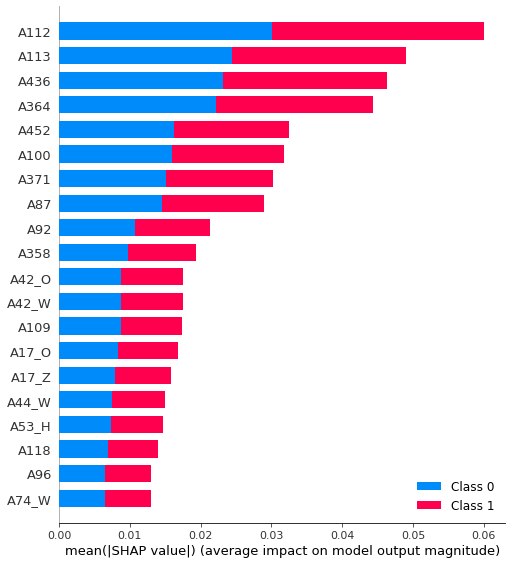

In [9]:
explainer = shap.TreeExplainer(clf5)
shap_values = explainer.shap_values(test)

shap.summary_plot(shap_values, test)

In [67]:
shap.force_plot(shap_values.expected_value[1],shap_values[1][17,:], test_random.iloc[17,:])

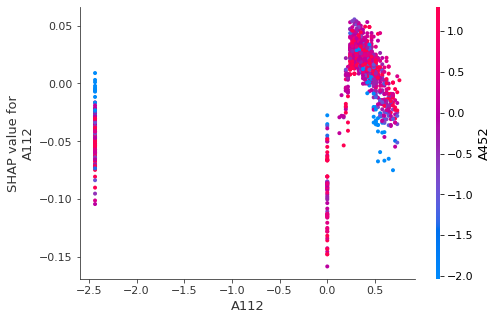

In [18]:
shap.dependence_plot('A112', shap_values[1],test, interaction_index="A452")

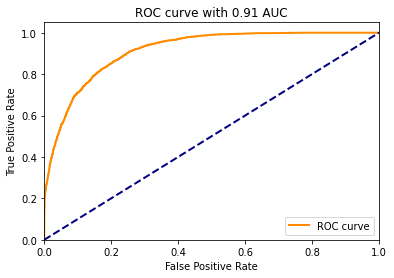

In [45]:
from sklearn.metrics import roc_curve, auc,roc_auc_score


y_score = svc.predict_proba(X)

y_test = Y.values

fpr, tpr, _ = roc_curve(y_test,  y_score[:,1],pos_label=True)
auc = roc_auc_score(y_test, y_score[:,1])


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve with {round(auc,2)} AUC')
plt.legend(loc="lower right")
plt.show()


In [49]:
np.arange(0.1,1,0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [41]:
auc

0.9131306593057799